In [1]:
import os

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
assert len(physical_devices) == 3

# to allow other tensorflow processes to use the gpu
# https://stackoverflow.com/a/60699372/7989988
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)
tf.config.experimental.set_memory_growth(physical_devices[2], True)

import numpy as np
from tensorflow import keras
from tensorflow.keras import Model, Input, layers
from IPython.display import display
import tensorflow_datasets as tfds
import time
import matplotlib.pyplot as plt
import enlighten
import tensorflow_probability as tfp
from dotmap import DotMap

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]


In [2]:
import models
import training
import datasets
import vizualization
import schedules

# todo
# - combine shuffled and unshuffled datasets into same thing
# - add extra shuffled indices and noise
# - add "noise fraction" parameter which can be changed the same way as the "n" parameter.
# - add different amounts of noise to the data and see what happens

In [3]:
config = DotMap({
    'distributed': True,
    'minibatch_size': 32,
    'num_devices': 3,
    'n_steps': 120000,
    'test_size': 1000,
    'test_minibatch_size': 10,
    'test_interval': 100,
    'display_images': True,
    'display_image_interval': 1000,
    'dont_display_until_loss': 0.45,
    'add_noise': True,
    'noise_fraction': 0.05,
    'n_colors': 4,
    'dataset': {
        'buffer_size': 60000,
    },
    'lr_schedule': None,
    'lr_warmup_steps': 300,
    'max_lr': 0.0001,
    'min_lr': 0.0001,
    'batch_size_schedule': None,
    'start_accum_steps': 1,
    'end_accum_steps': 30,
    'seq_length': 784,
    'image_width': 28,
    'image_height': 28,
    'use_wandb': True,
    'wandb_log_interval': 10,
    'loss_window_size': 500,
})

# need to change for multiworkerstrategy
if config.distributed:
    config.num_devices = len(physical_devices)
else:
    config.num_devices = 1
config.global_batch_size = config.minibatch_size * config.num_devices

In [4]:
# idea is to not have to re-run this cell for subsequent training runs unless the centroids change
dataset, metadata = tfds.load('mnist', with_info=True, as_supervised=True)
ds_train_original = dataset['train']
ds_test_original = dataset['test']

centroids = datasets.find_centroids(ds_train_original, num_clusters=config['n_colors'], batch_size=1000)


In [5]:
gamma_dist, gamma_name = datasets.mnist_gamma_distribution()
ds = datasets.Datasets(config, ds_train_original, ds_test_original, centroids, gamma_dist)
viz = vizualization.Viz(config, ds, centroids)

In [6]:
ds_train, ds_test = ds.make_datasets()

In [7]:
# model config
config.model = DotMap({
        'n_colors': config.n_colors,
        'n_enc_a_layers': 3,
        'n_enc_b_layers': 3,
        'ffl_dim': 128,
        'embd_dim': 64,
        'n_dec_layers': 3,
        'dec_dim': 600,
        'n_heads': 4,
        'dropout_rate': 0.1,
        'use_idxs_input': True,
        'architecture': 'anp',
        'position_embedding': 'pos_enc',
        'activation': 'swish',
    })

if config.distributed == False:
    strategy = tf.distribute.get_strategy()
else:
    strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = models.transformer(config.model)
    # Adam params taken from the linked notebook
    optimizer = keras.optimizers.Adam(learning_rate=config.max_lr)

ds_train_dist = strategy.experimental_distribute_dataset(ds_train)

model_name = "cuda6-noise-big"
print(model_name)

training.wandb_init(config, model_name, resume=False)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


cuda6-noise-big


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: maxeonyx (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [8]:
config.training_mode = 'combination'
training_loop = training.TrainingLoop(config, viz, model, optimizer, ds, ds_train_dist, ds_test, schedules.batch_size_schedule(config), model_name)


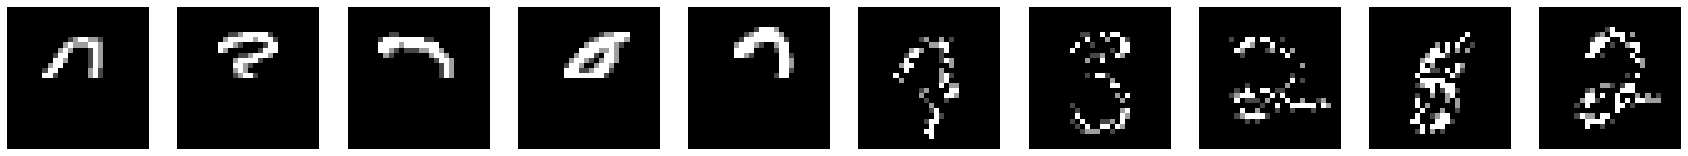

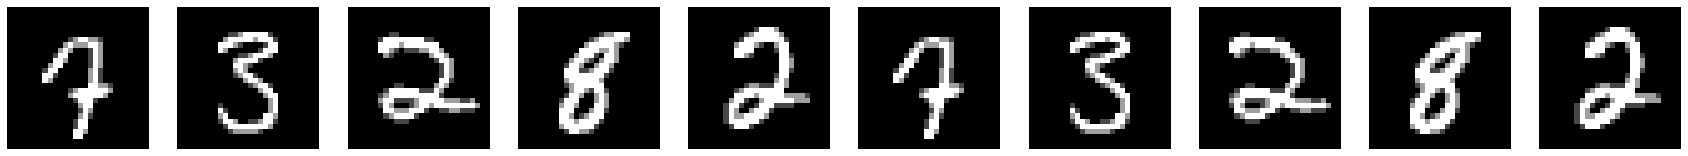

/home/clarkemaxw/.cache/pypoetry/virtualenvs/msc-r6Gz9mJU-py3.8/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("StatefulPartitionedCall:2", shape=(None,), dtype=int32), values=Tensor("StatefulPartitionedCall:1", shape=(None, 64), dtype=float32), dense_shape=Tensor("StatefulPartitionedCall:3", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/clarkemaxw/.cache/pypoetry/virtualenvs/msc-r6Gz9mJU-py3.8/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("StatefulPartitionedCall_1:2", shape=(None,), dtype=int32), values=Tensor("StatefulPartitionedCall_1:1", shape=(None, 64), dtype=float32), dense_shape=Tensor("StatefulPartitionedCall_1:3", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may

INFO:tensorflow:batch_all_reduce: 63 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 63 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 63 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 63 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Step 0, Loss (last minibatch): 1.2794785499572754, Loss (500 step avg.): 1.2794785499572754


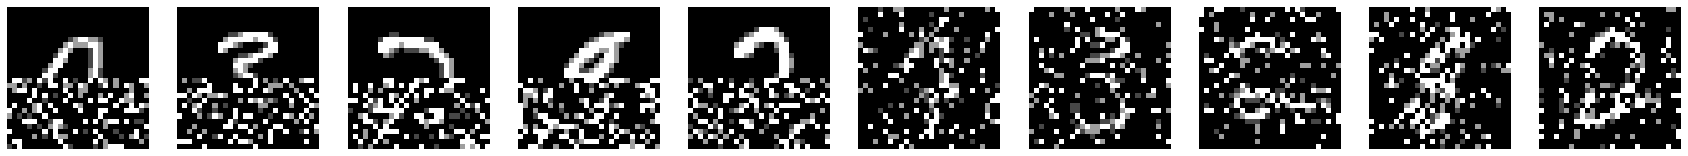

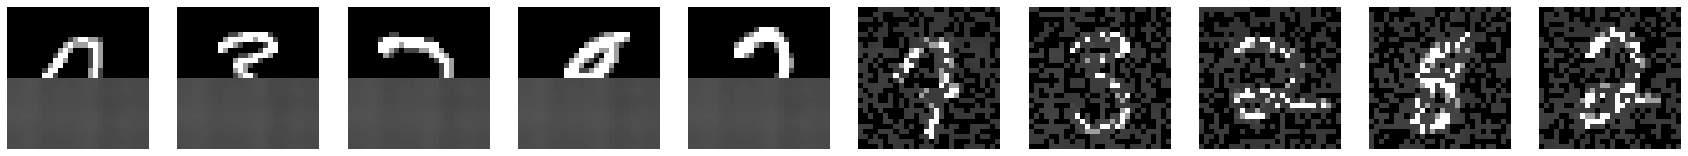

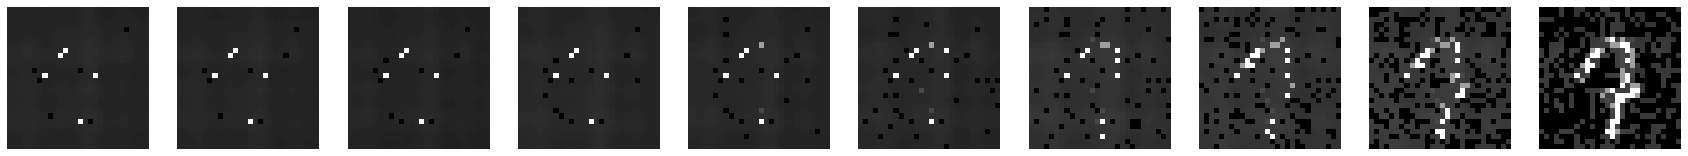

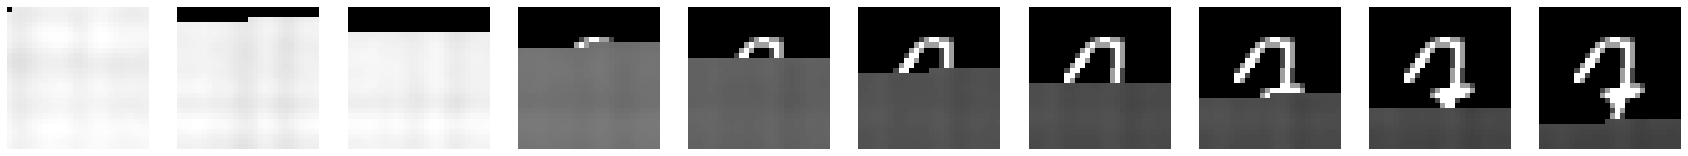

Step 740, Loss (last minibatch): 0.436672568321228, Loss (500 step avg.): 0.4499736798261692


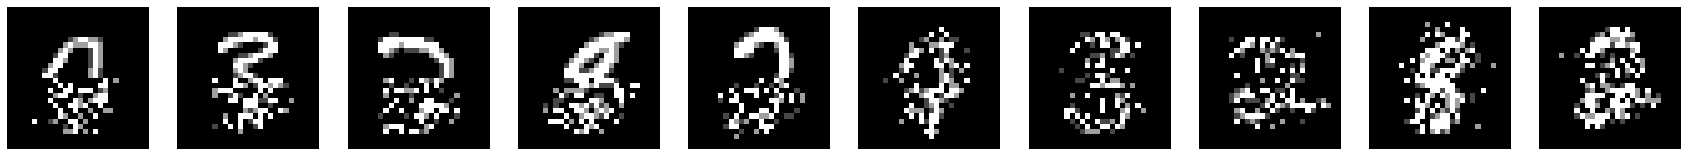

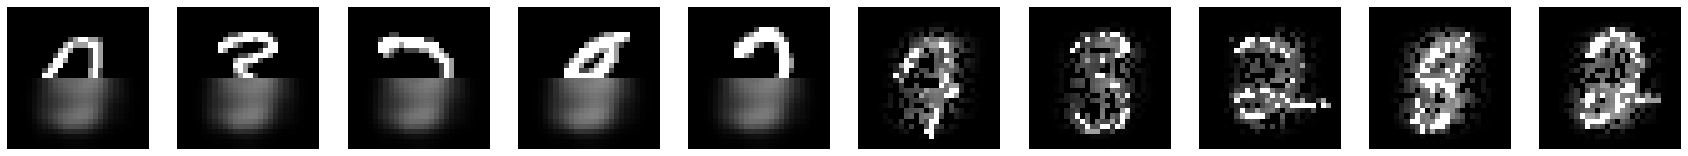

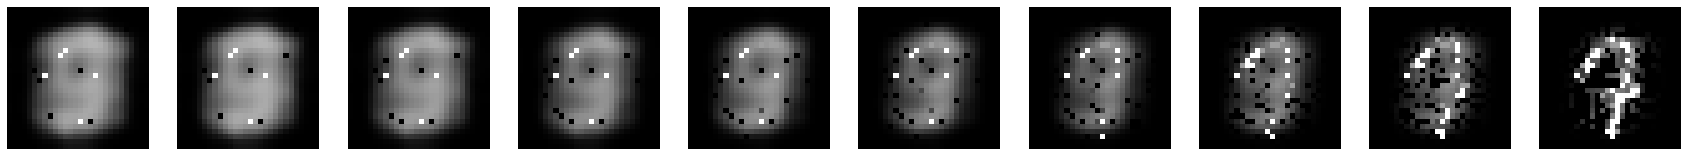

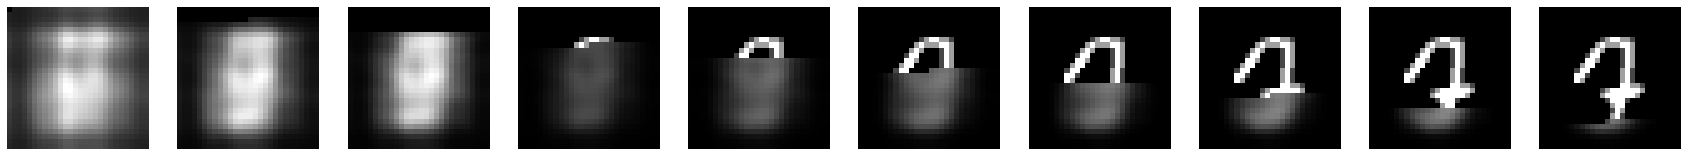

Step 1317, Loss (last minibatch): 0.3318437337875366, Loss (500 step avg.): 0.4048777749676428


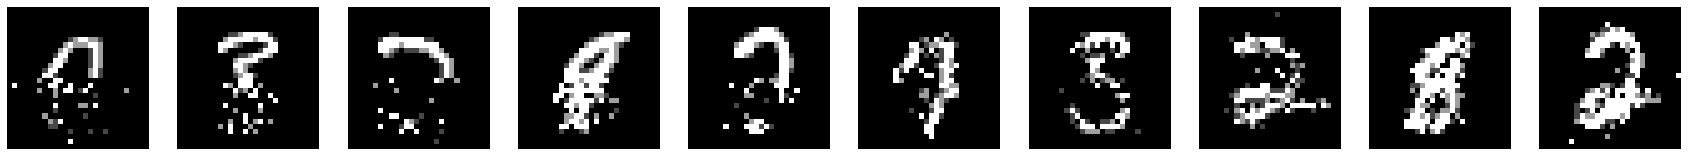

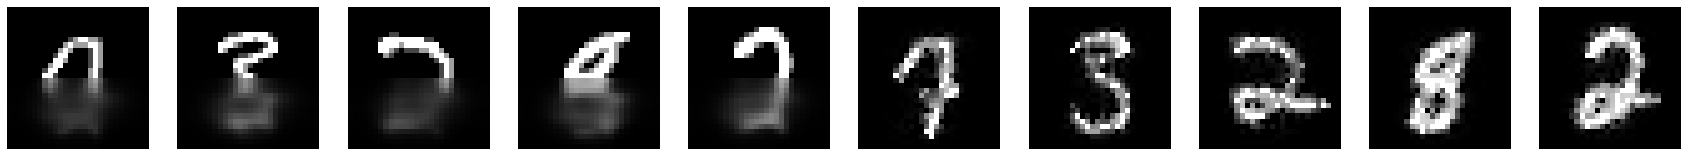

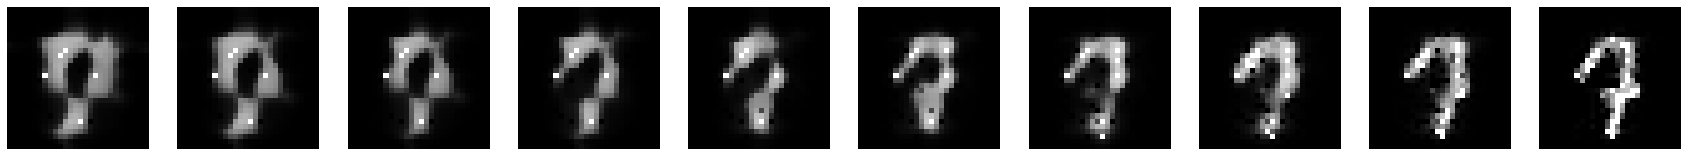

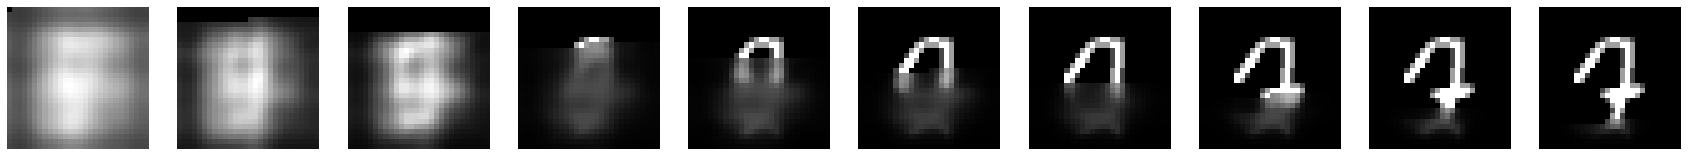

Step 1561, Loss (last minibatch): 0.3248368501663208, Loss (500 step avg.): 0.3642686636980898


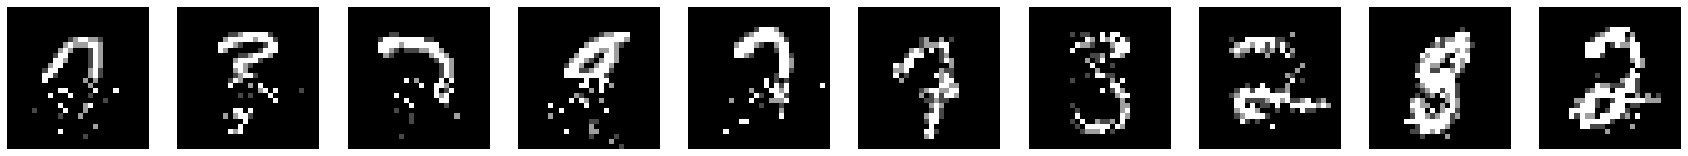

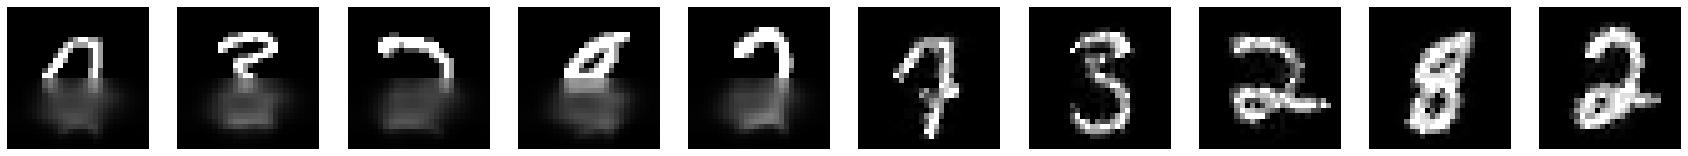

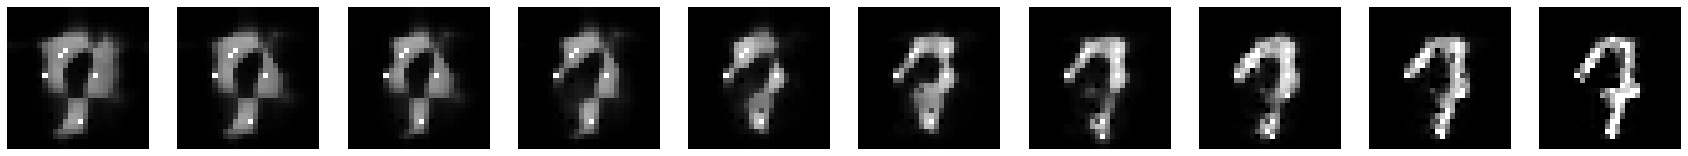

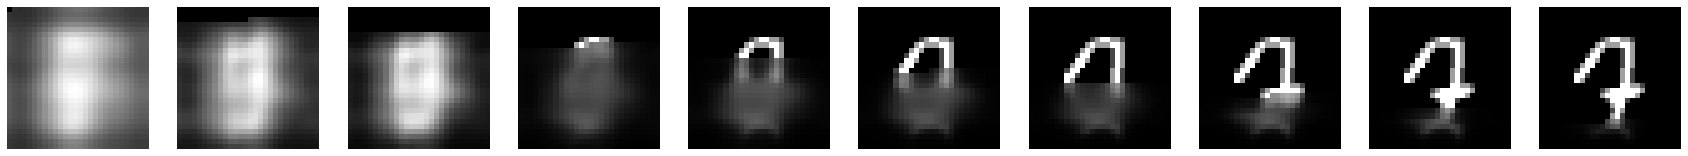

Step 2304, Loss (last minibatch): 0.2856060266494751, Loss (500 step avg.): 0.3277840576248017


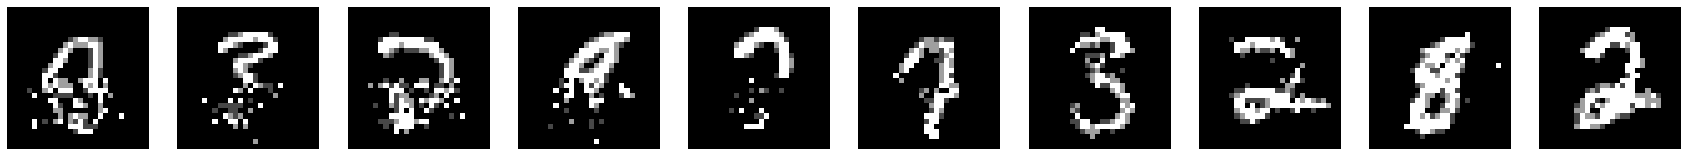

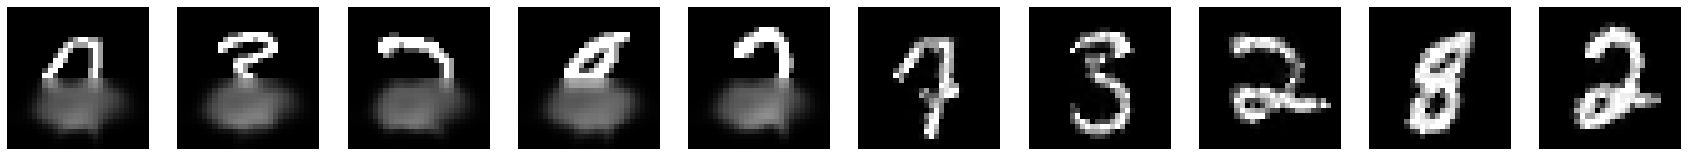

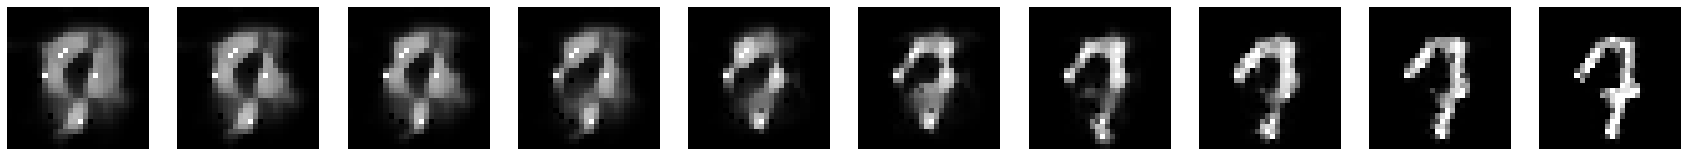

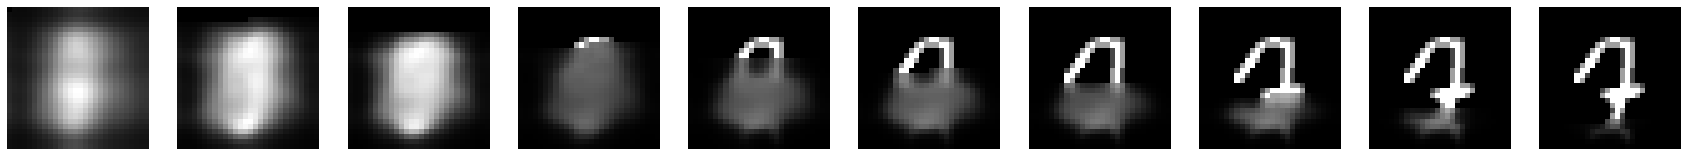

Step 3304, Loss (last minibatch): 0.3436965346336365, Loss (500 step avg.): 0.3119116219693791


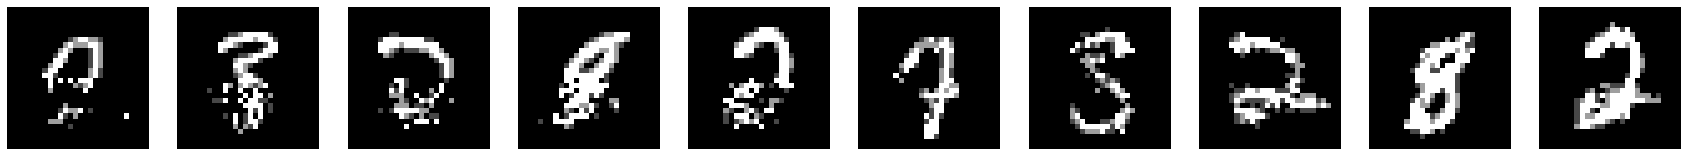

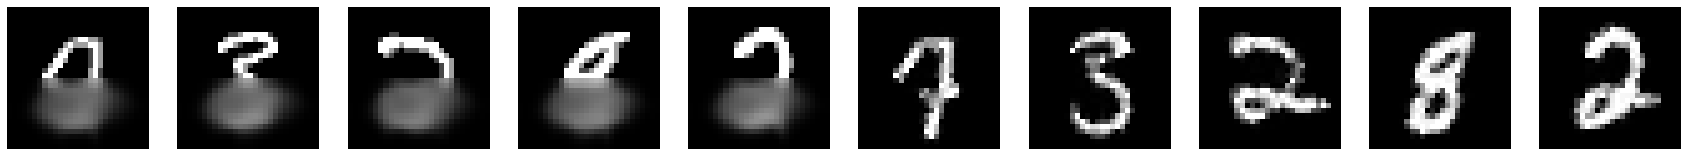

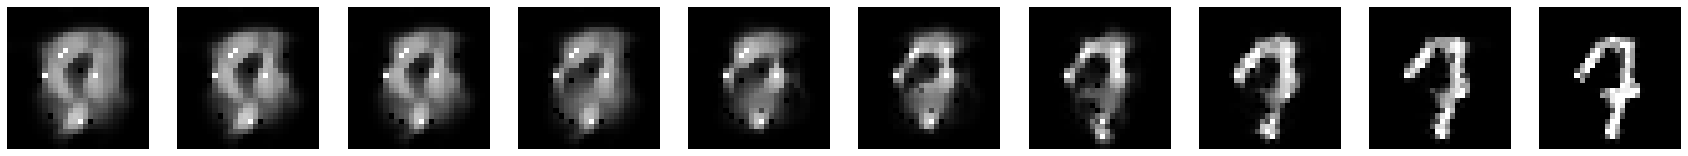

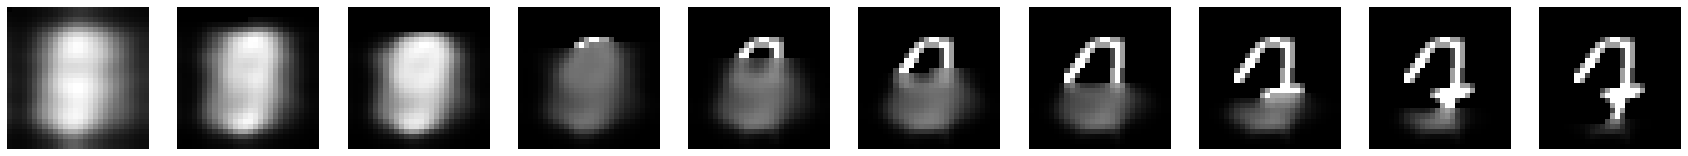

Step 4304, Loss (last minibatch): 0.28126296401023865, Loss (500 step avg.): 0.301125113062278


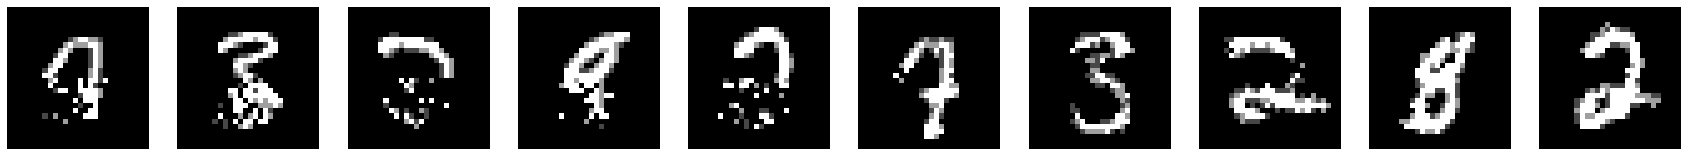

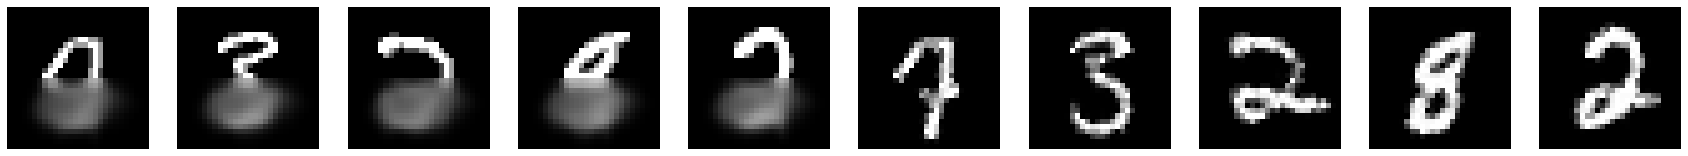

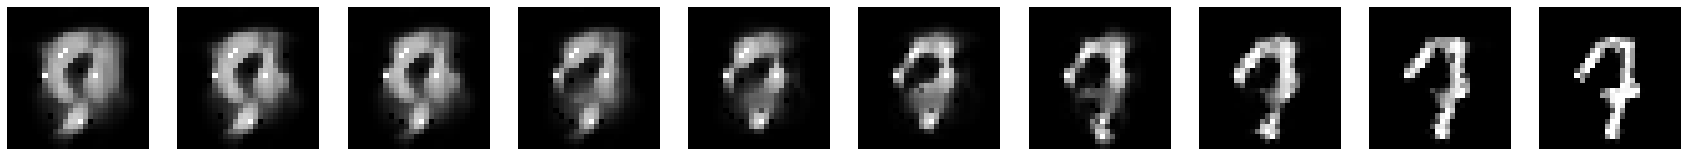

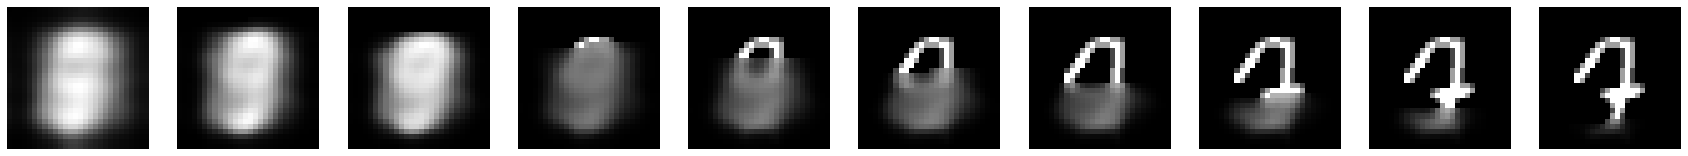

Step 5304, Loss (last minibatch): 0.26221129298210144, Loss (500 step avg.): 0.2980069609697232


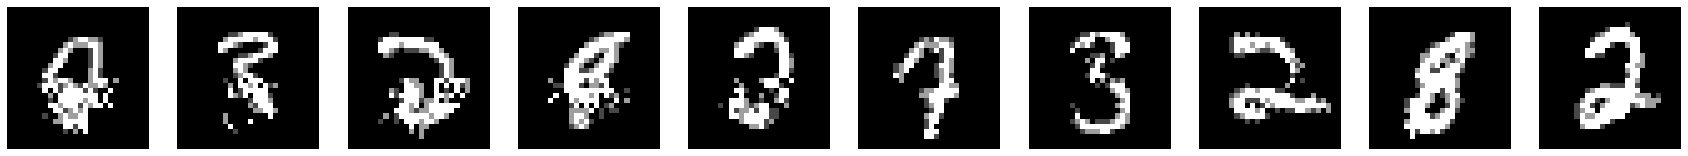

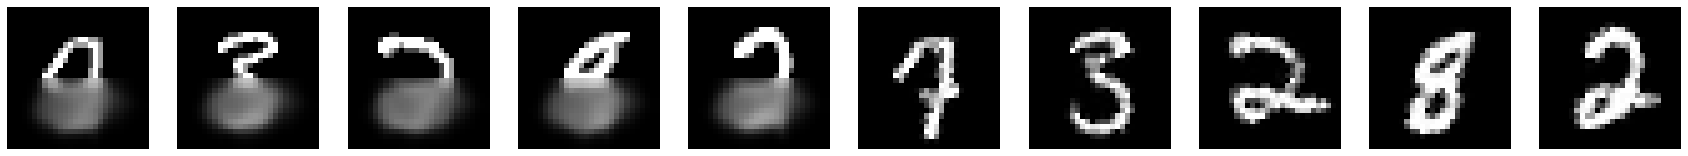

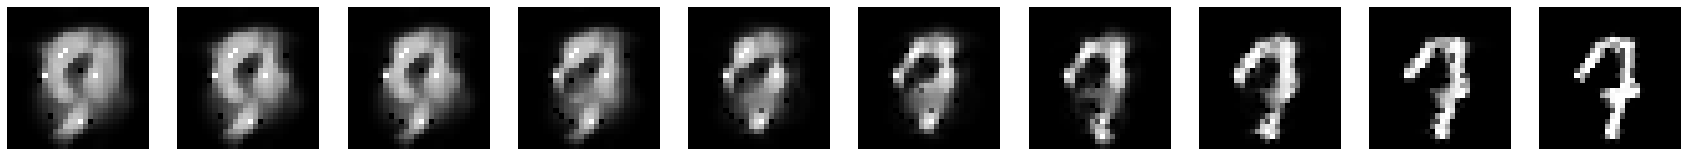

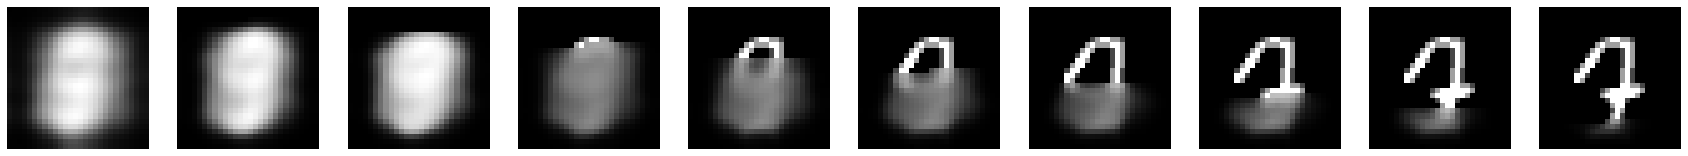

Step 6304, Loss (last minibatch): 0.33687591552734375, Loss (500 step avg.): 0.2944558225349038


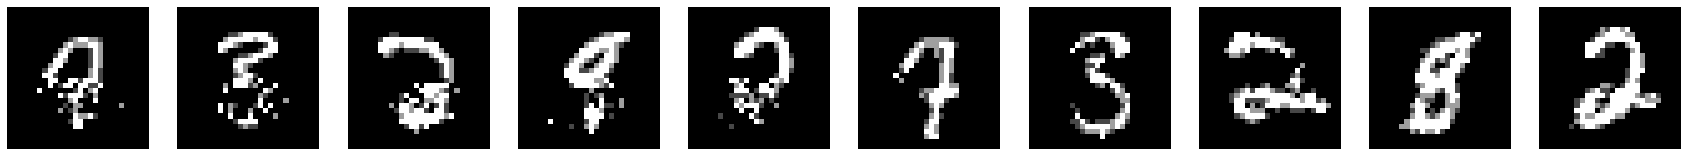

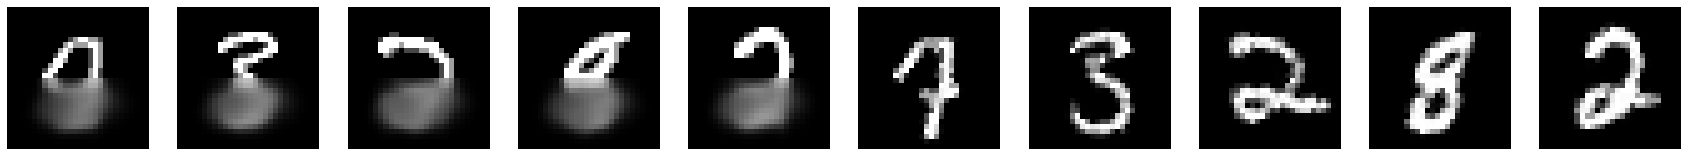

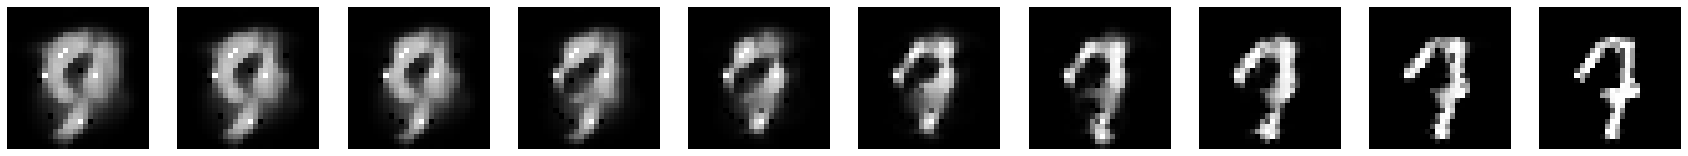

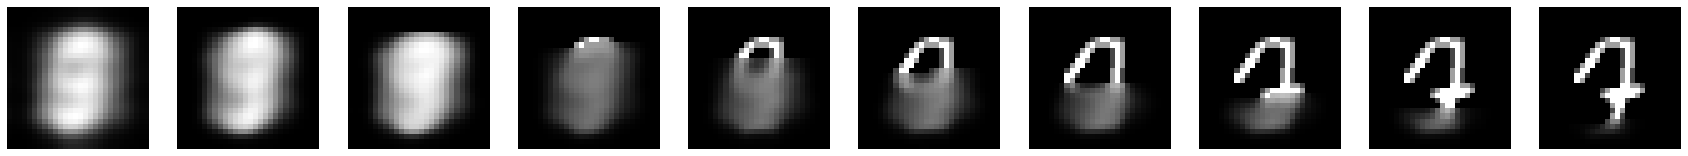

Step 7304, Loss (last minibatch): 0.3574925661087036, Loss (500 step avg.): 0.2875584697057149


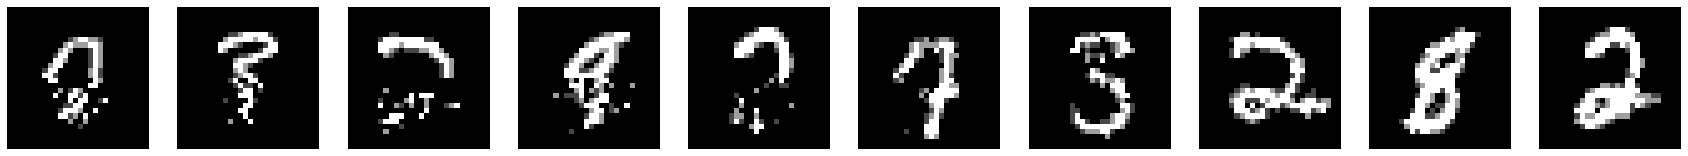

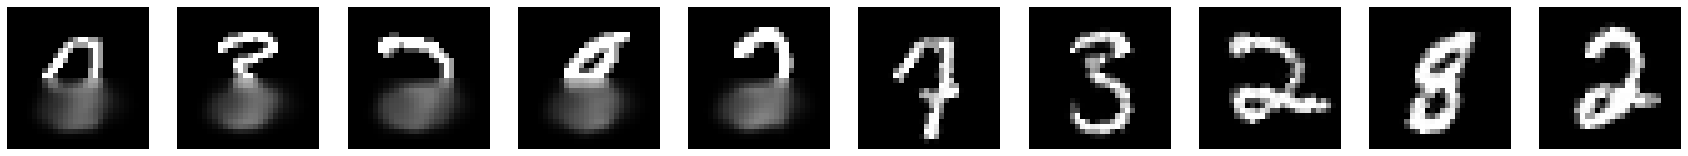

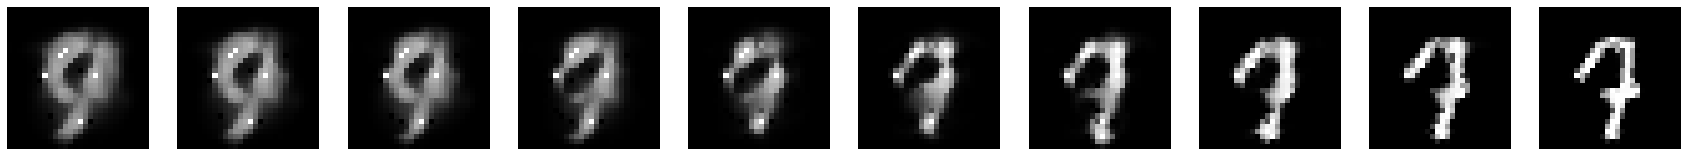

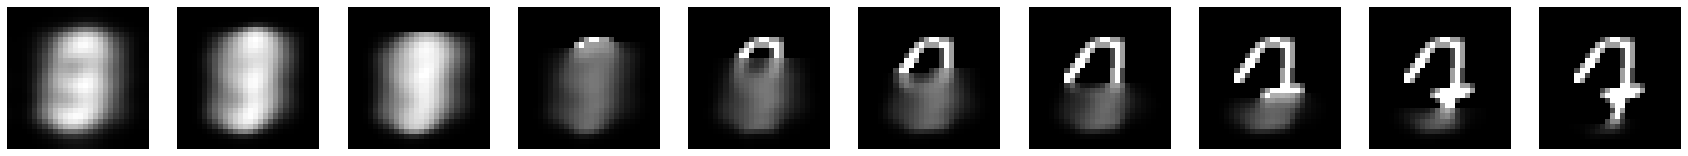

Step 8304, Loss (last minibatch): 0.26771280169487, Loss (500 step avg.): 0.2824060919280062


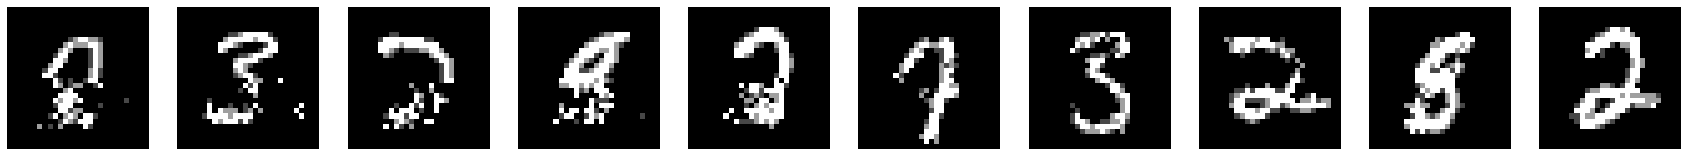

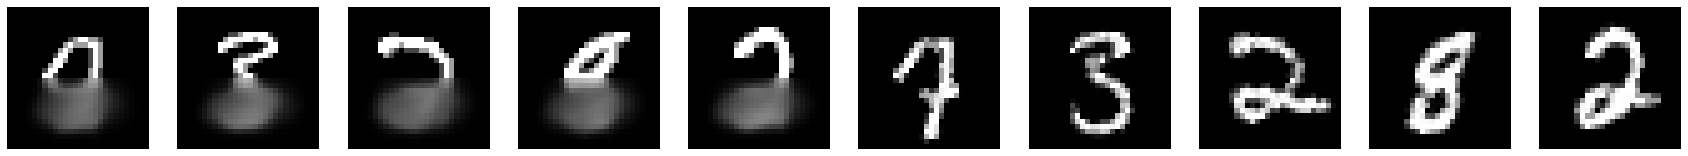

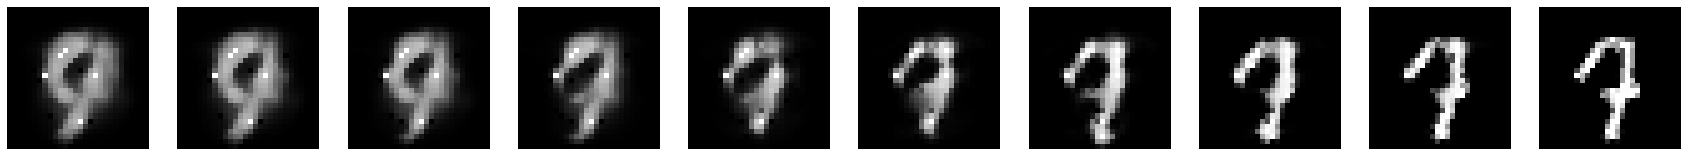

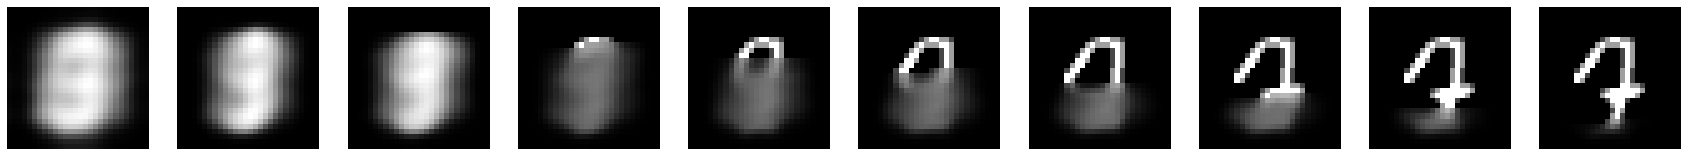

Step 9304, Loss (last minibatch): 0.23633608222007751, Loss (500 step avg.): 0.28158281350921016


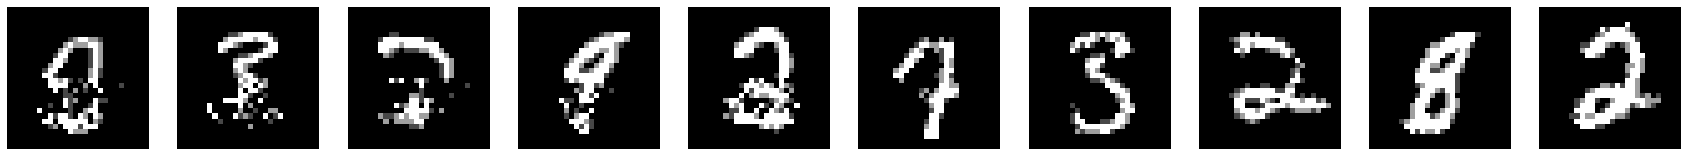

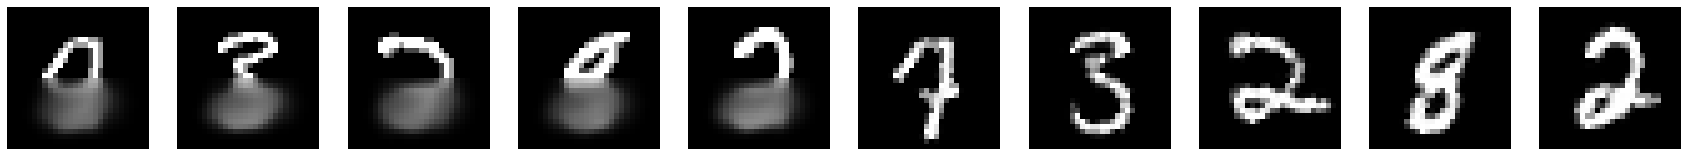

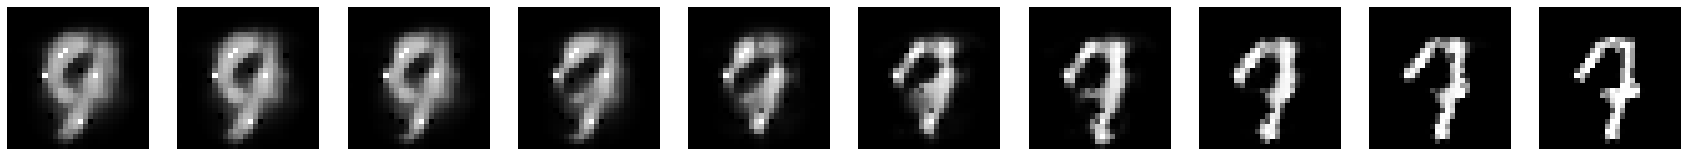

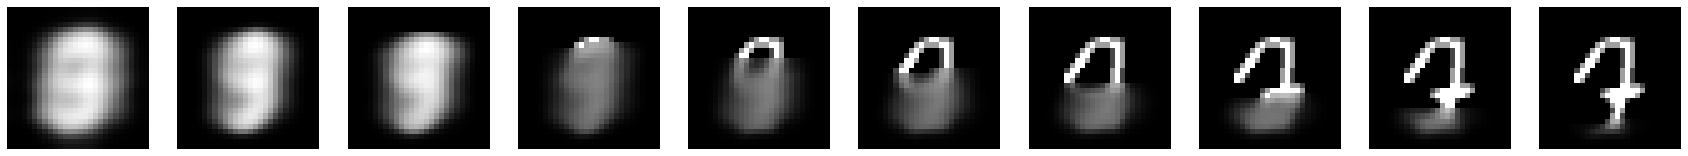

Step 10304, Loss (last minibatch): 0.2215512990951538, Loss (500 step avg.): 0.2756695088571655


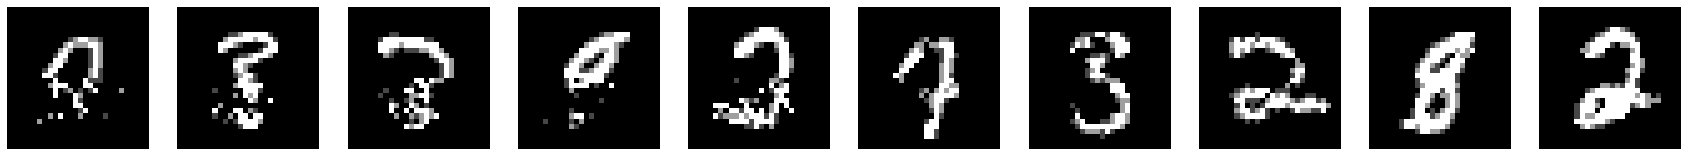

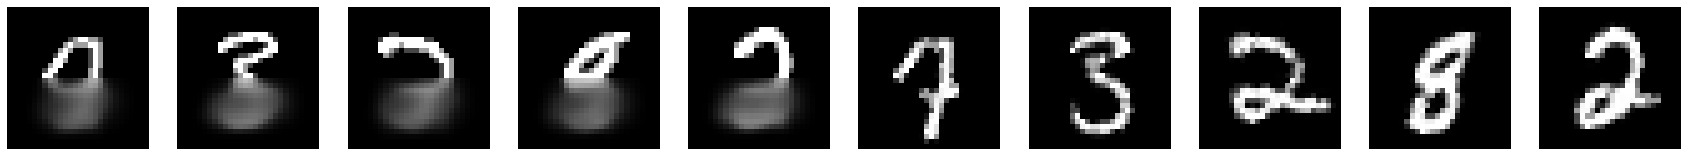

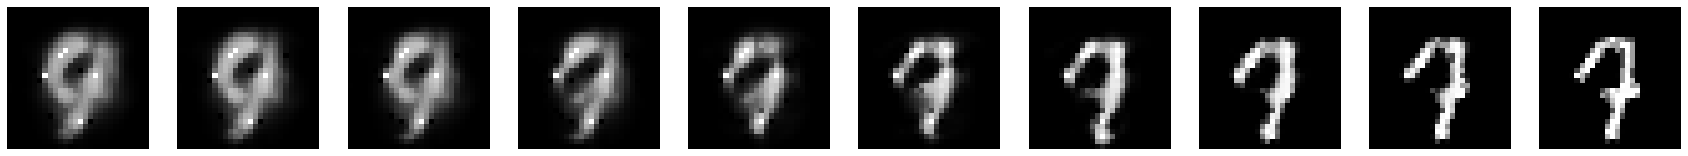

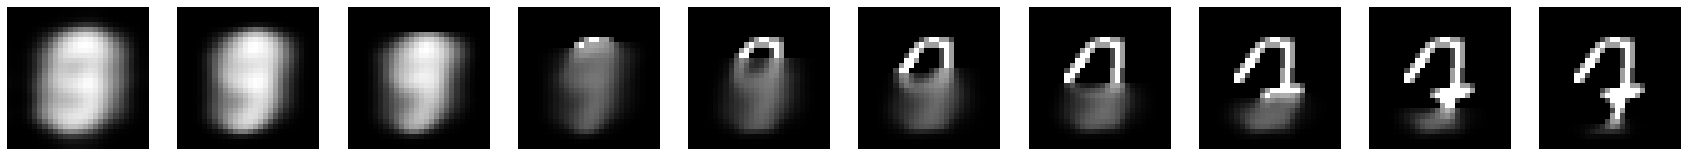

Step 11304, Loss (last minibatch): 0.2587887644767761, Loss (500 step avg.): 0.2707609579770151


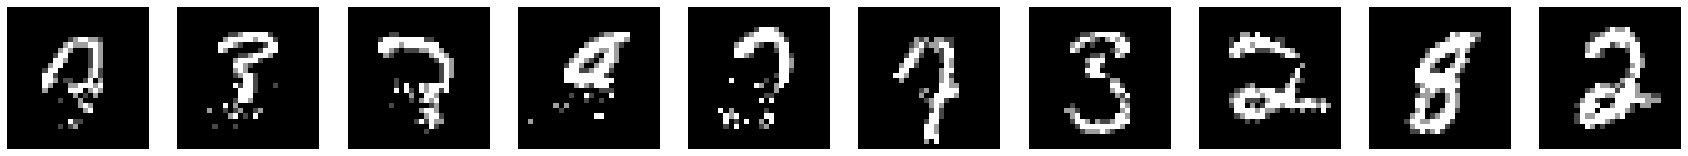

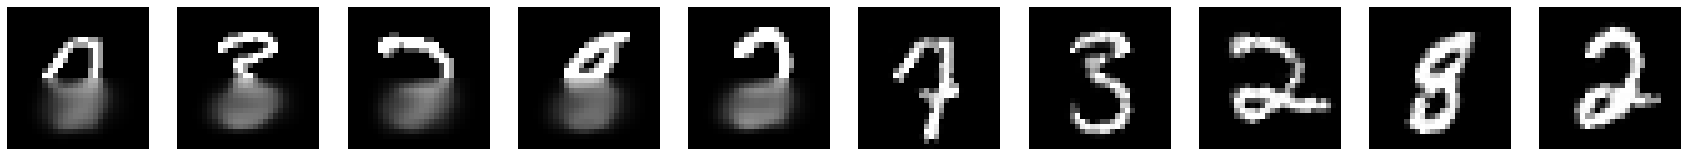

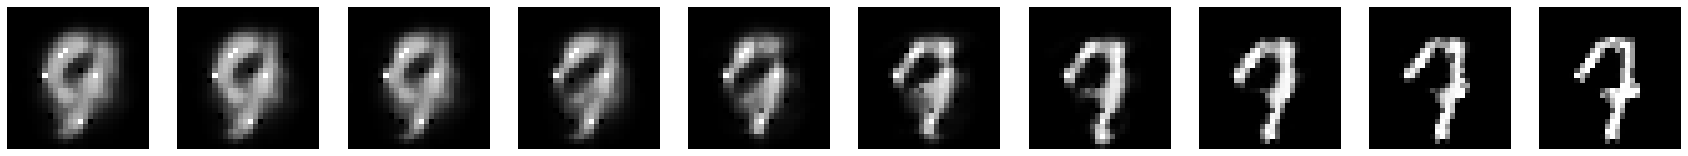

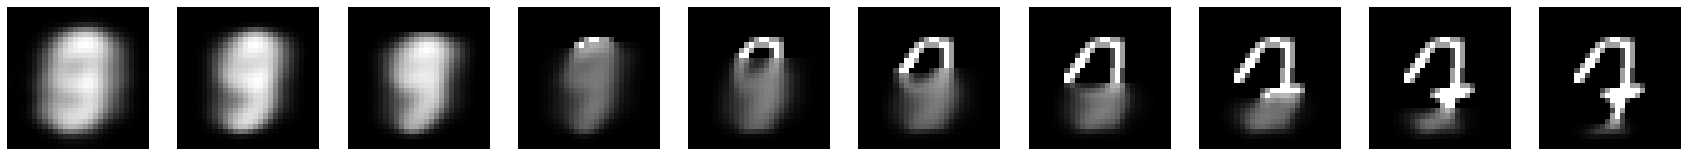

Step 12304, Loss (last minibatch): 0.2223665714263916, Loss (500 step avg.): 0.2686514210498738


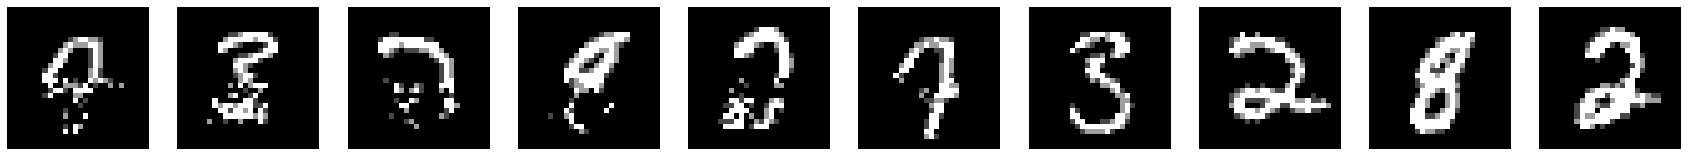

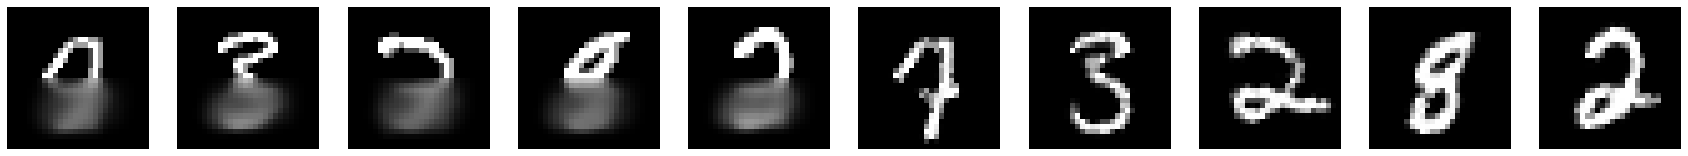

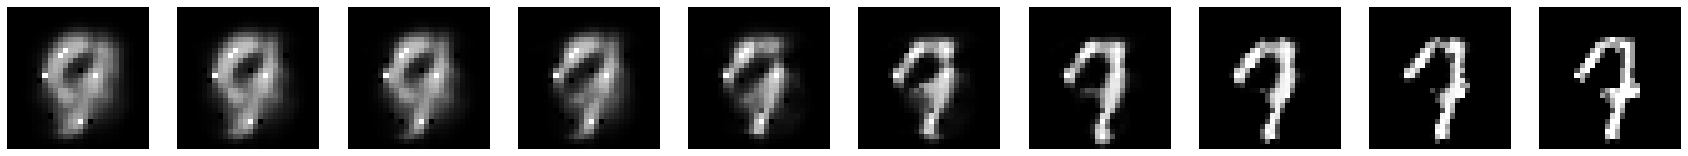

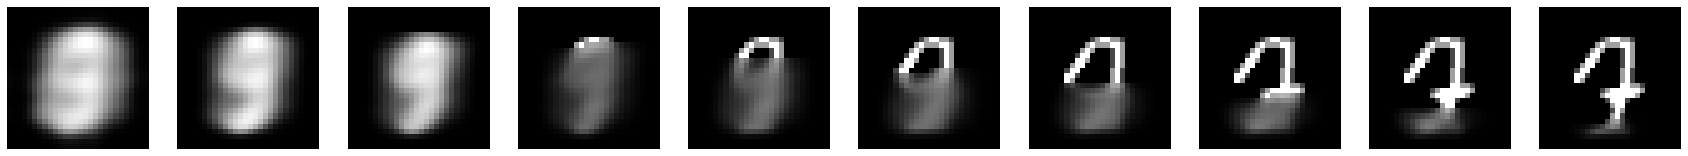

Step 13304, Loss (last minibatch): 0.24351641535758972, Loss (500 step avg.): 0.2614555028146375


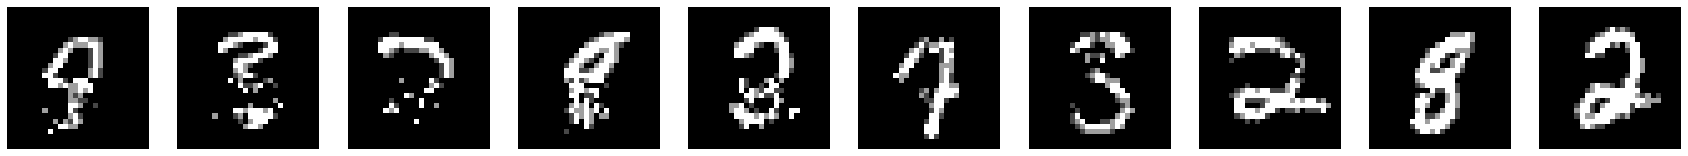

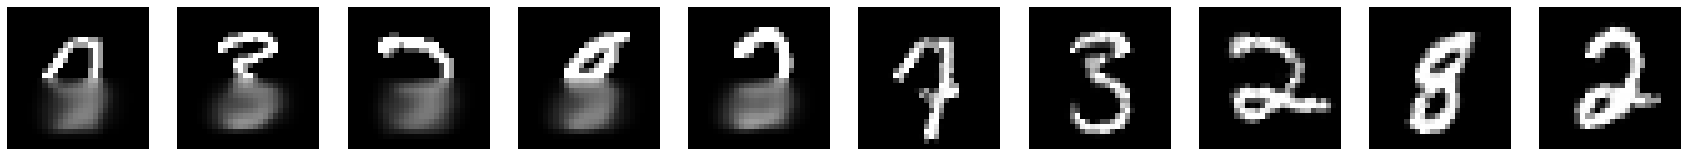

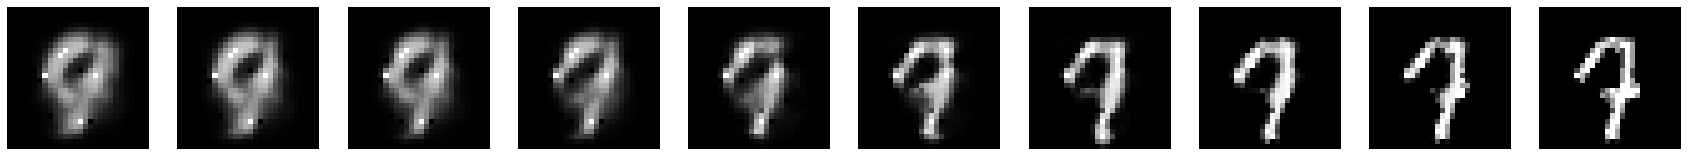

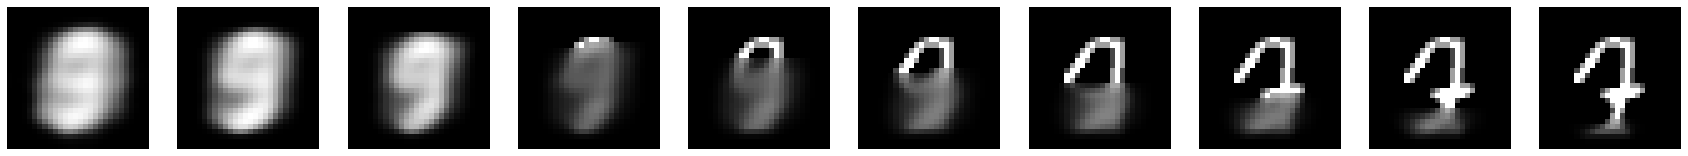

Step 14304, Loss (last minibatch): 0.26689431071281433, Loss (500 step avg.): 0.2585845715747384


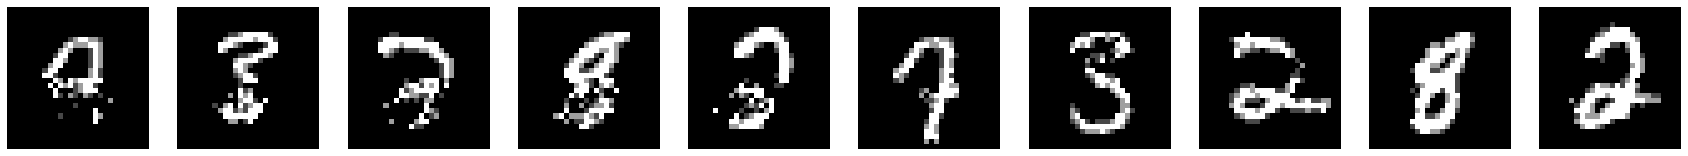

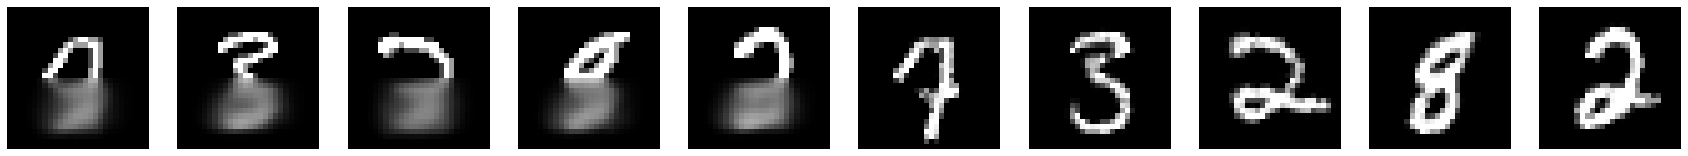

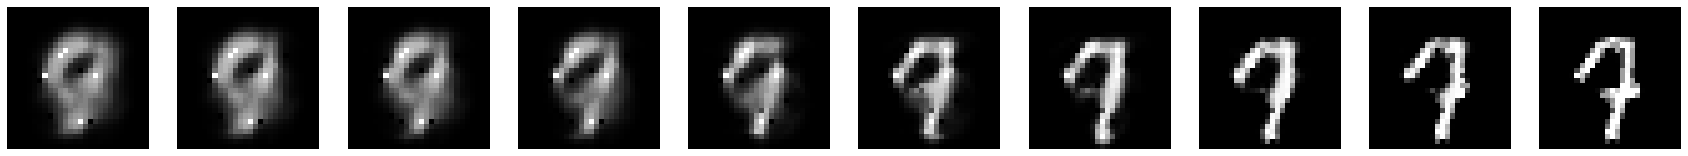

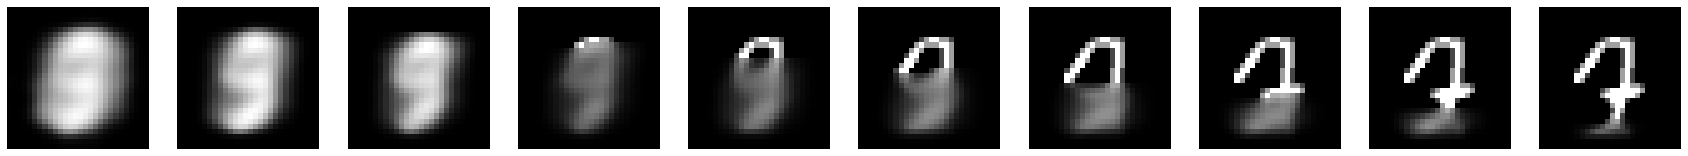

Step 15304, Loss (last minibatch): 0.3154056966304779, Loss (500 step avg.): 0.2585509285598458


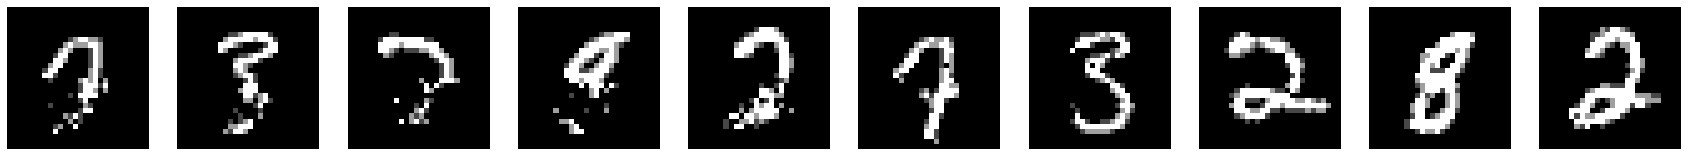

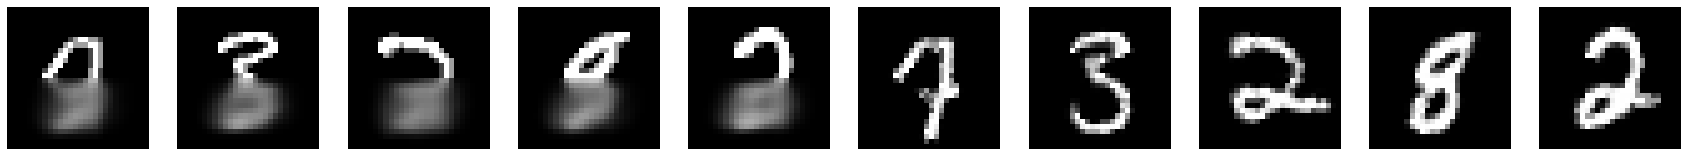

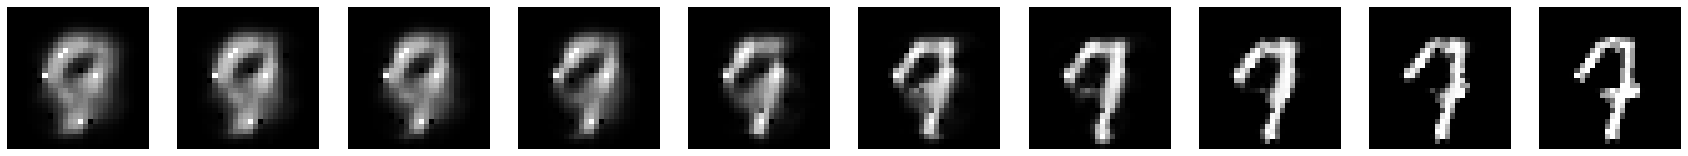

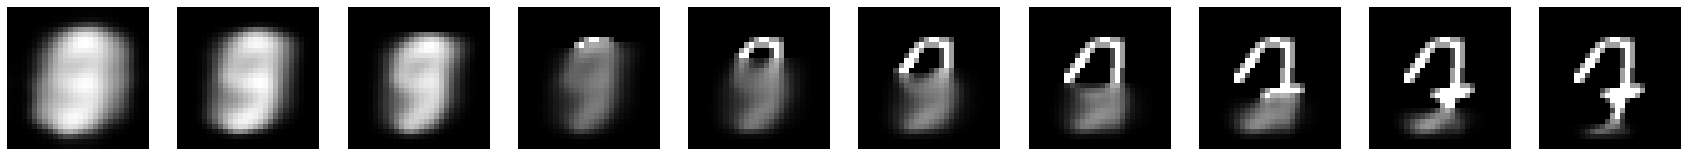

Step 16304, Loss (last minibatch): 0.2235596626996994, Loss (500 step avg.): 0.2534325283147142


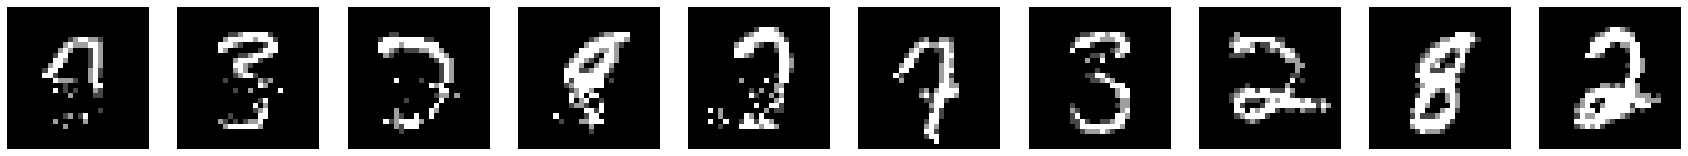

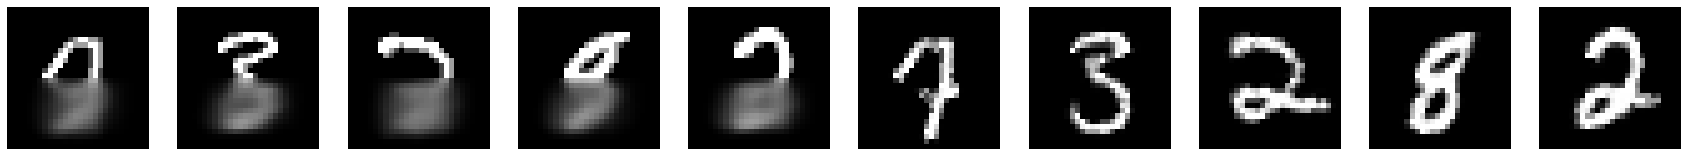

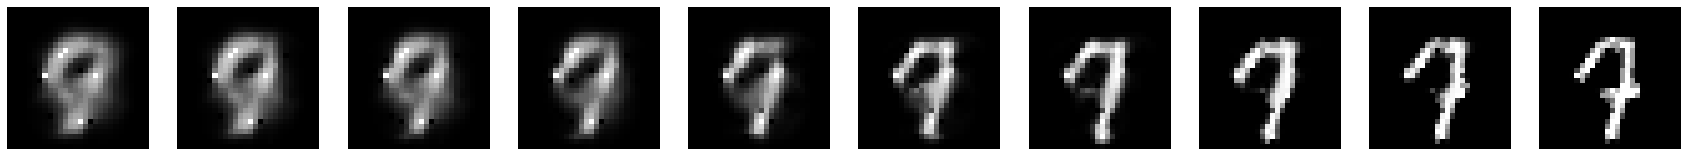

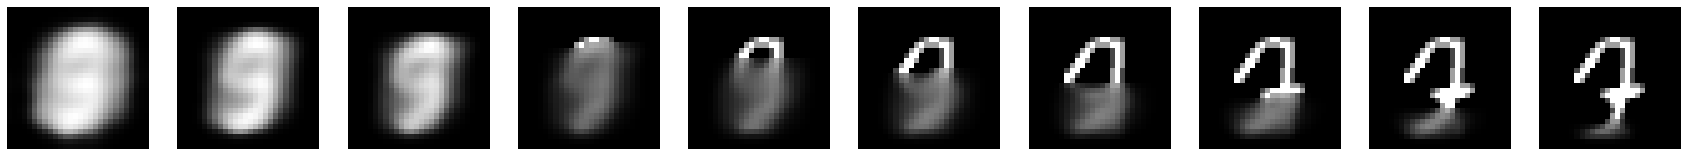

Step 17304, Loss (last minibatch): 0.25027674436569214, Loss (500 step avg.): 0.25176747979042297


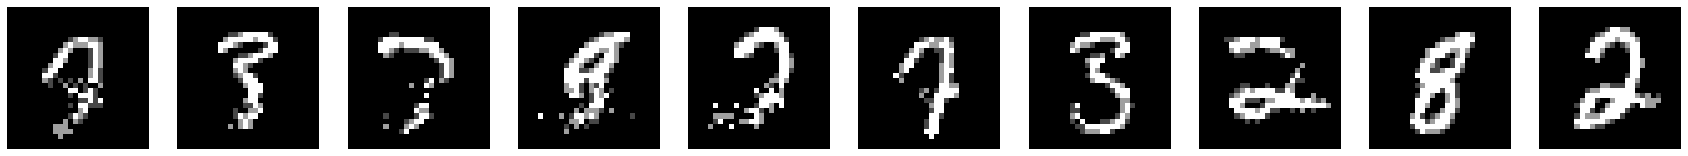

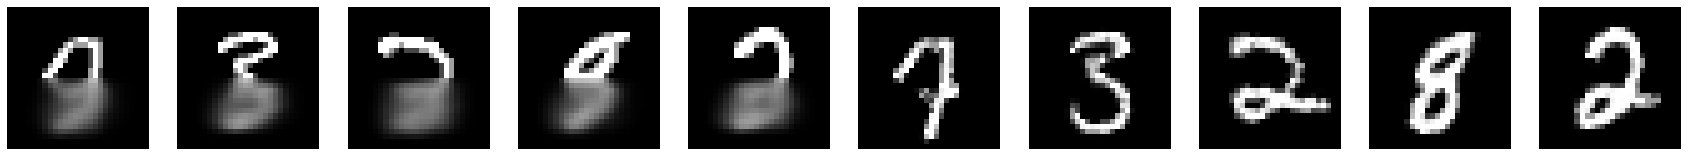

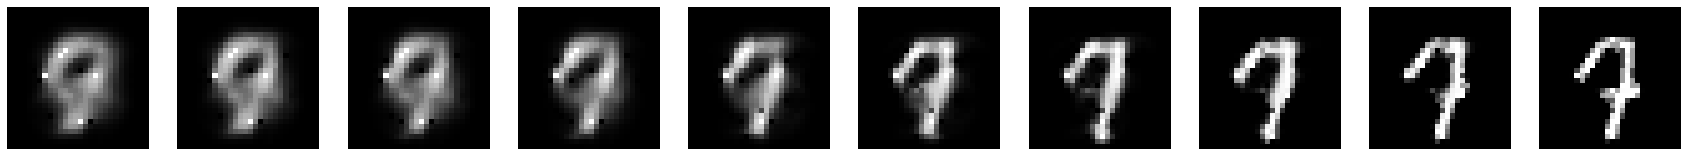

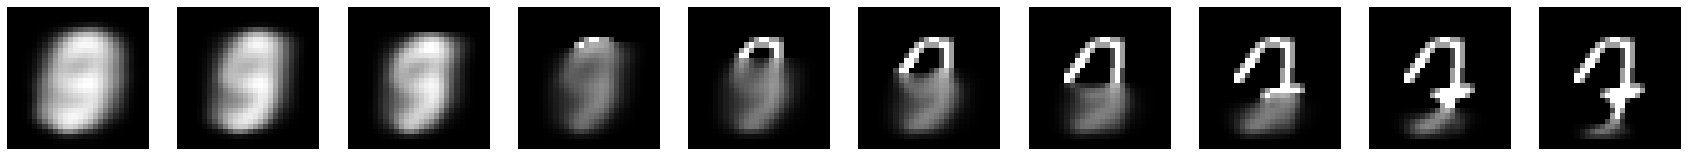

Step 18304, Loss (last minibatch): 0.28137141466140747, Loss (500 step avg.): 0.24557970541560958


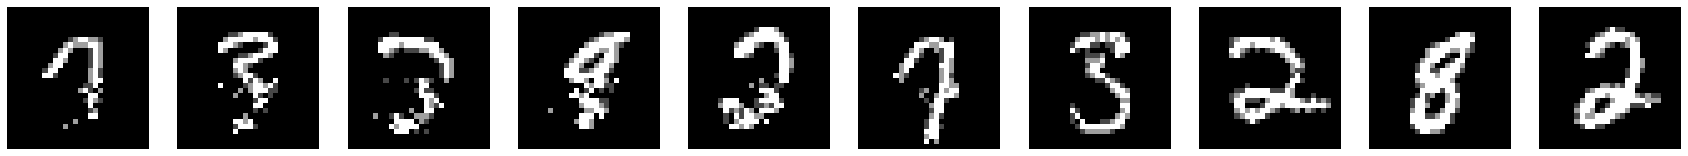

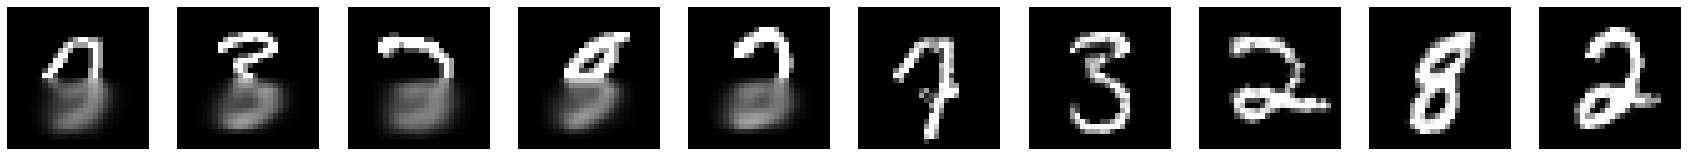

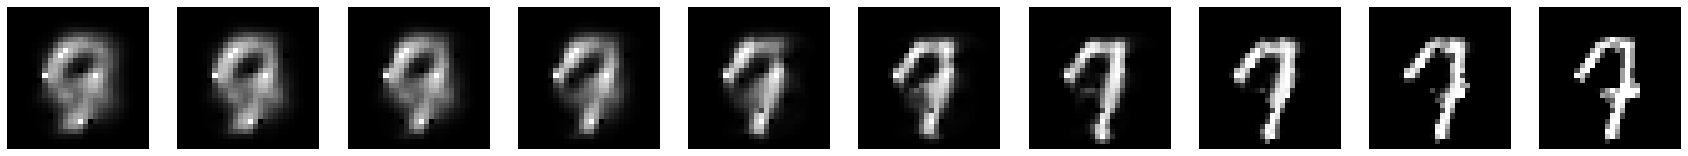

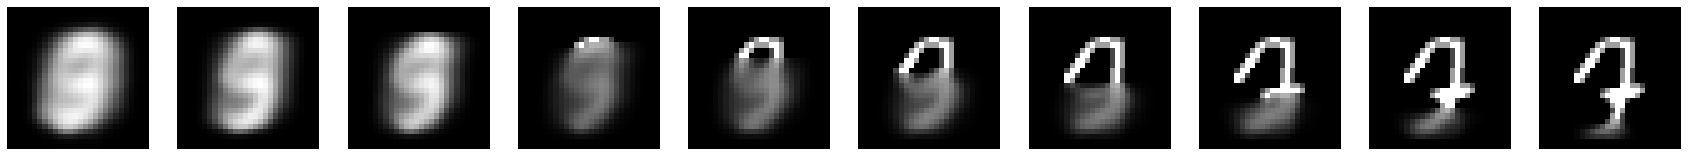

Step 19304, Loss (last minibatch): 0.2660125494003296, Loss (500 step avg.): 0.24450571136084384


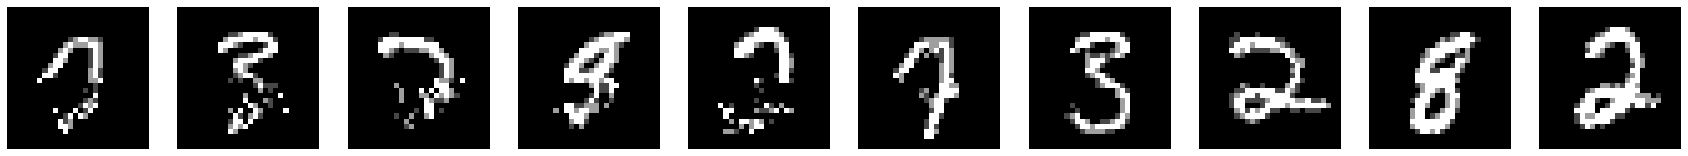

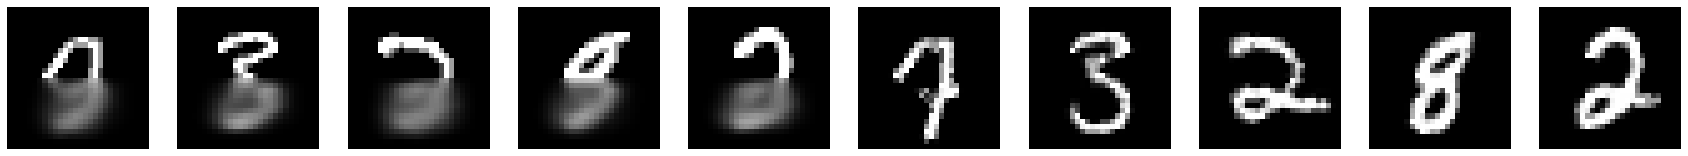

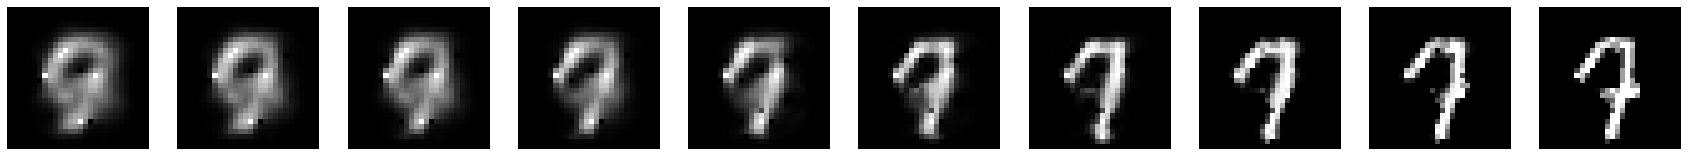

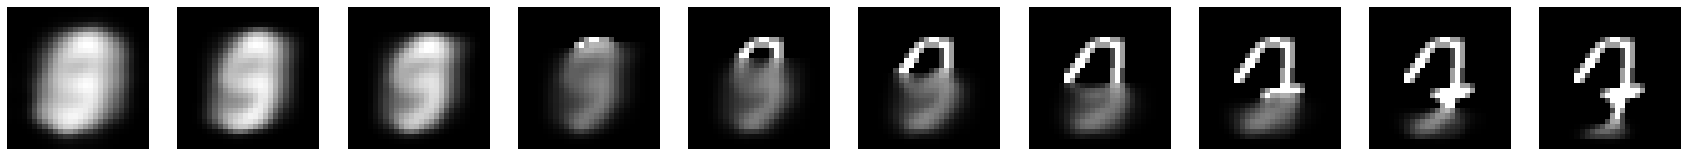

Step 20304, Loss (last minibatch): 0.21535269916057587, Loss (500 step avg.): 0.2431412016500732


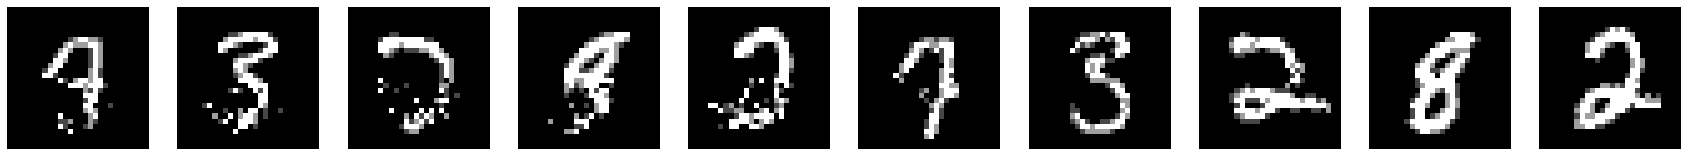

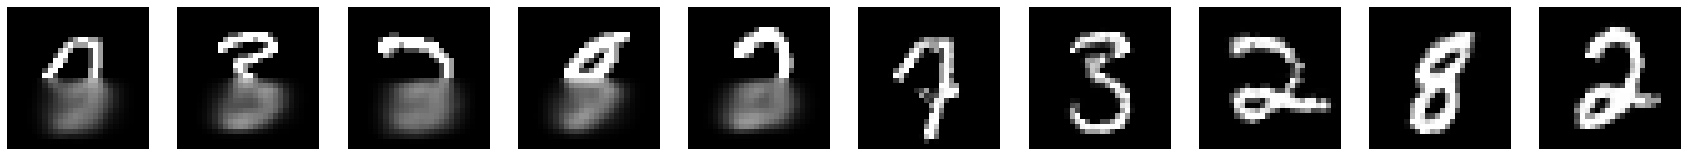

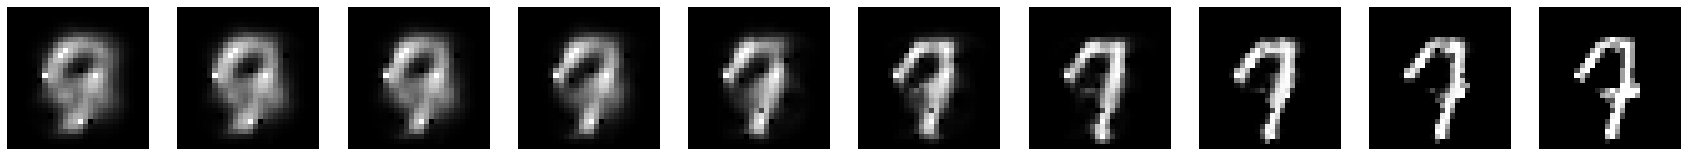

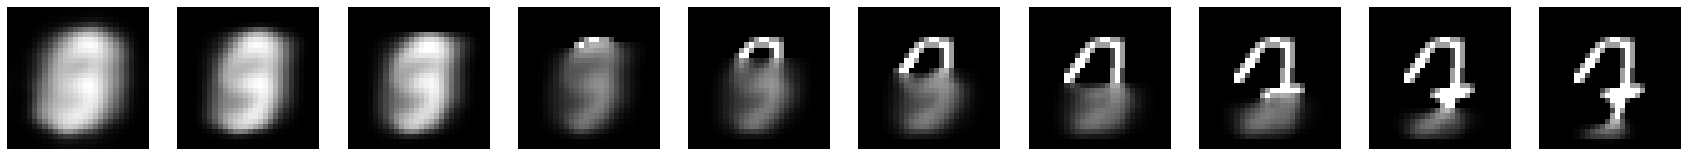

Step 21304, Loss (last minibatch): 0.2577816843986511, Loss (500 step avg.): 0.24302491667622816


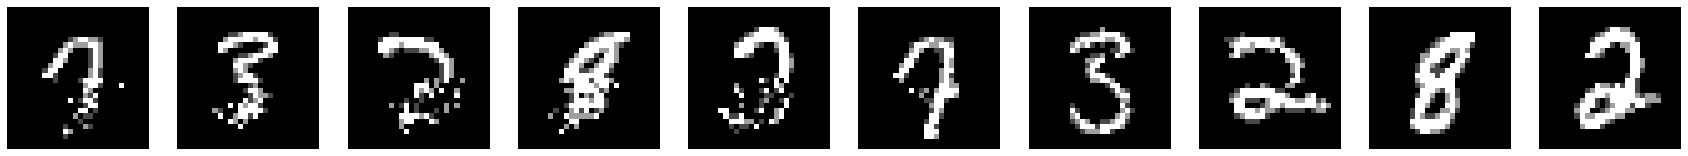

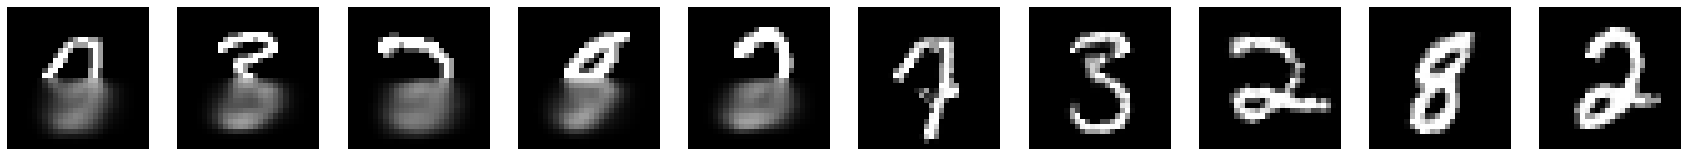

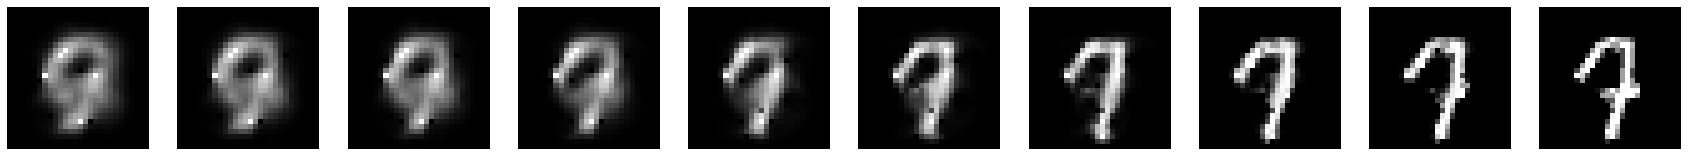

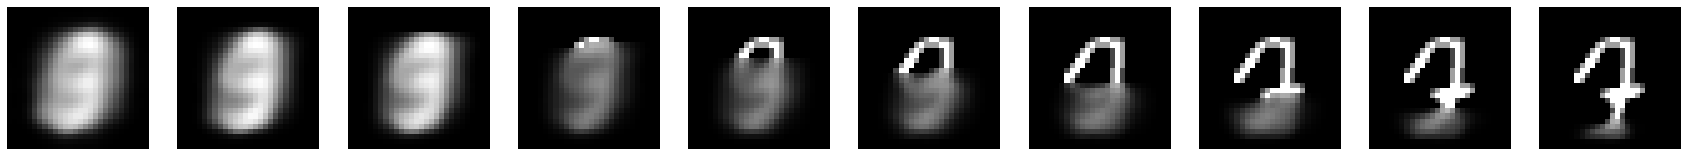

Step 22304, Loss (last minibatch): 0.21596716344356537, Loss (500 step avg.): 0.2396000856291986


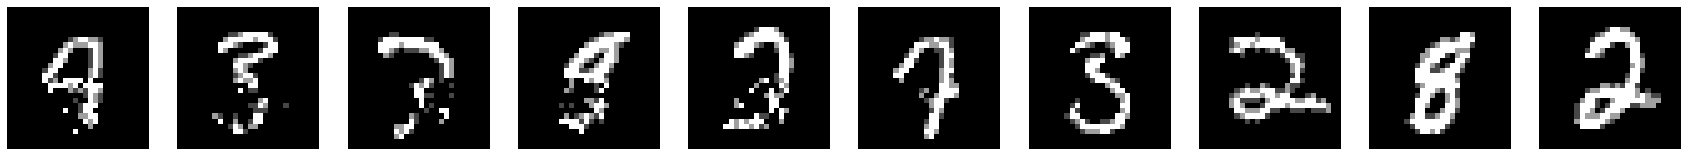

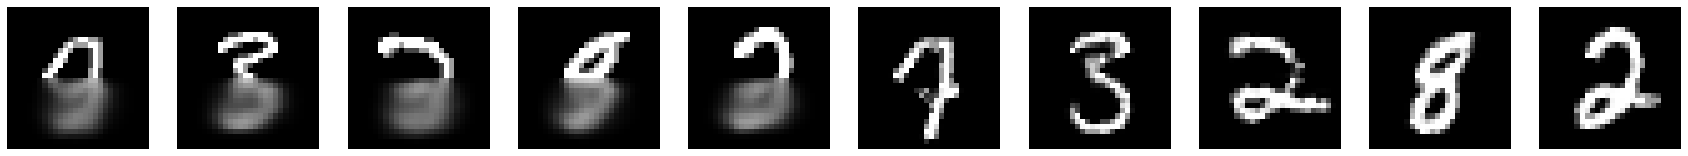

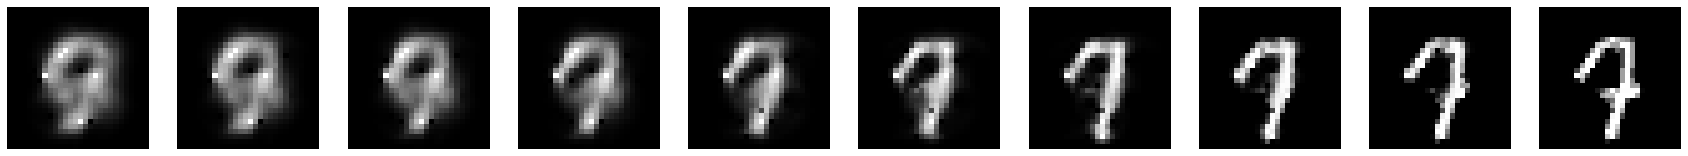

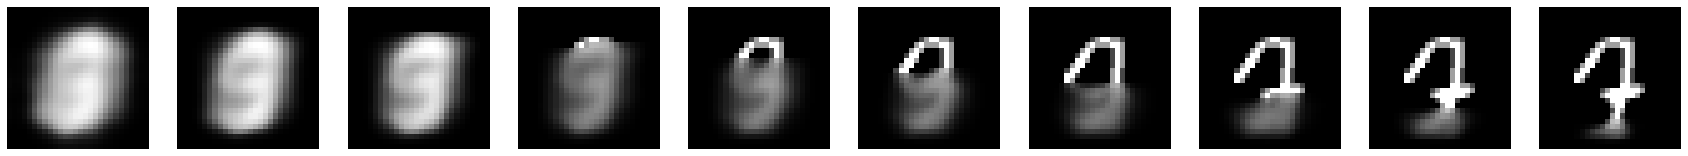

Step 23304, Loss (last minibatch): 0.20667549967765808, Loss (500 step avg.): 0.2383701140414217


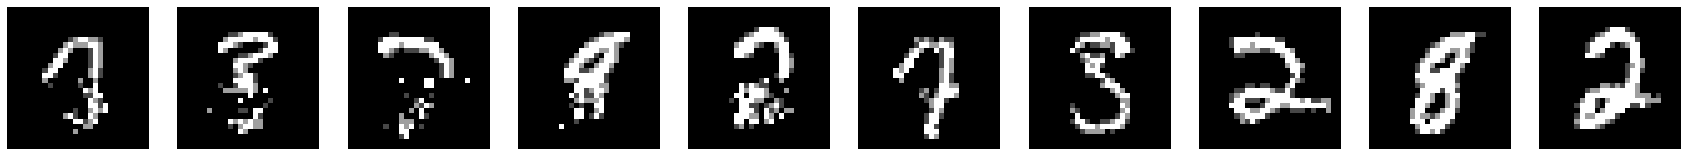

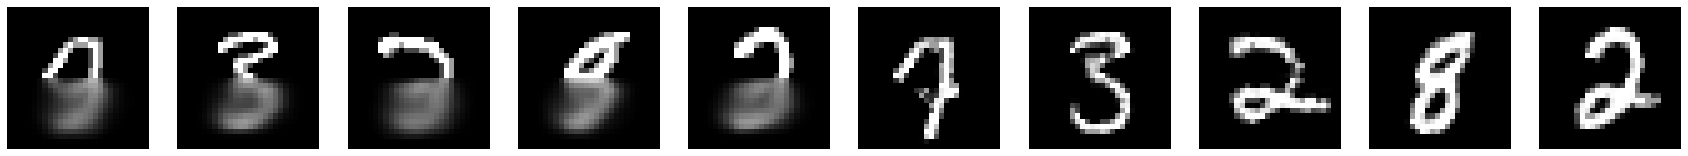

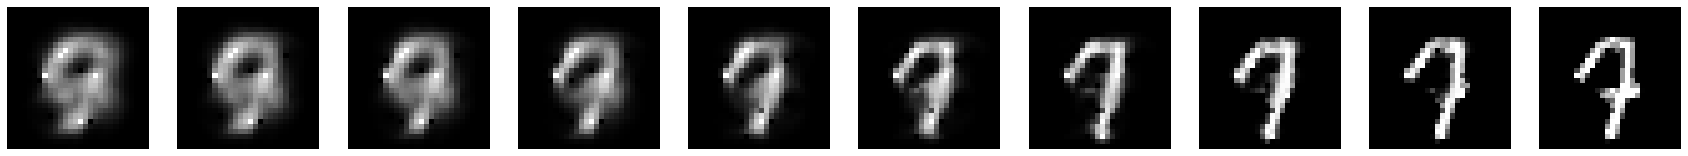

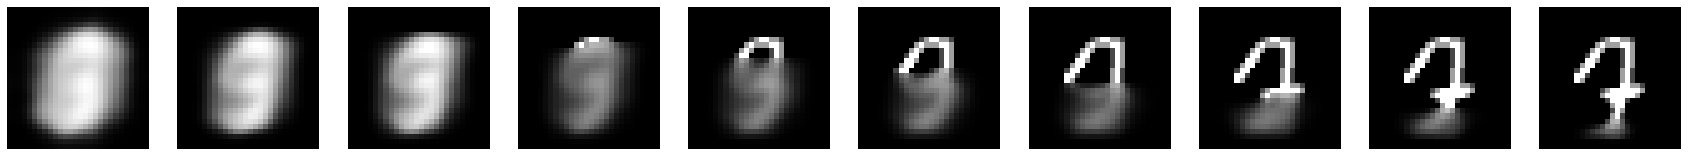

Step 24304, Loss (last minibatch): 0.19573597609996796, Loss (500 step avg.): 0.23559079314777237


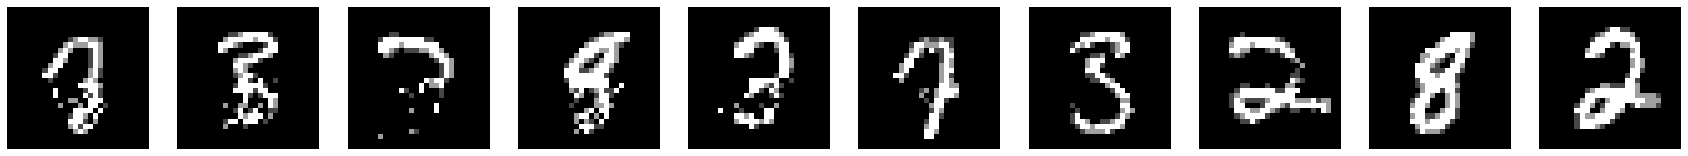

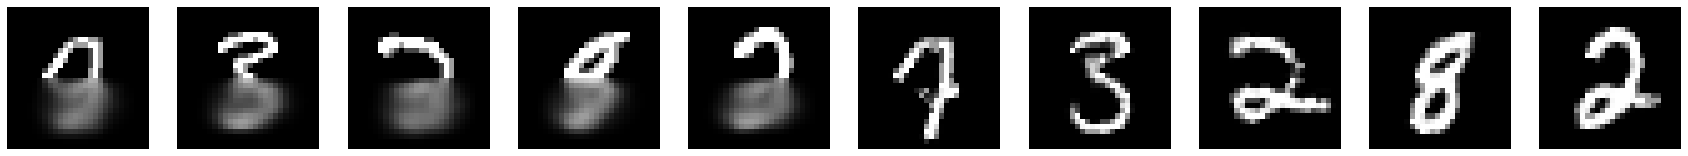

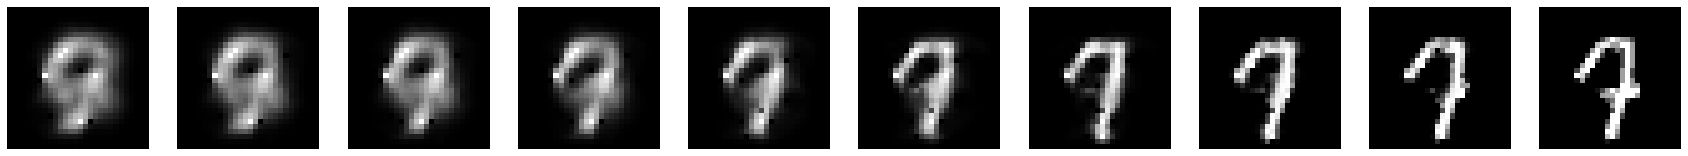

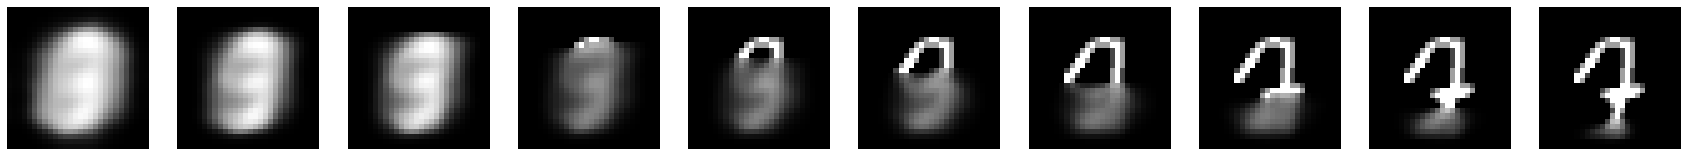

Step 25304, Loss (last minibatch): 0.30742529034614563, Loss (500 step avg.): 0.23498441302728748


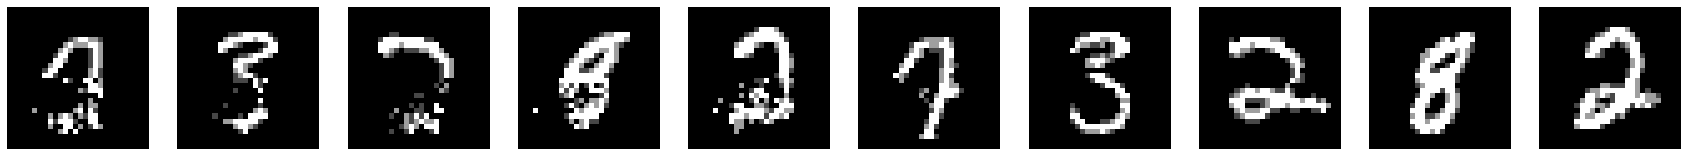

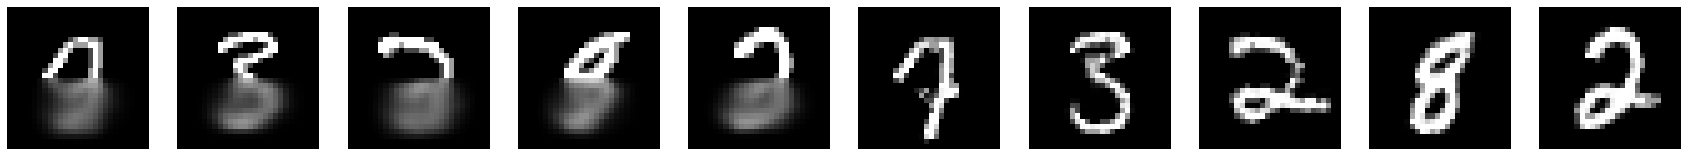

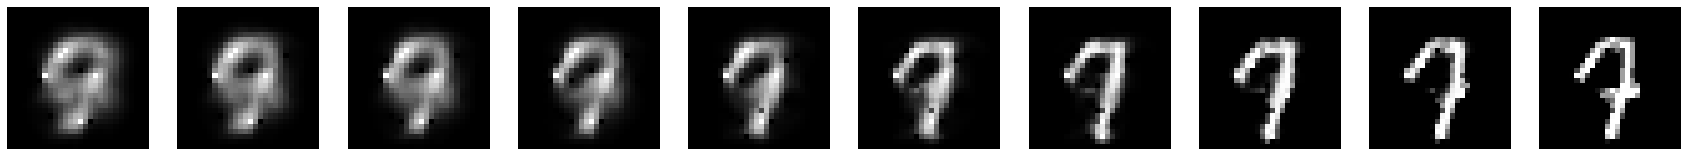

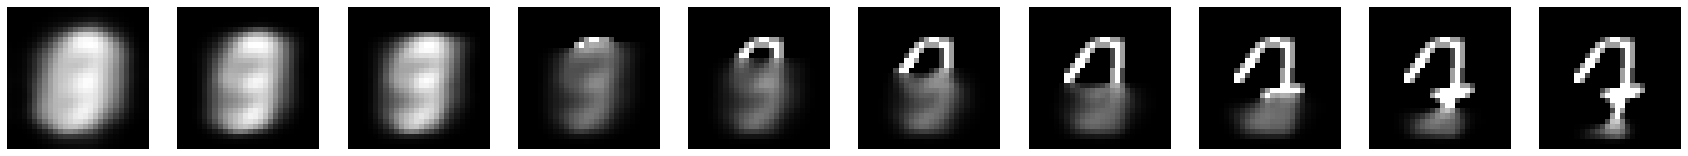

Step 26304, Loss (last minibatch): 0.1894339770078659, Loss (500 step avg.): 0.23537344442394204


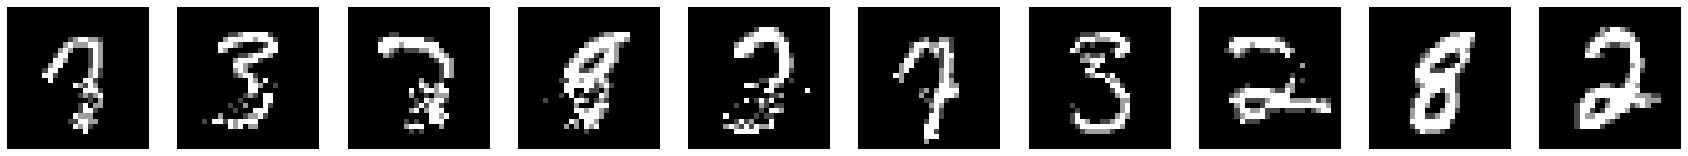

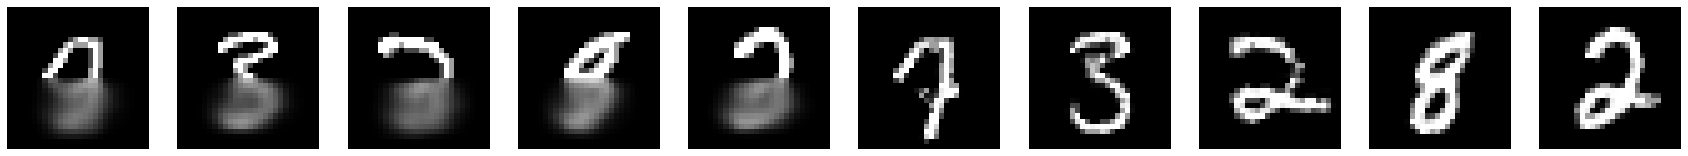

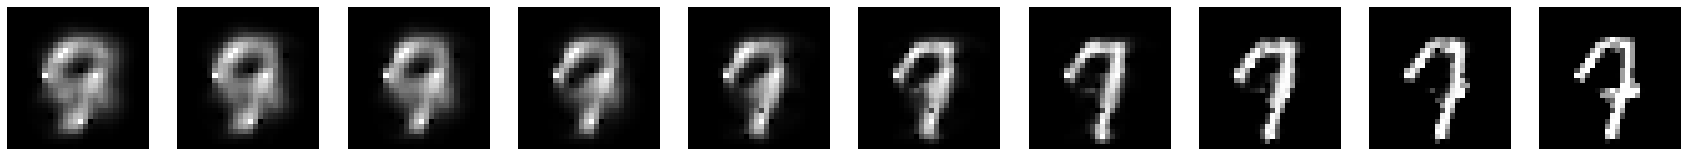

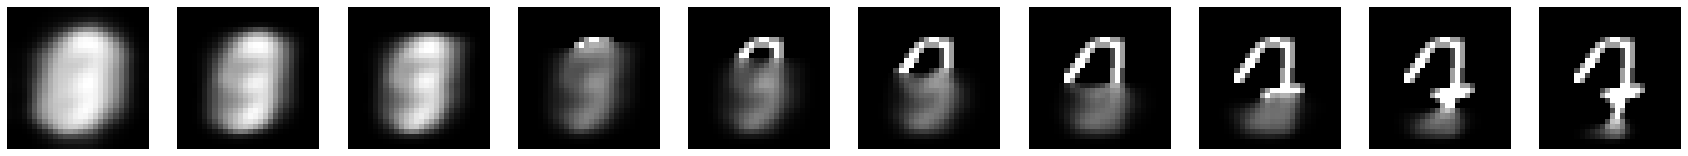

Step 27304, Loss (last minibatch): 0.18733596801757812, Loss (500 step avg.): 0.2297537717931047


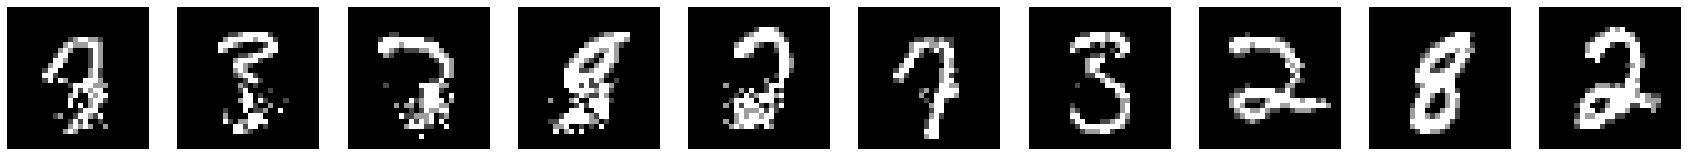

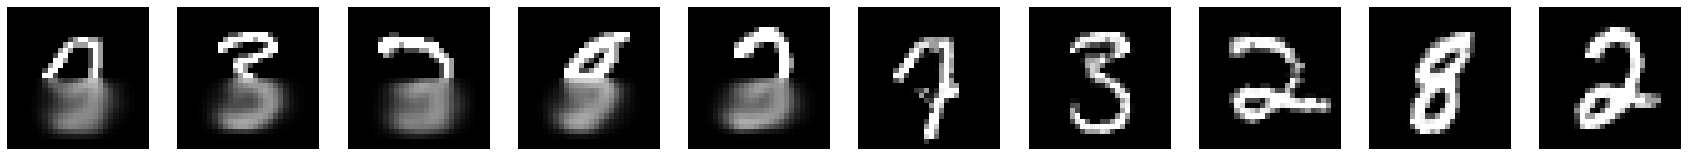

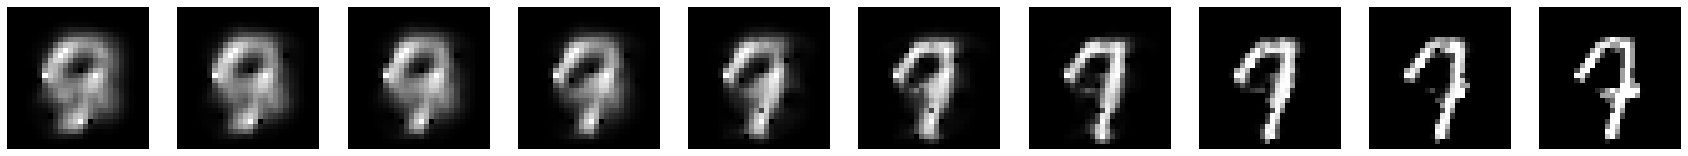

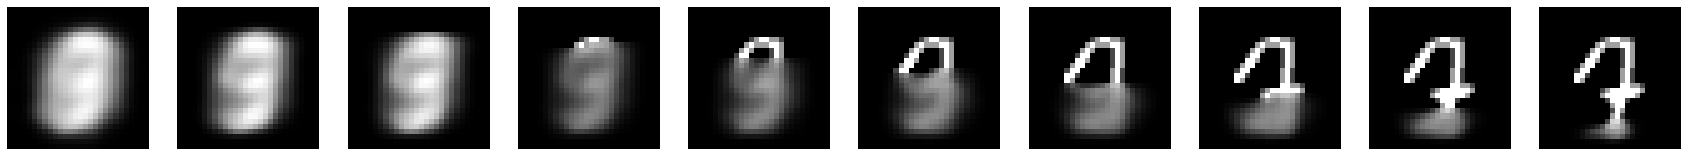

Step 28304, Loss (last minibatch): 0.2008620947599411, Loss (500 step avg.): 0.23010087587281378


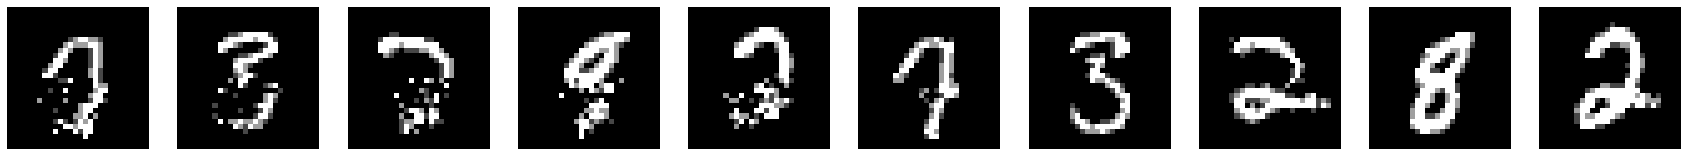

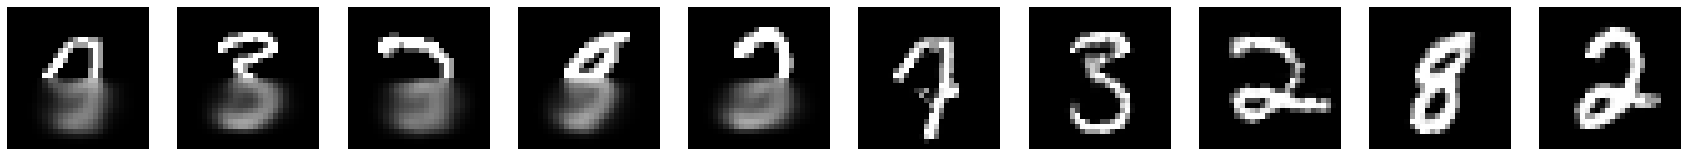

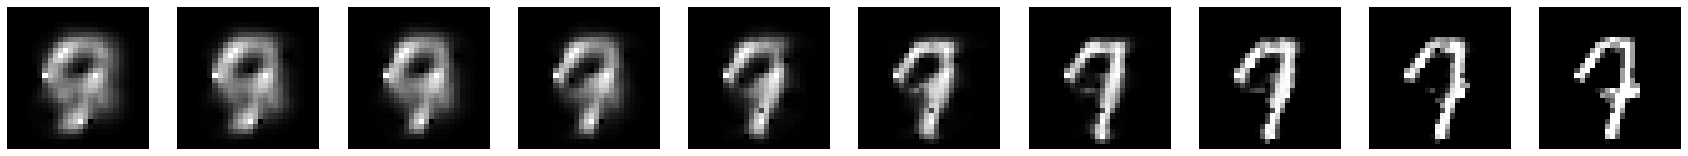

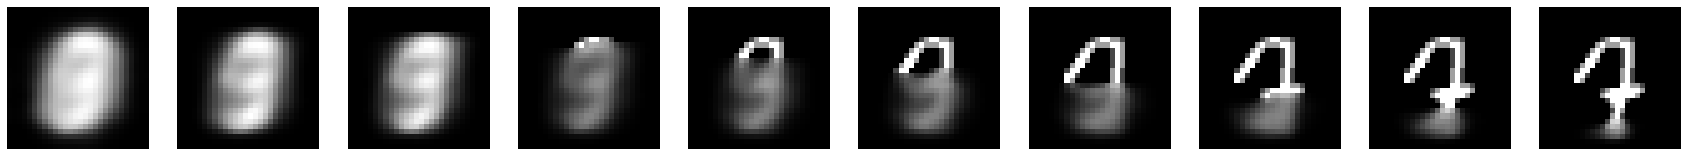

Step 29304, Loss (last minibatch): 0.19899225234985352, Loss (500 step avg.): 0.22712524373552756


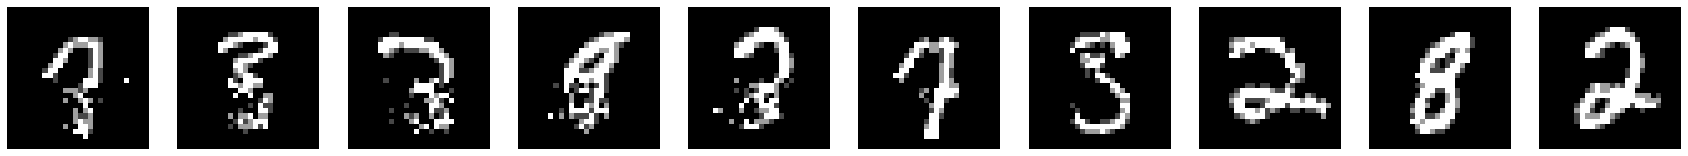

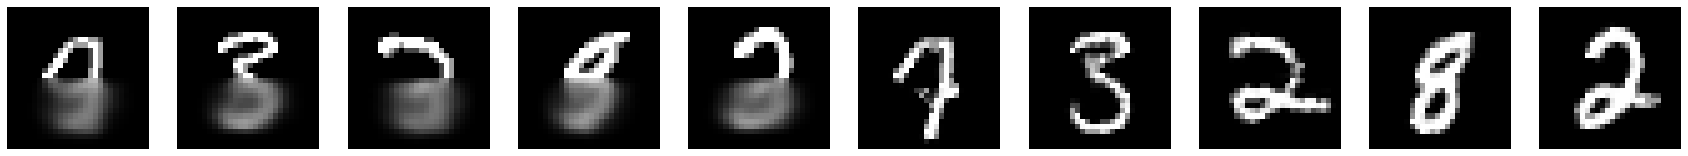

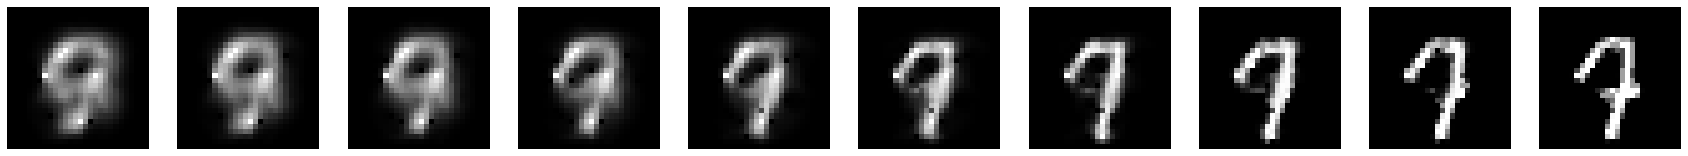

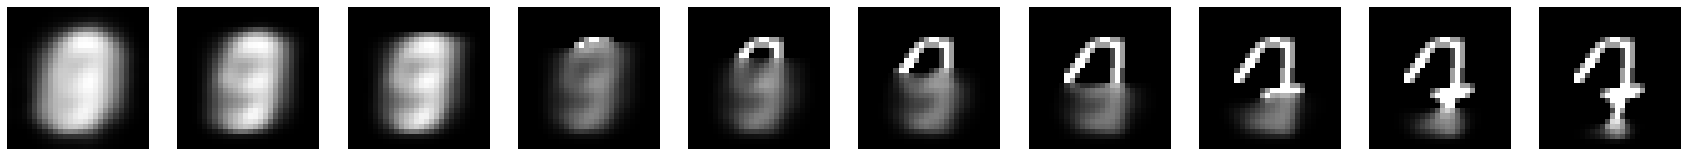

Step 30304, Loss (last minibatch): 0.26840344071388245, Loss (500 step avg.): 0.2283882332776121


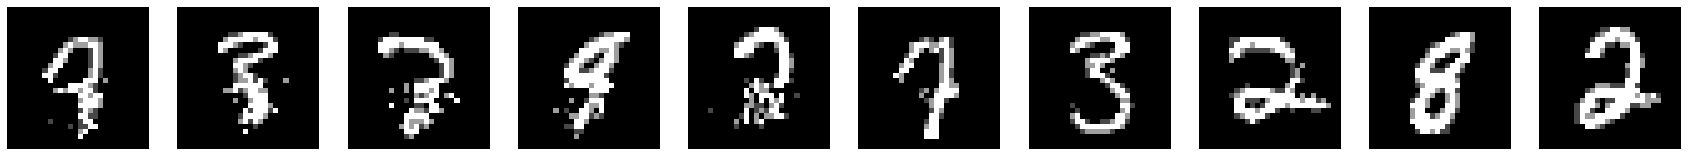

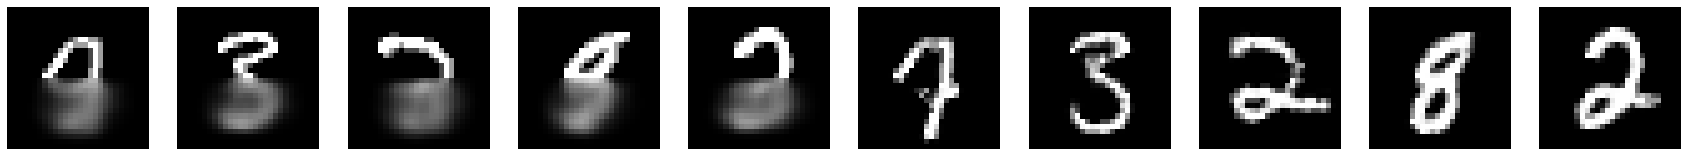

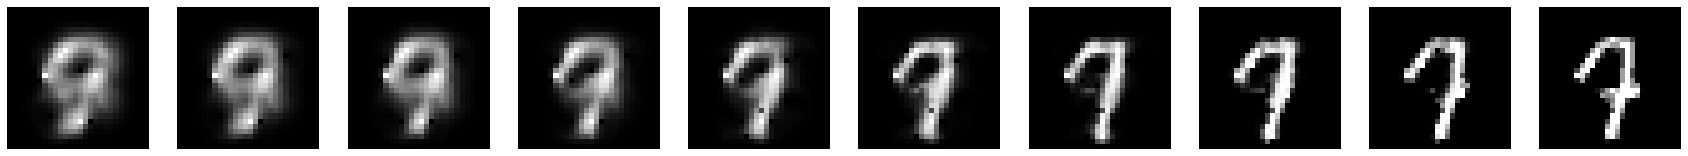

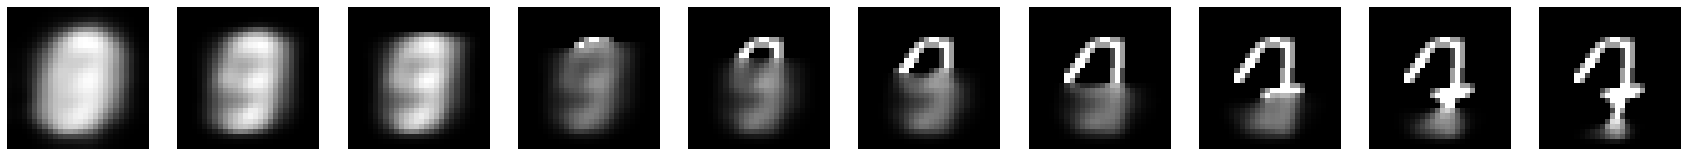

Step 31304, Loss (last minibatch): 0.2982555627822876, Loss (500 step avg.): 0.22738296468695718


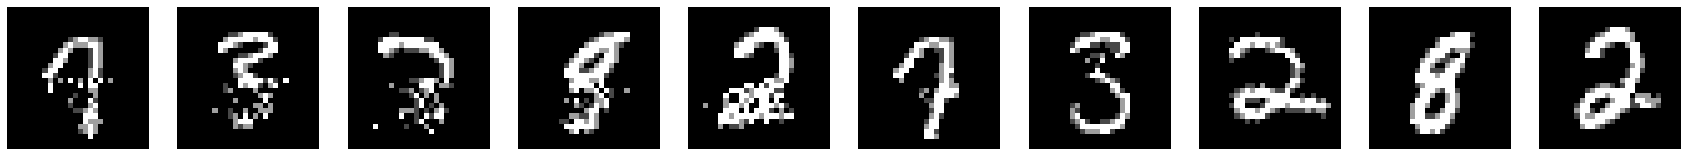

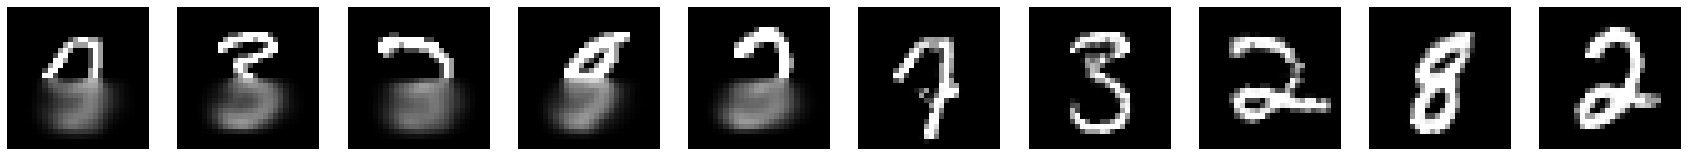

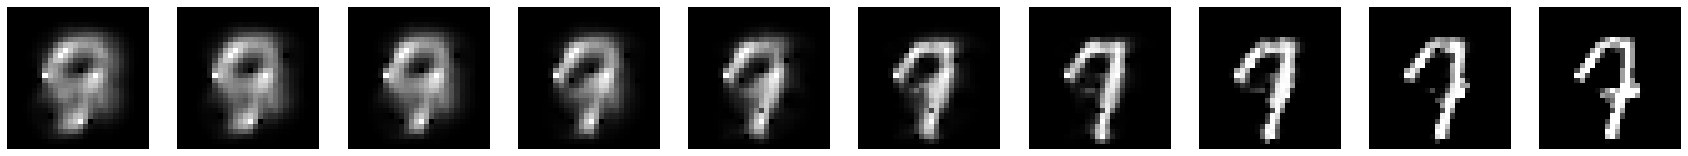

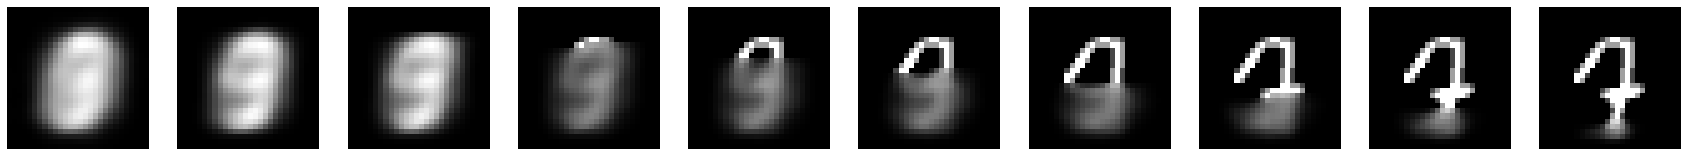

Step 32304, Loss (last minibatch): 0.21517330408096313, Loss (500 step avg.): 0.2275056058239794


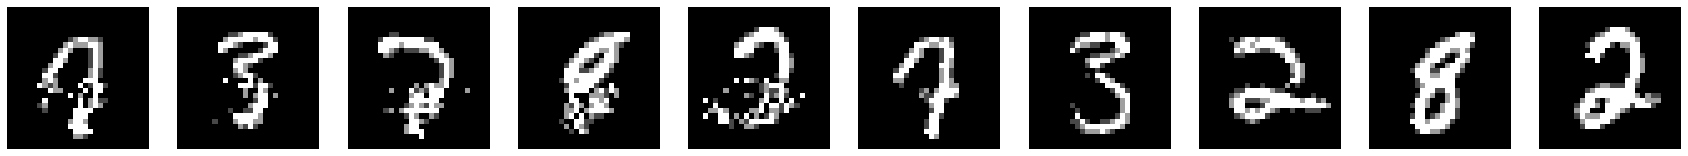

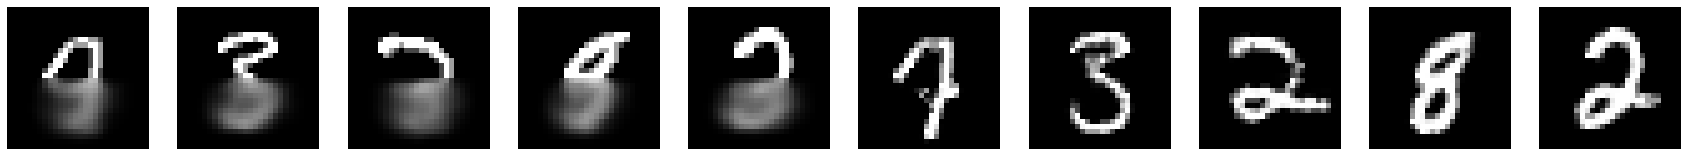

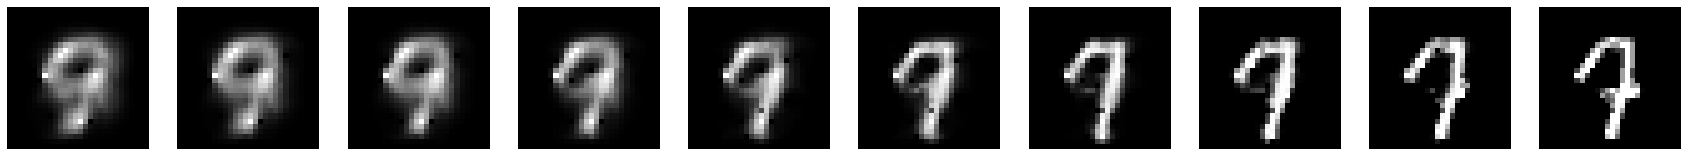

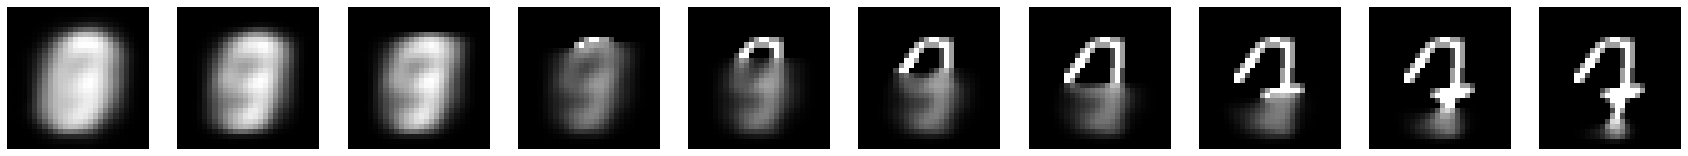

Step 33304, Loss (last minibatch): 0.29104262590408325, Loss (500 step avg.): 0.223503867220022


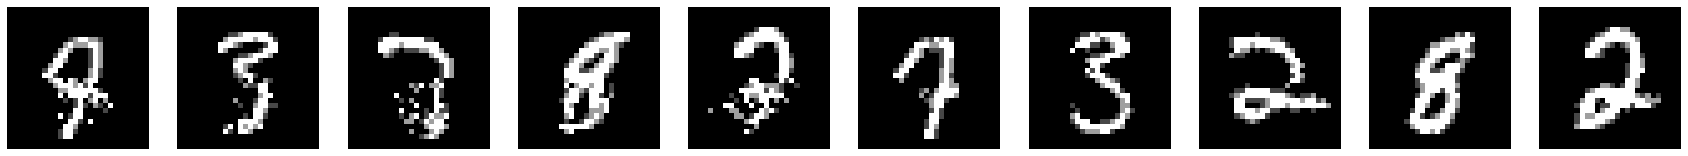

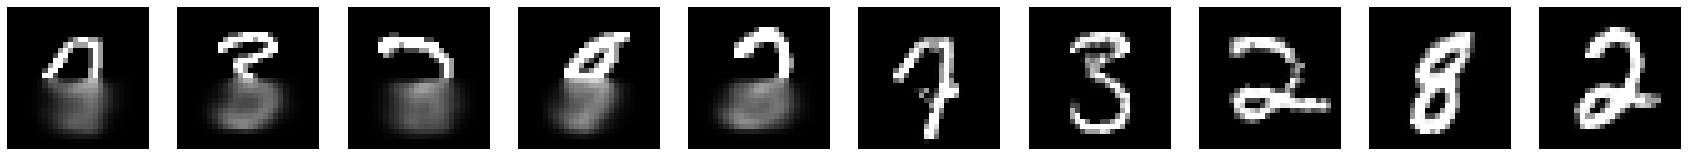

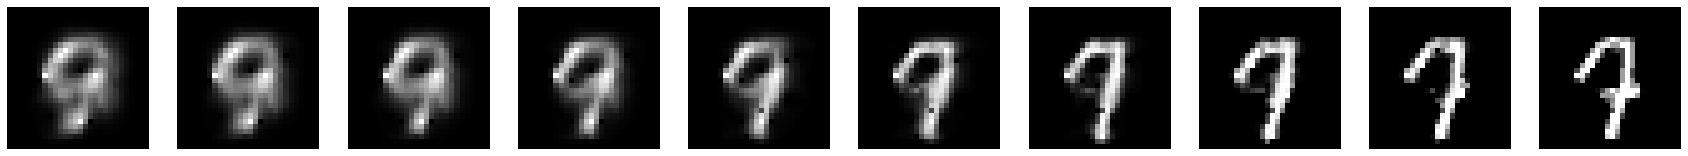

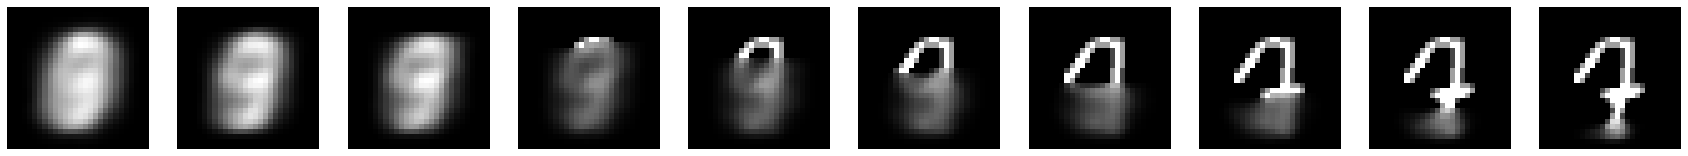

Step 34304, Loss (last minibatch): 0.18600419163703918, Loss (500 step avg.): 0.2252303982328274


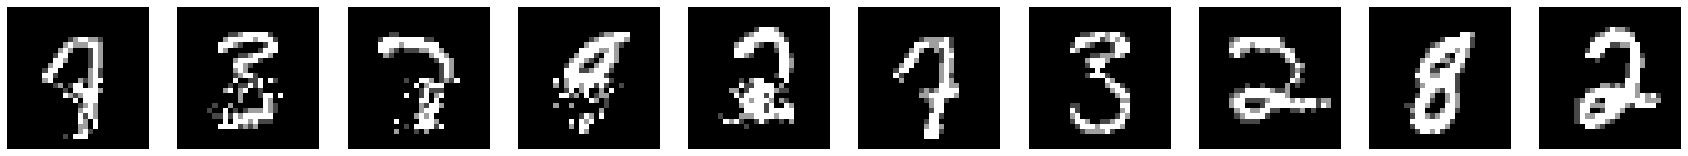

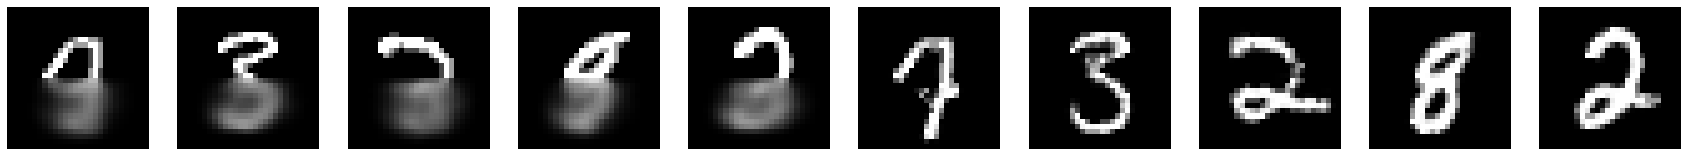

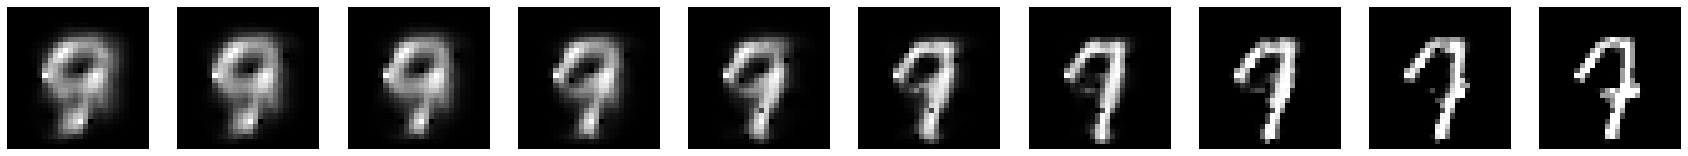

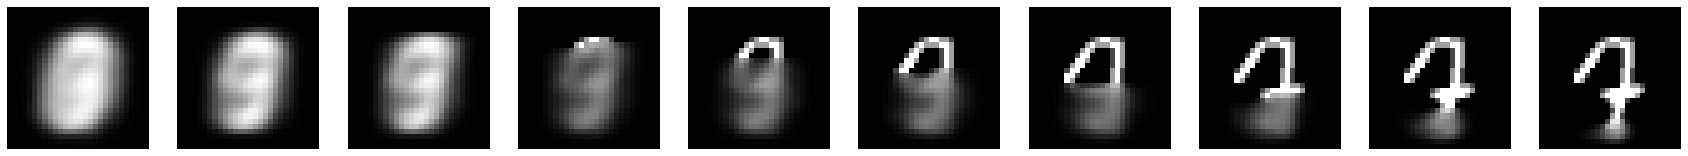

Step 35304, Loss (last minibatch): 0.3049240708351135, Loss (500 step avg.): 0.22477845234904223


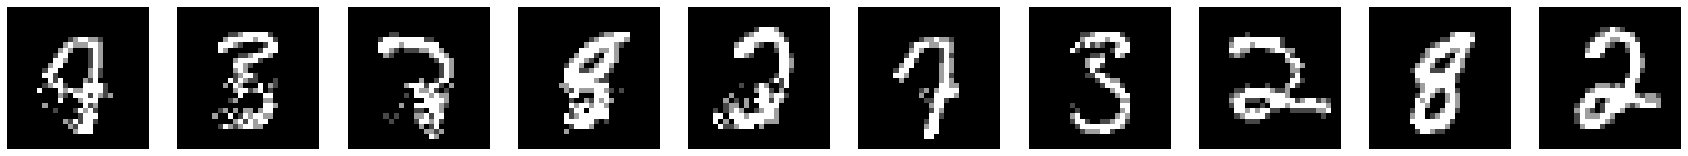

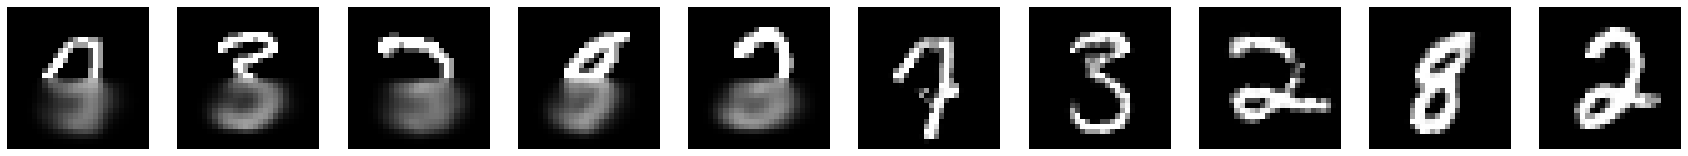

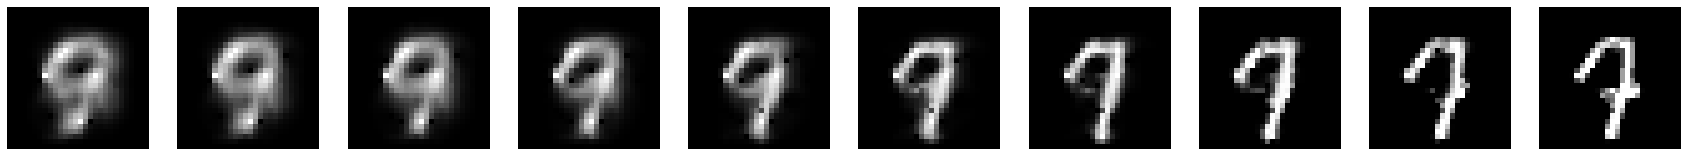

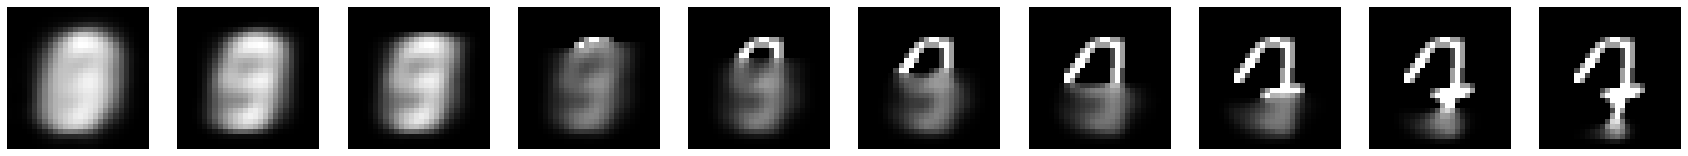

Step 36304, Loss (last minibatch): 0.25411921739578247, Loss (500 step avg.): 0.22543928291864263


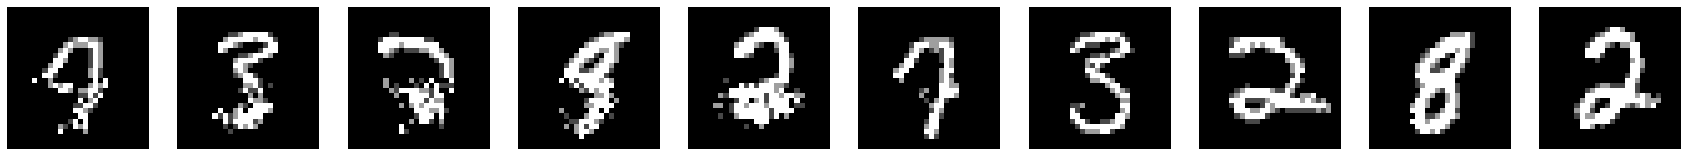

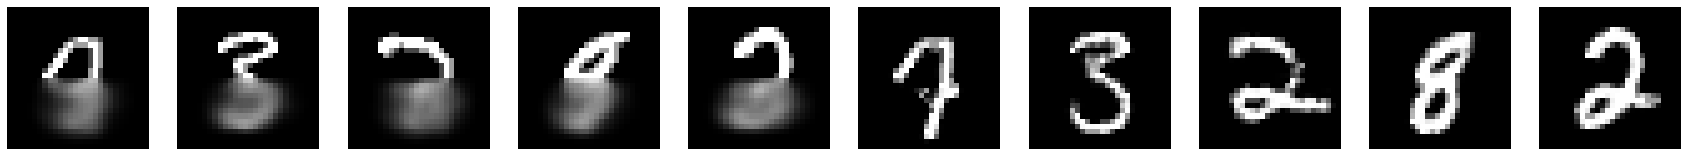

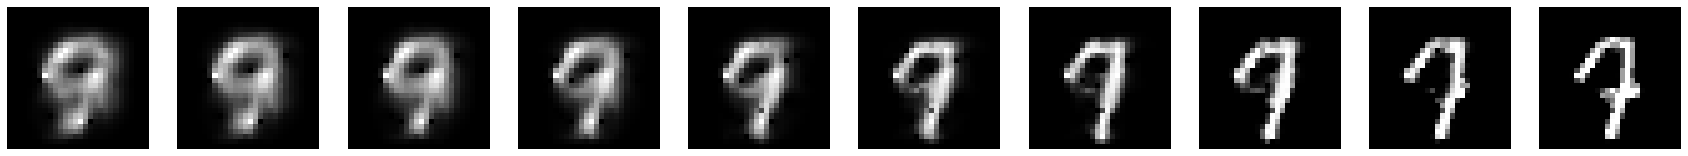

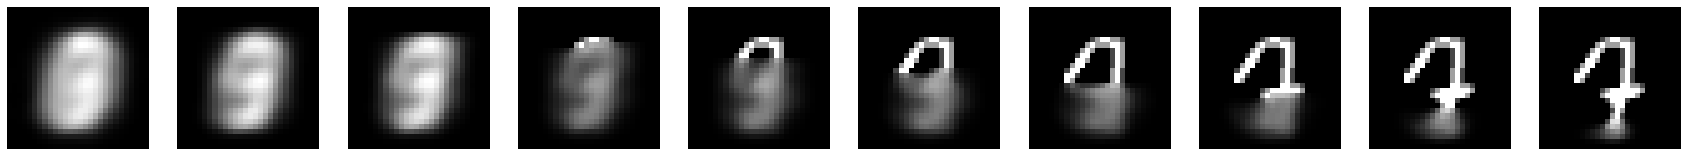

Step 37304, Loss (last minibatch): 0.3026118576526642, Loss (500 step avg.): 0.22222863762321587


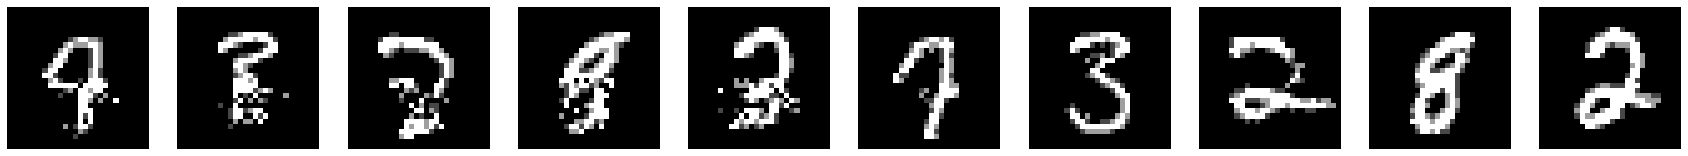

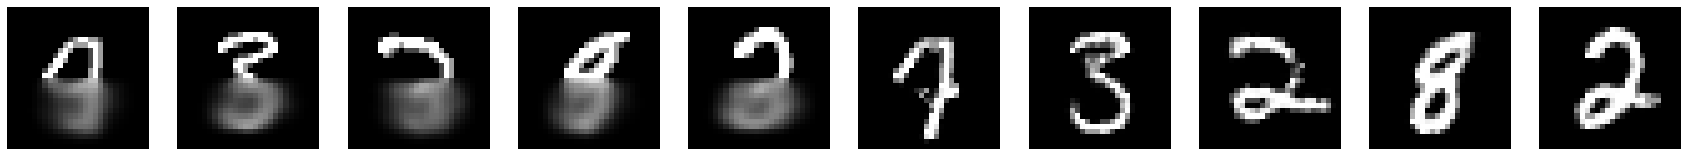

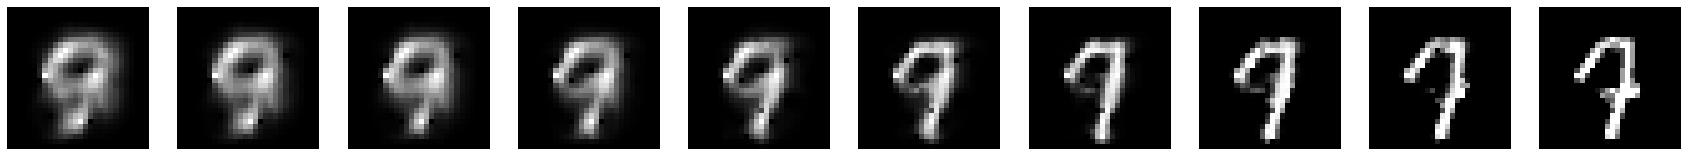

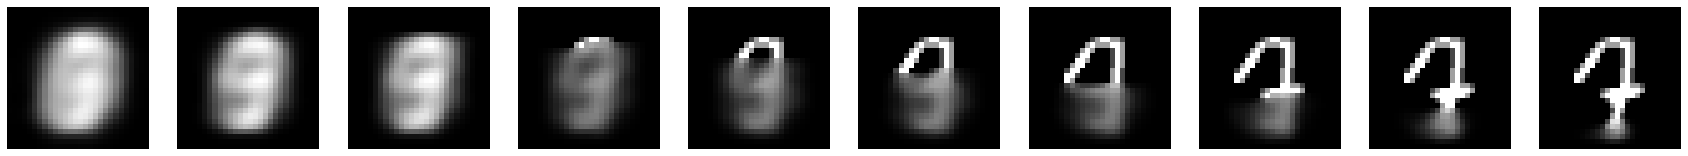

Step 38304, Loss (last minibatch): 0.19618819653987885, Loss (500 step avg.): 0.22032282505920547


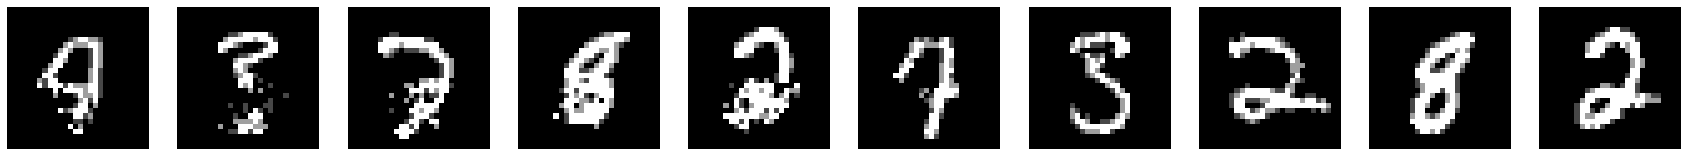

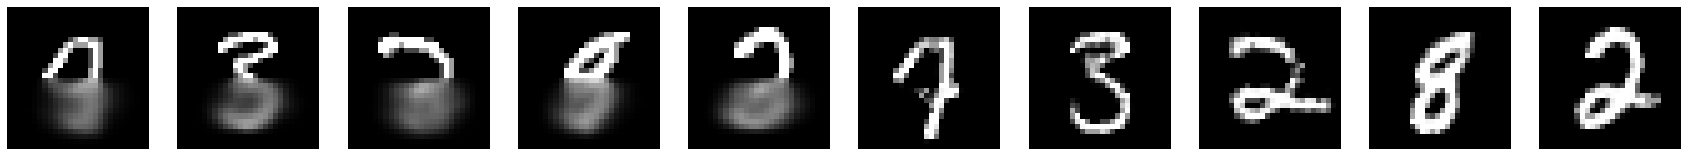

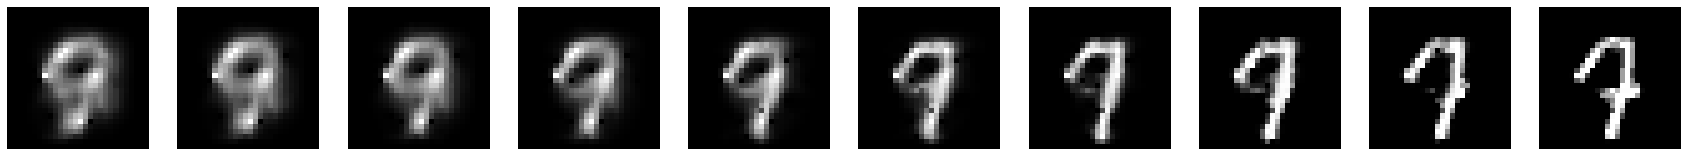

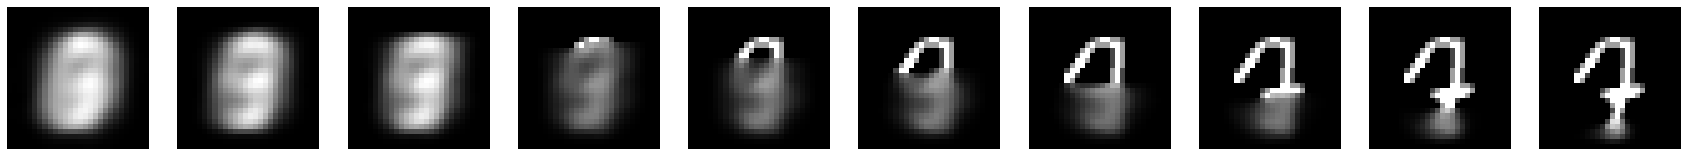

Step 39304, Loss (last minibatch): 0.23014751076698303, Loss (500 step avg.): 0.22306804486853396


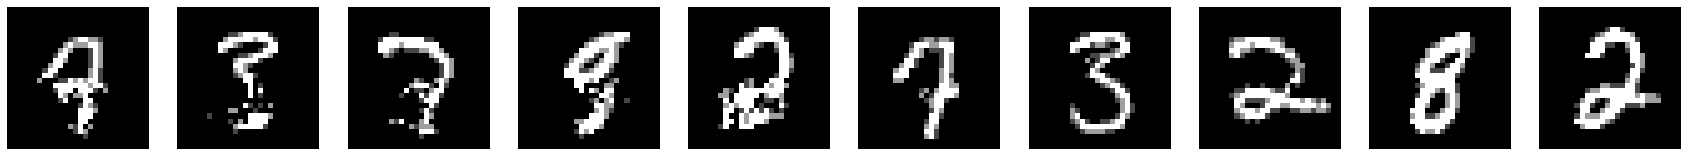

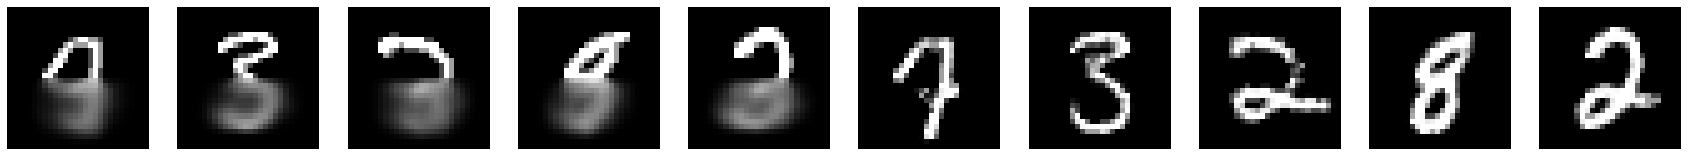

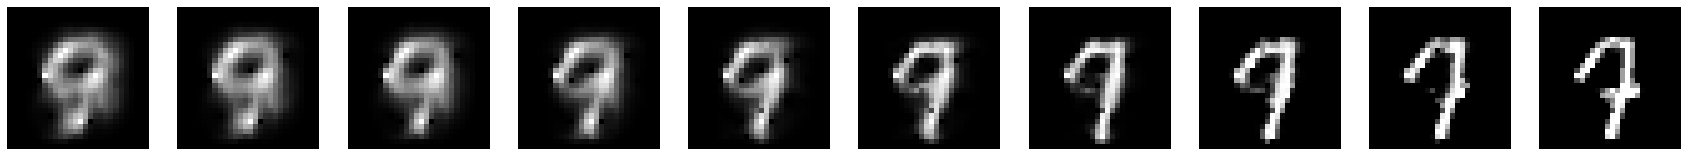

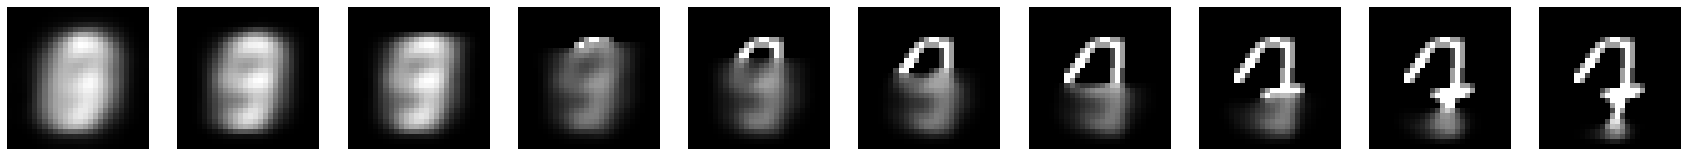

Step 40304, Loss (last minibatch): 0.2575582265853882, Loss (500 step avg.): 0.21656917451979396


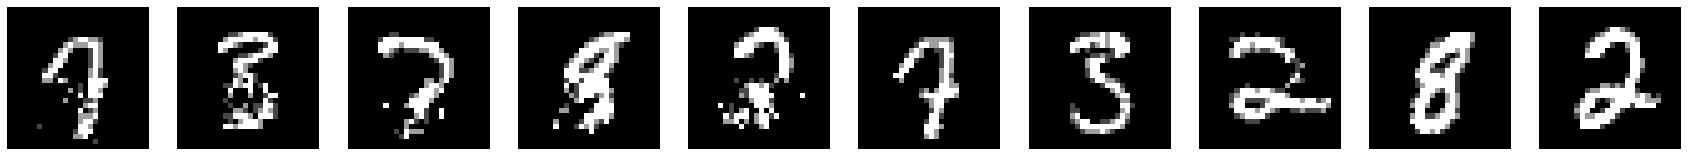

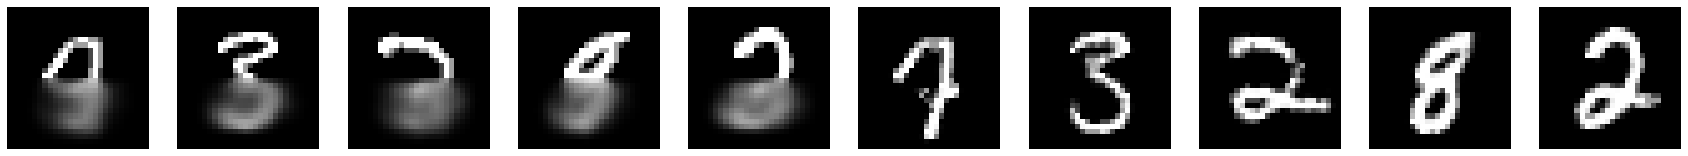

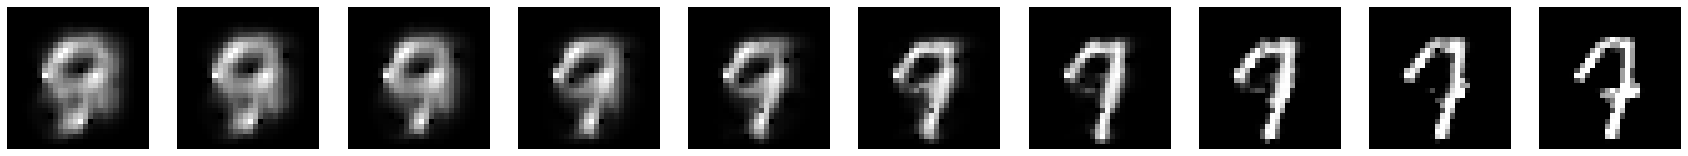

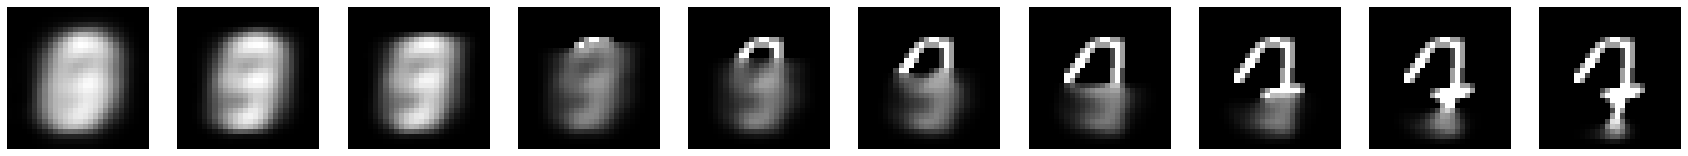

Step 41304, Loss (last minibatch): 0.23477637767791748, Loss (500 step avg.): 0.21740861460120378


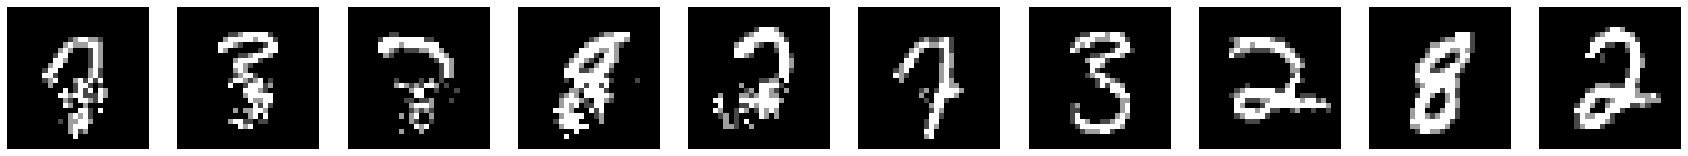

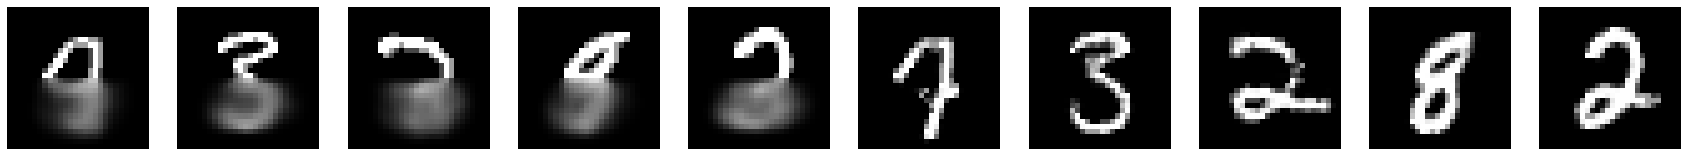

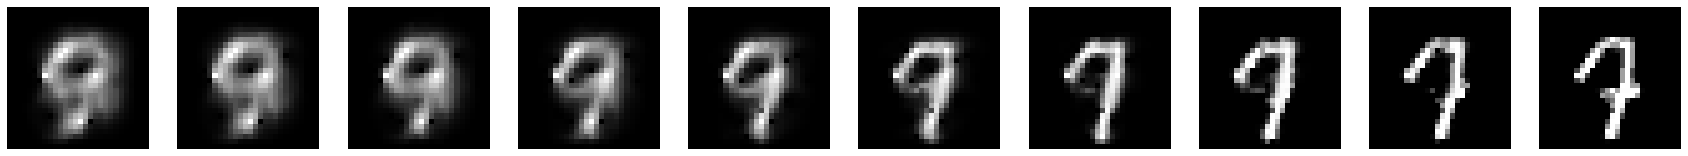

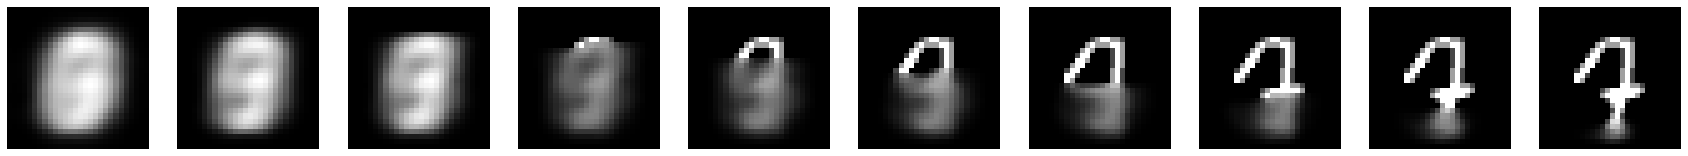

Step 42304, Loss (last minibatch): 0.3086853623390198, Loss (500 step avg.): 0.22042470861099914


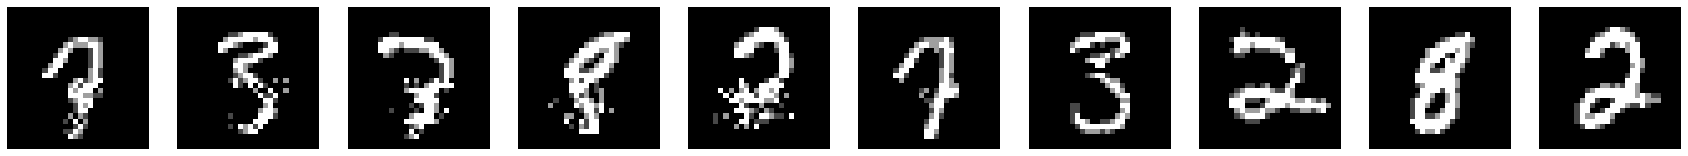

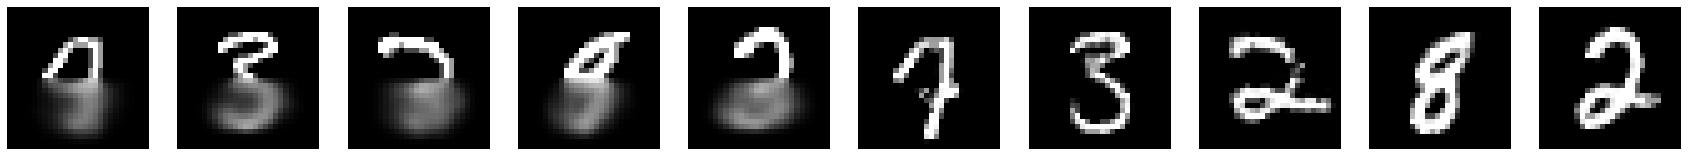

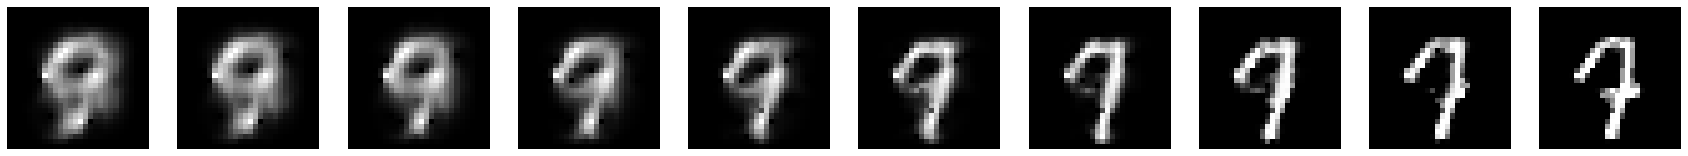

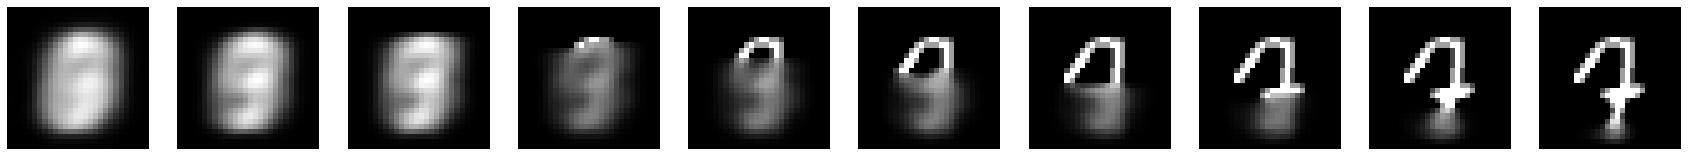

Step 43304, Loss (last minibatch): 0.24812042713165283, Loss (500 step avg.): 0.21817420220779563


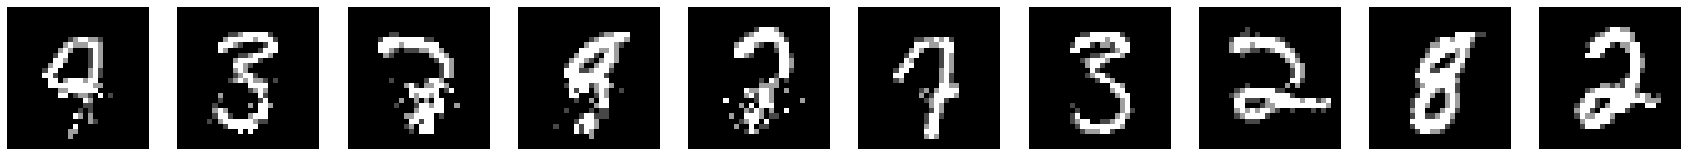

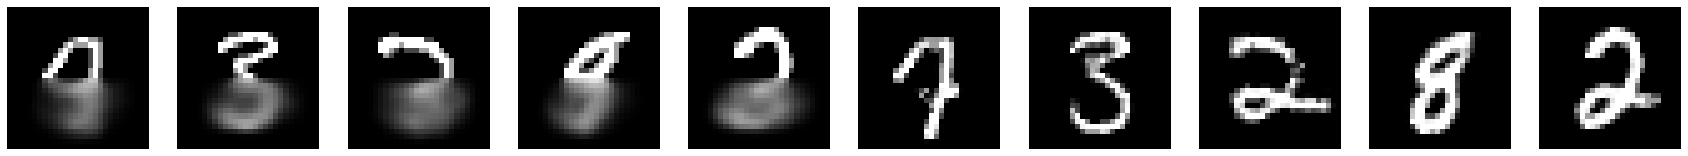

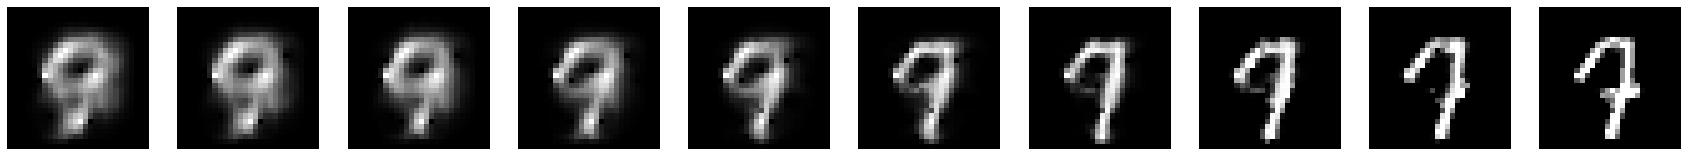

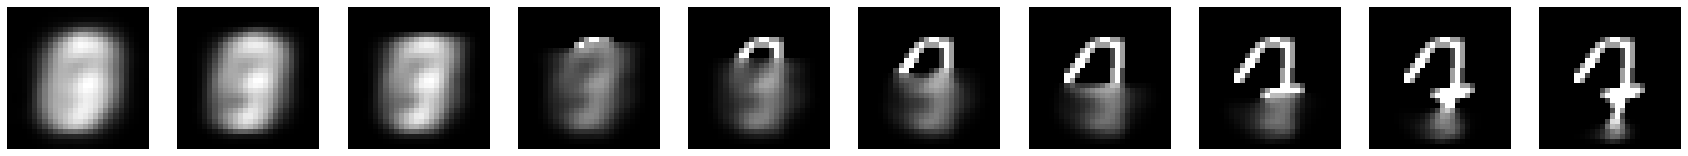

Step 44304, Loss (last minibatch): 0.1971399039030075, Loss (500 step avg.): 0.21572972069719357


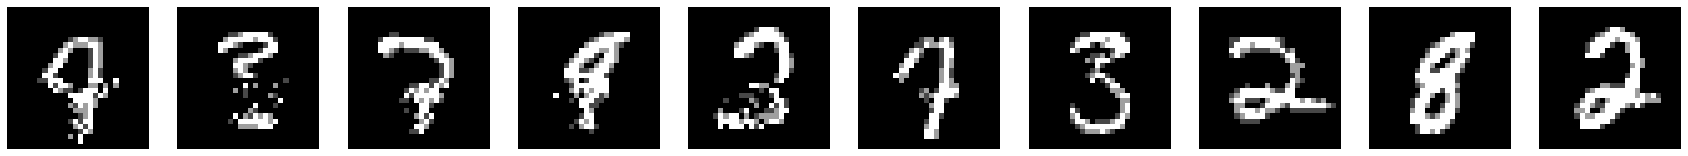

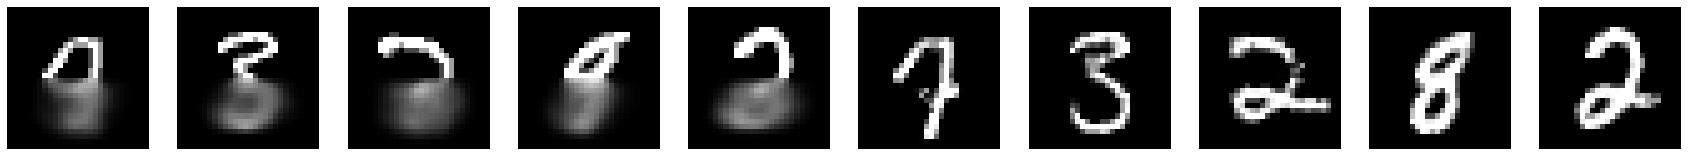

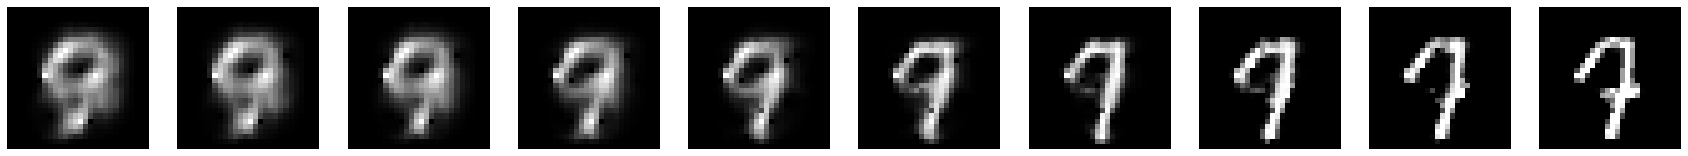

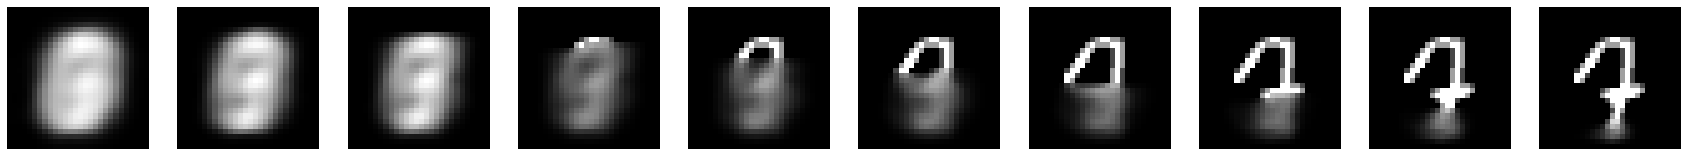

Step 45304, Loss (last minibatch): 0.17328575253486633, Loss (500 step avg.): 0.21715373481937988


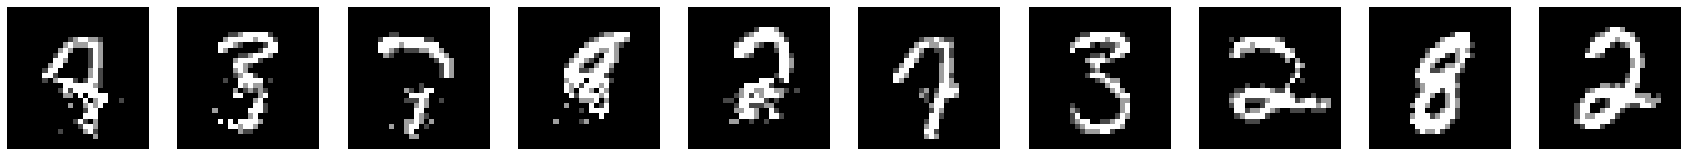

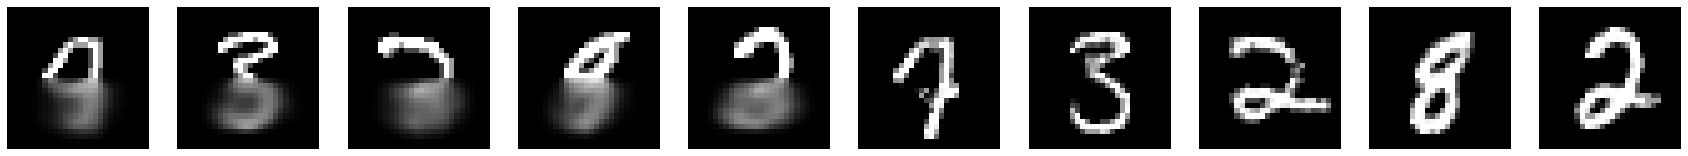

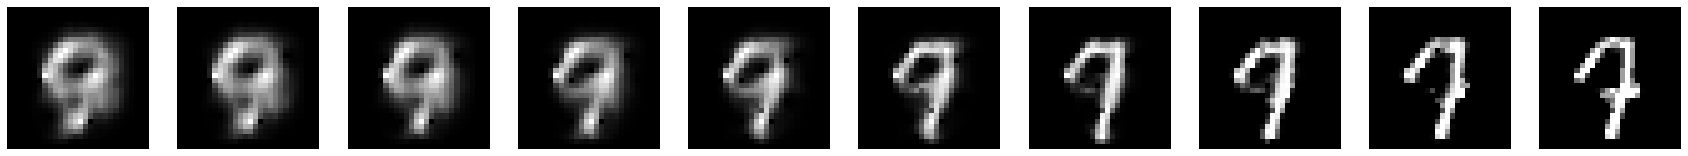

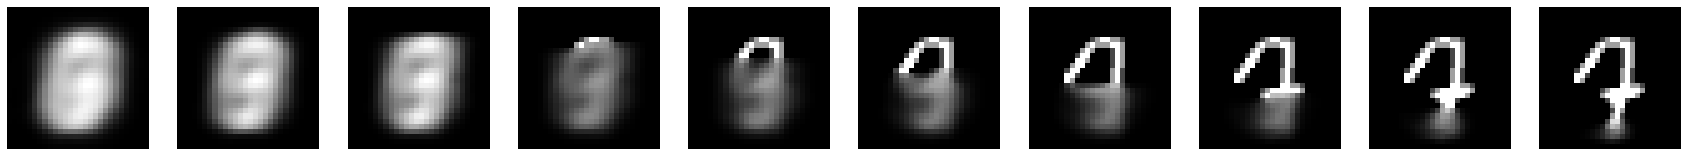

Step 46304, Loss (last minibatch): 0.2550310790538788, Loss (500 step avg.): 0.21314690519354776


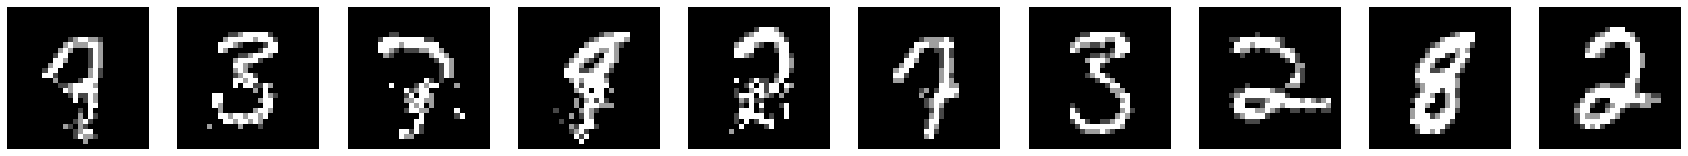

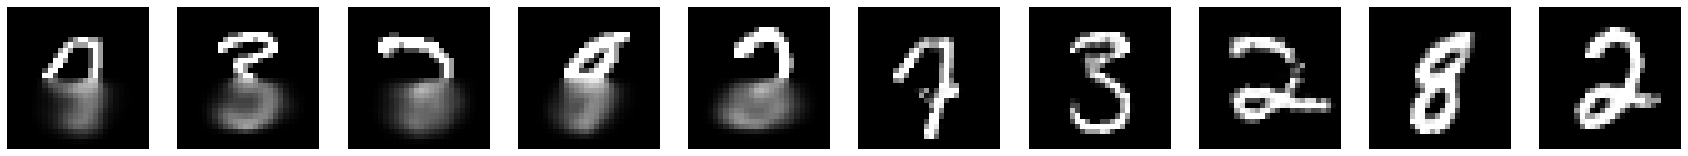

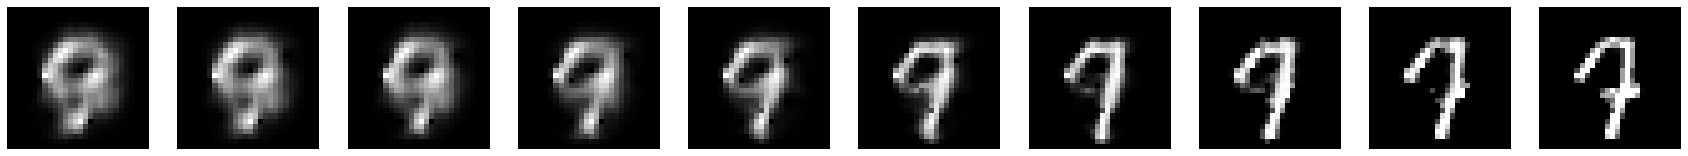

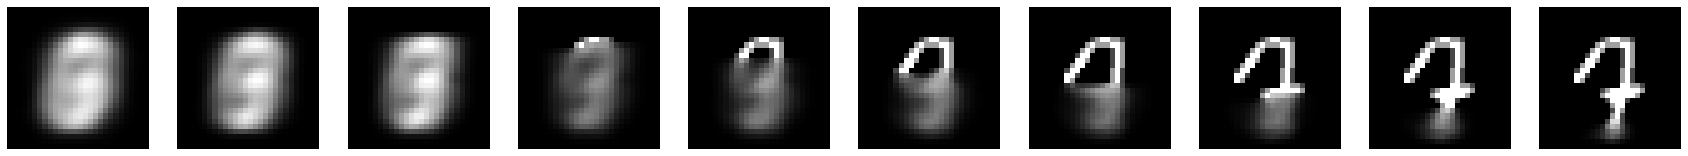

Step 47304, Loss (last minibatch): 0.18143737316131592, Loss (500 step avg.): 0.2164321778539174


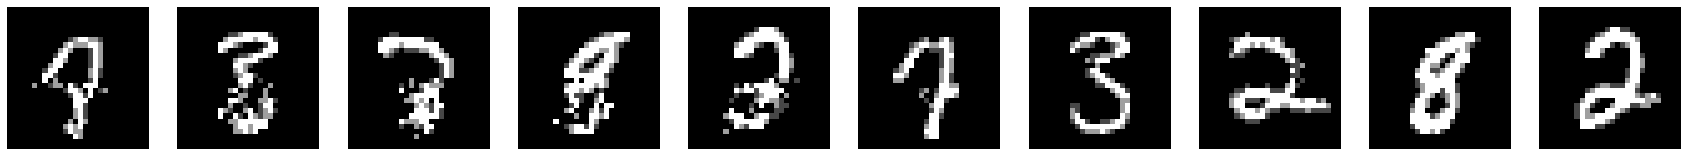

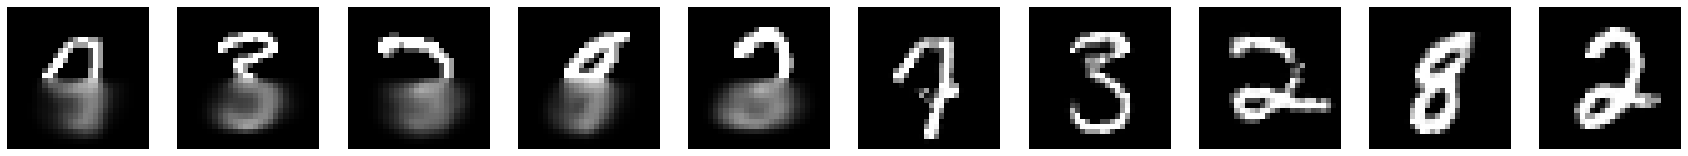

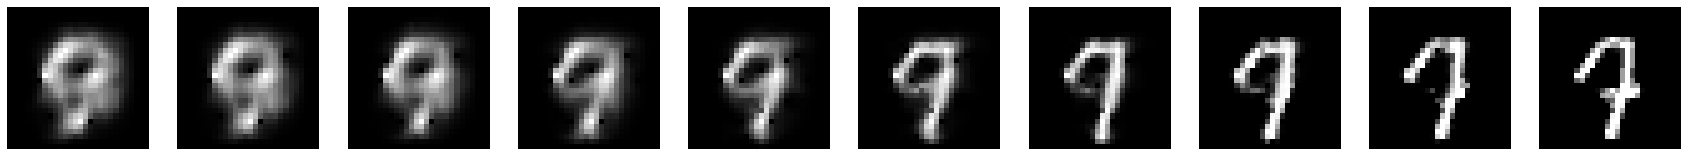

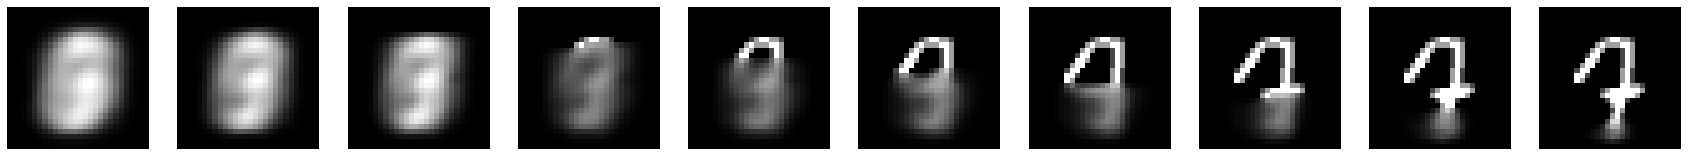

Step 48304, Loss (last minibatch): 0.20191828906536102, Loss (500 step avg.): 0.2146354588919771


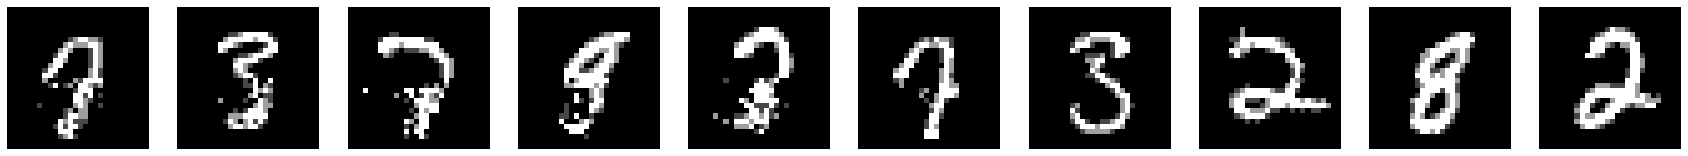

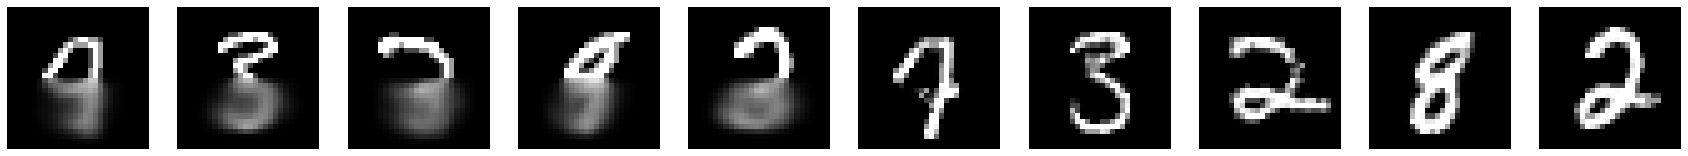

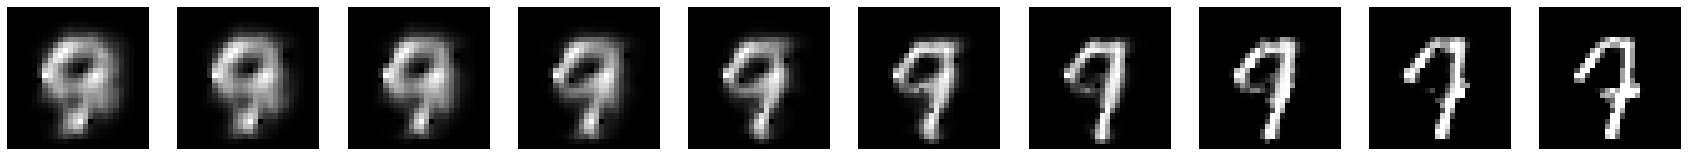

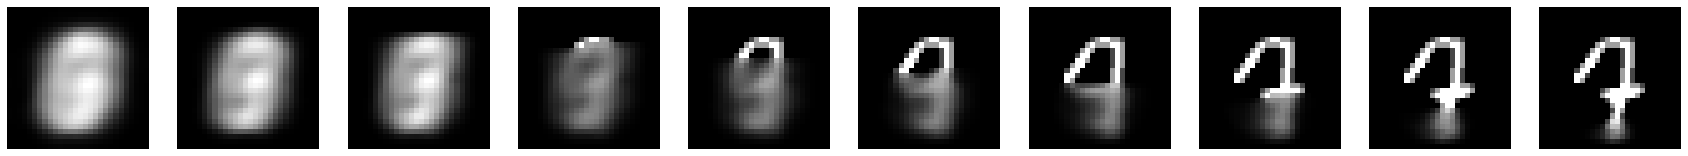

Step 49304, Loss (last minibatch): 0.2471710443496704, Loss (500 step avg.): 0.21416609511225523


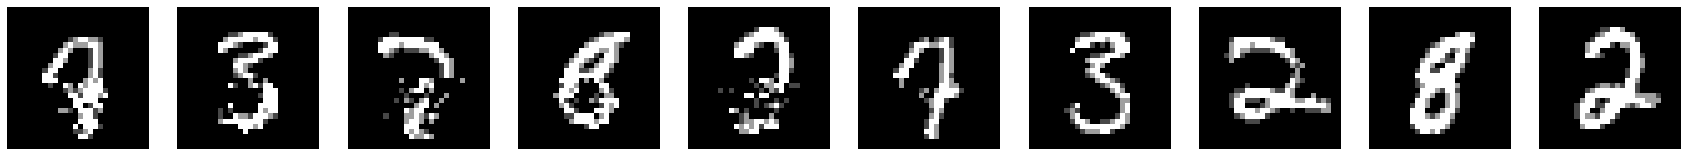

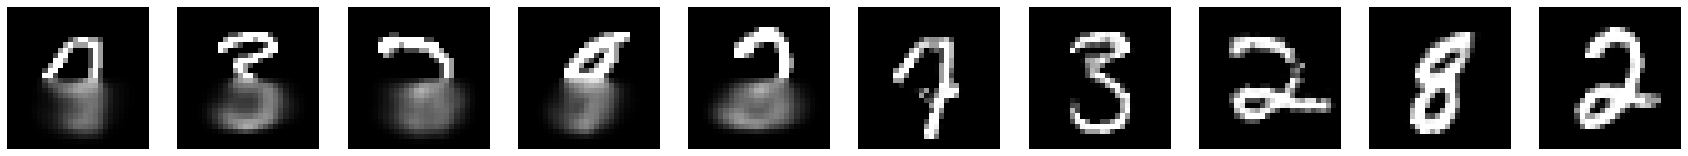

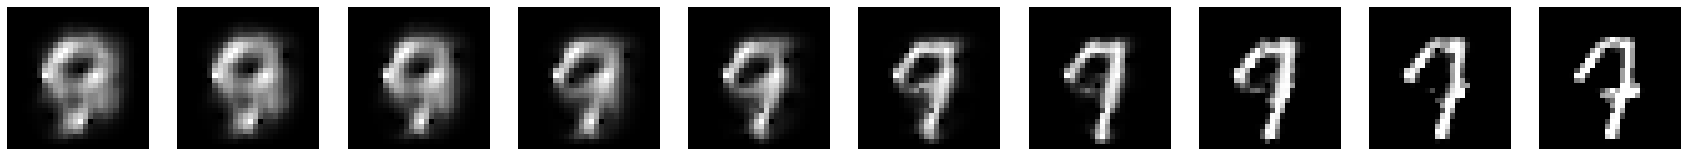

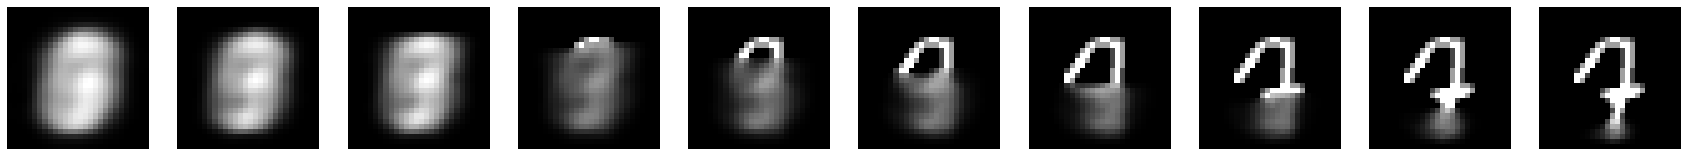

Step 50304, Loss (last minibatch): 0.20234057307243347, Loss (500 step avg.): 0.21361911576427148


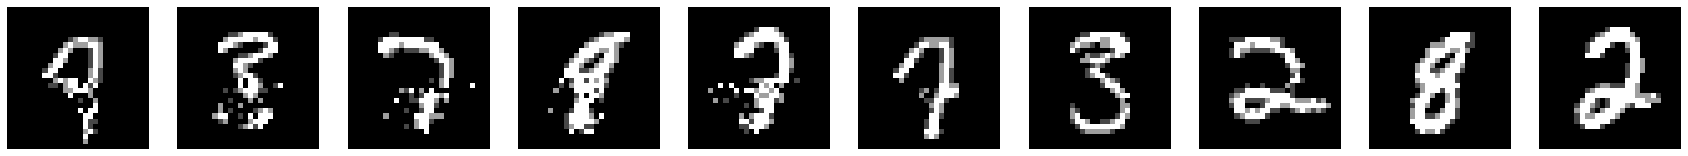

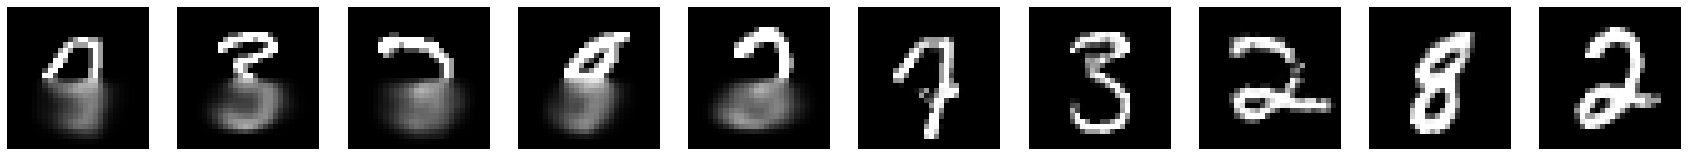

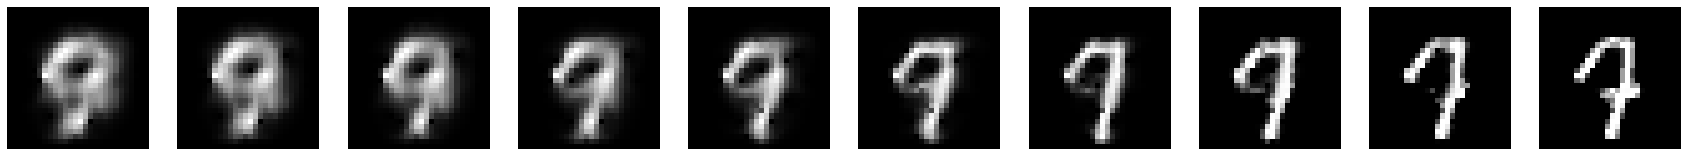

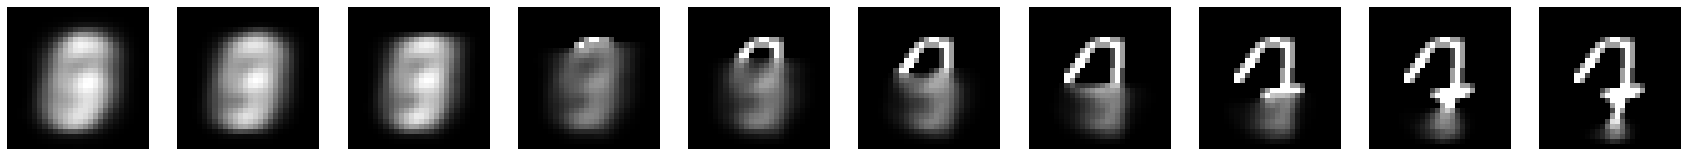

Step 51304, Loss (last minibatch): 0.2085692286491394, Loss (500 step avg.): 0.21167358996982347


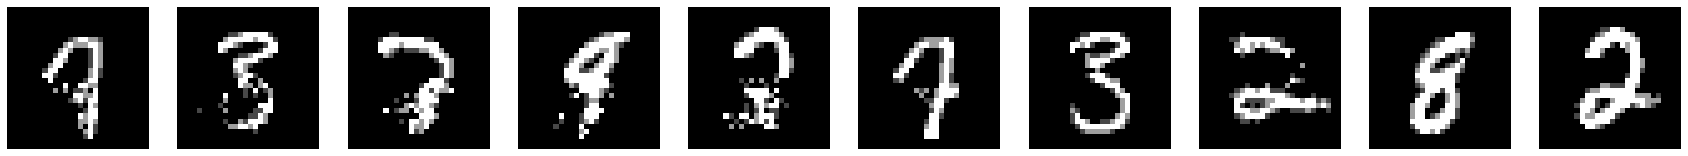

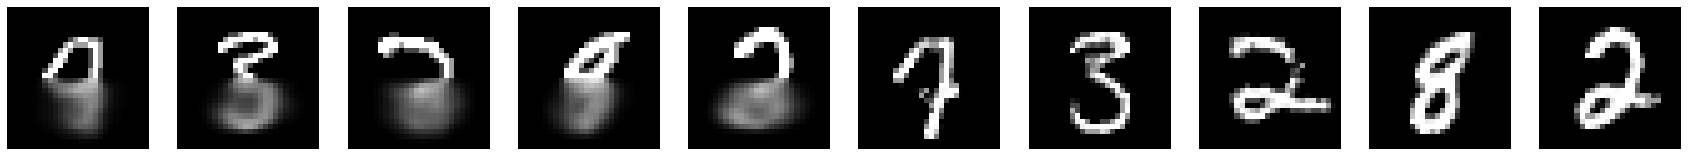

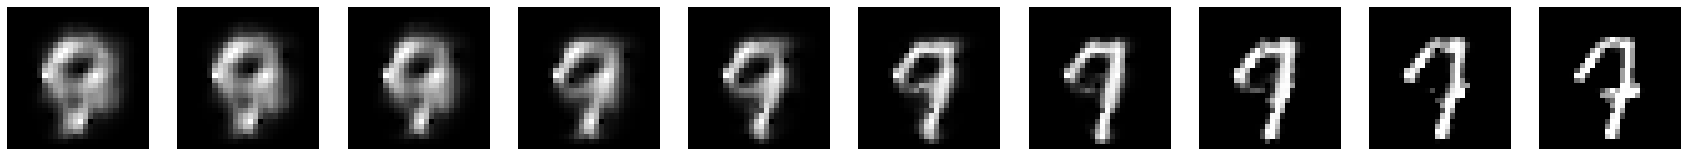

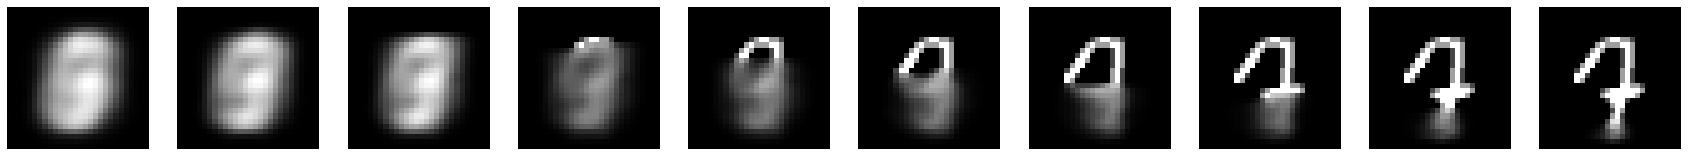

Step 52304, Loss (last minibatch): 0.297390341758728, Loss (500 step avg.): 0.21276193104699223


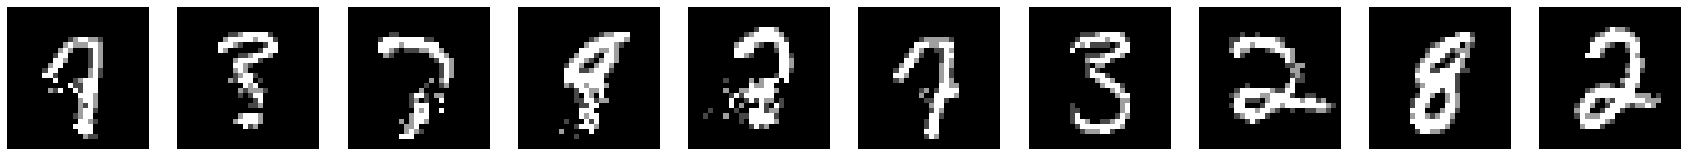

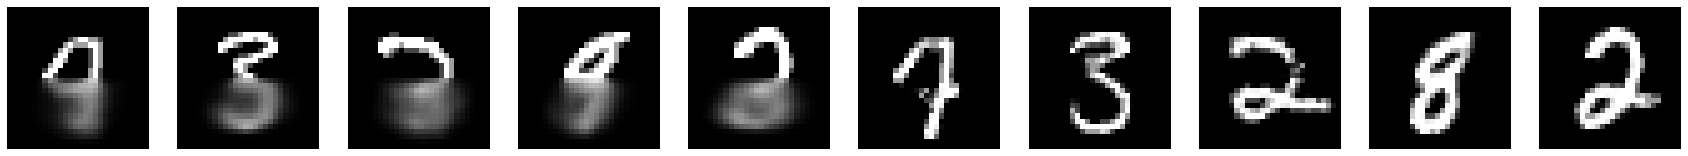

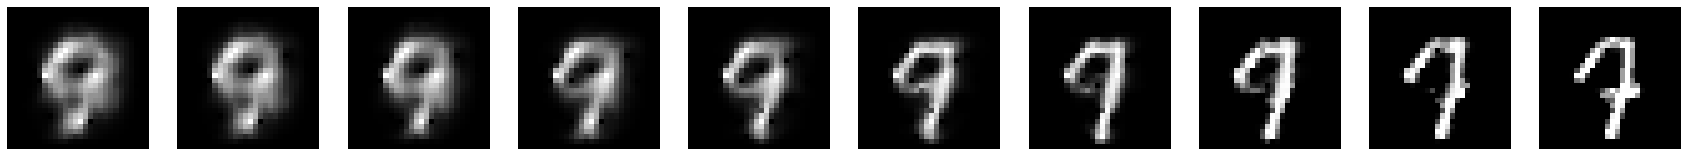

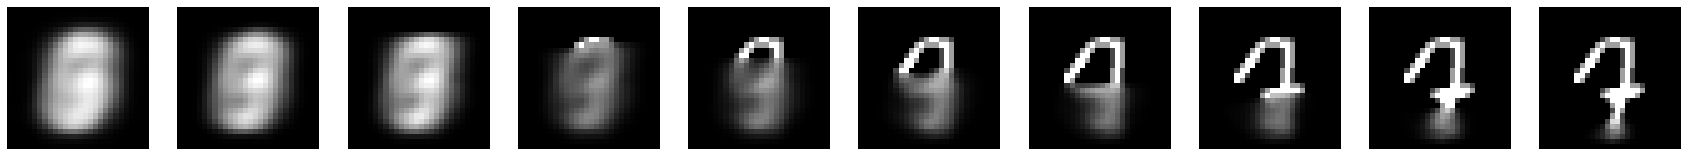

Step 53304, Loss (last minibatch): 0.1803816258907318, Loss (500 step avg.): 0.21005273112160955


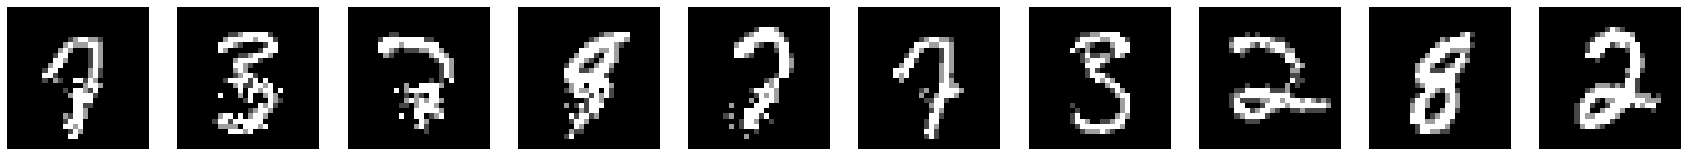

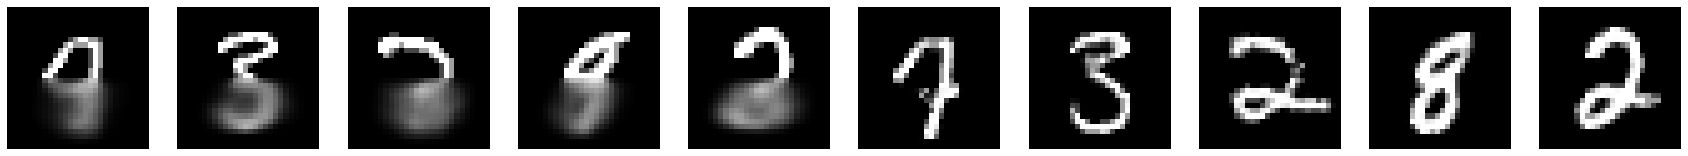

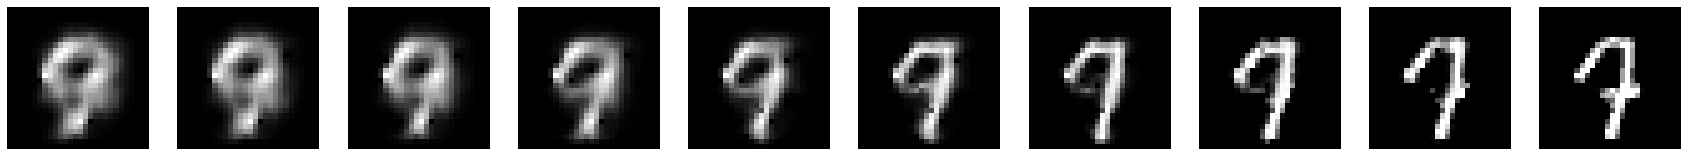

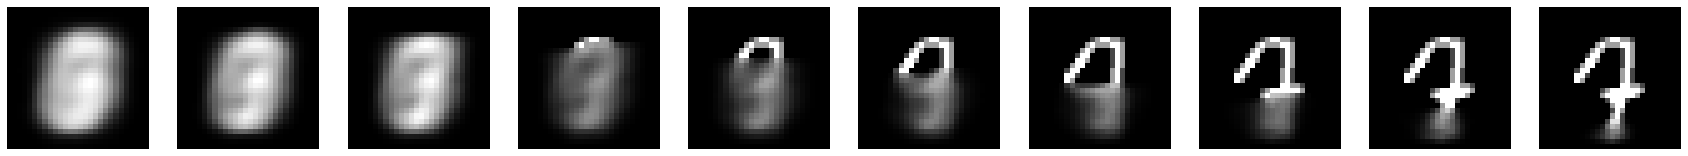

Step 54304, Loss (last minibatch): 0.16392402350902557, Loss (500 step avg.): 0.21198525123610468


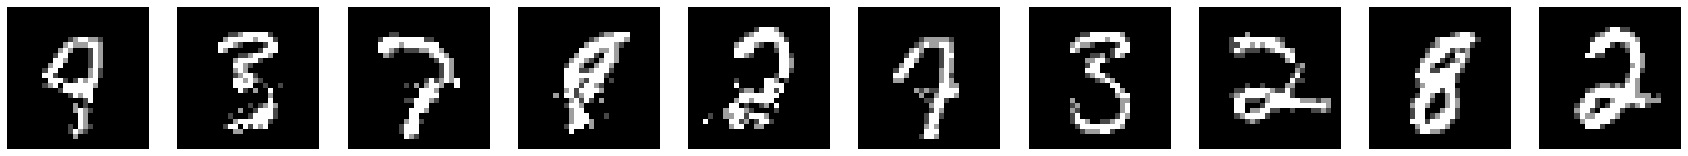

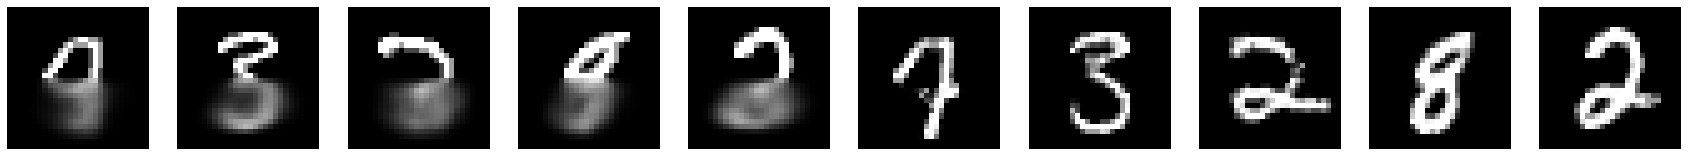

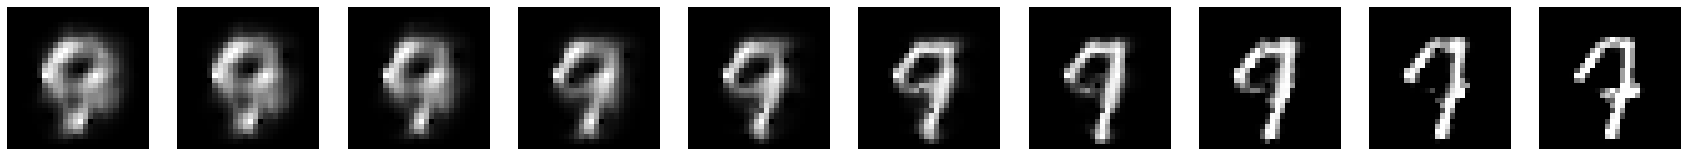

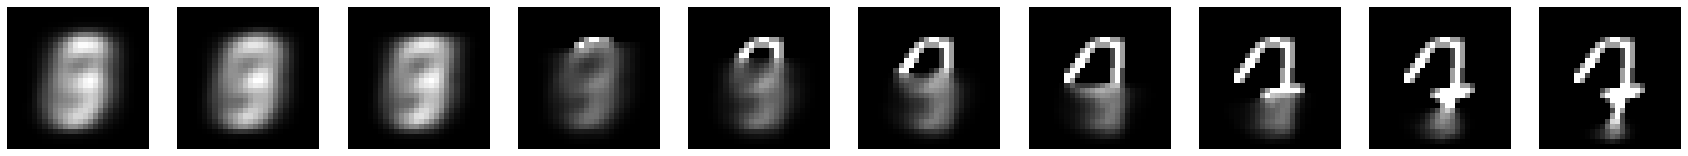

Step 55304, Loss (last minibatch): 0.21376550197601318, Loss (500 step avg.): 0.2086931312690952


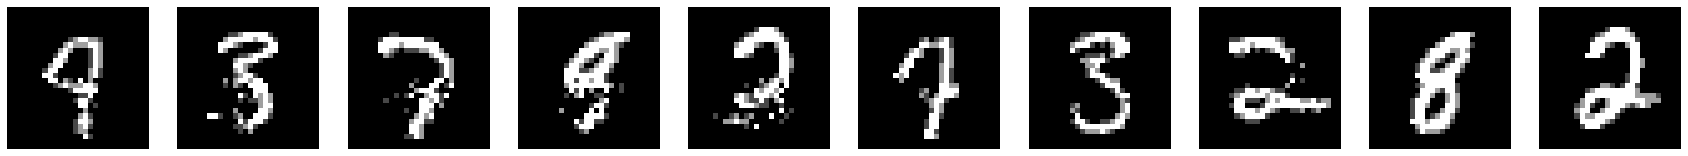

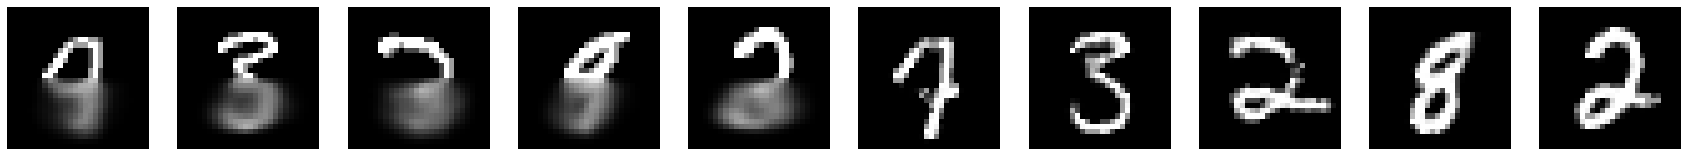

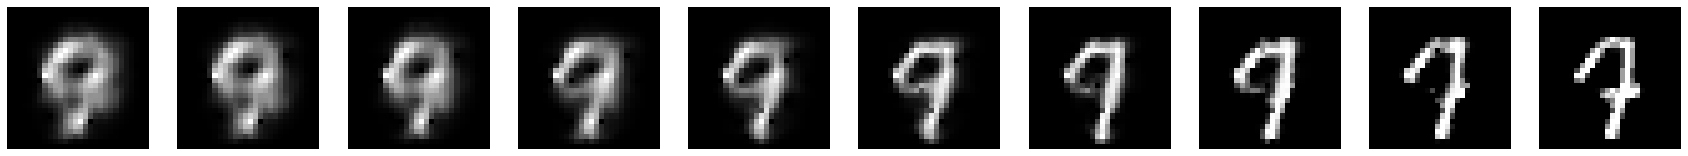

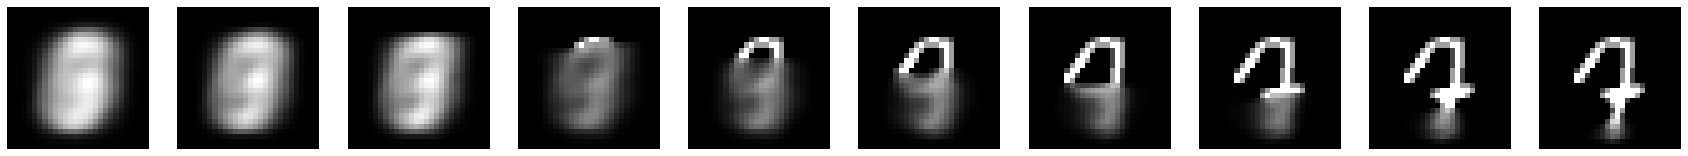

Step 56304, Loss (last minibatch): 0.16227585077285767, Loss (500 step avg.): 0.21076835092610705


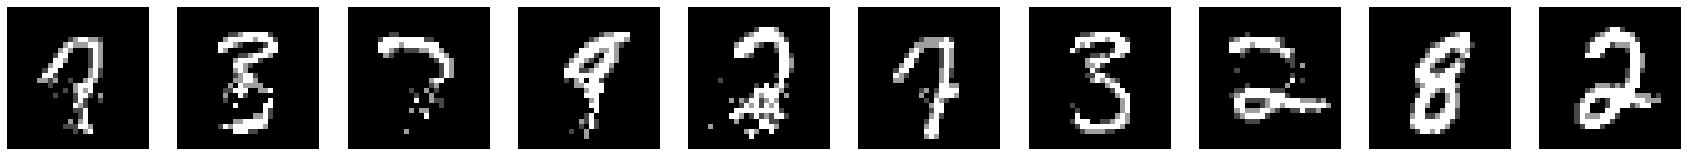

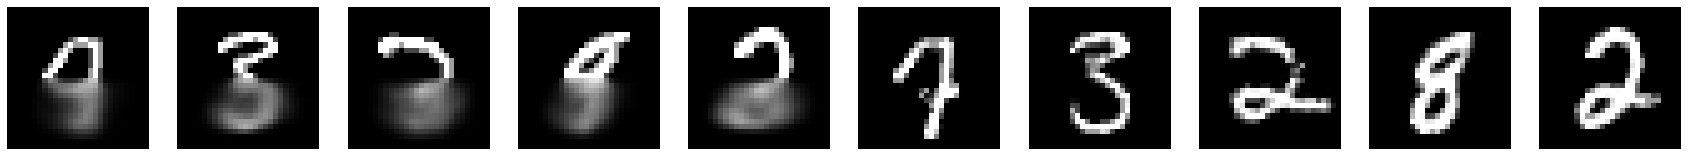

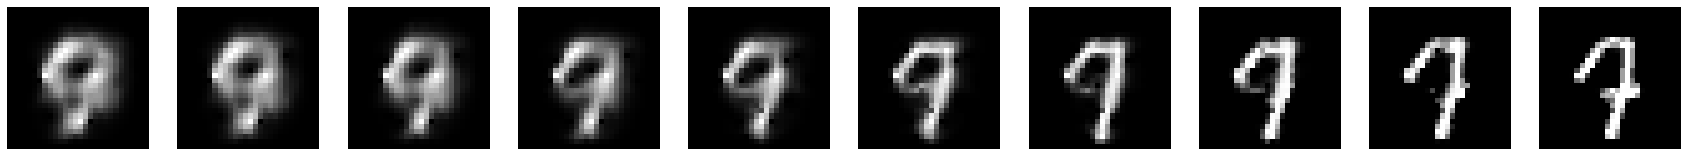

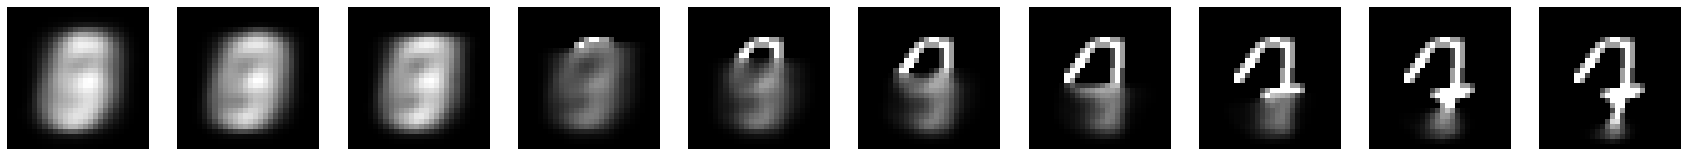

Step 57304, Loss (last minibatch): 0.21044331789016724, Loss (500 step avg.): 0.2084422227805722


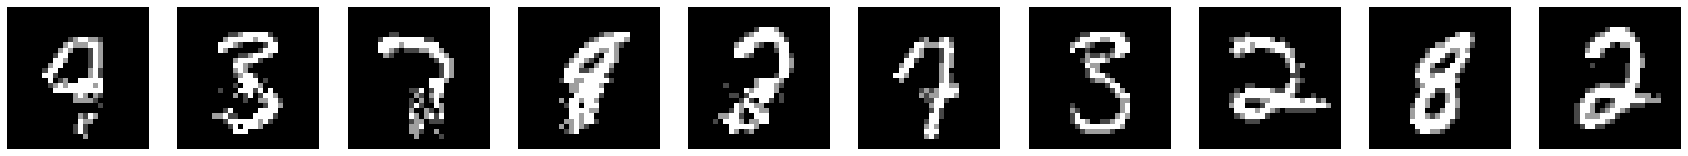

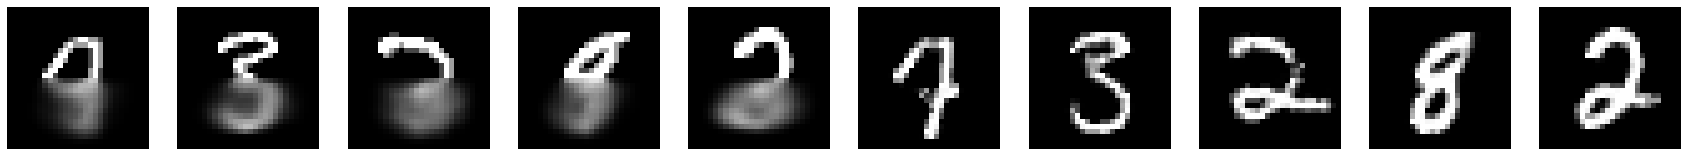

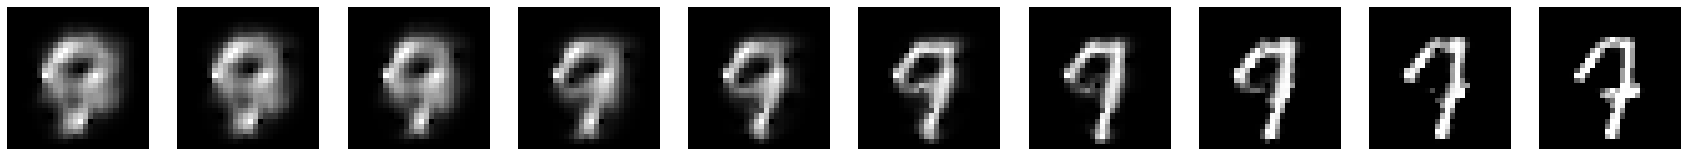

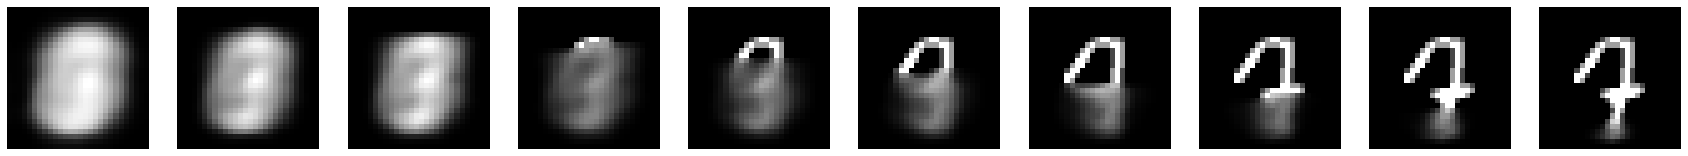

Step 58304, Loss (last minibatch): 0.15830828249454498, Loss (500 step avg.): 0.21058101562444798


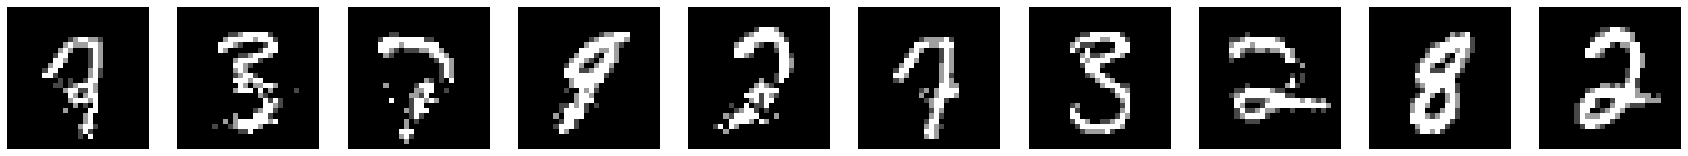

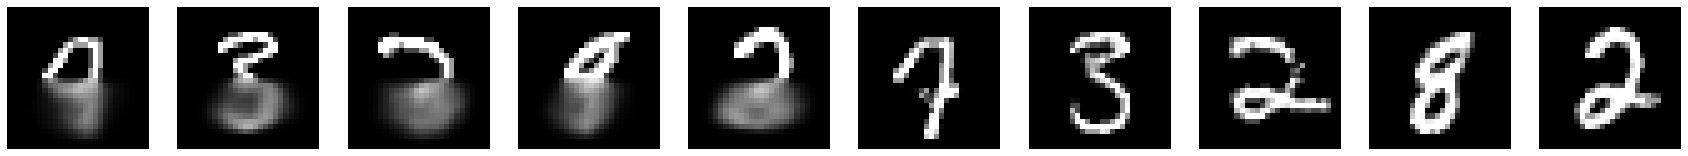

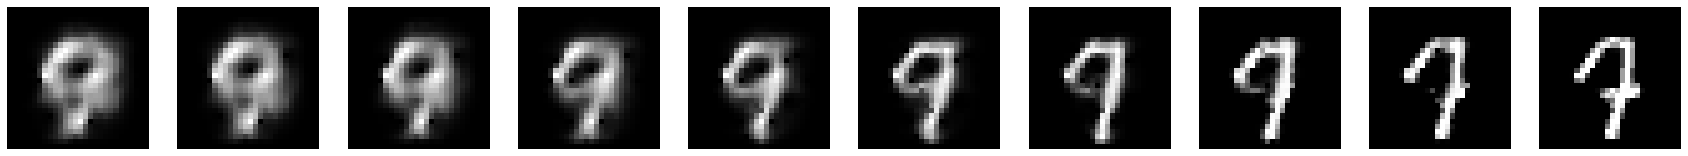

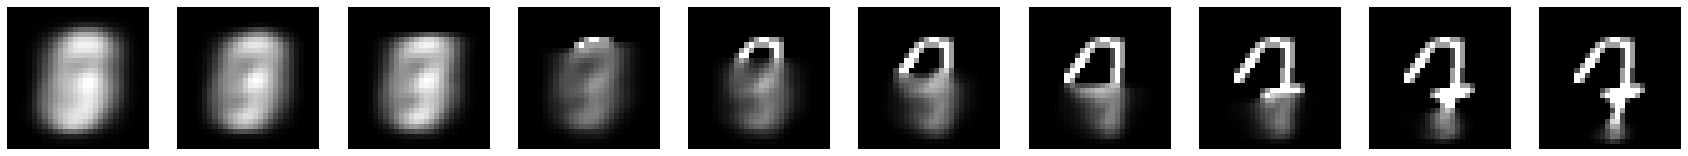

Step 59304, Loss (last minibatch): 0.1752084195613861, Loss (500 step avg.): 0.2104126718824733


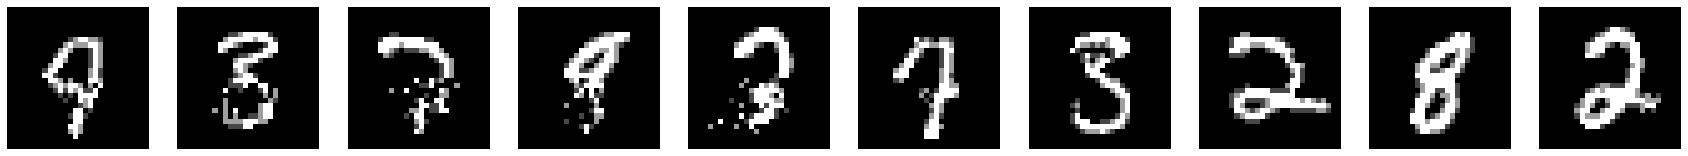

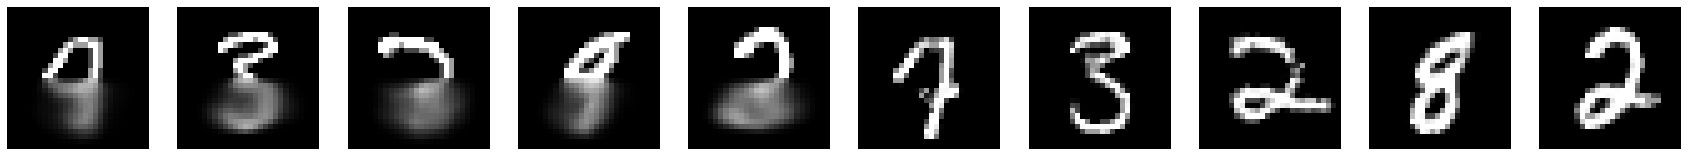

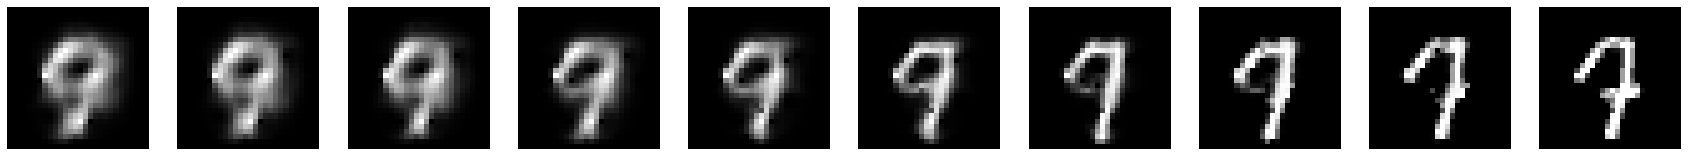

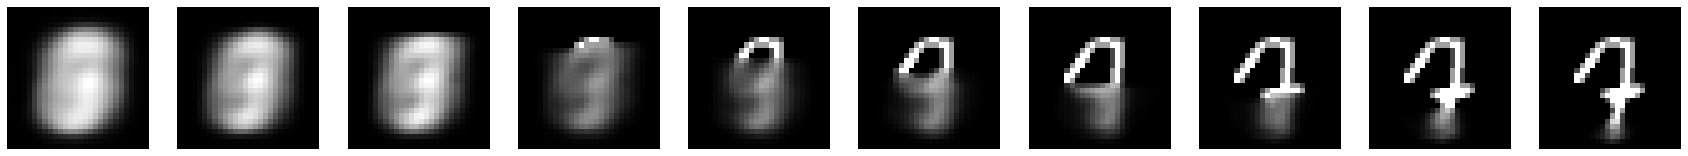

Step 60304, Loss (last minibatch): 0.2426641285419464, Loss (500 step avg.): 0.20879927884318872


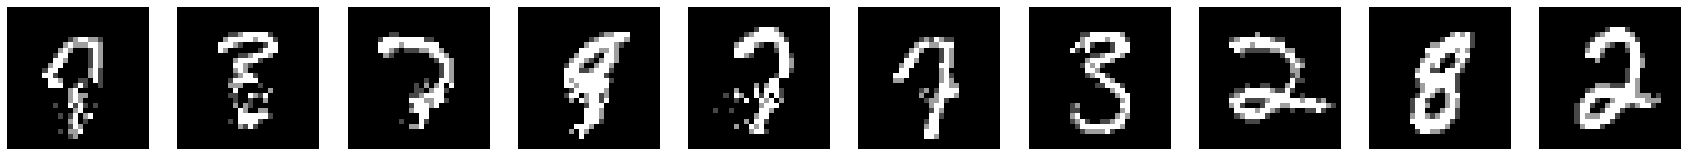

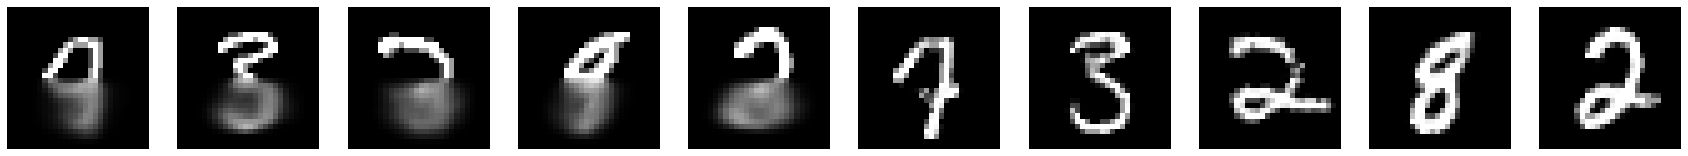

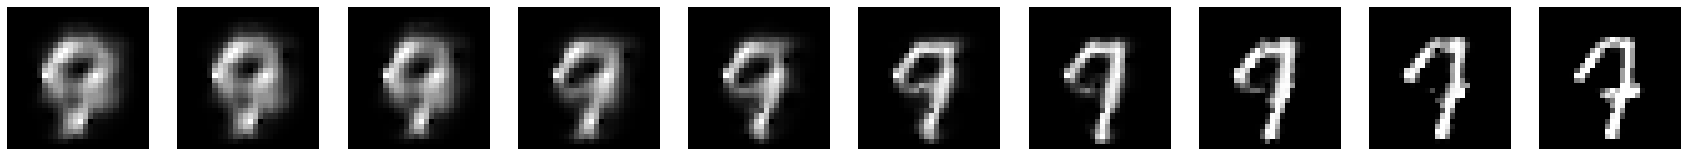

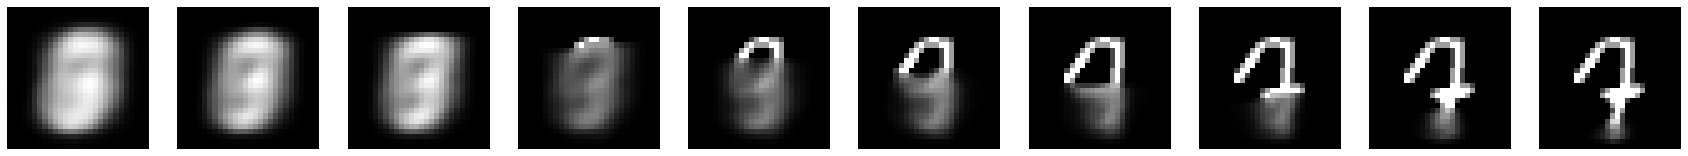

Step 61304, Loss (last minibatch): 0.1575355976819992, Loss (500 step avg.): 0.20771735222515708


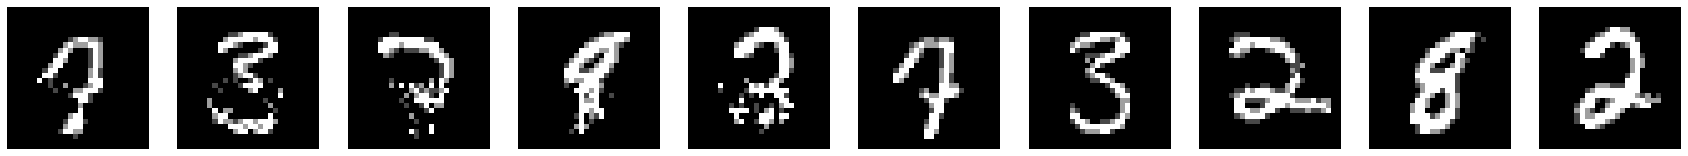

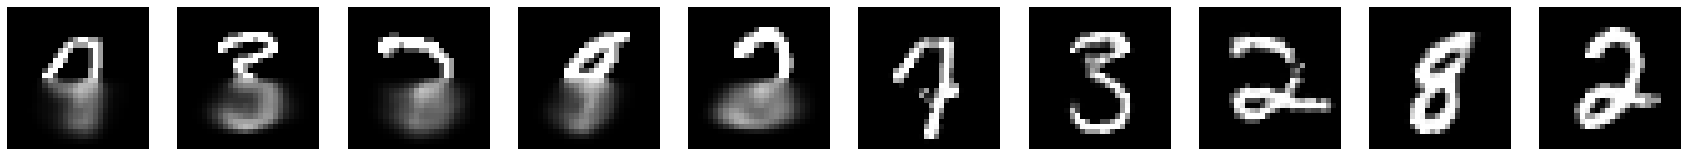

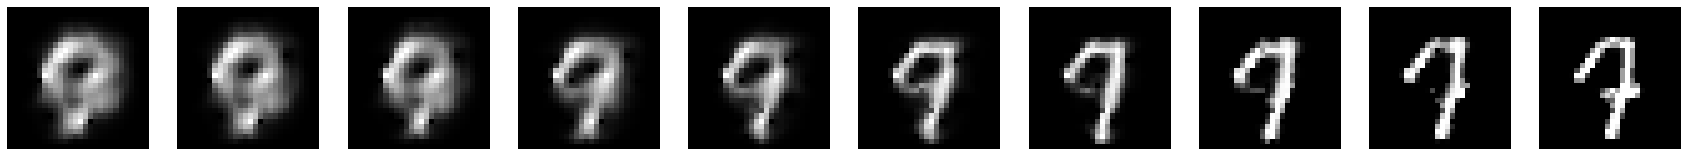

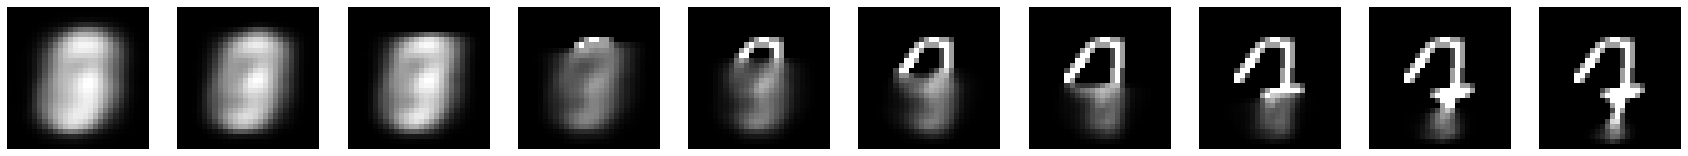

Step 62304, Loss (last minibatch): 0.26282426714897156, Loss (500 step avg.): 0.20714564950106862


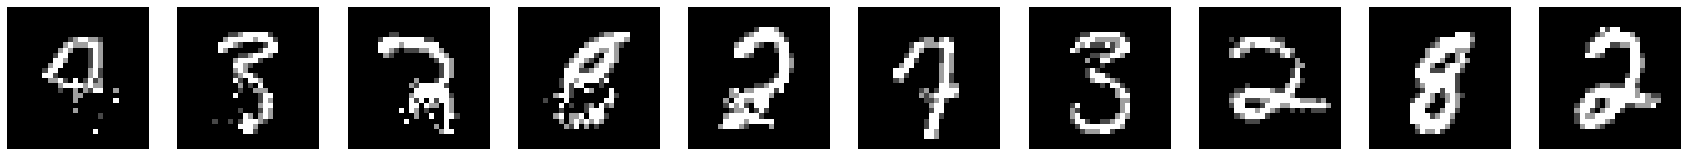

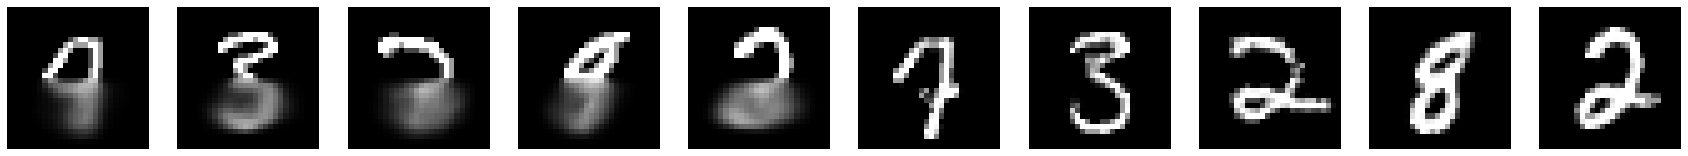

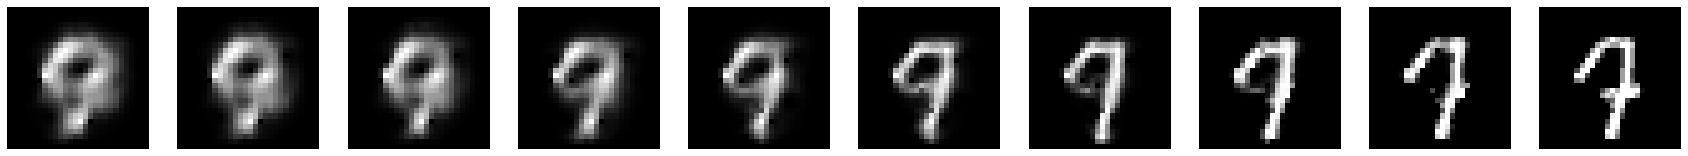

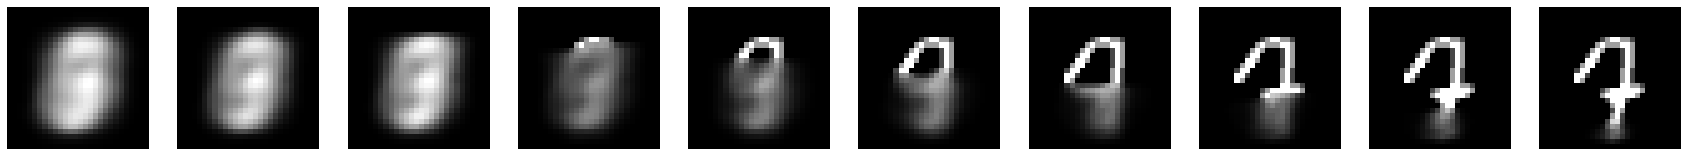

Step 63304, Loss (last minibatch): 0.1940678358078003, Loss (500 step avg.): 0.20588853827374662


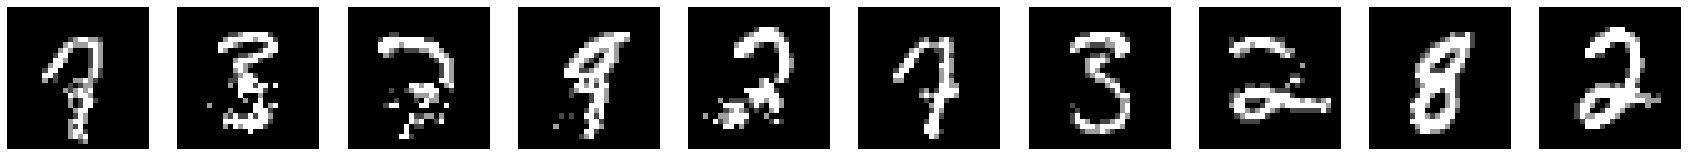

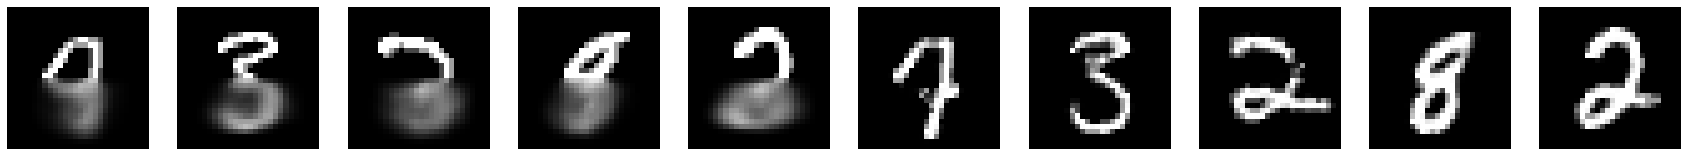

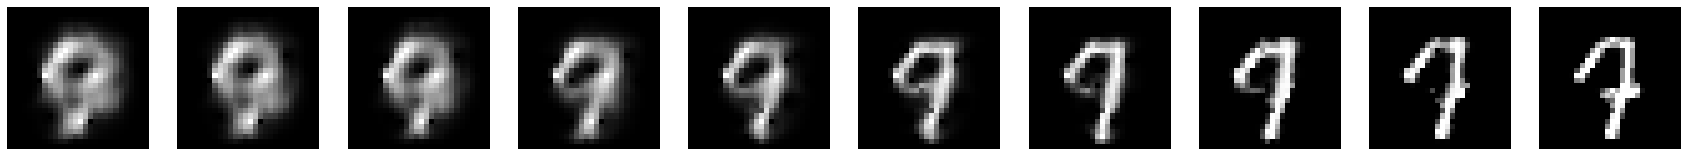

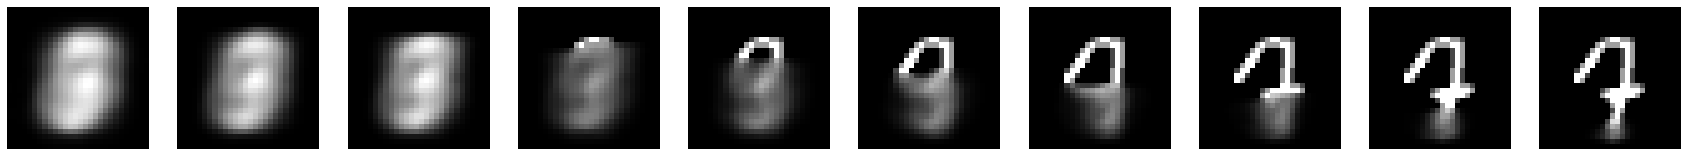

Step 64304, Loss (last minibatch): 0.17853042483329773, Loss (500 step avg.): 0.20739921347466772


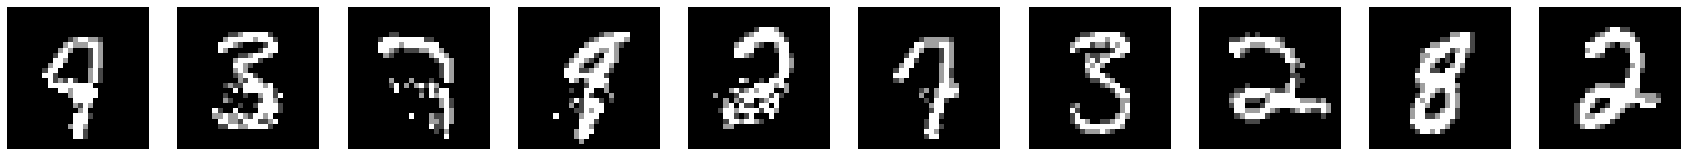

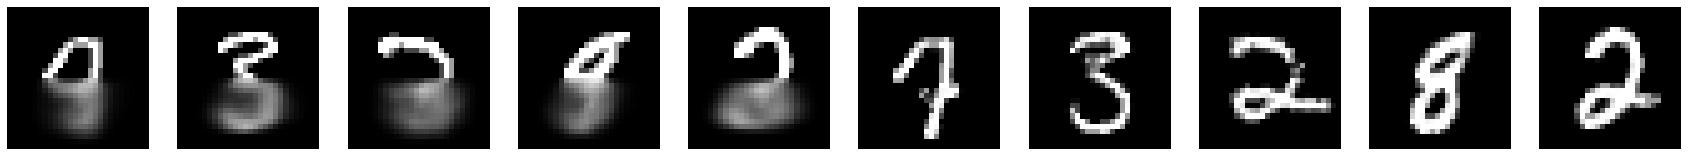

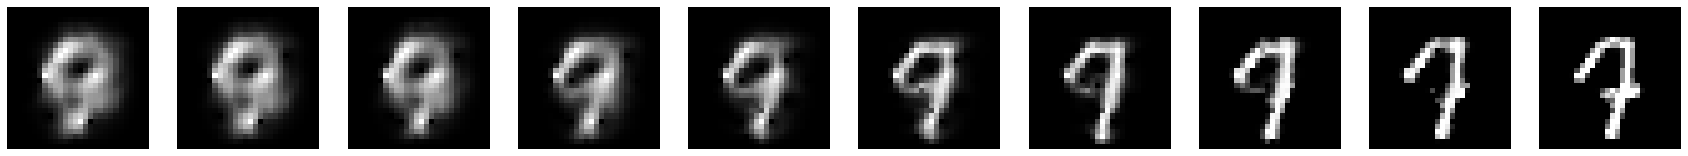

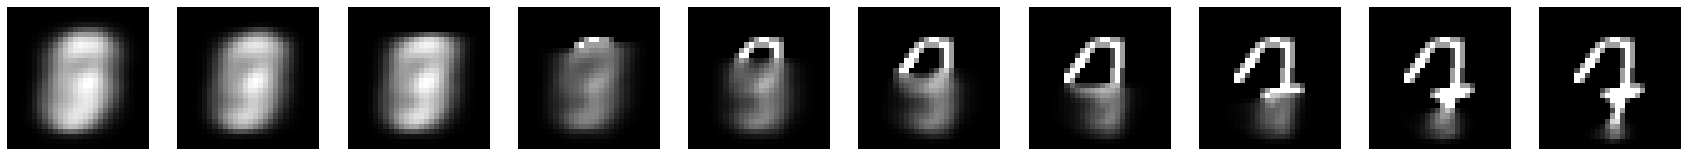

Step 65304, Loss (last minibatch): 0.17694351077079773, Loss (500 step avg.): 0.20882934935673506


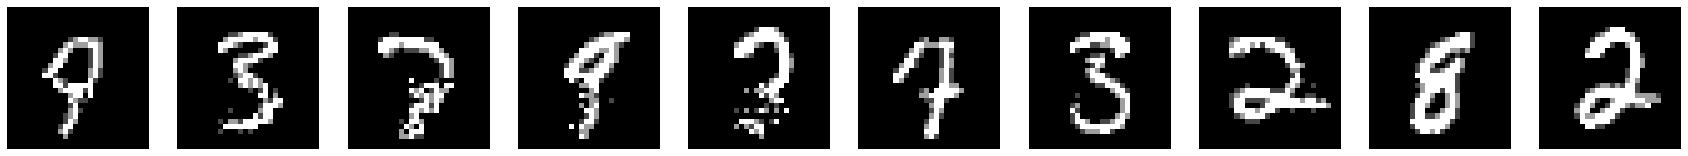

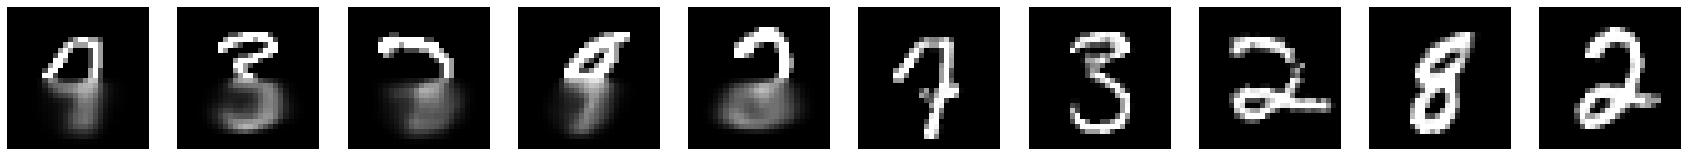

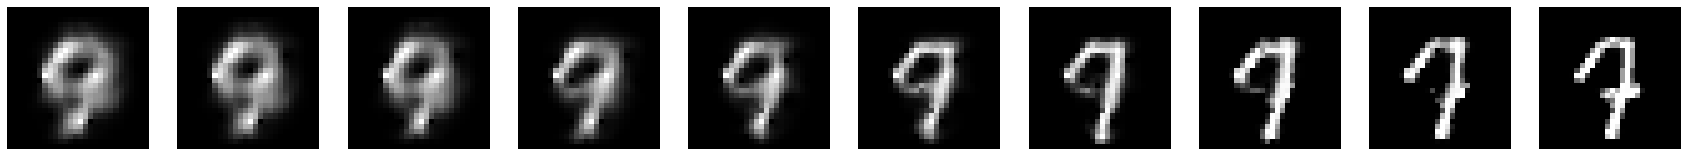

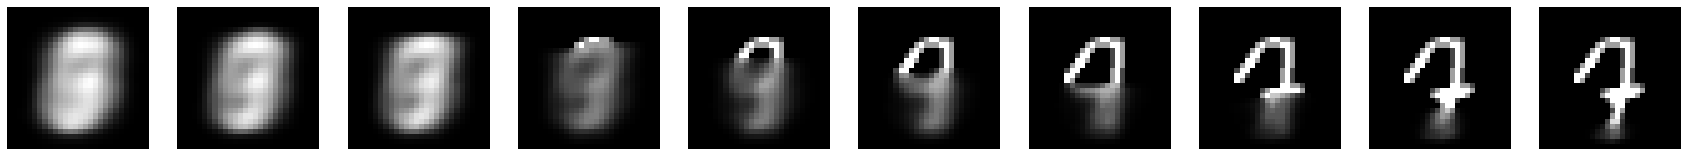

Step 66304, Loss (last minibatch): 0.19847619533538818, Loss (500 step avg.): 0.2070111306663045


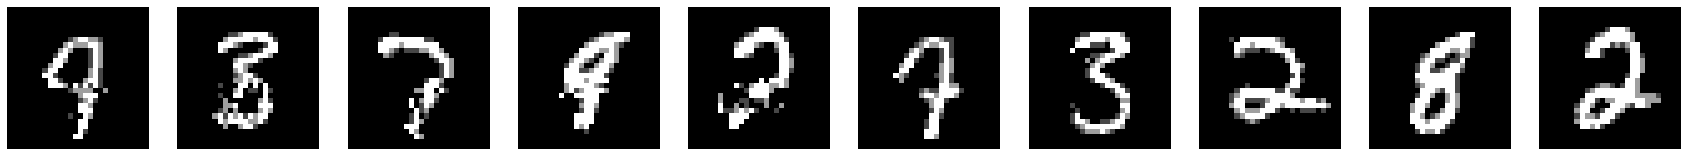

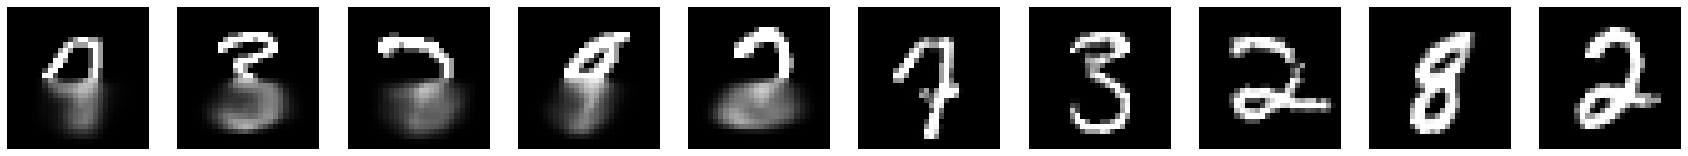

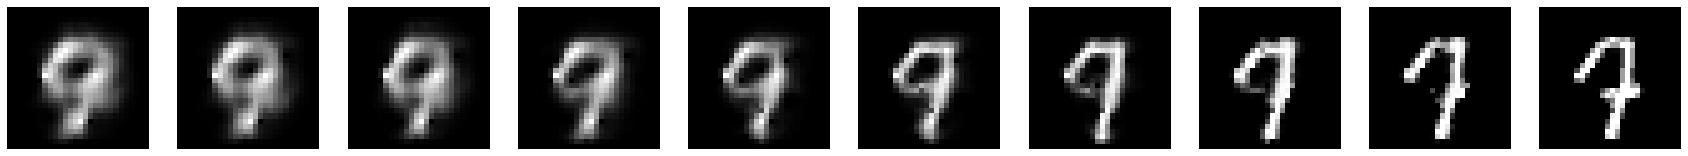

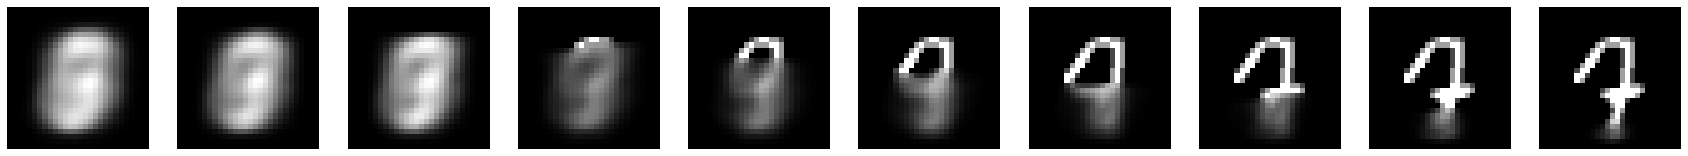

Step 67304, Loss (last minibatch): 0.1549094319343567, Loss (500 step avg.): 0.204863792289041


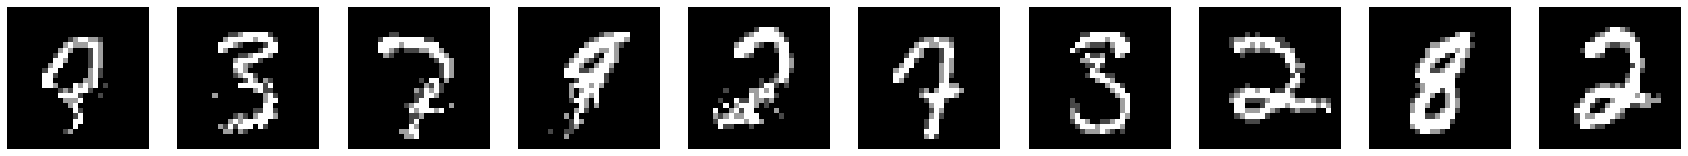

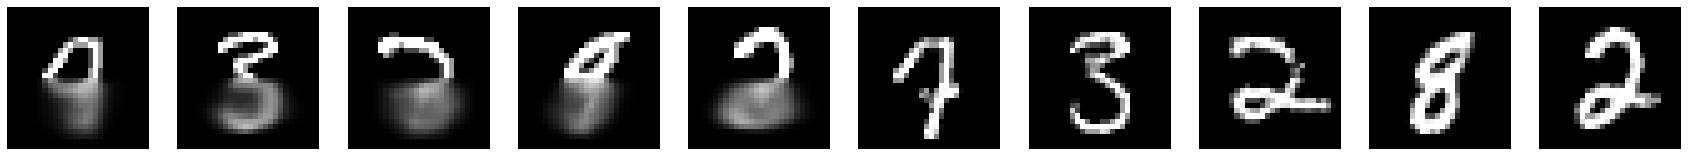

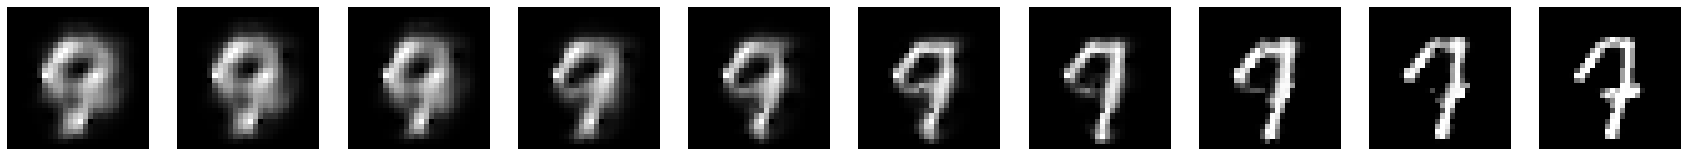

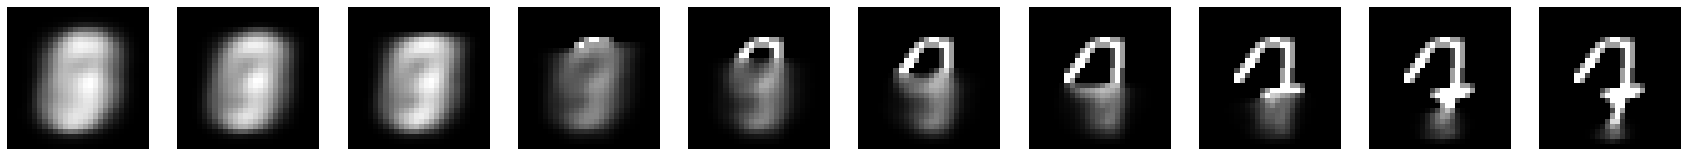

Step 68304, Loss (last minibatch): 0.3045137822628021, Loss (500 step avg.): 0.20572969995572896


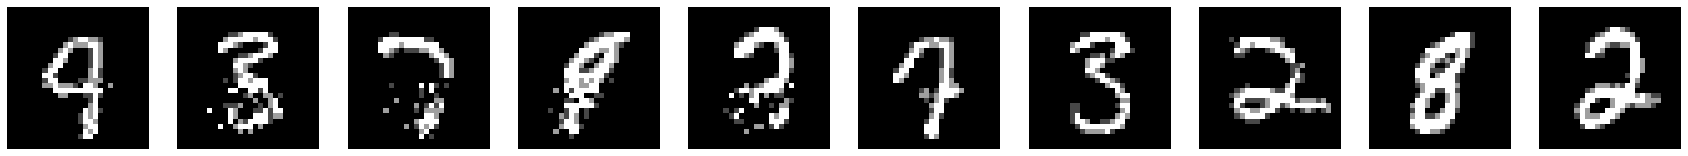

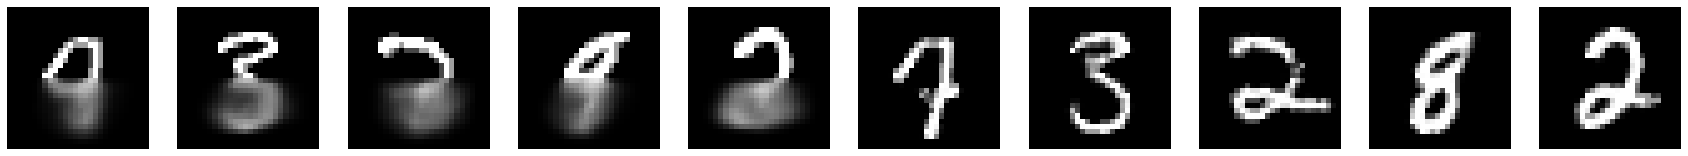

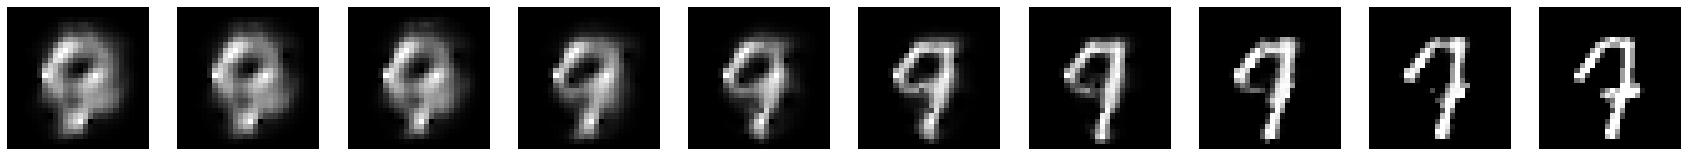

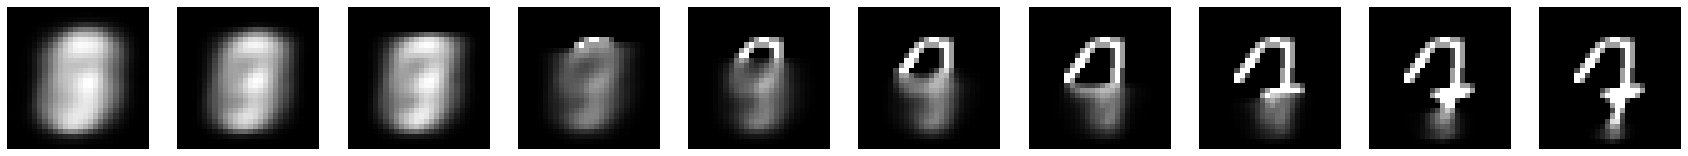

Step 69304, Loss (last minibatch): 0.24214409291744232, Loss (500 step avg.): 0.20473727448555284


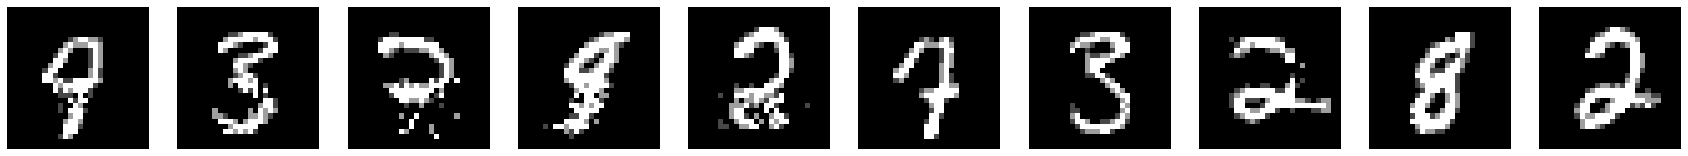

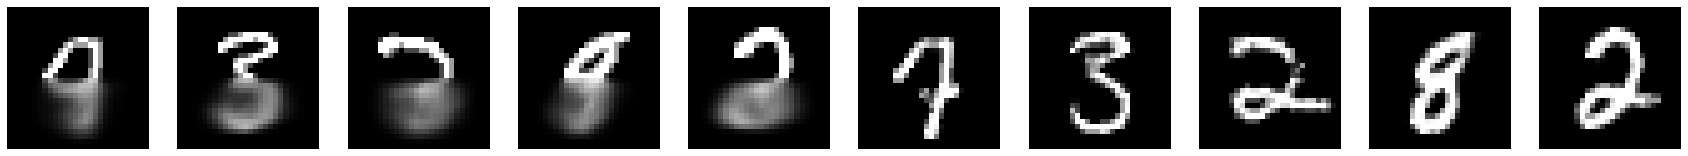

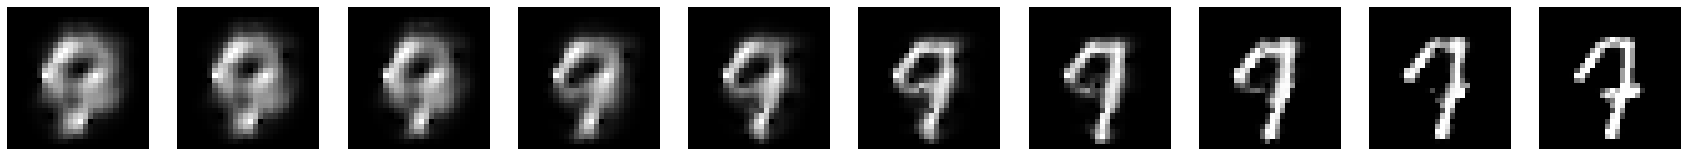

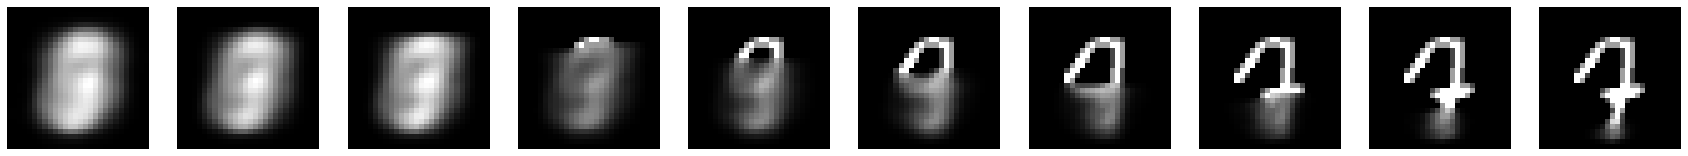

Step 70304, Loss (last minibatch): 0.25346606969833374, Loss (500 step avg.): 0.2048851838130913


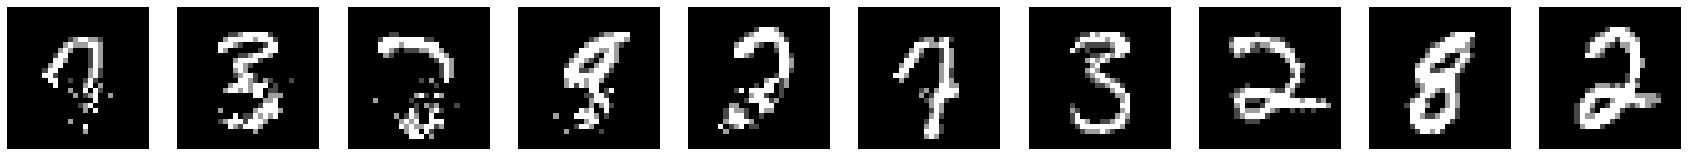

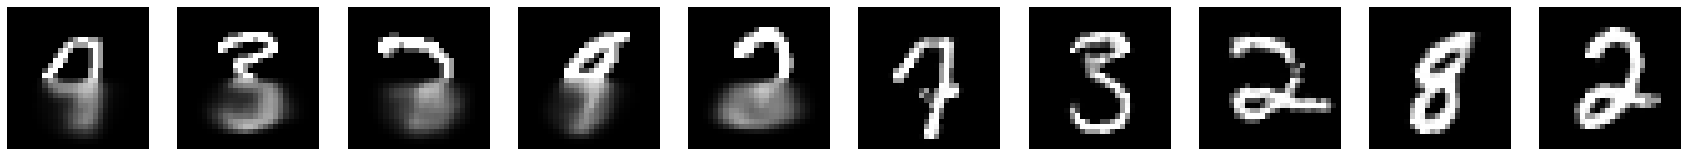

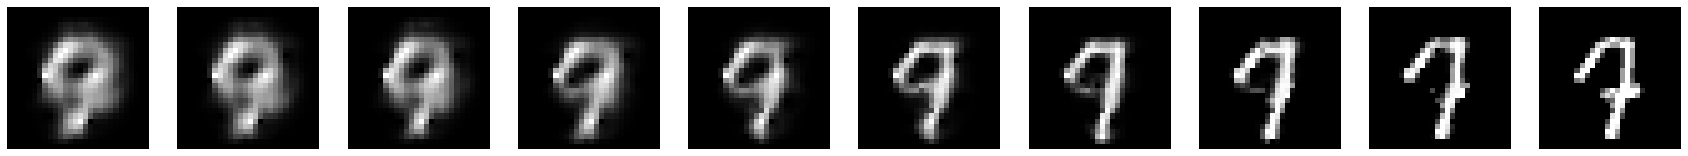

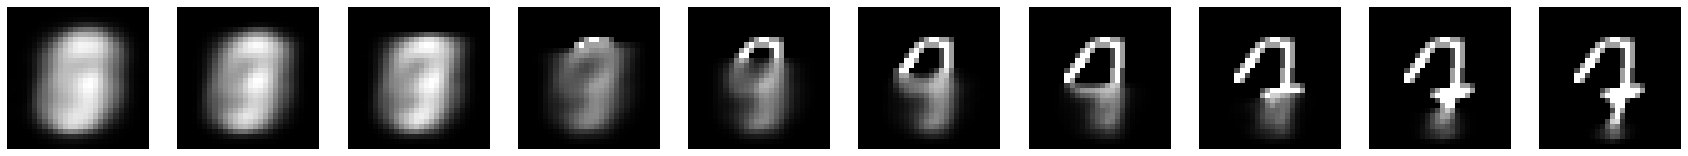

Step 71304, Loss (last minibatch): 0.1726578176021576, Loss (500 step avg.): 0.20202769490773093


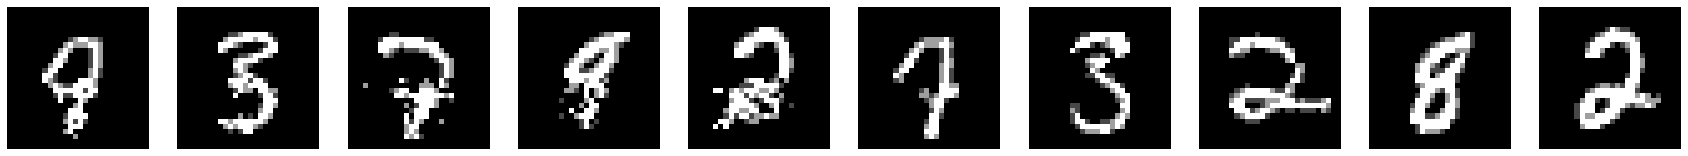

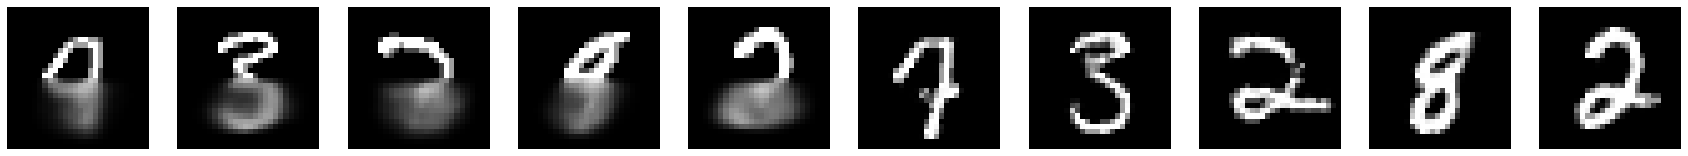

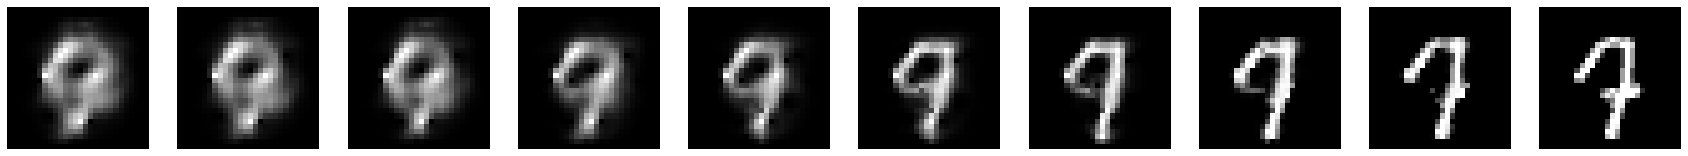

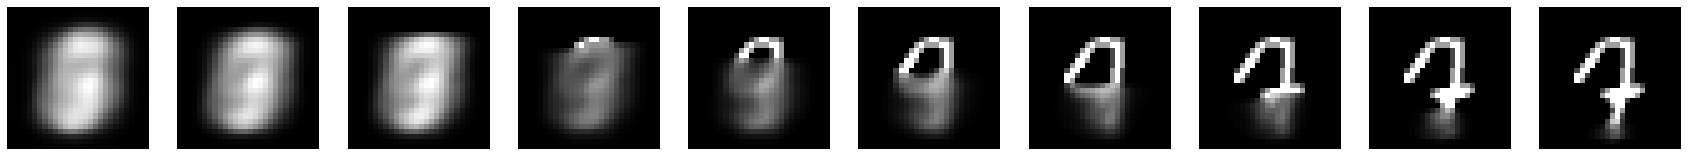

Step 72304, Loss (last minibatch): 0.2786097228527069, Loss (500 step avg.): 0.205778812978439


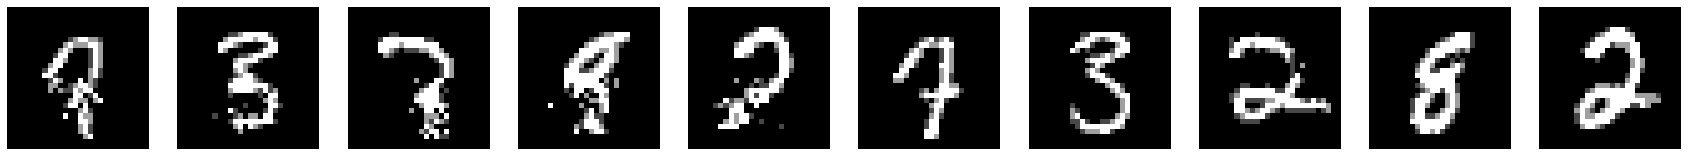

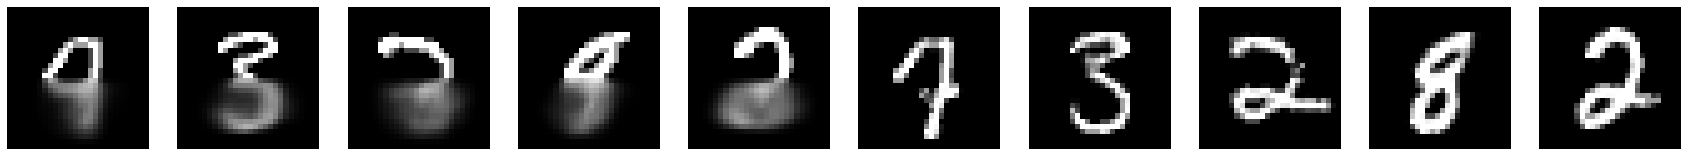

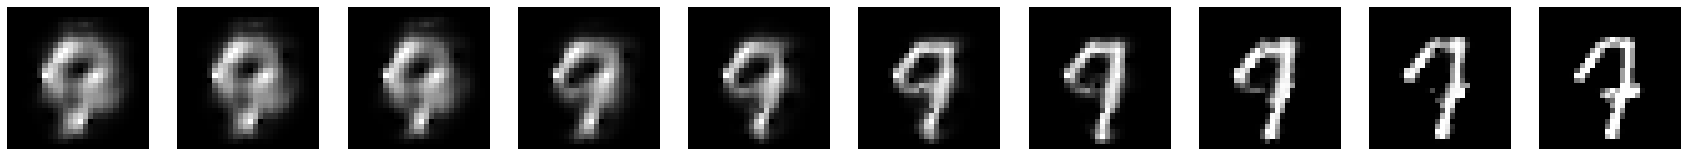

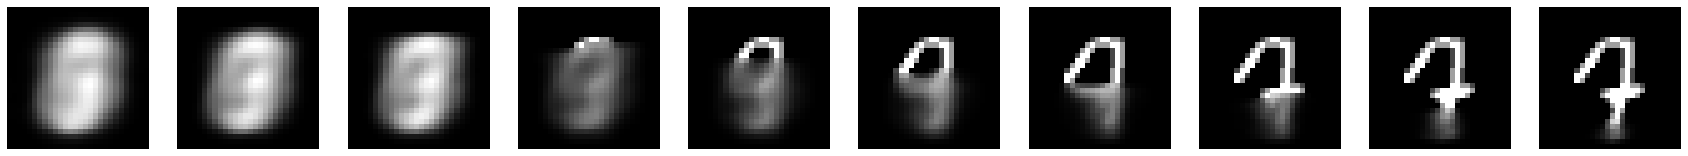

Step 73304, Loss (last minibatch): 0.17437097430229187, Loss (500 step avg.): 0.20449321116218547


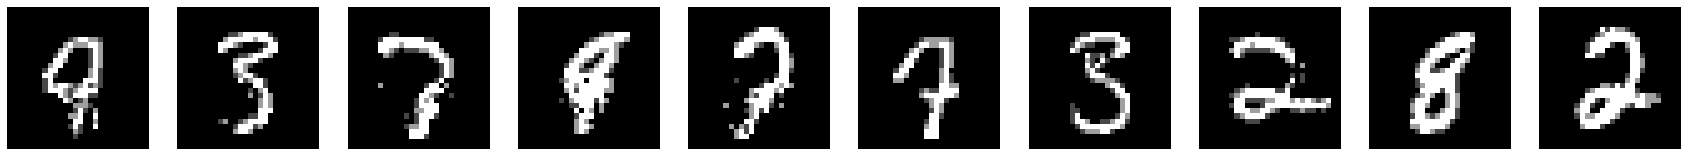

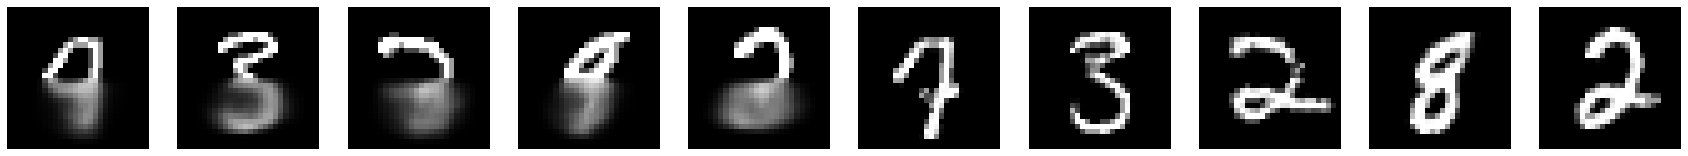

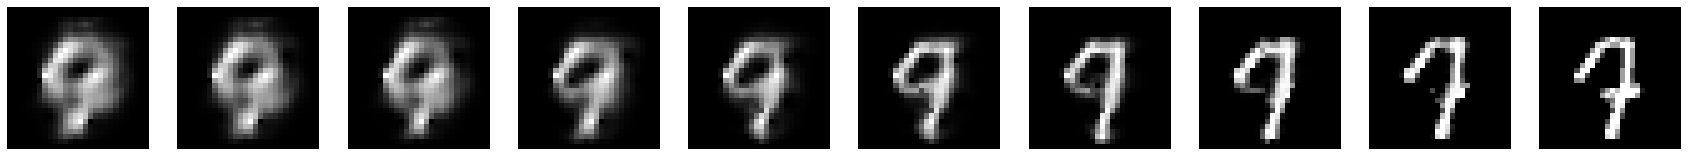

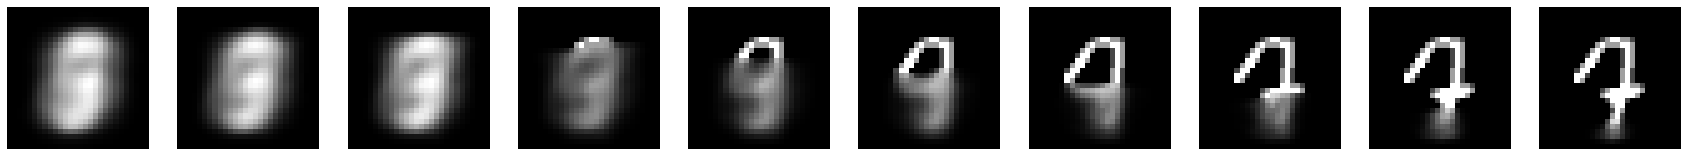

Step 74304, Loss (last minibatch): 0.2608189582824707, Loss (500 step avg.): 0.20401944615645798


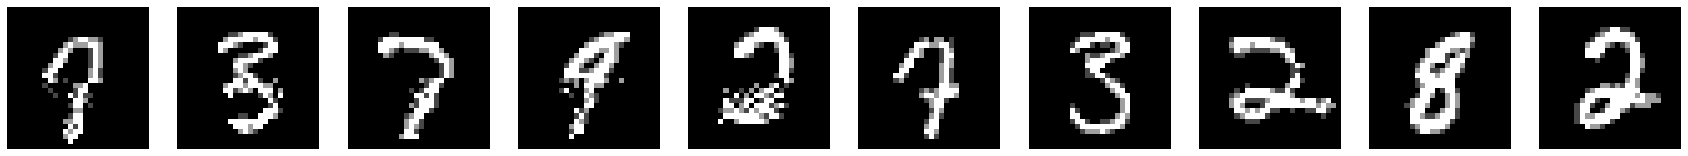

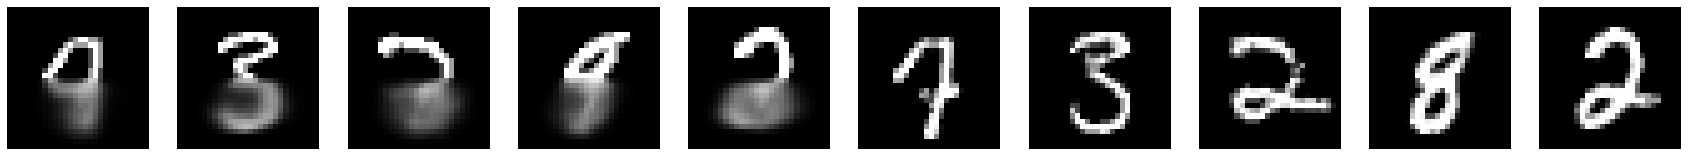

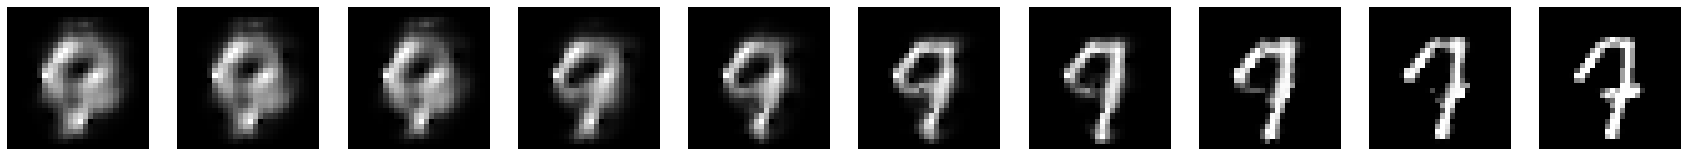

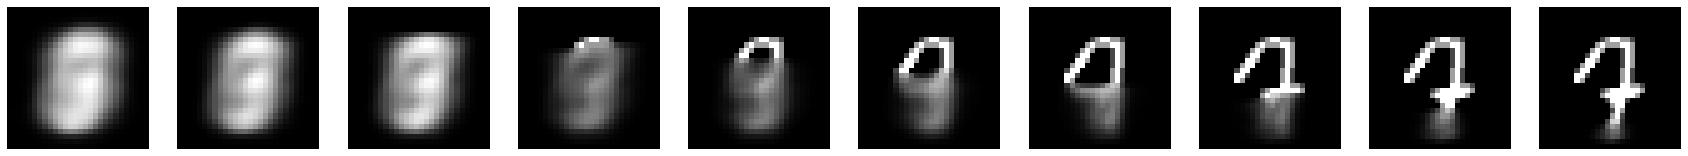

Step 75304, Loss (last minibatch): 0.19306062161922455, Loss (500 step avg.): 0.20158139039239958


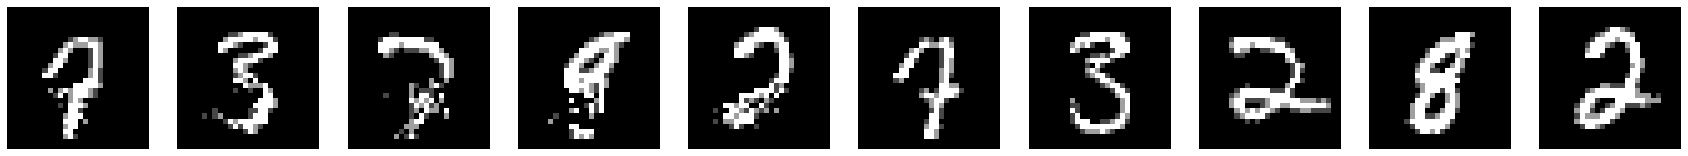

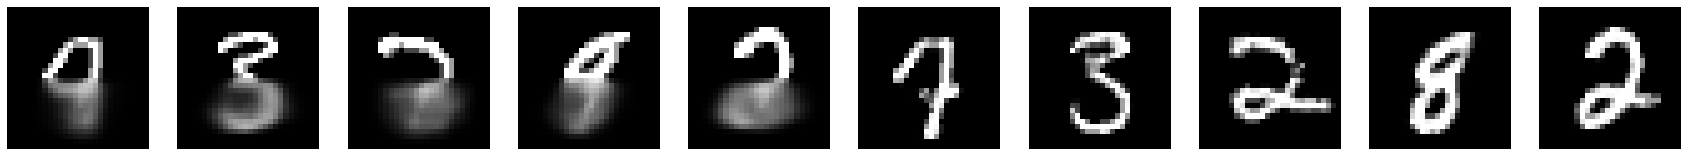

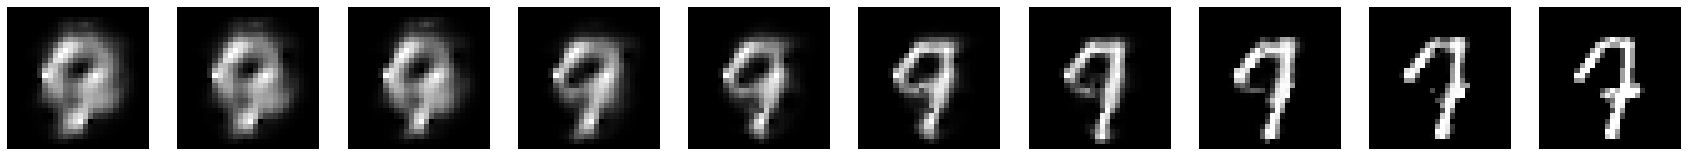

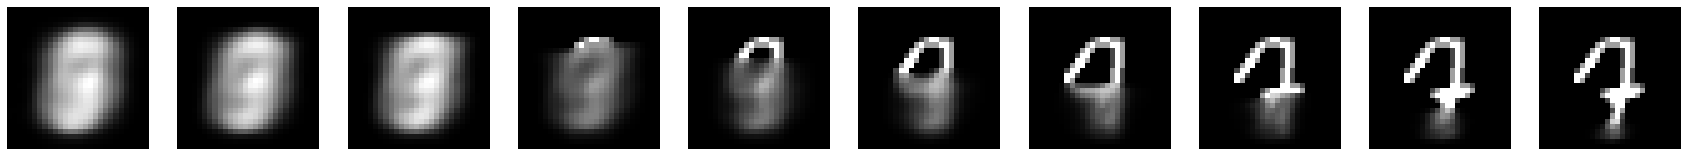

Step 76304, Loss (last minibatch): 0.22737084329128265, Loss (500 step avg.): 0.20641289881900876


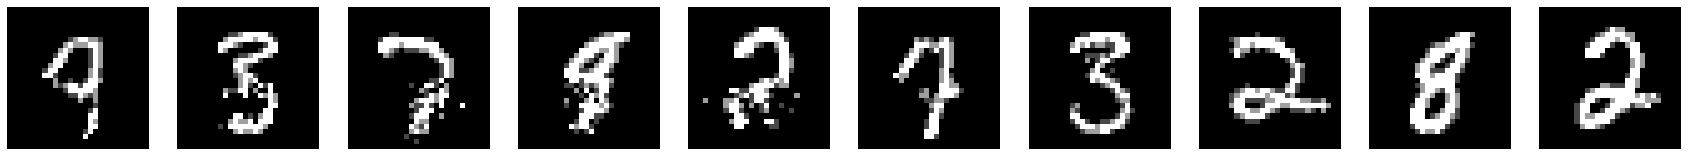

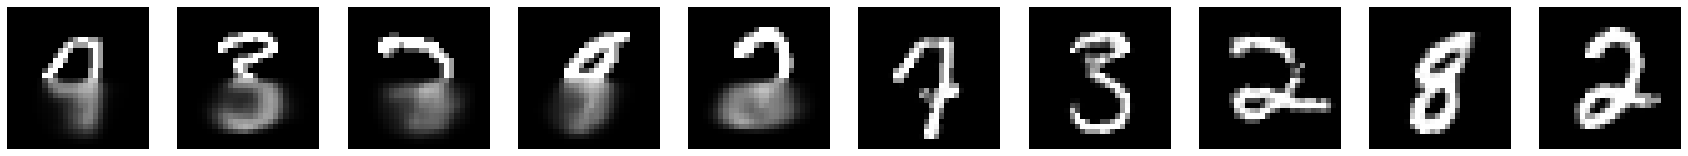

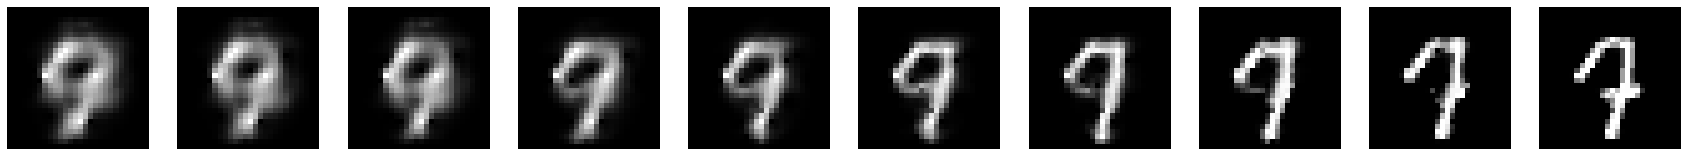

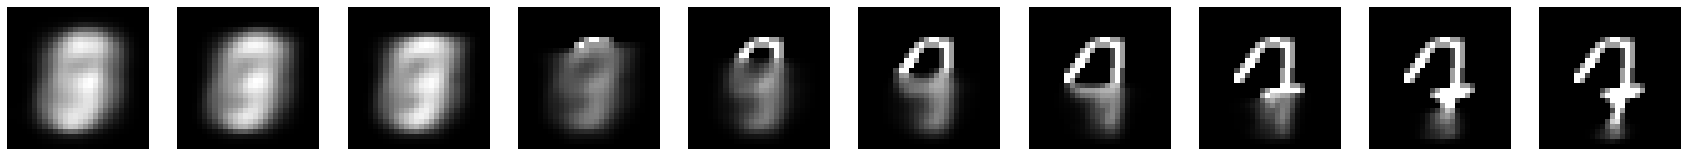

Step 77304, Loss (last minibatch): 0.24011115729808807, Loss (500 step avg.): 0.2016733618018156


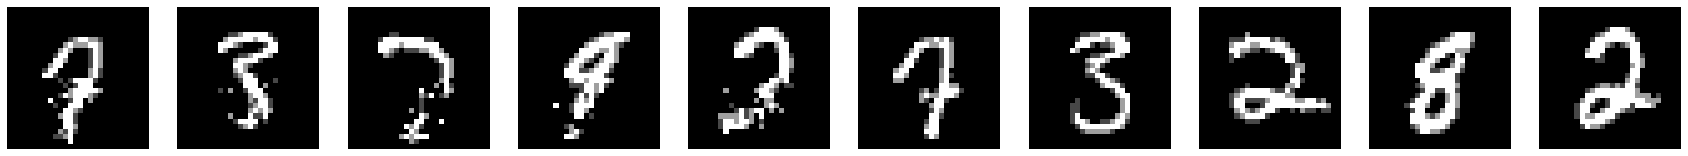

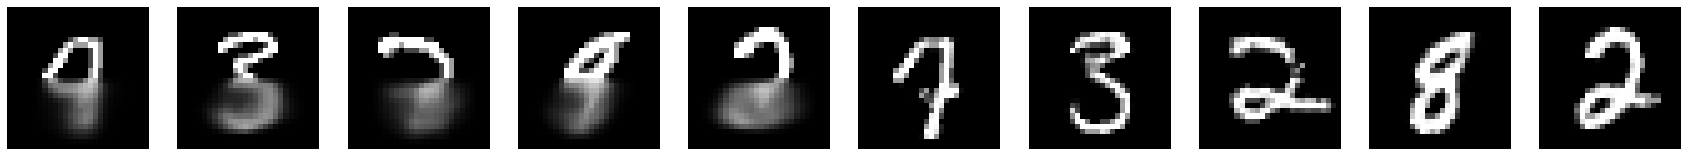

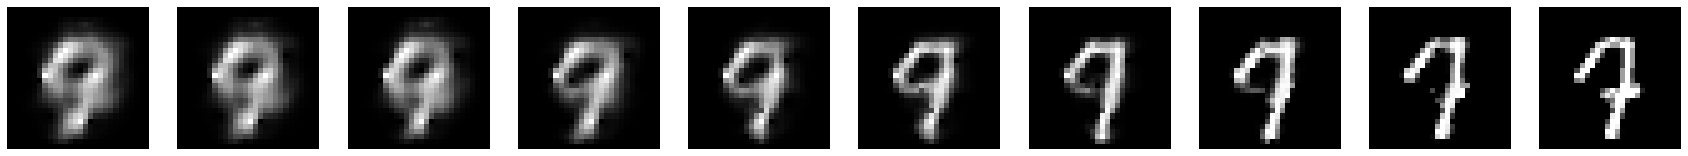

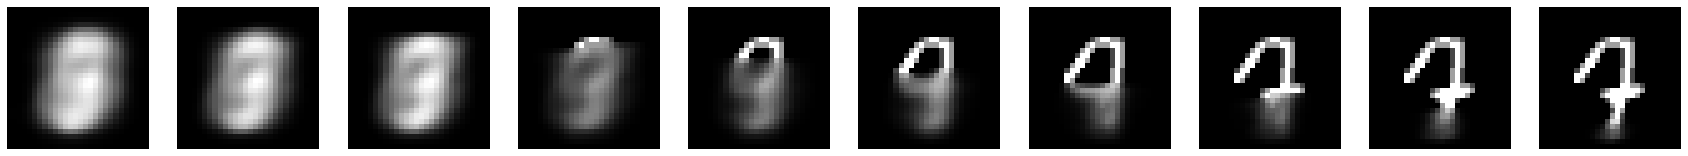

Step 78304, Loss (last minibatch): 0.22595906257629395, Loss (500 step avg.): 0.201976535295298


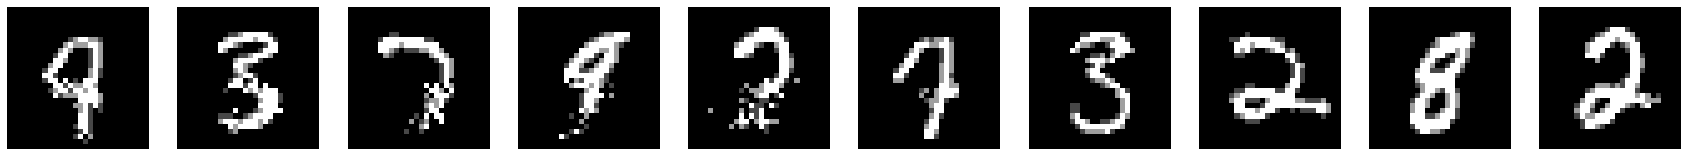

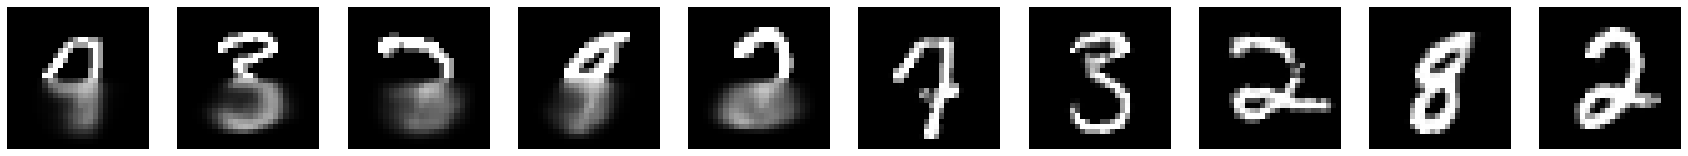

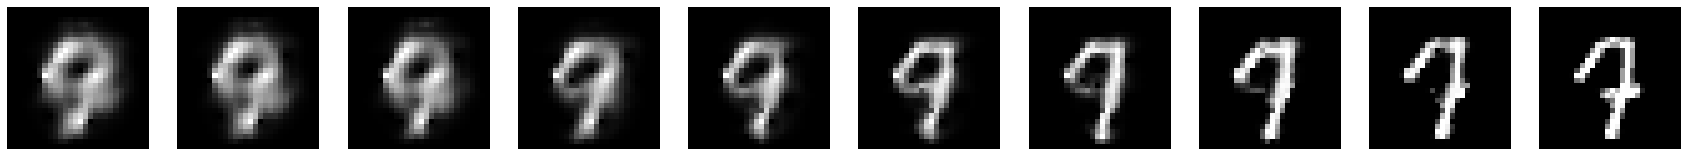

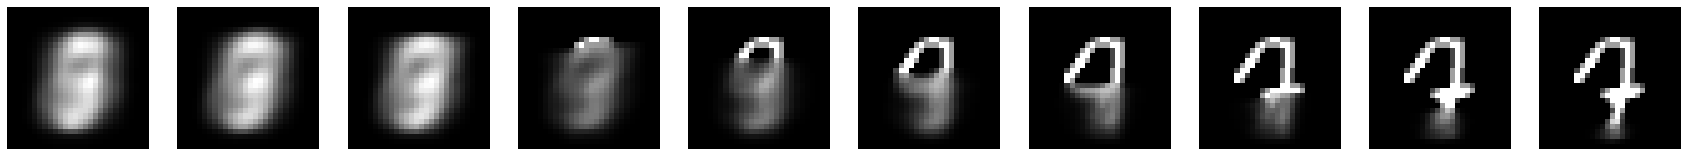

Step 79304, Loss (last minibatch): 0.2796434164047241, Loss (500 step avg.): 0.19996659151332344


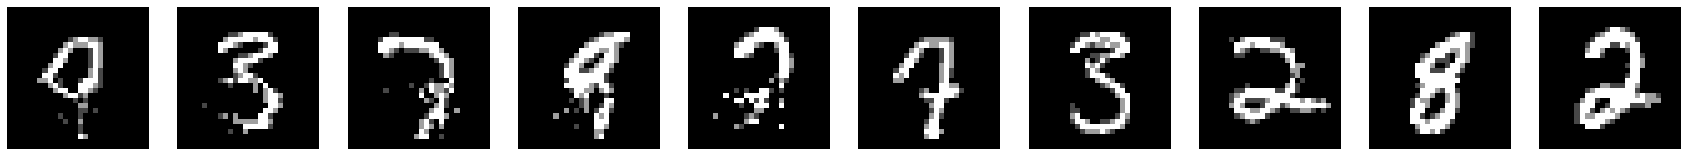

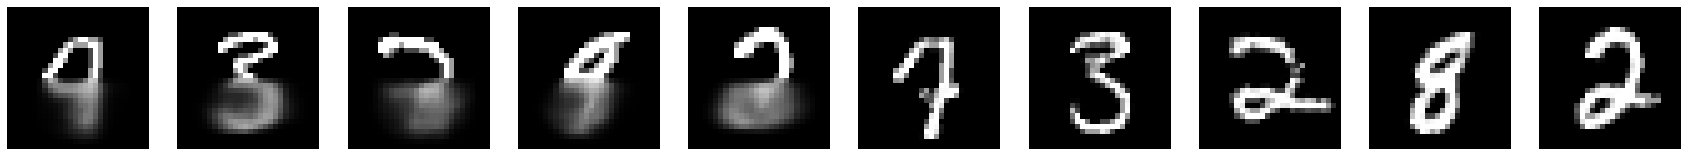

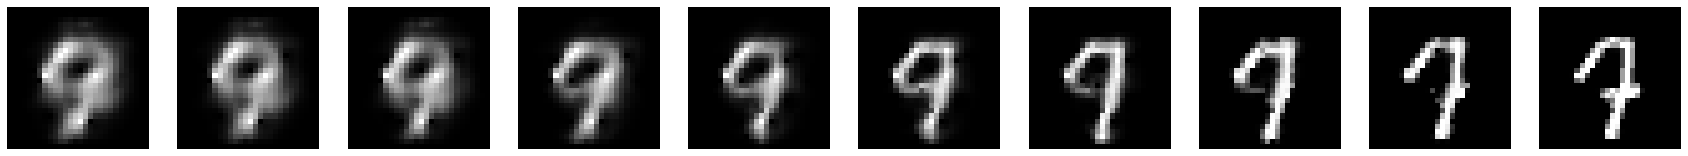

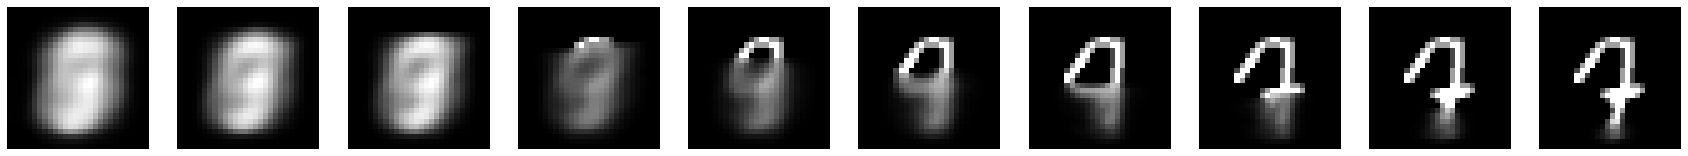

Step 80304, Loss (last minibatch): 0.21664969623088837, Loss (500 step avg.): 0.20703781483891956


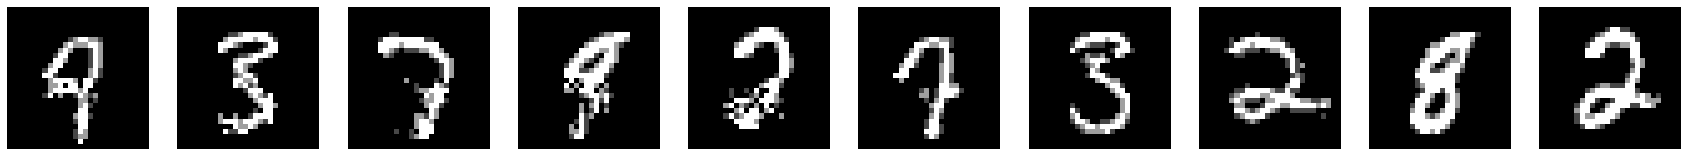

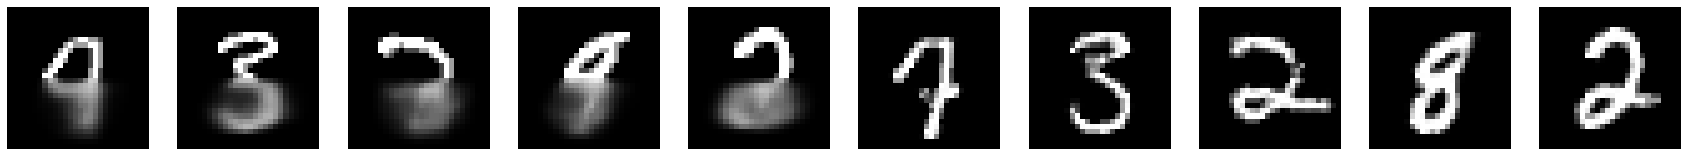

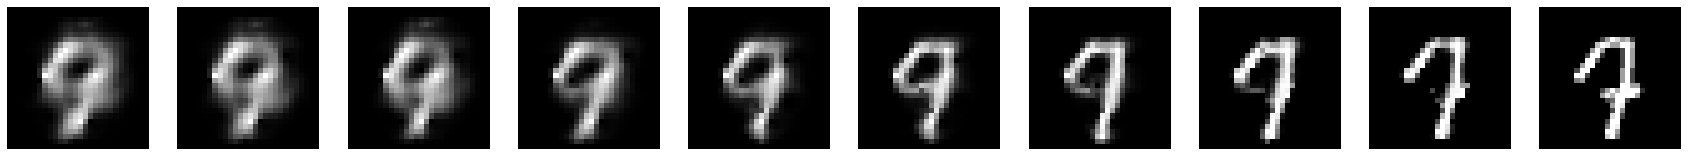

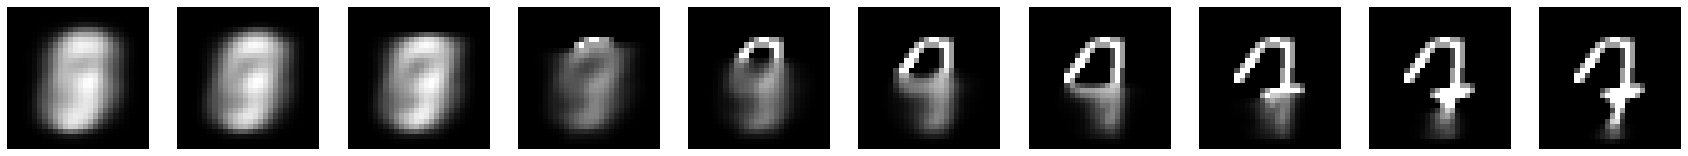

Step 81304, Loss (last minibatch): 0.2549915611743927, Loss (500 step avg.): 0.20478709074789417


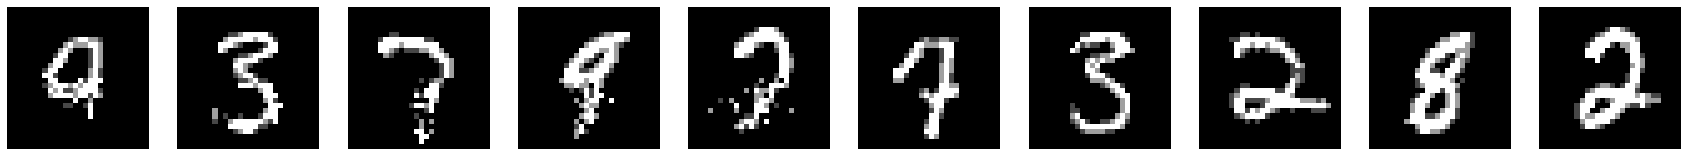

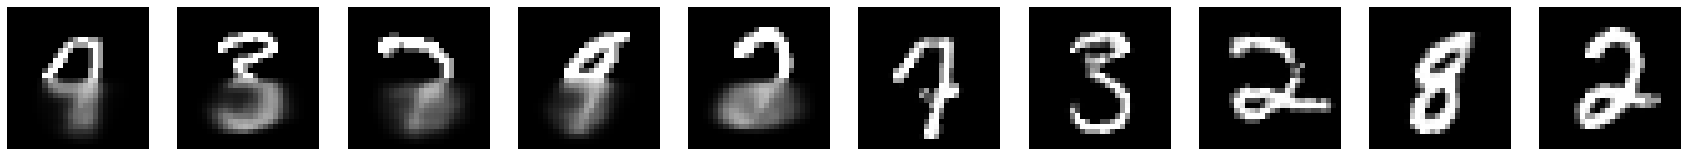

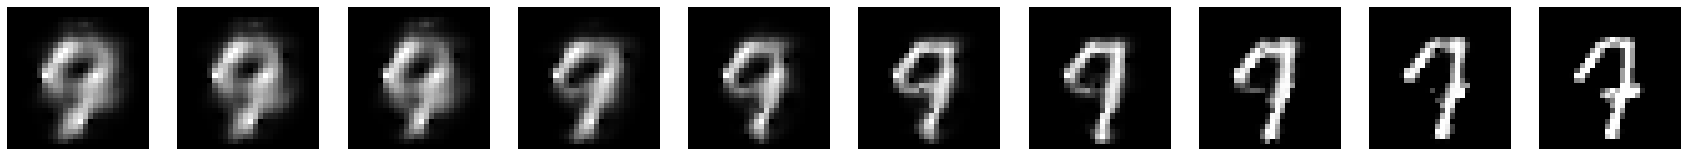

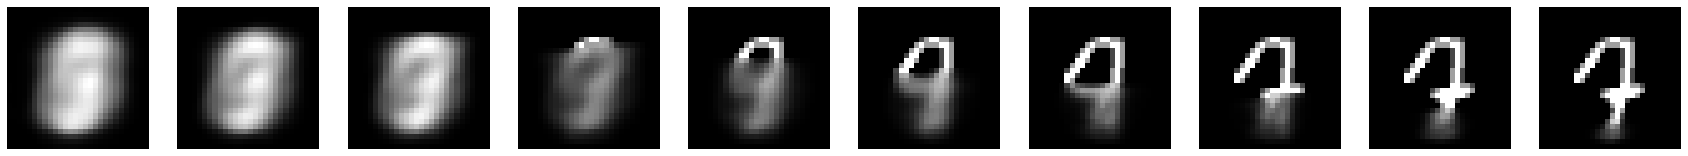

Step 82304, Loss (last minibatch): 0.2310531586408615, Loss (500 step avg.): 0.2017606084575196


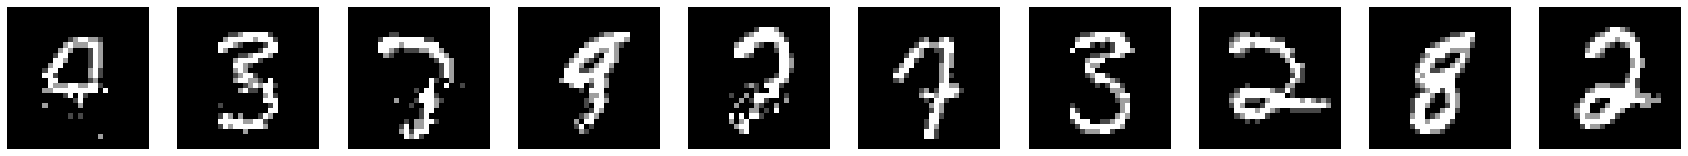

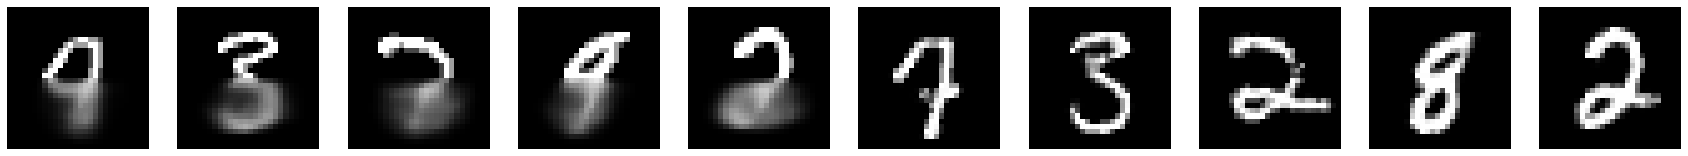

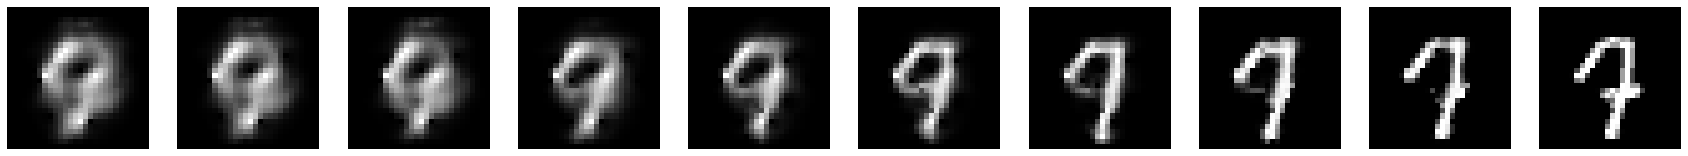

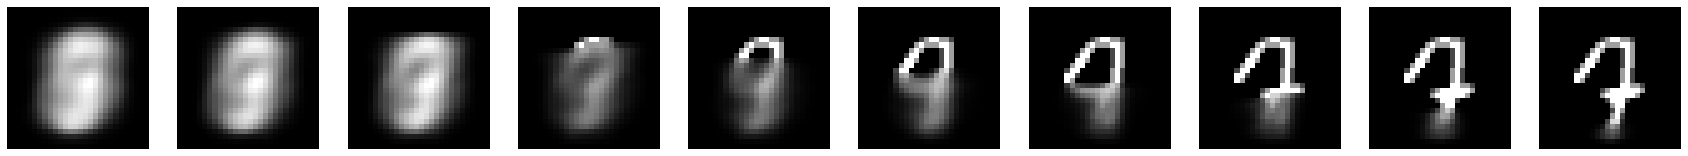

Step 83304, Loss (last minibatch): 0.18824106454849243, Loss (500 step avg.): 0.2024473421825858


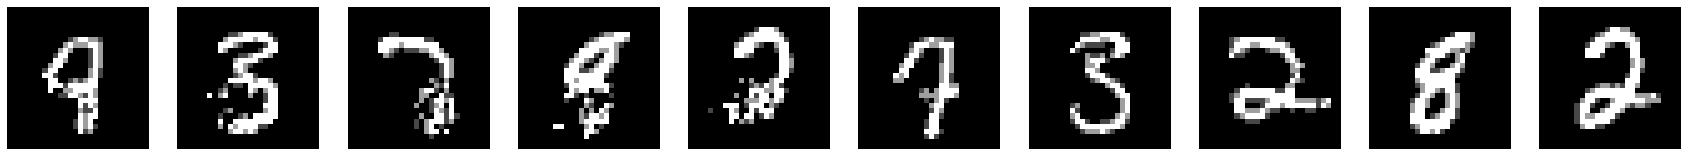

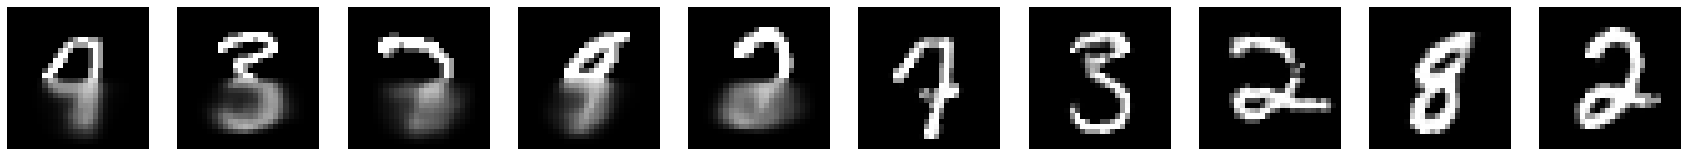

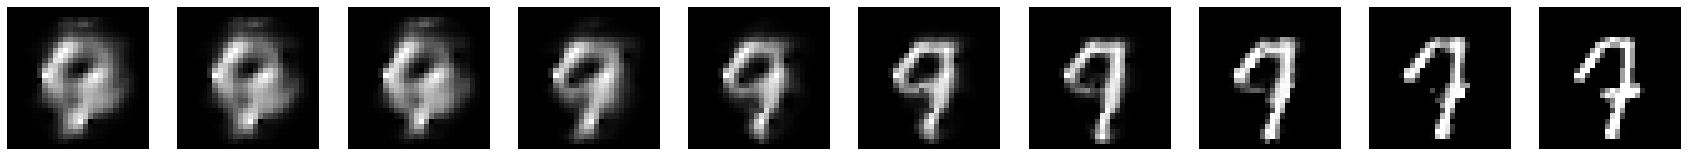

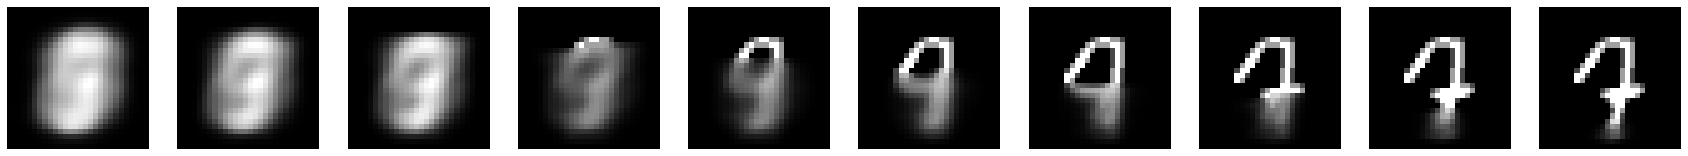

Step 84304, Loss (last minibatch): 0.25717493891716003, Loss (500 step avg.): 0.2020524880010449


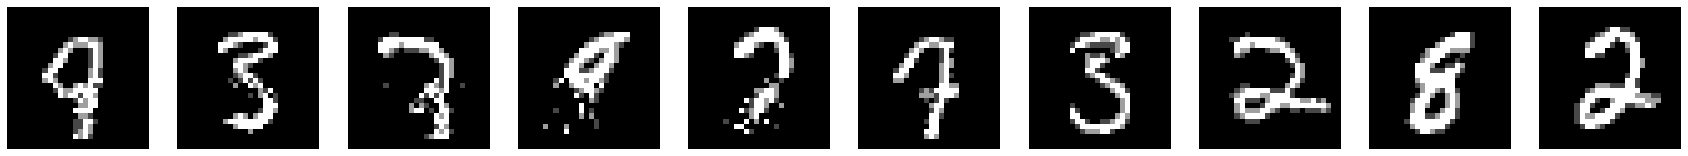

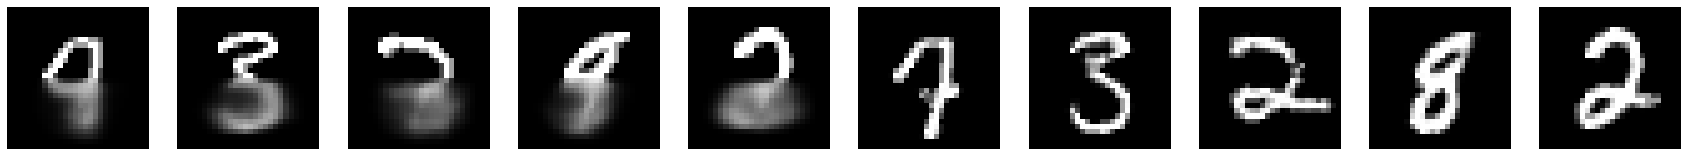

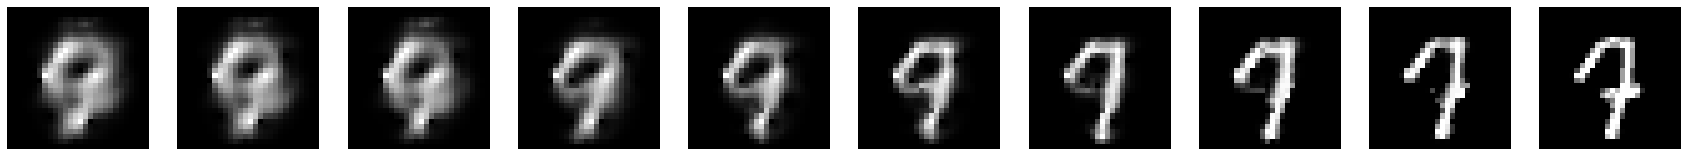

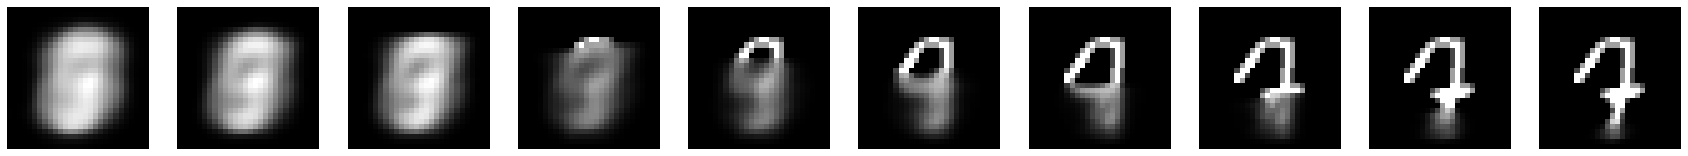

Step 85304, Loss (last minibatch): 0.18466447293758392, Loss (500 step avg.): 0.20319256698062083


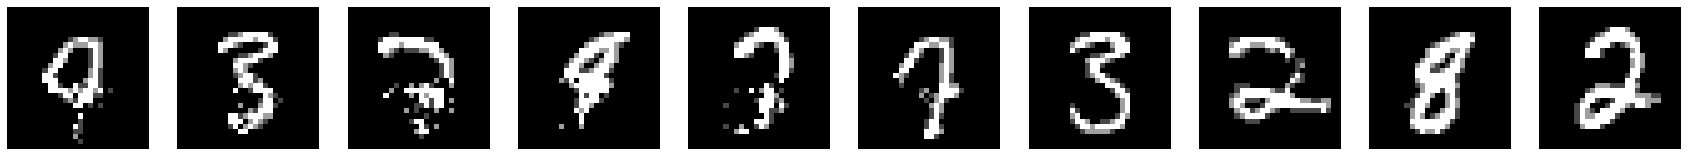

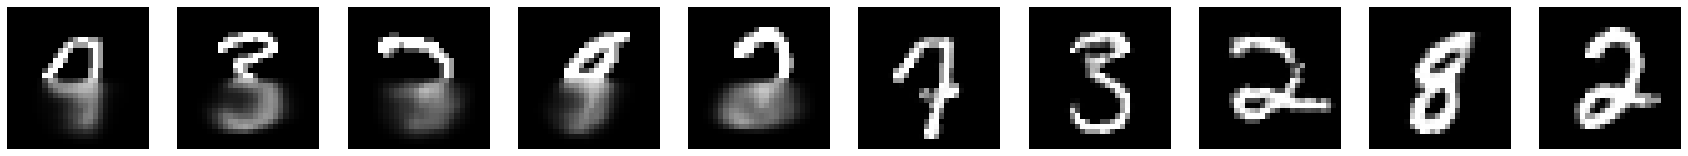

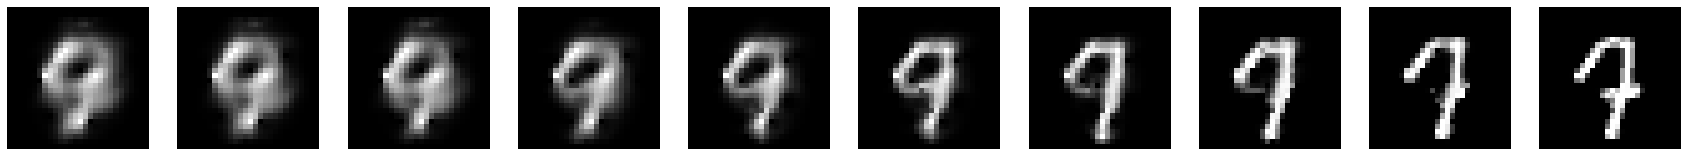

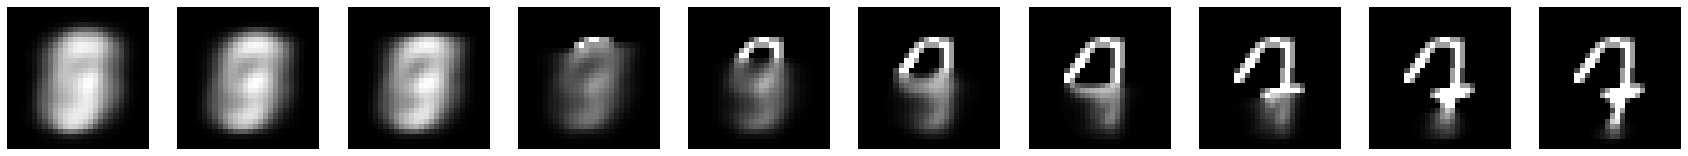

Step 86304, Loss (last minibatch): 0.1793878674507141, Loss (500 step avg.): 0.2010403260618389


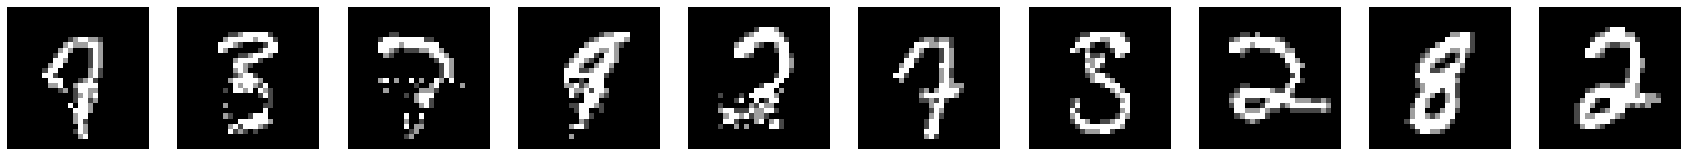

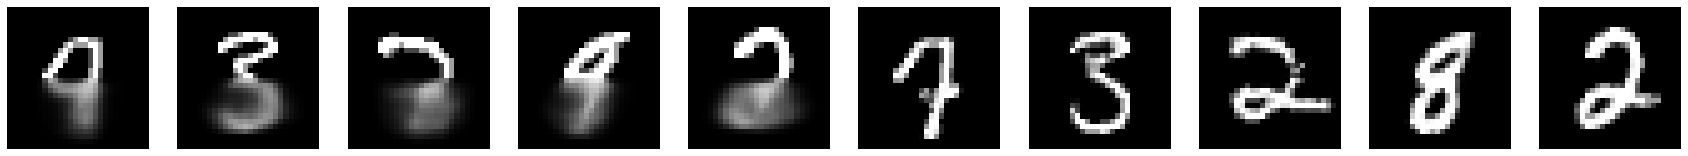

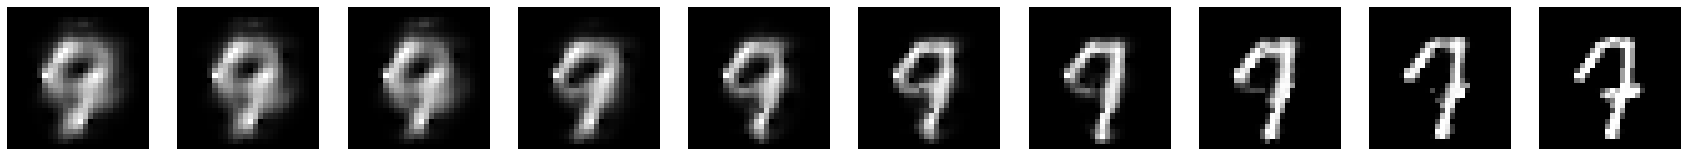

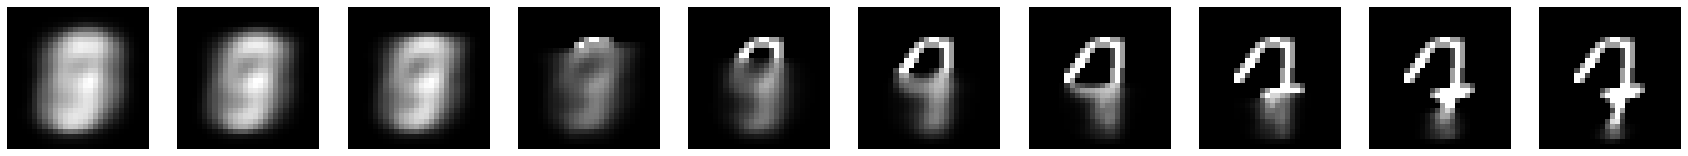

Step 87304, Loss (last minibatch): 0.23912864923477173, Loss (500 step avg.): 0.19892230131728444


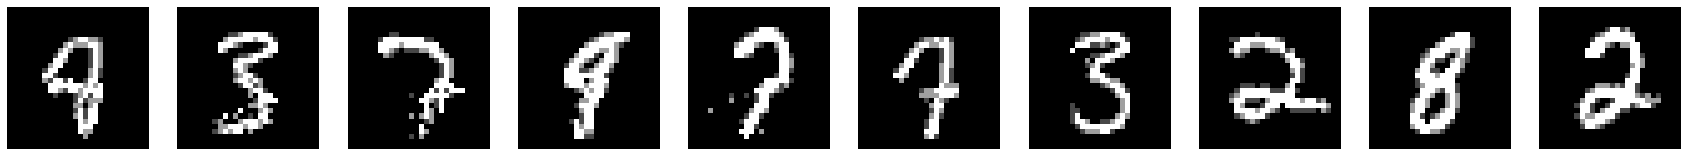

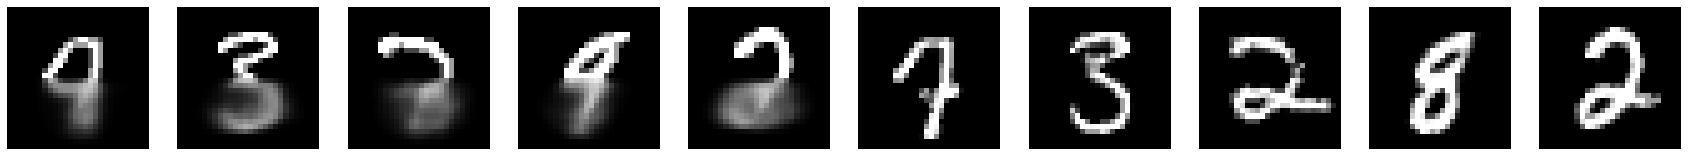

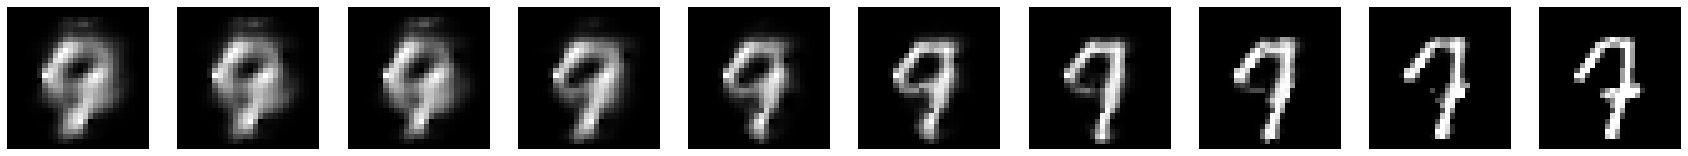

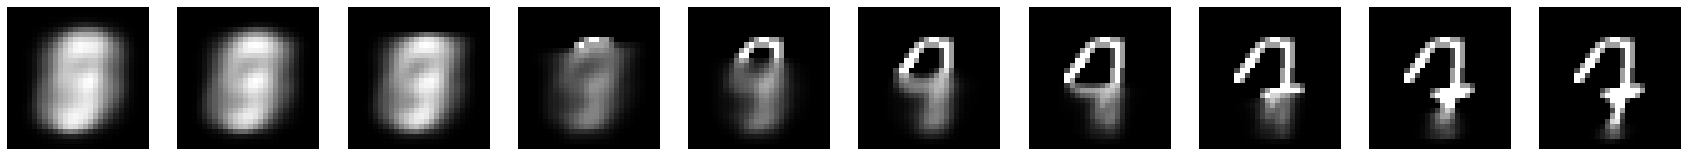

Step 88304, Loss (last minibatch): 0.1996232271194458, Loss (500 step avg.): 0.20283105880200505


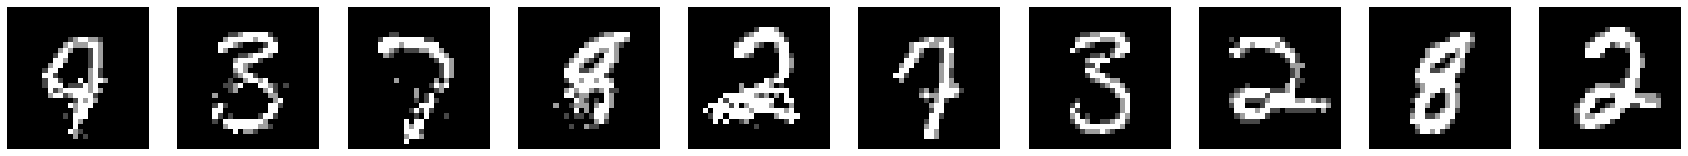

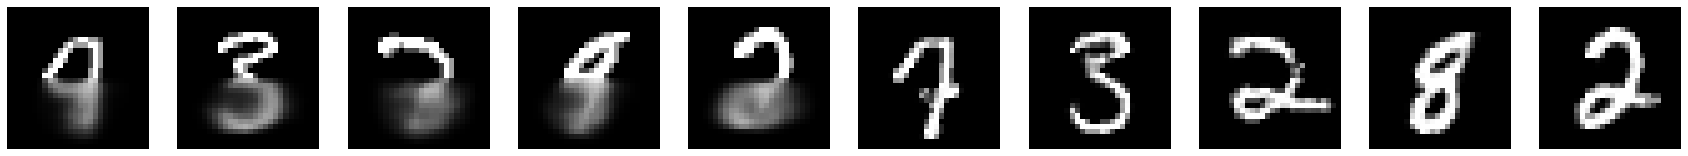

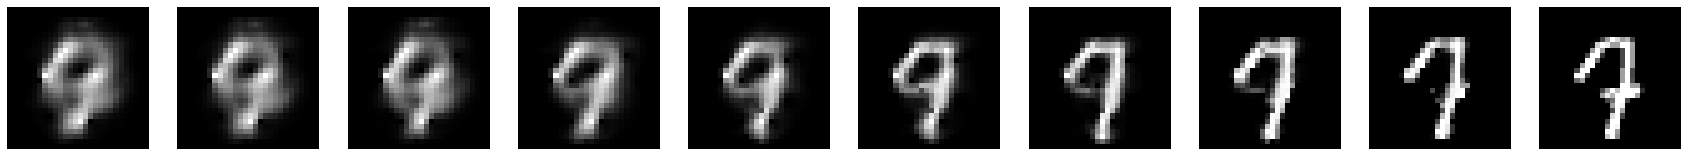

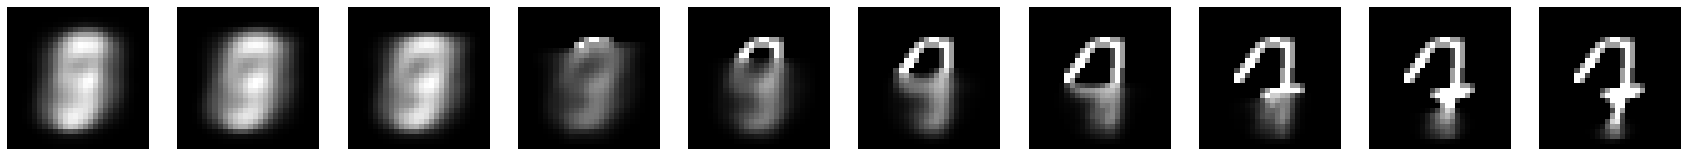

Step 89304, Loss (last minibatch): 0.1552232801914215, Loss (500 step avg.): 0.20121632897092434


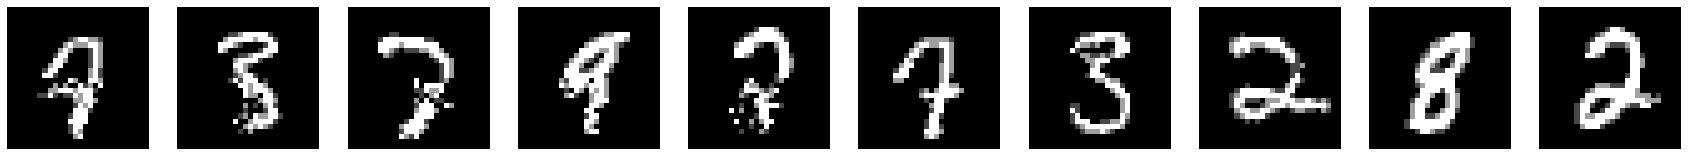

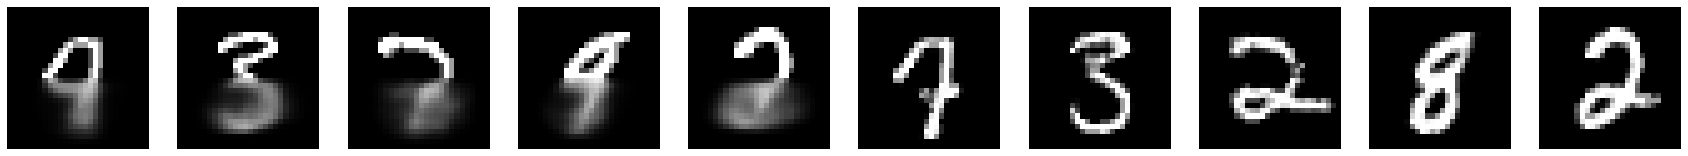

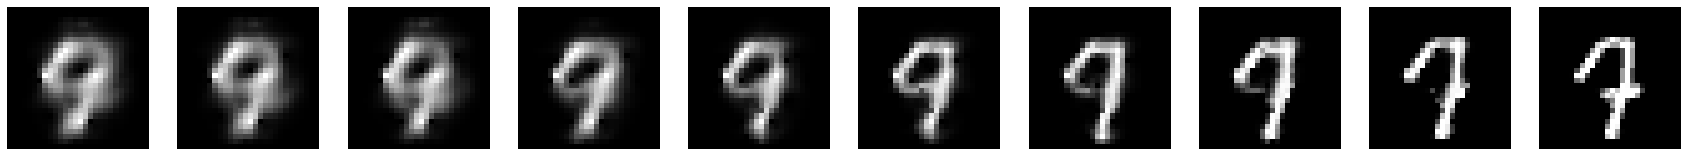

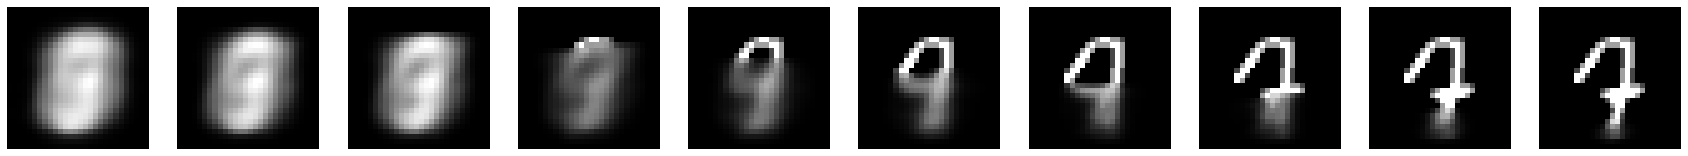

Step 90304, Loss (last minibatch): 0.28517407178878784, Loss (500 step avg.): 0.20023039152879202


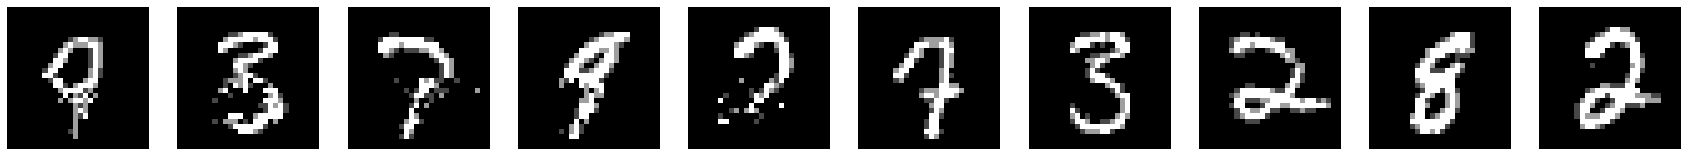

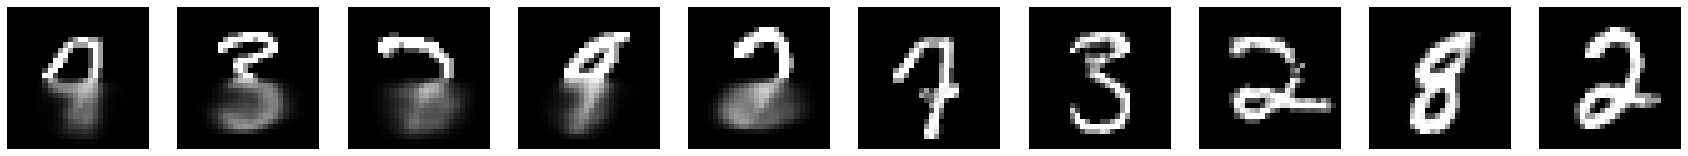

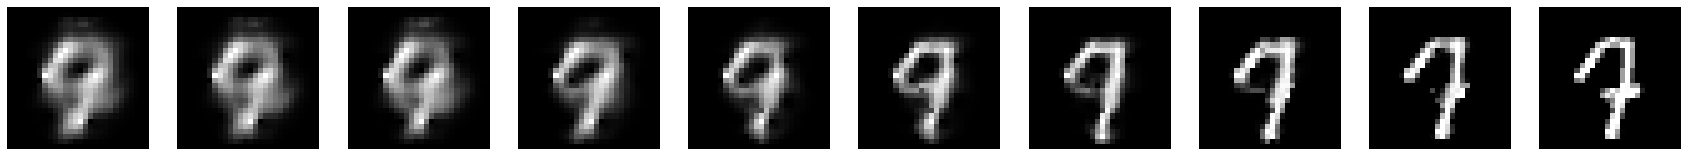

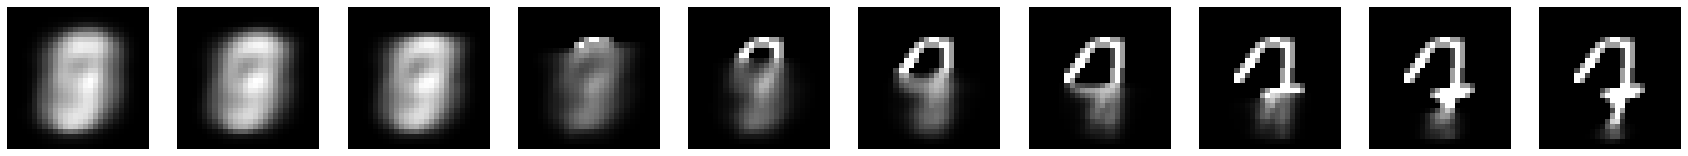

Step 91304, Loss (last minibatch): 0.24129919707775116, Loss (500 step avg.): 0.19865609336636975


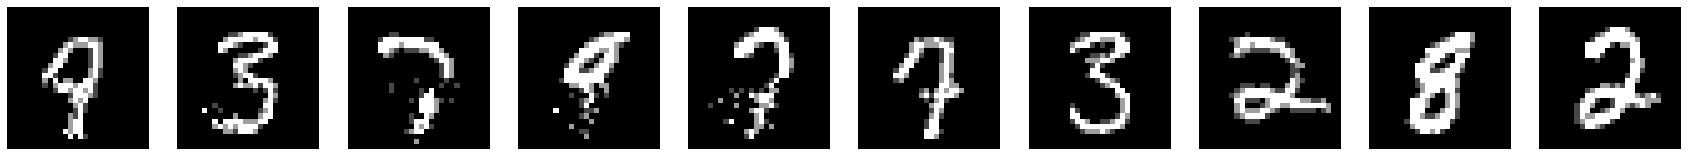

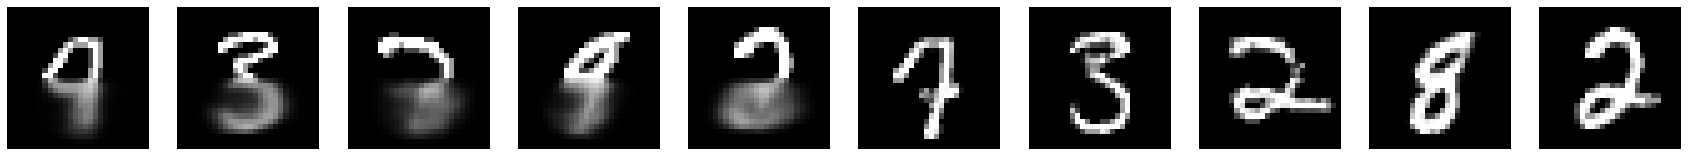

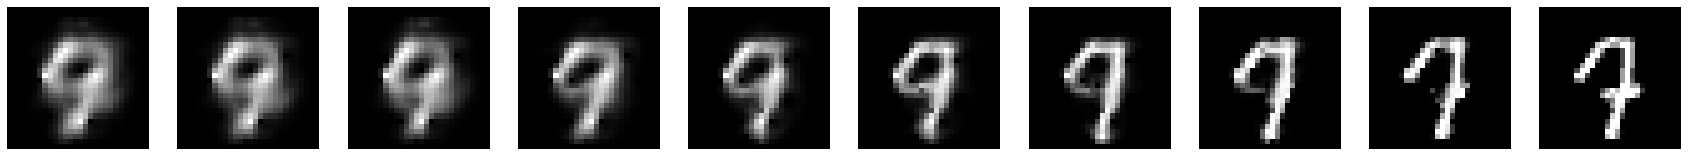

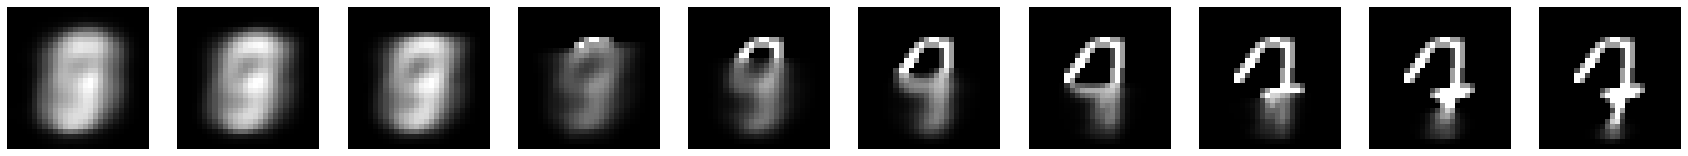

Step 92304, Loss (last minibatch): 0.17533975839614868, Loss (500 step avg.): 0.20122606454495184


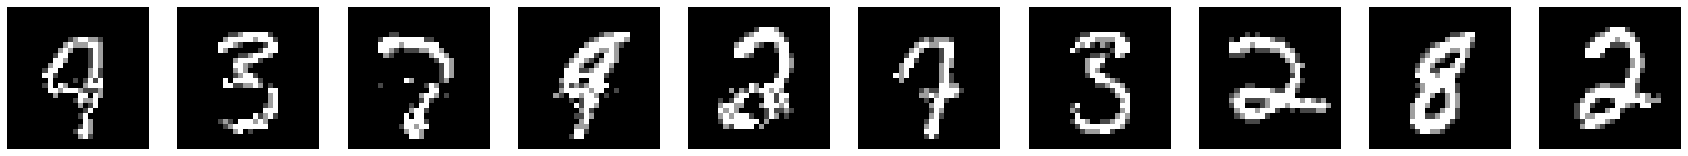

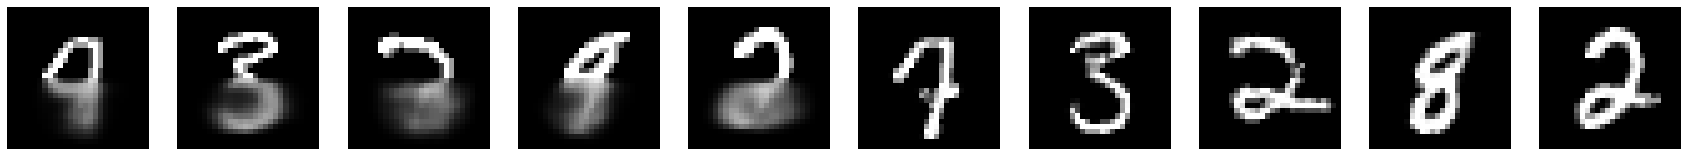

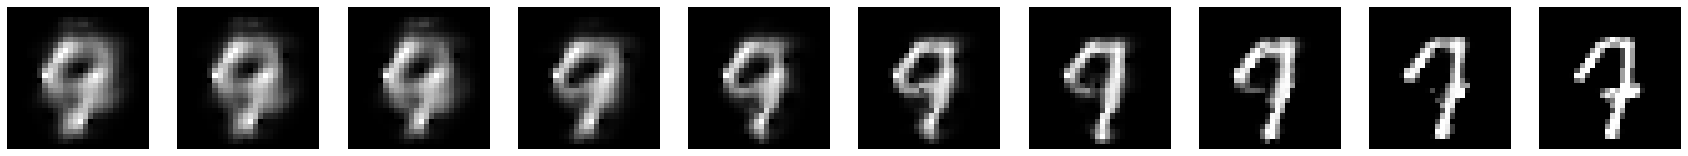

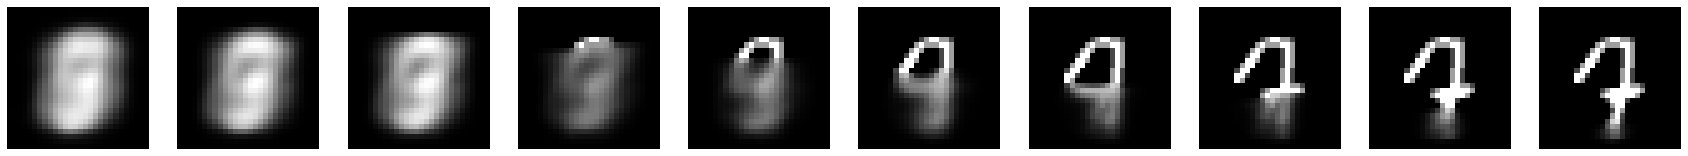

Step 93304, Loss (last minibatch): 0.29902034997940063, Loss (500 step avg.): 0.20069519643060224


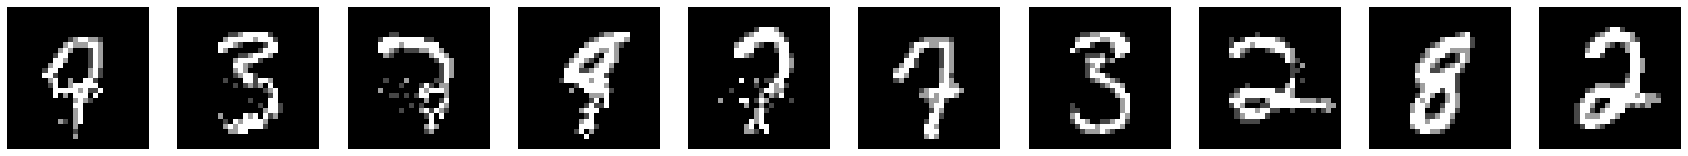

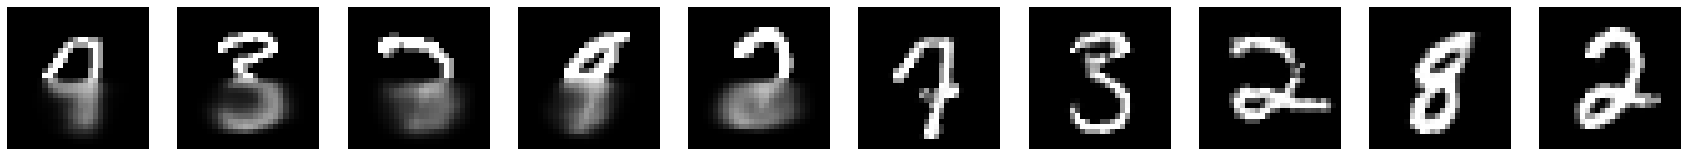

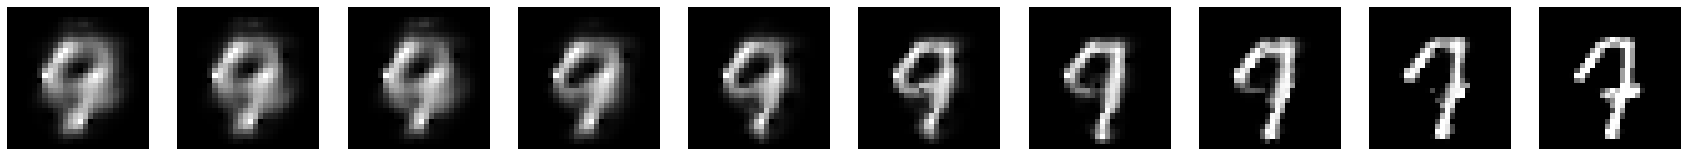

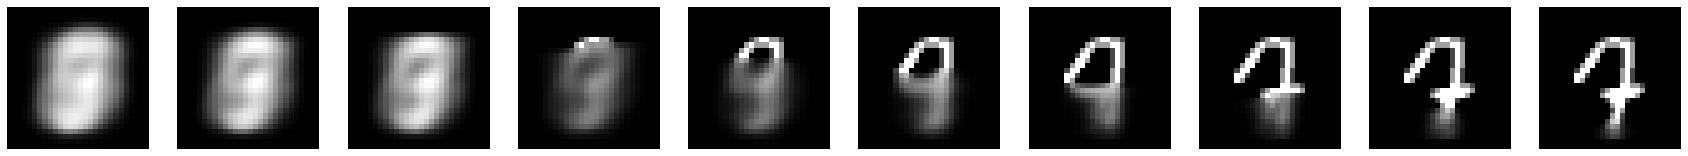

Step 94304, Loss (last minibatch): 0.16778337955474854, Loss (500 step avg.): 0.19602291663725696


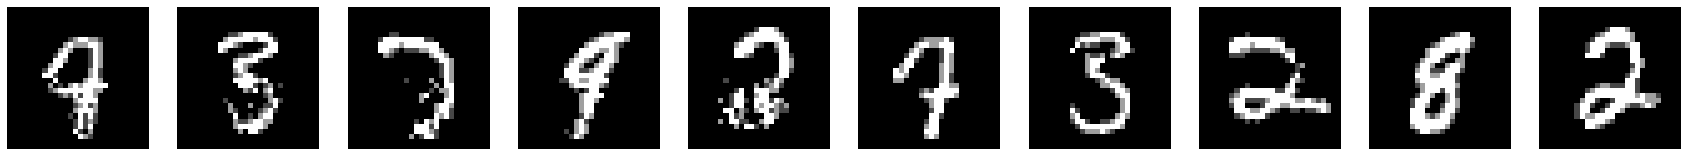

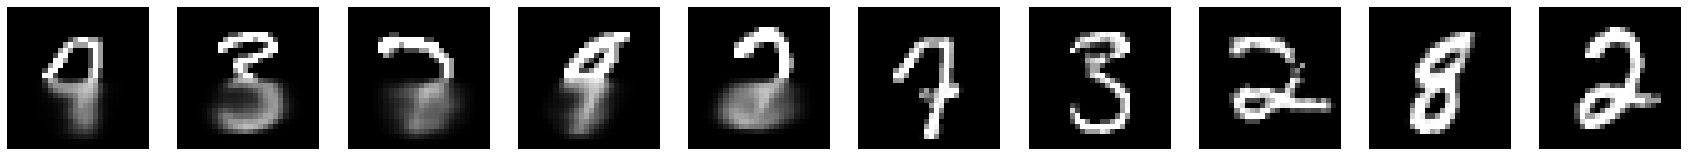

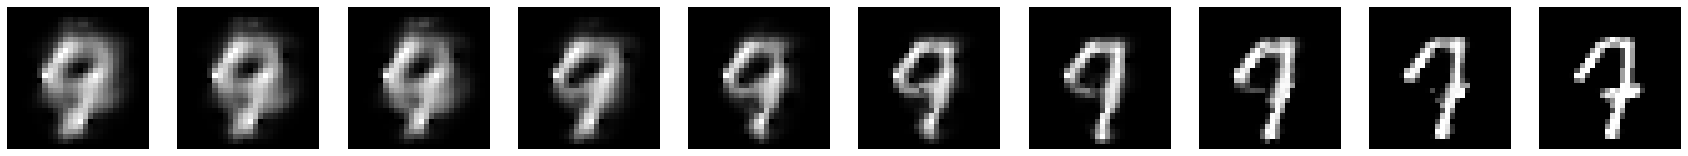

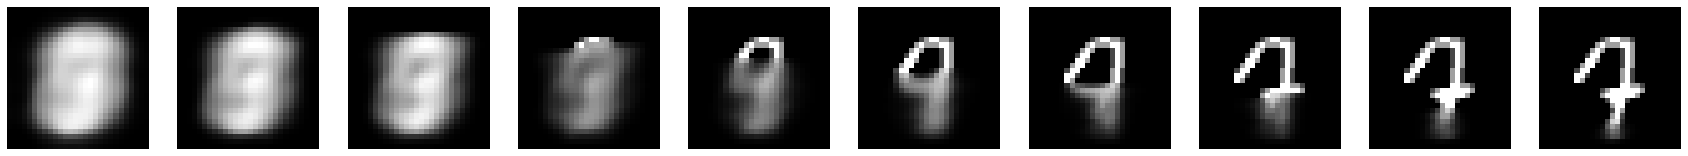

Step 95304, Loss (last minibatch): 0.21778379380702972, Loss (500 step avg.): 0.20145143382623049


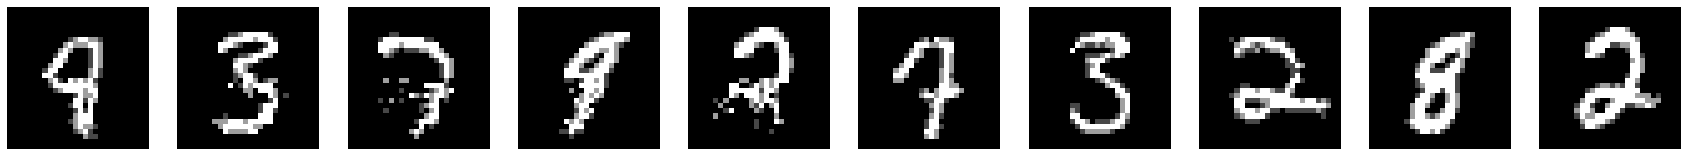

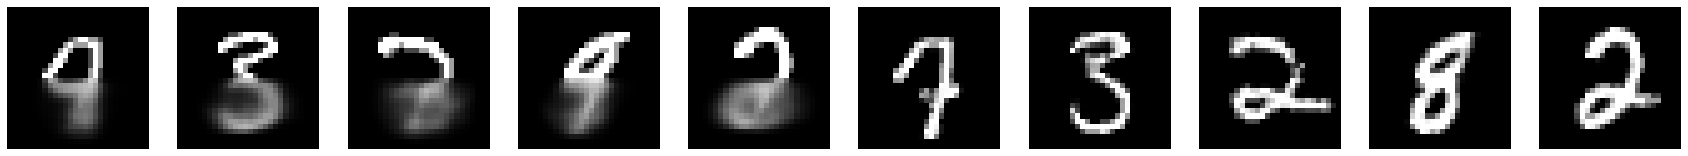

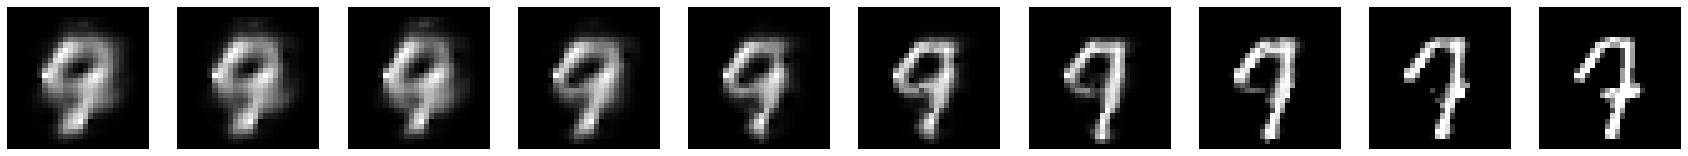

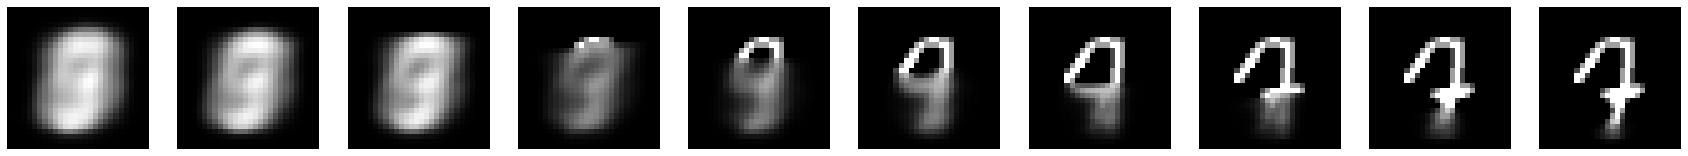

Step 96304, Loss (last minibatch): 0.24124780297279358, Loss (500 step avg.): 0.19899667844087063


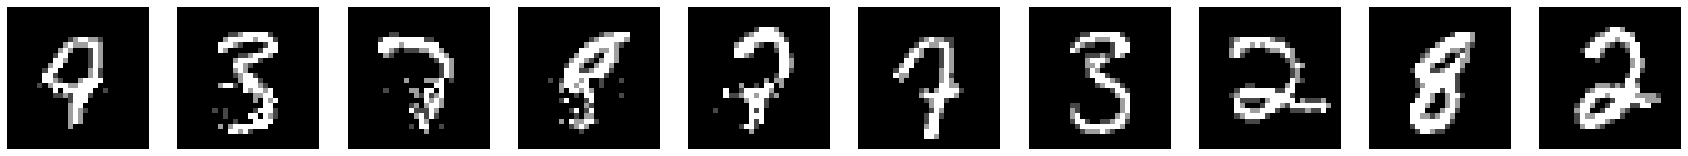

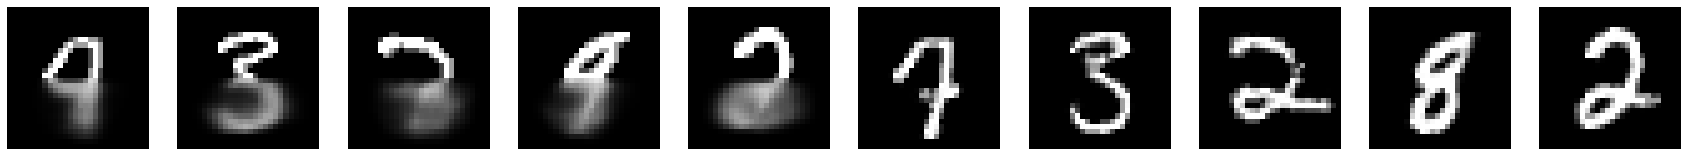

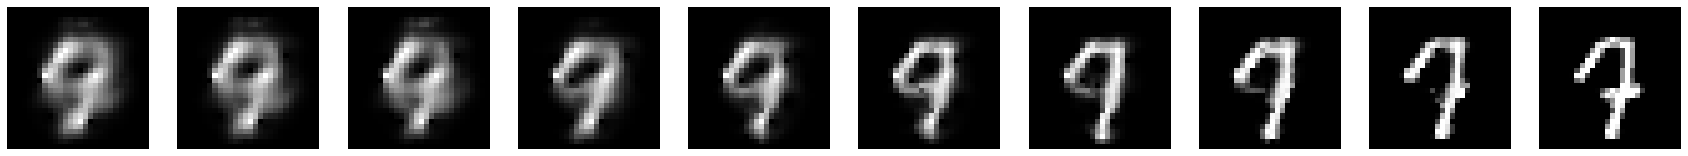

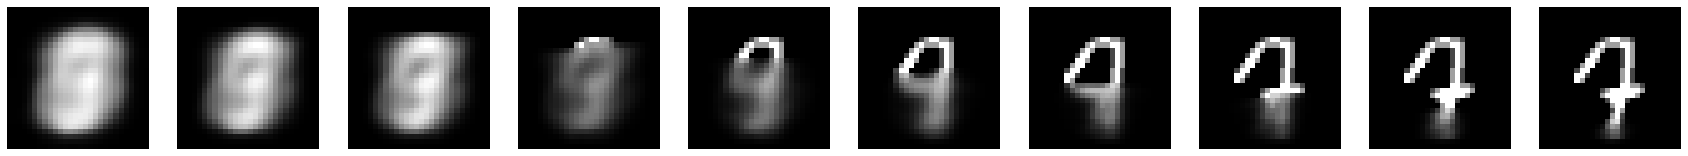

Step 97304, Loss (last minibatch): 0.14679577946662903, Loss (500 step avg.): 0.1966291326665117


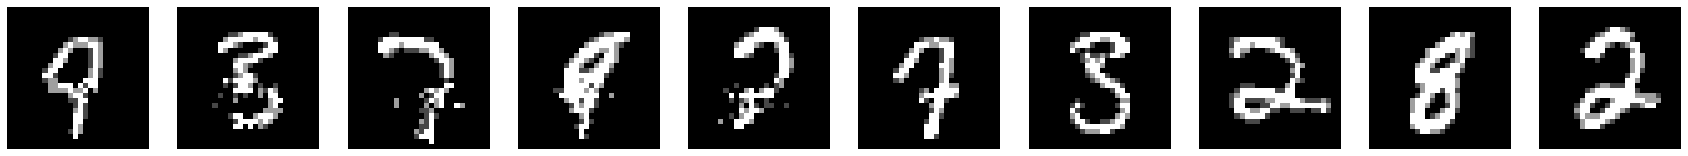

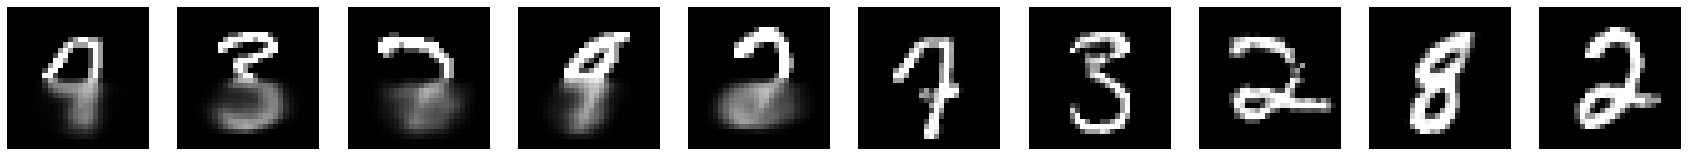

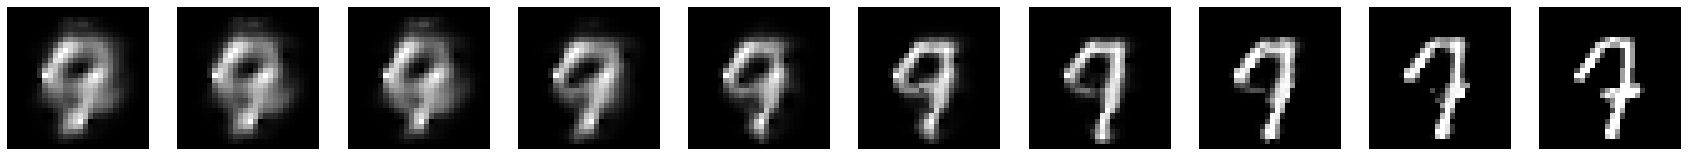

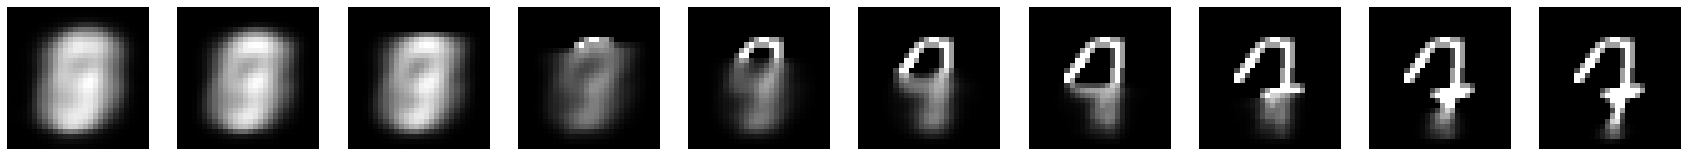

Step 98304, Loss (last minibatch): 0.16082125902175903, Loss (500 step avg.): 0.1983401435696912


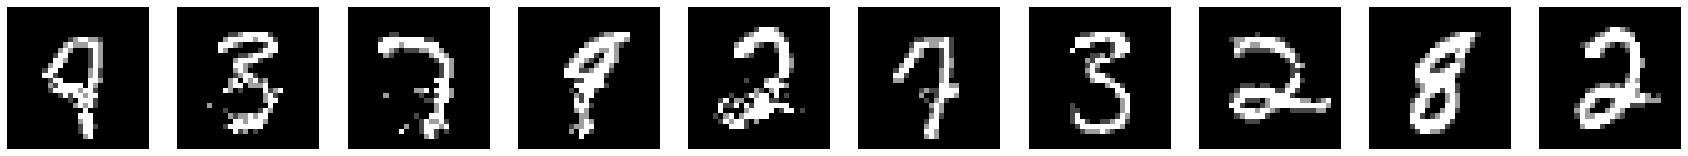

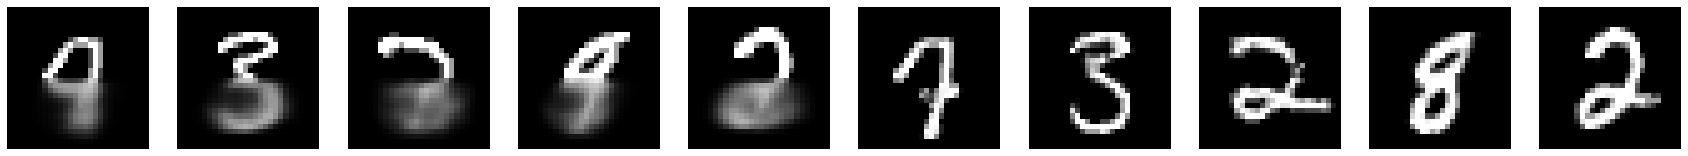

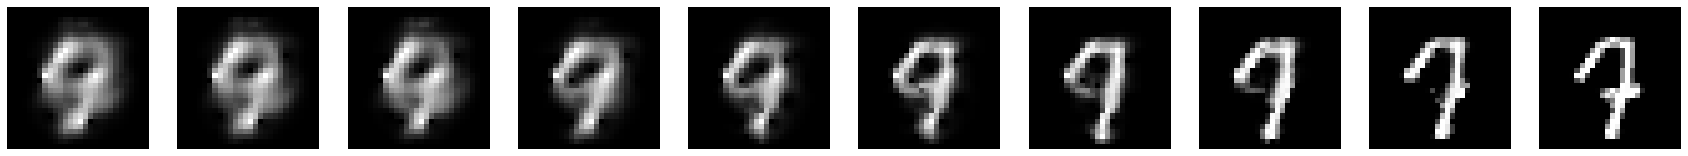

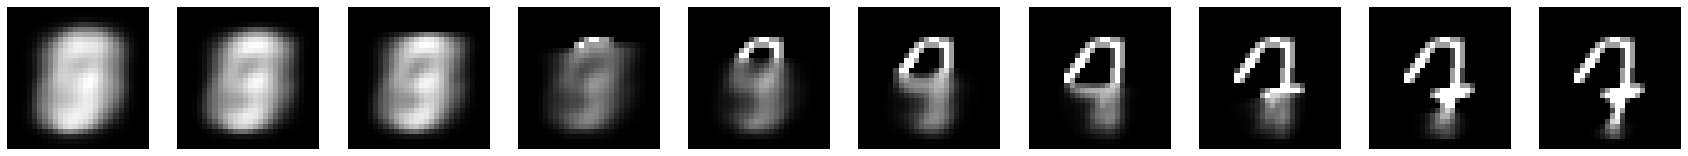

Step 99304, Loss (last minibatch): 0.19094669818878174, Loss (500 step avg.): 0.20390851792699086


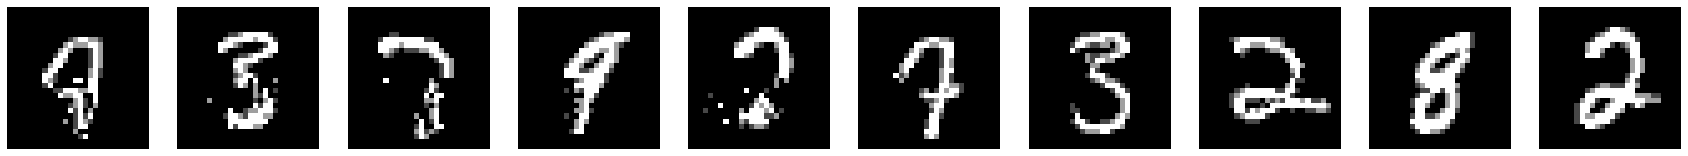

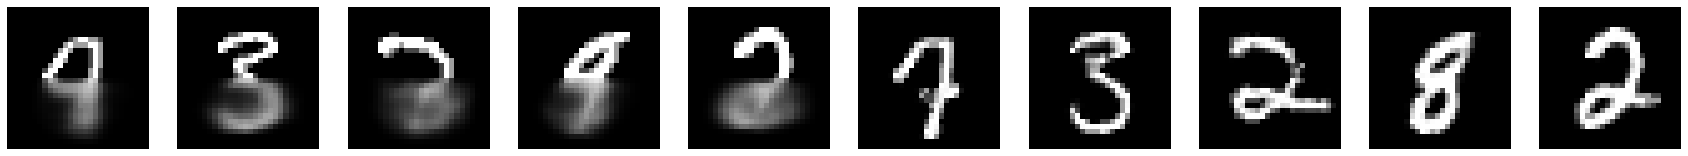

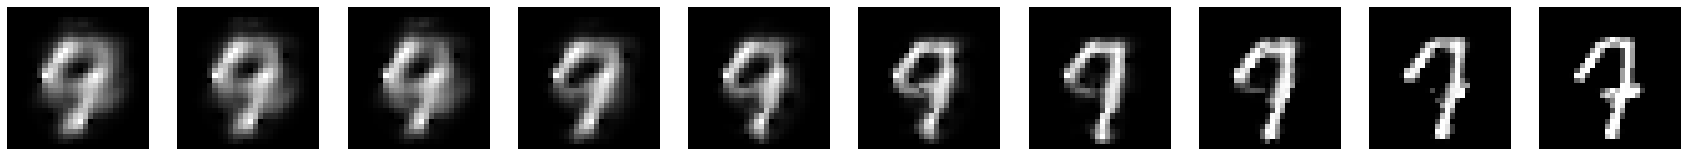

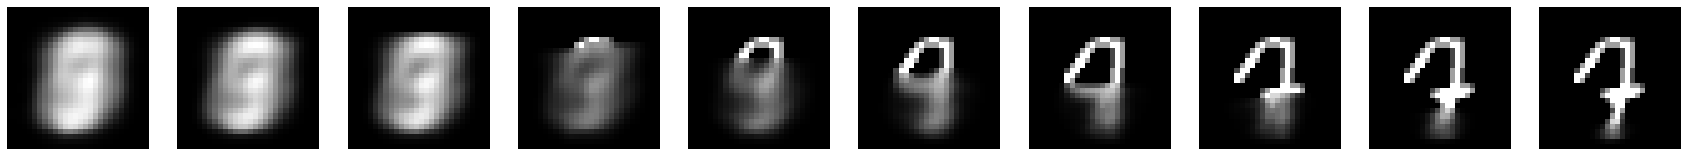

Step 100304, Loss (last minibatch): 0.15653863549232483, Loss (500 step avg.): 0.20033496004081297


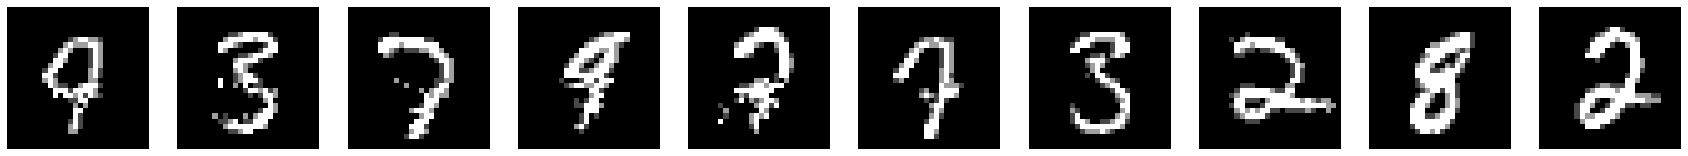

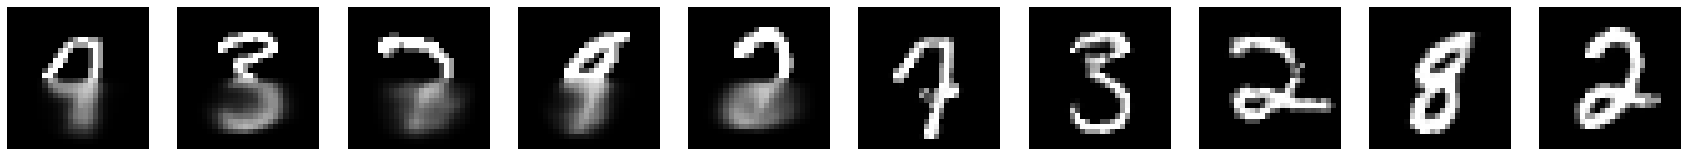

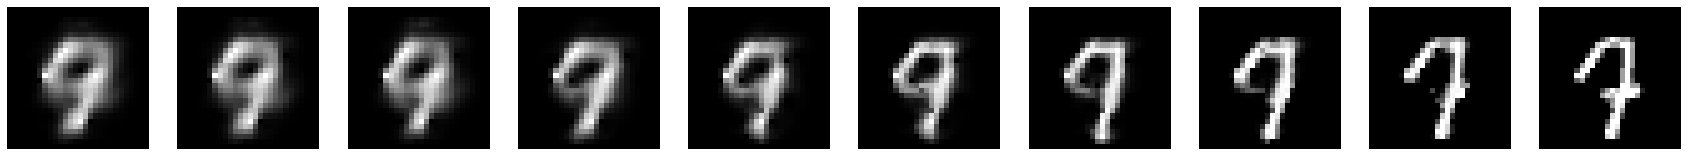

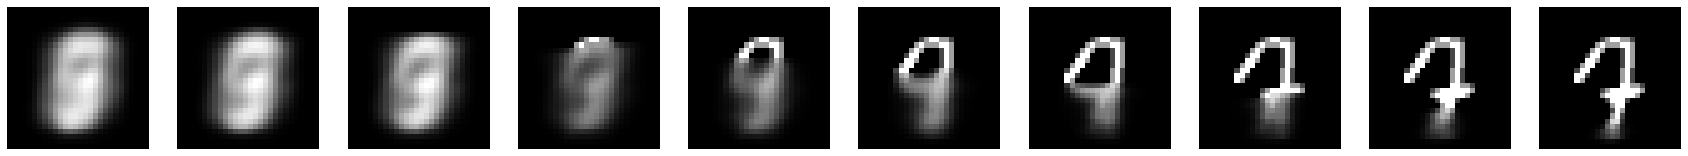

Step 101304, Loss (last minibatch): 0.22315971553325653, Loss (500 step avg.): 0.19657107854555705


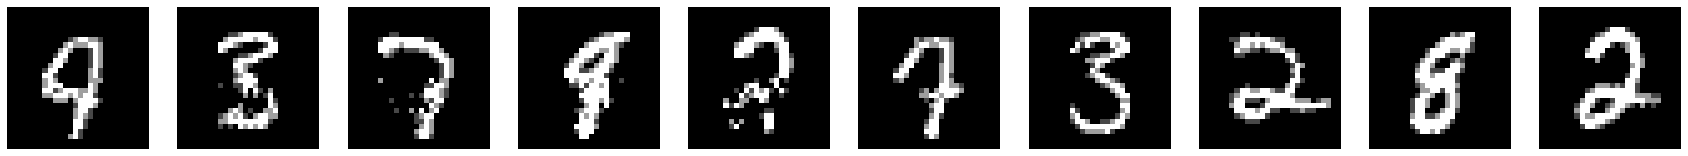

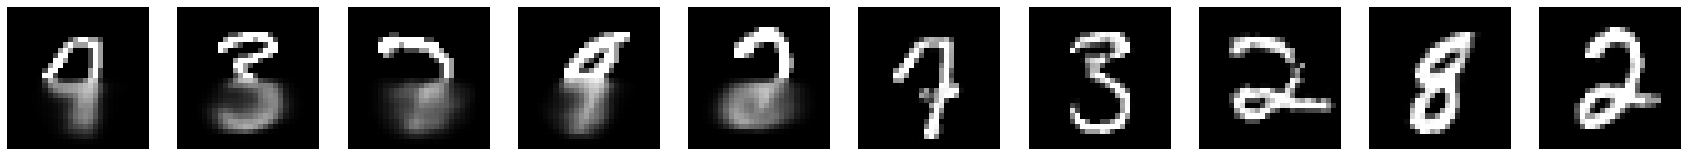

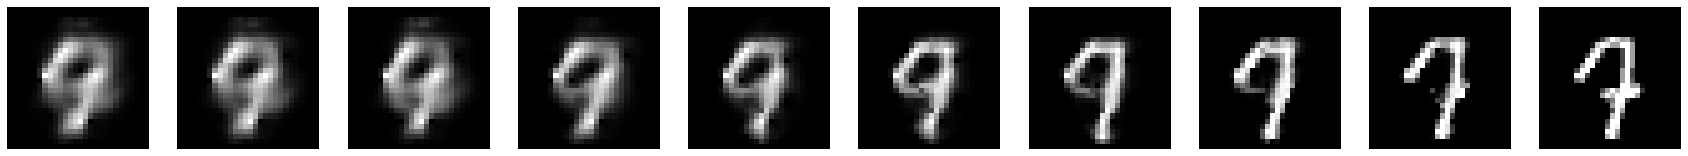

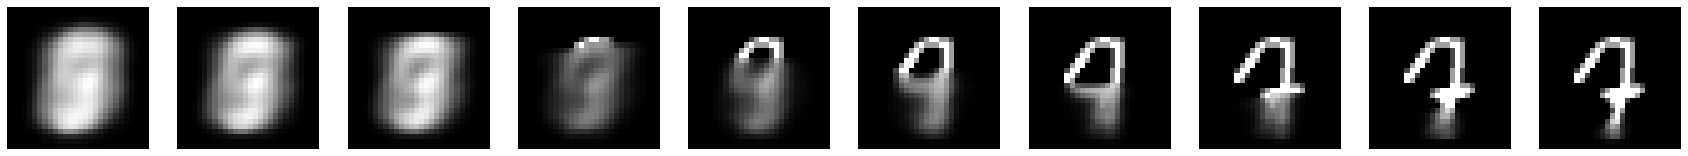

Step 102304, Loss (last minibatch): 0.18292012810707092, Loss (500 step avg.): 0.1986591175585212


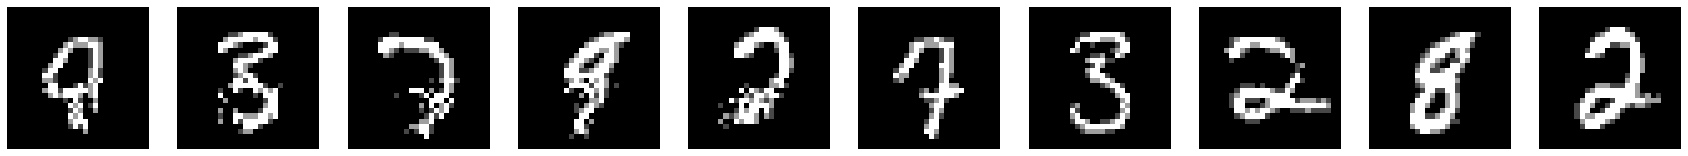

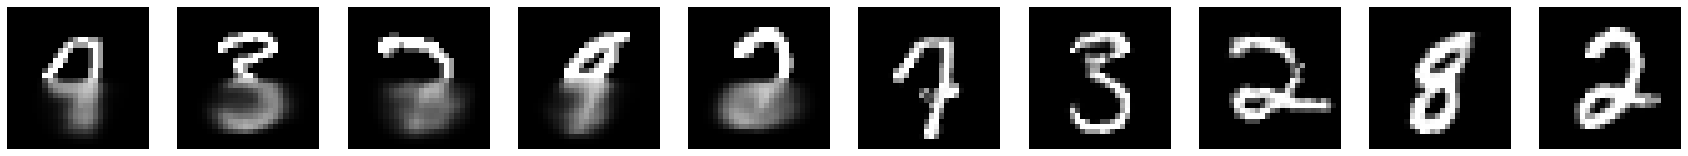

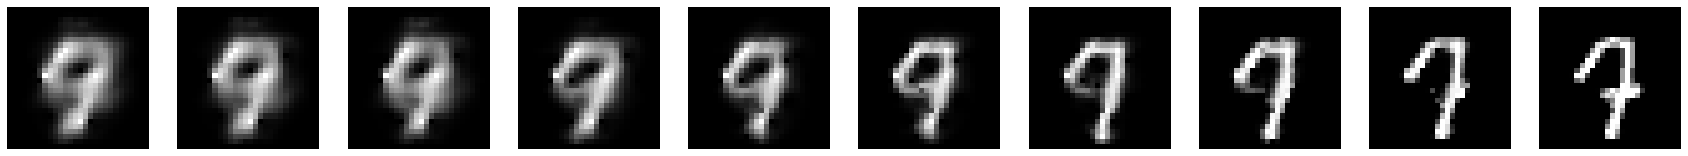

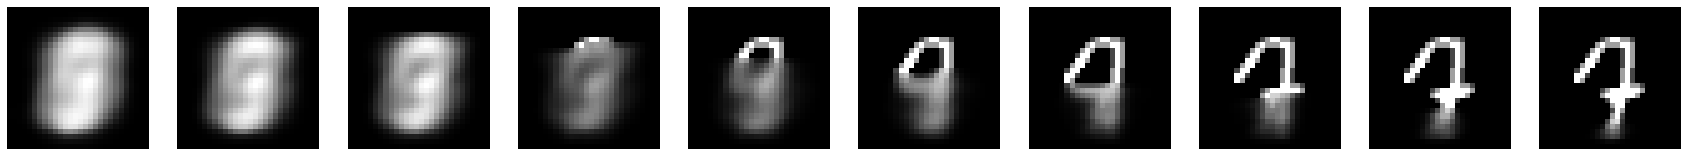

Step 103304, Loss (last minibatch): 0.2114640772342682, Loss (500 step avg.): 0.19620376700412728


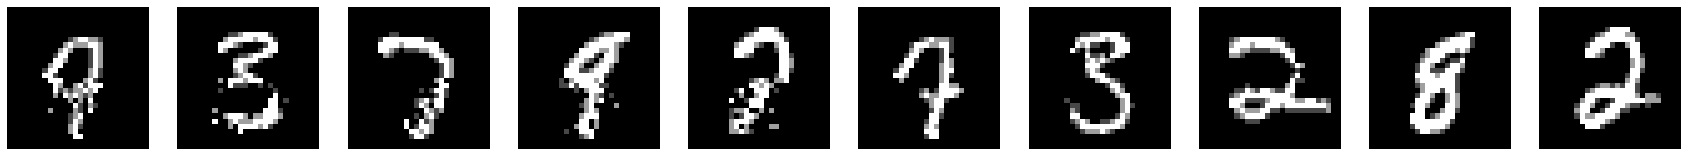

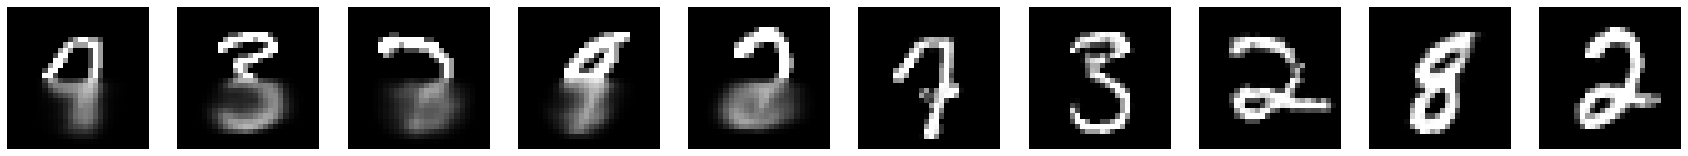

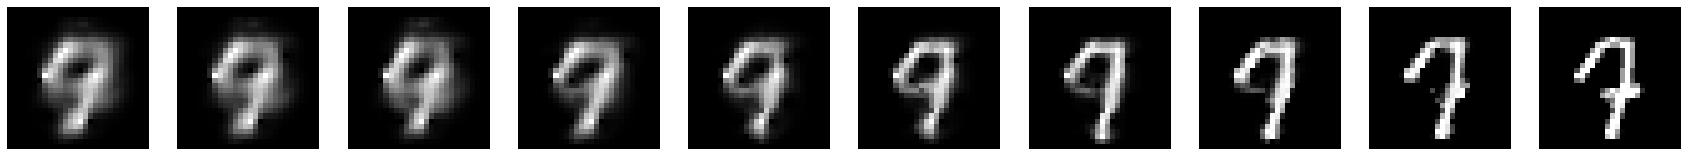

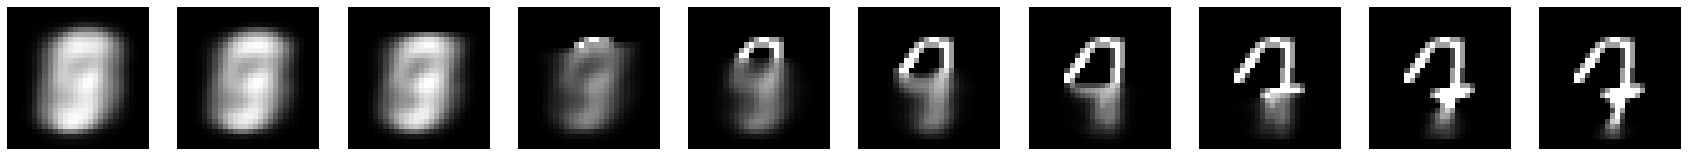

Step 104304, Loss (last minibatch): 0.20603513717651367, Loss (500 step avg.): 0.19758086270855335


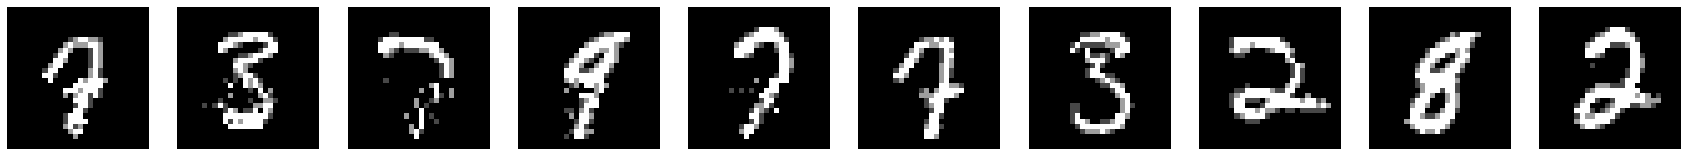

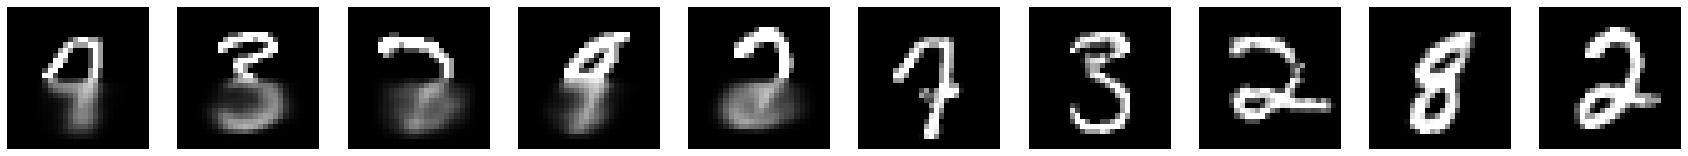

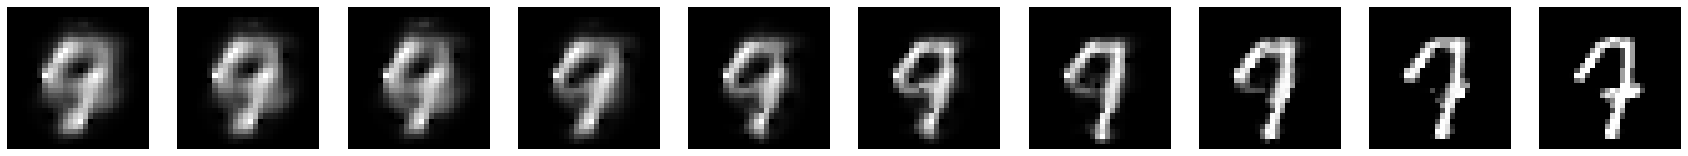

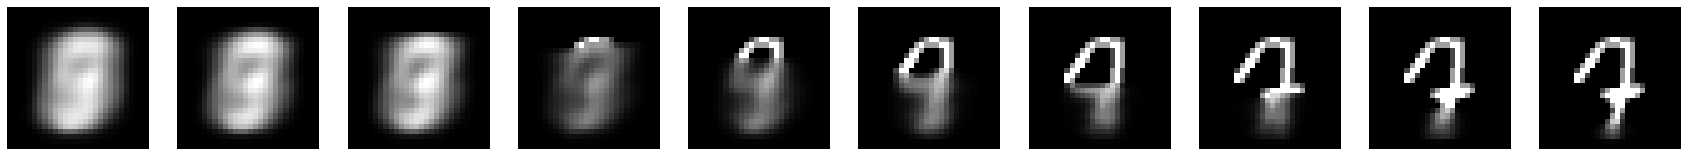

Step 105304, Loss (last minibatch): 0.2068101465702057, Loss (500 step avg.): 0.19556917419690573


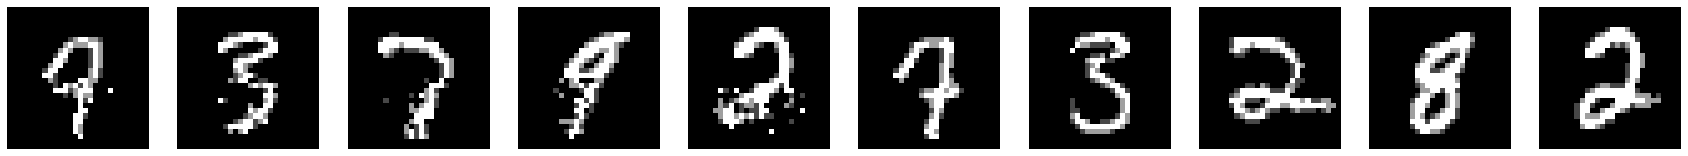

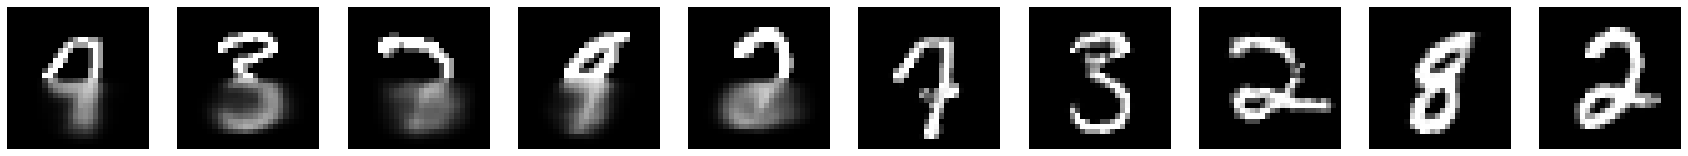

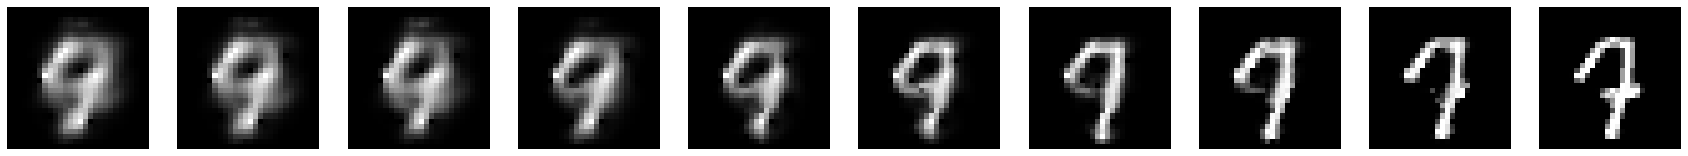

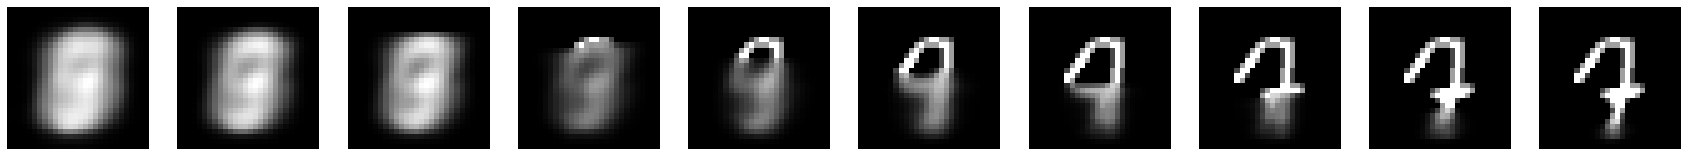

Step 106304, Loss (last minibatch): 0.2047991156578064, Loss (500 step avg.): 0.19772217622000776


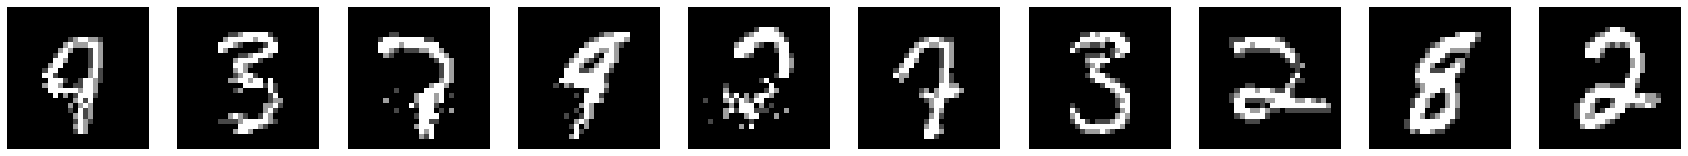

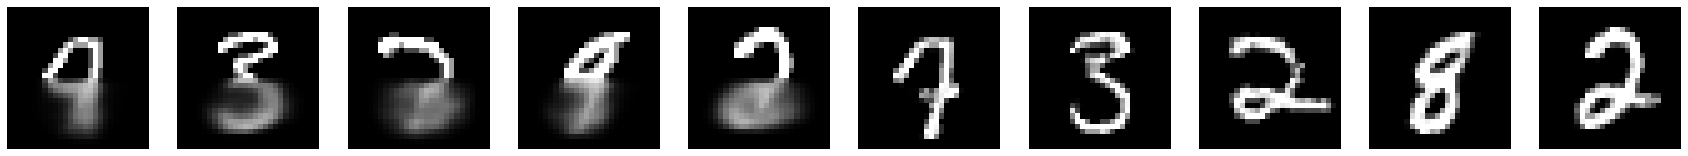

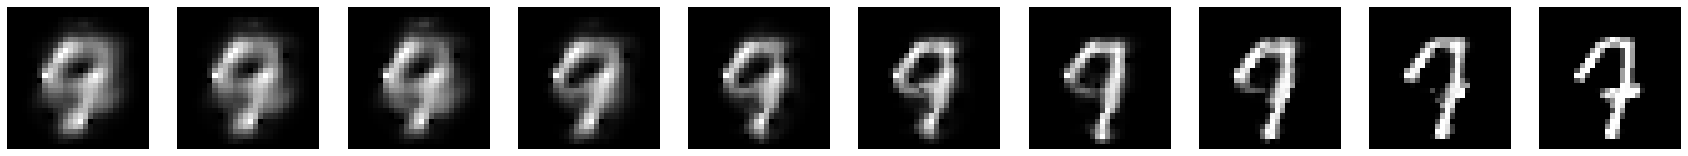

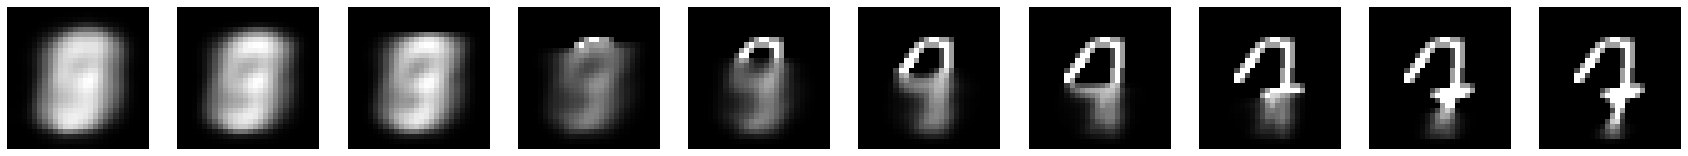

Step 107304, Loss (last minibatch): 0.18515895307064056, Loss (500 step avg.): 0.19451537027865826


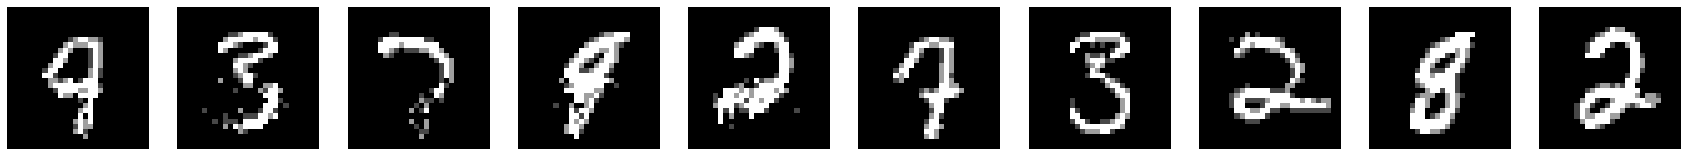

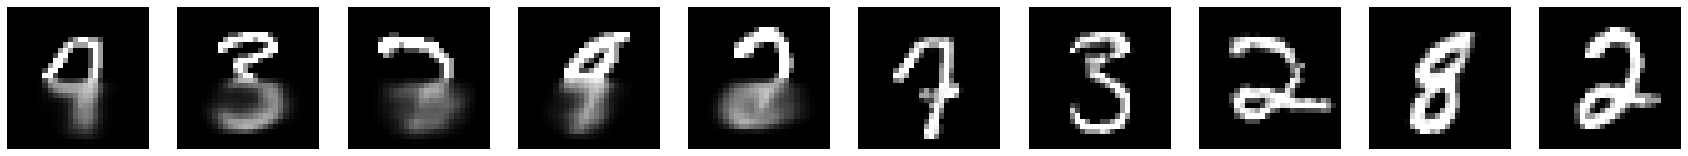

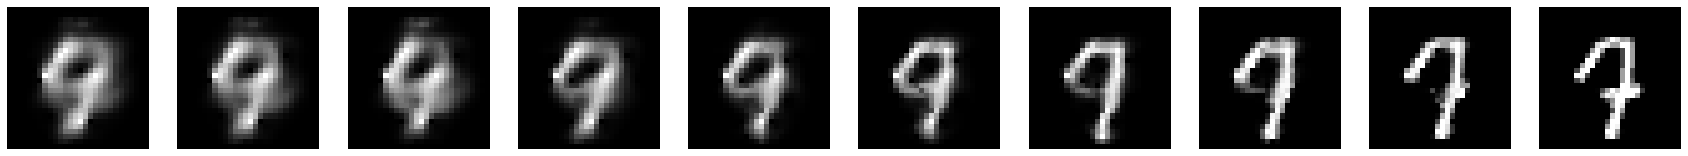

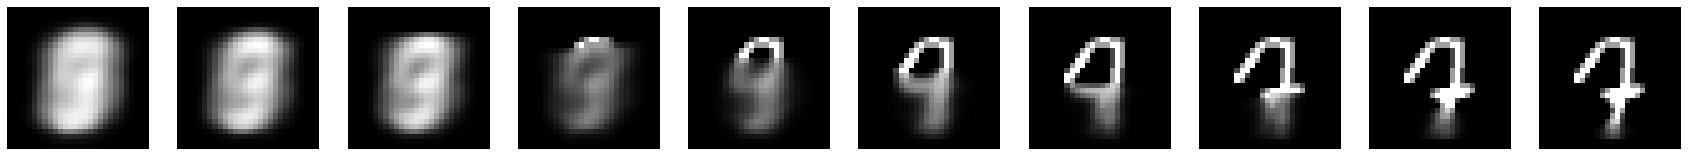

Step 108304, Loss (last minibatch): 0.23512570559978485, Loss (500 step avg.): 0.19649263336035067


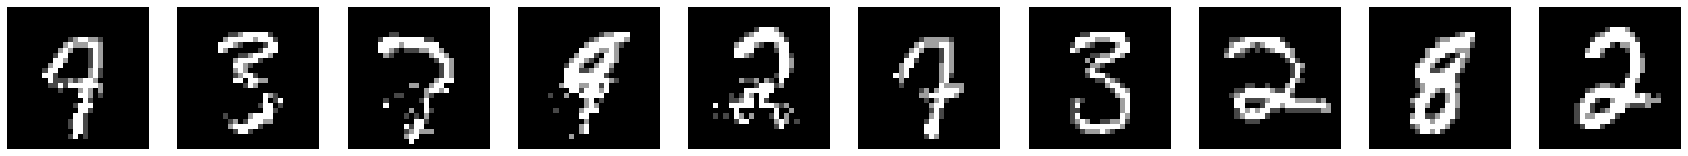

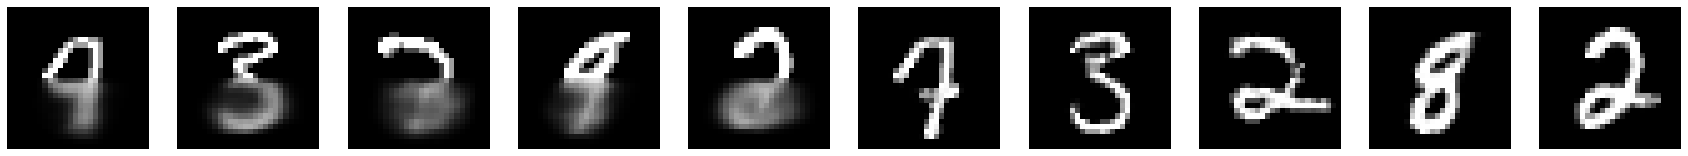

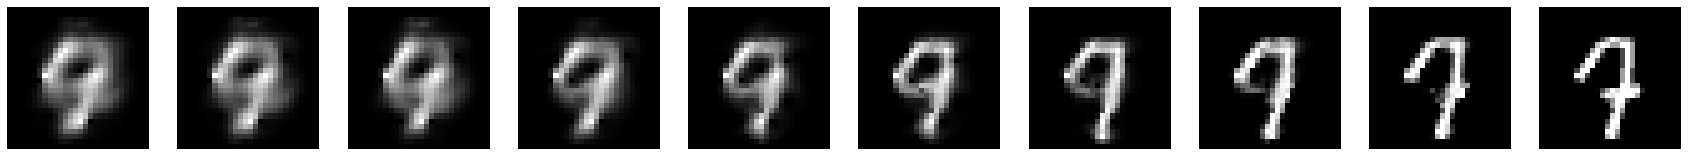

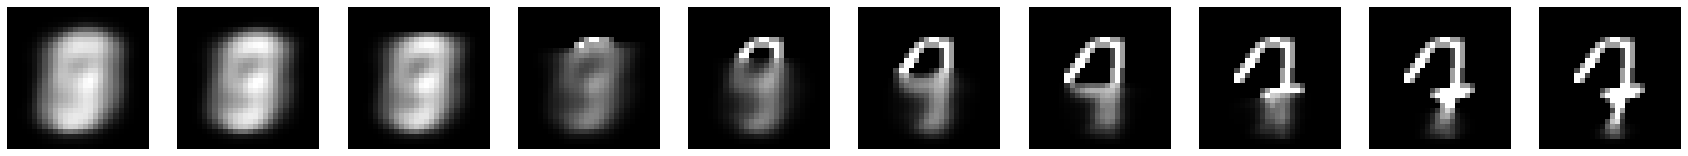

Step 109304, Loss (last minibatch): 0.20362406969070435, Loss (500 step avg.): 0.19834644851570357


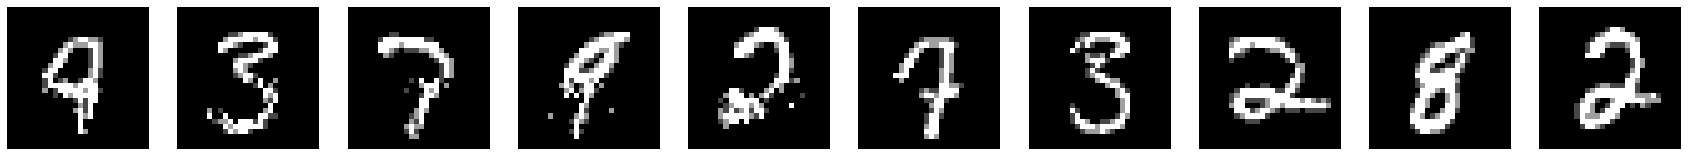

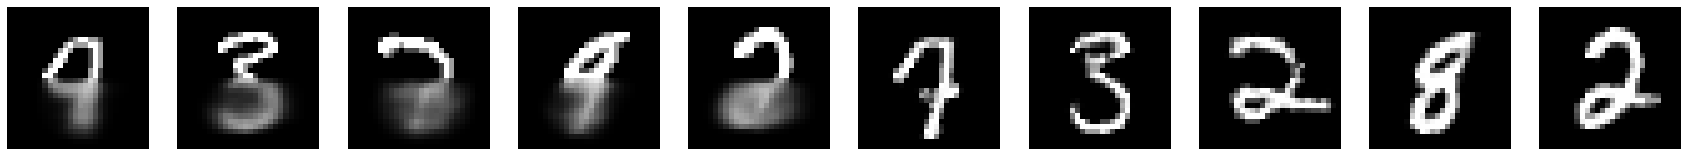

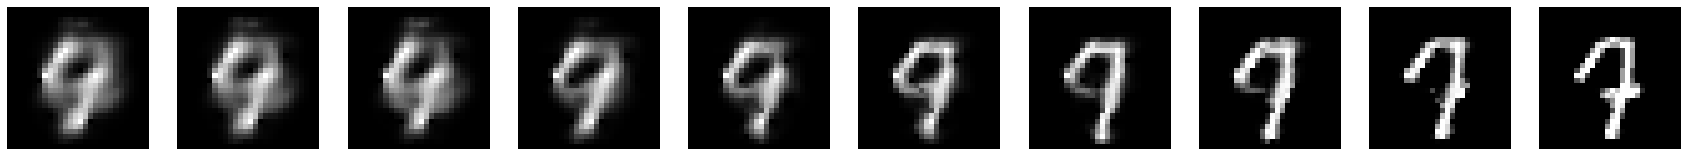

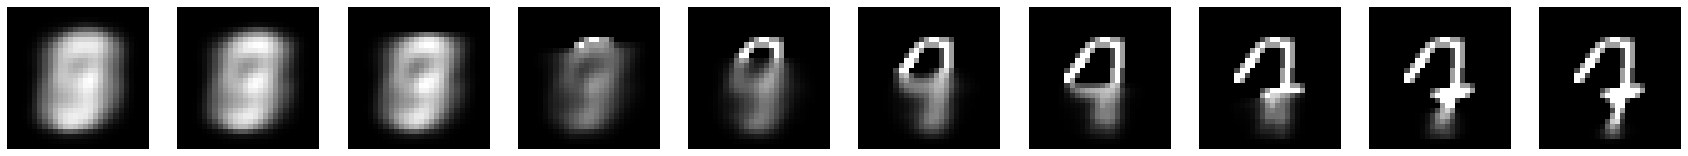

Step 110304, Loss (last minibatch): 0.16698317229747772, Loss (500 step avg.): 0.1936758896726334


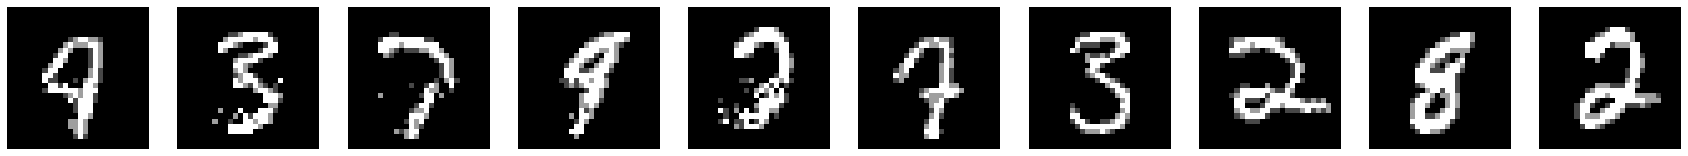

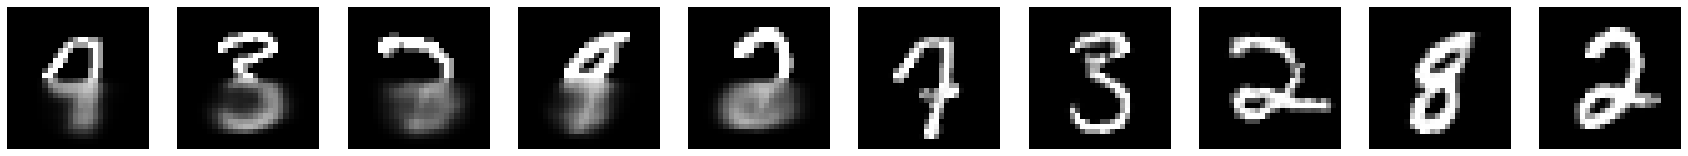

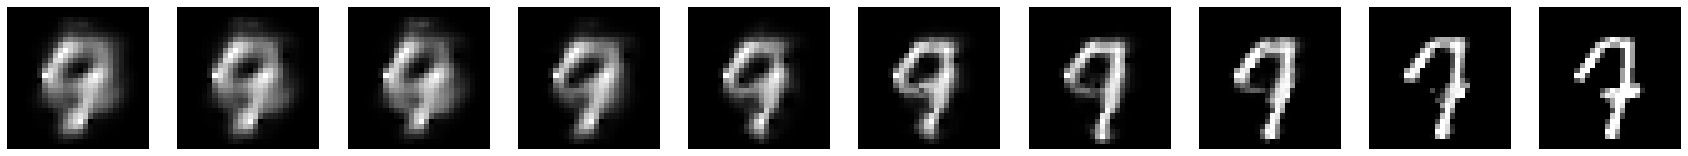

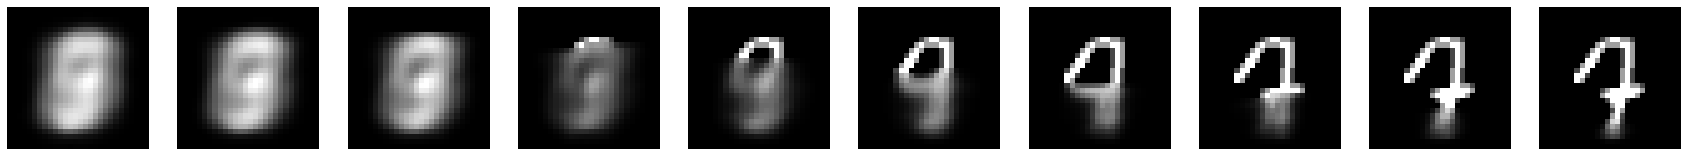

Step 111304, Loss (last minibatch): 0.18942901492118835, Loss (500 step avg.): 0.19559441712088213


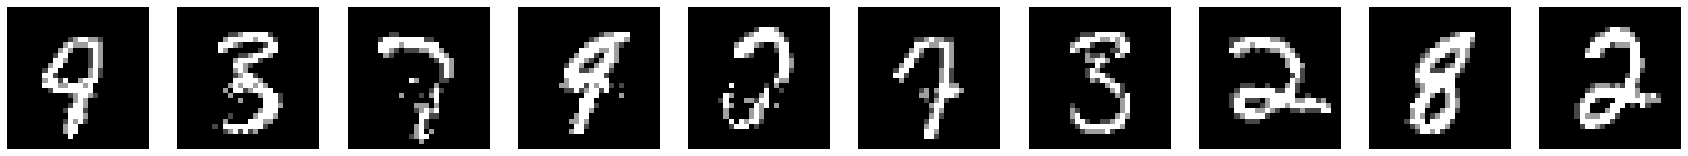

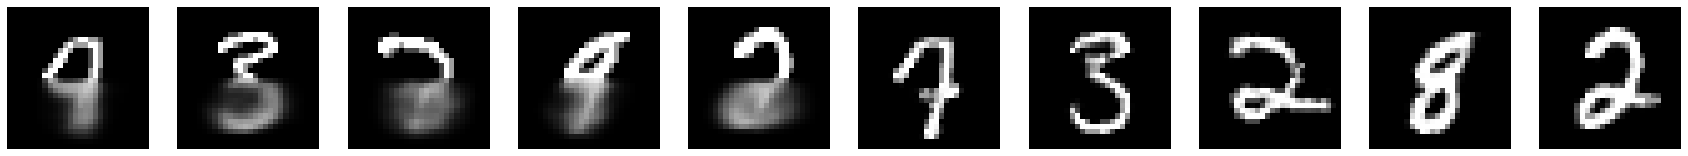

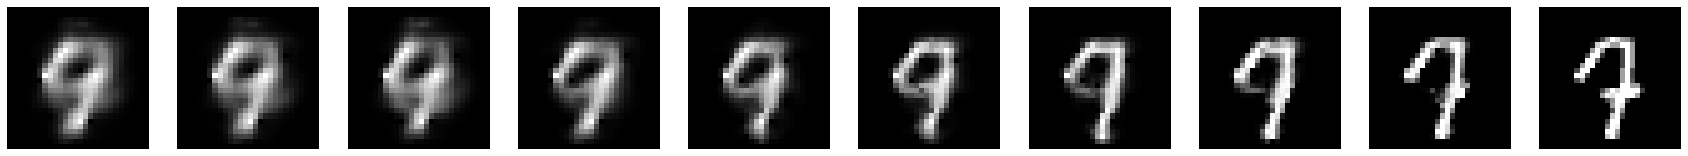

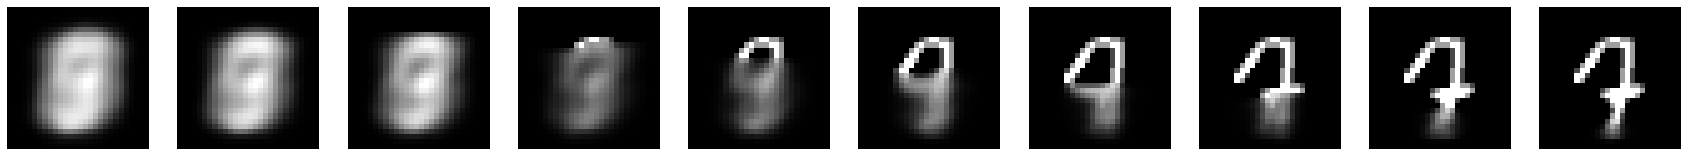

Step 112304, Loss (last minibatch): 0.2772955298423767, Loss (500 step avg.): 0.19901975965547467


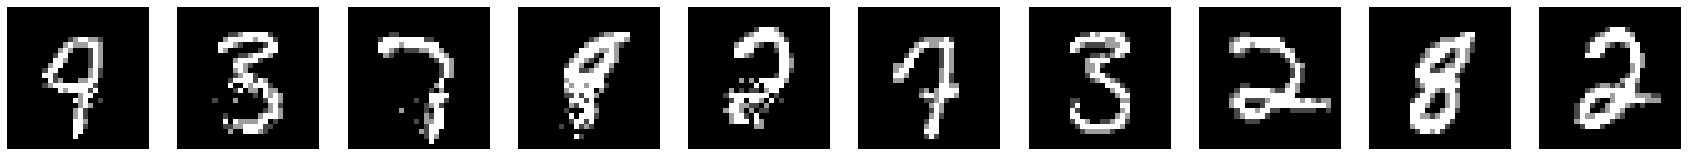

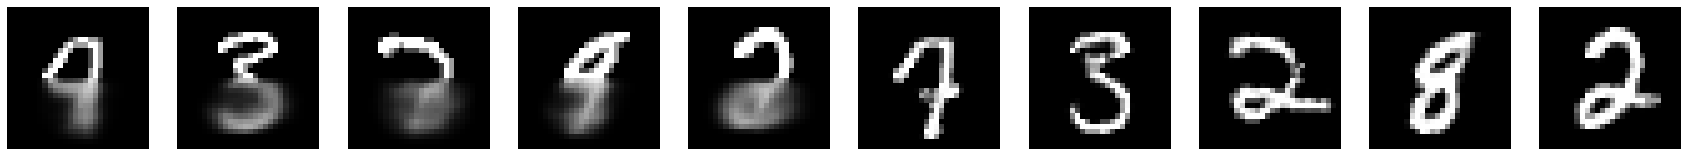

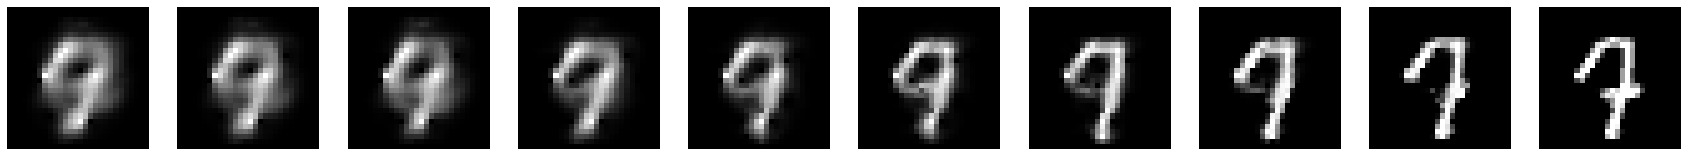

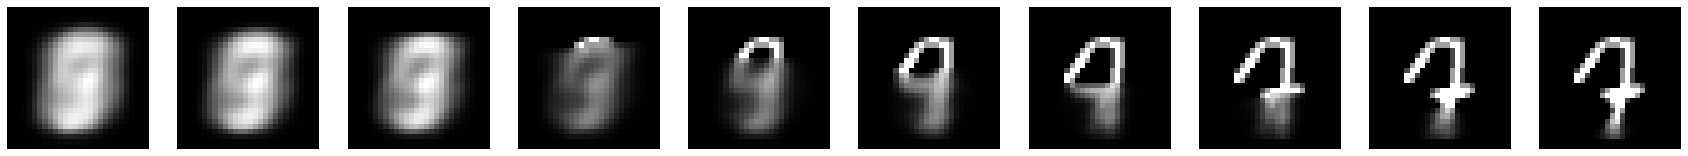

Step 113304, Loss (last minibatch): 0.13555485010147095, Loss (500 step avg.): 0.19470814771637945


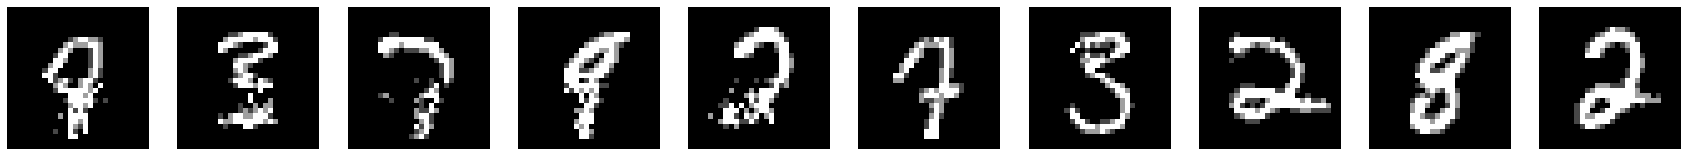

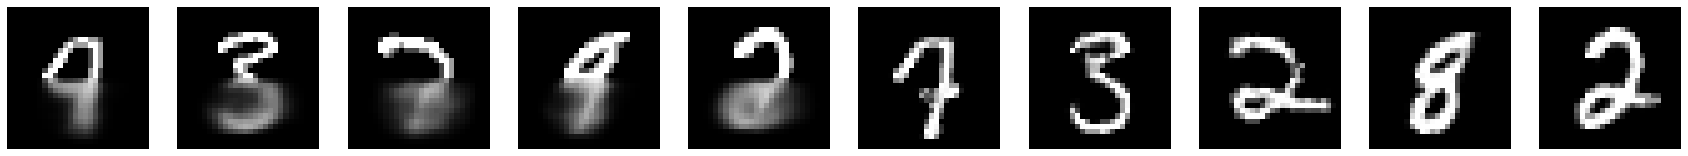

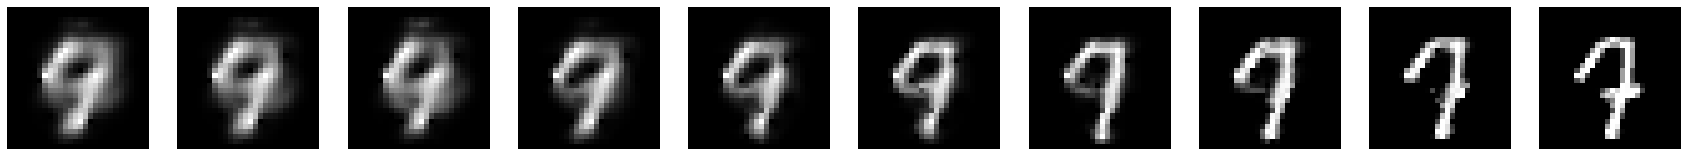

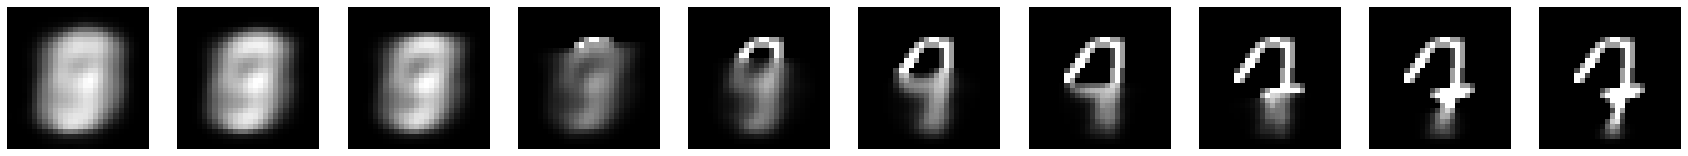

Step 114304, Loss (last minibatch): 0.23605039715766907, Loss (500 step avg.): 0.19346148427018148


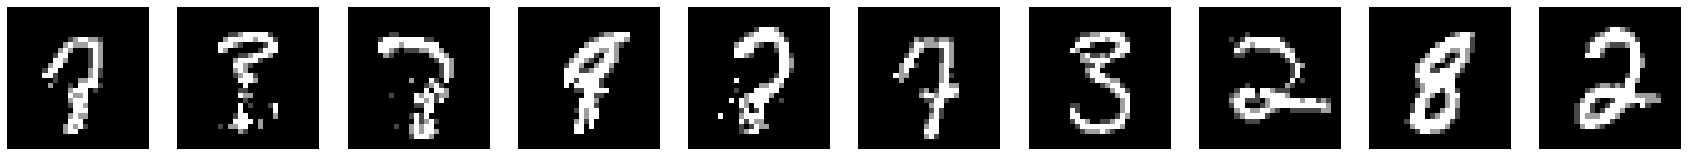

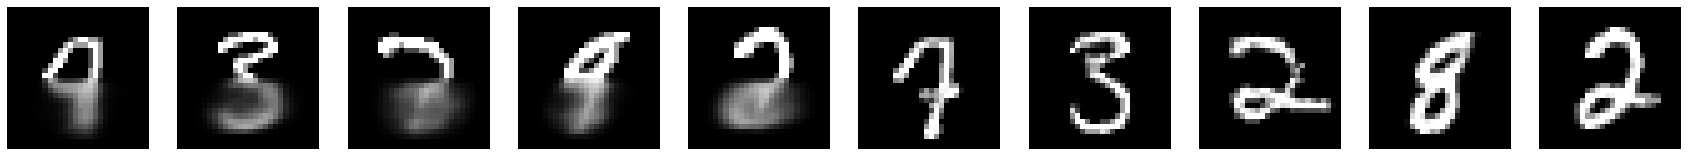

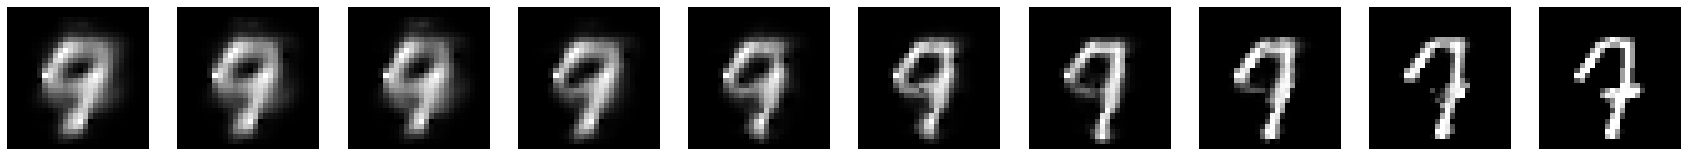

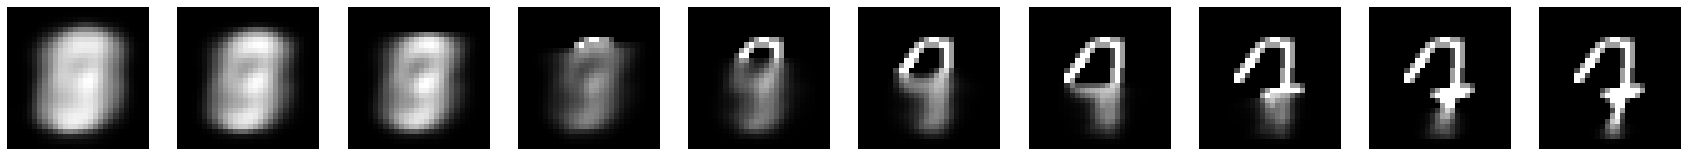

Step 115304, Loss (last minibatch): 0.17380869388580322, Loss (500 step avg.): 0.19448229500990427


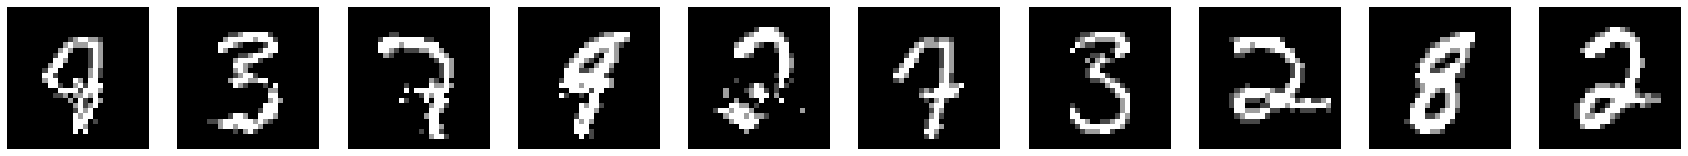

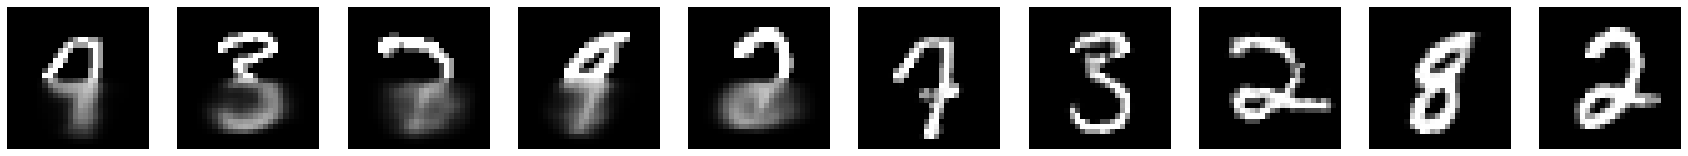

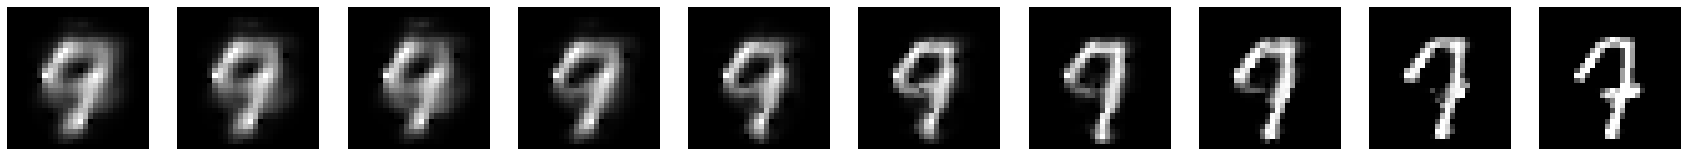

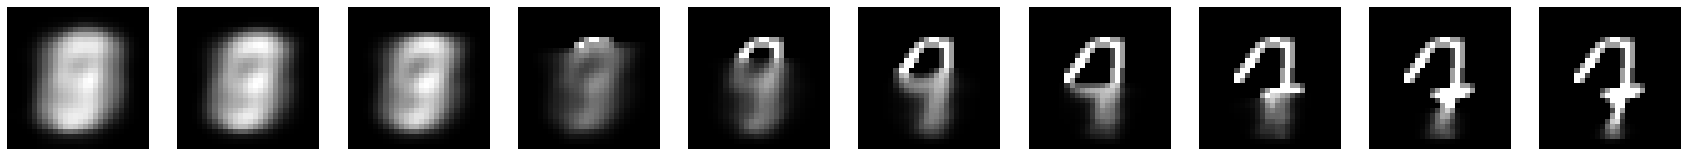

Step 116304, Loss (last minibatch): 0.20616406202316284, Loss (500 step avg.): 0.1946952737823218


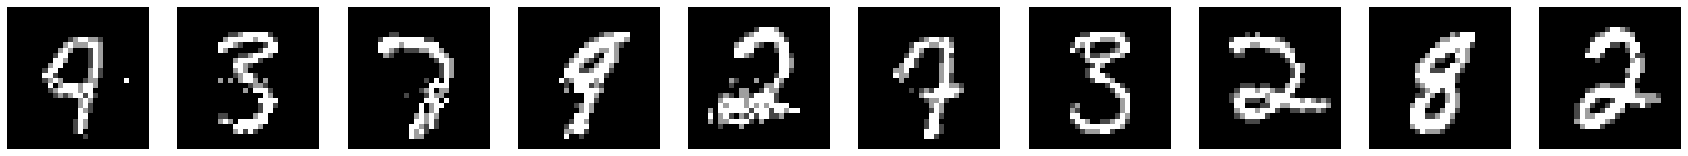

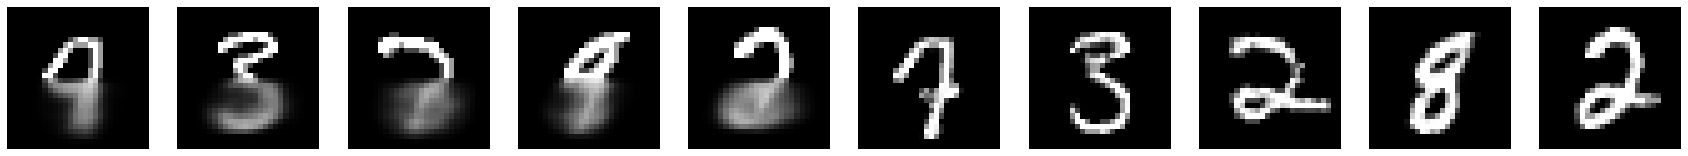

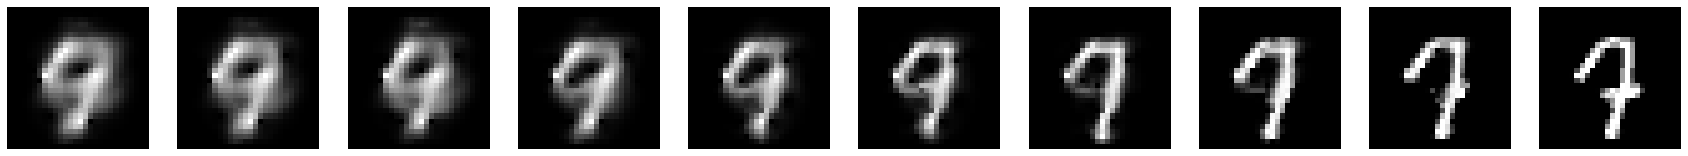

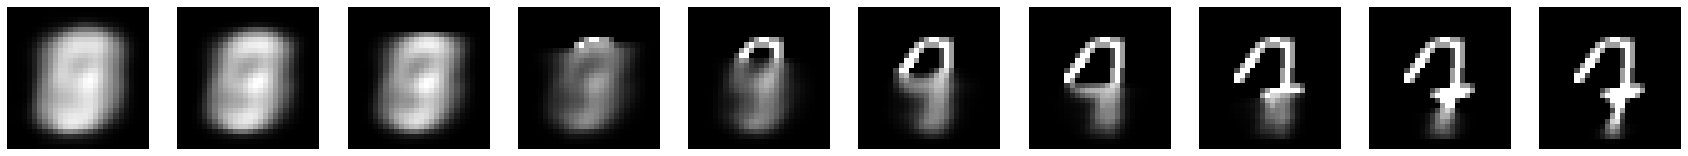

Step 117304, Loss (last minibatch): 0.21549993753433228, Loss (500 step avg.): 0.19592996176607358


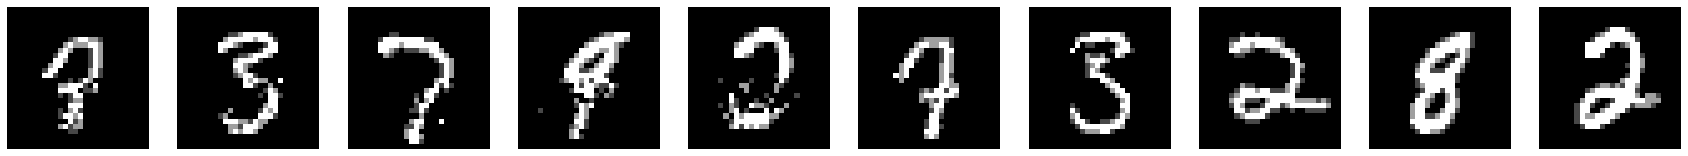

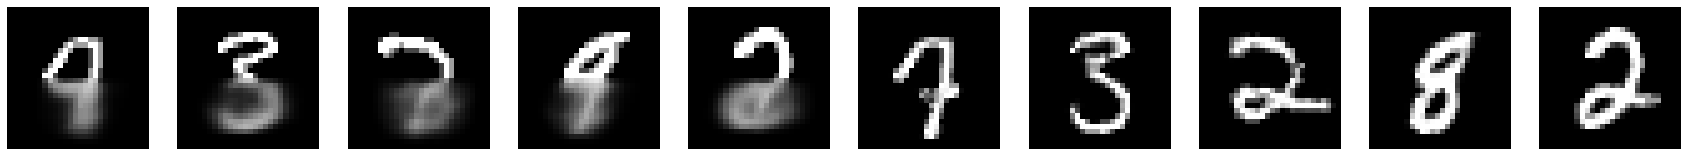

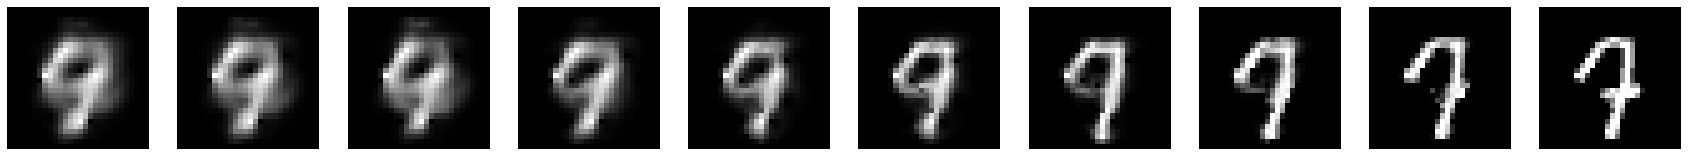

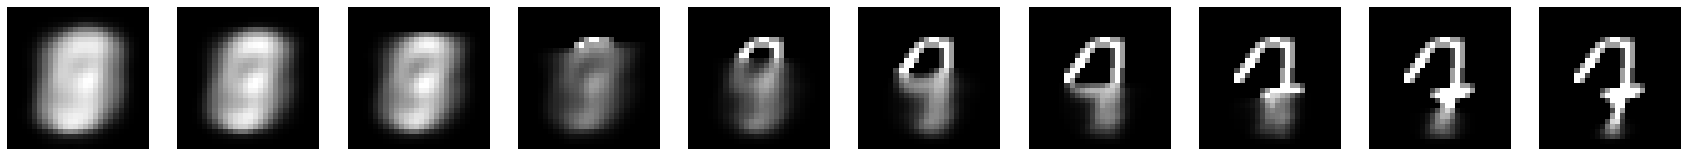

Step 118304, Loss (last minibatch): 0.18002134561538696, Loss (500 step avg.): 0.19419091056563897


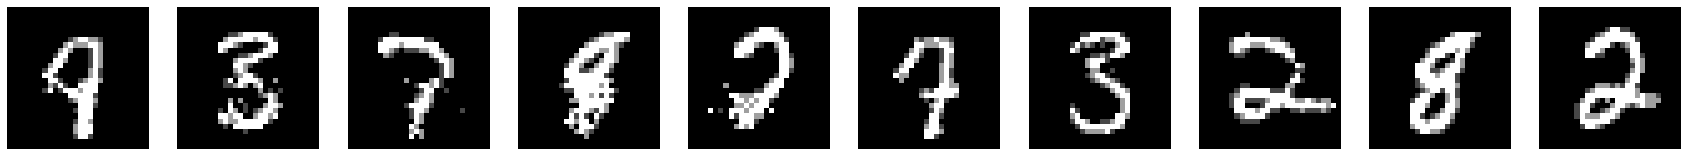

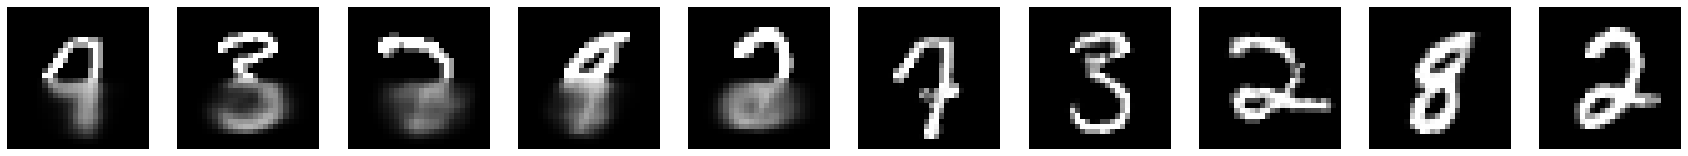

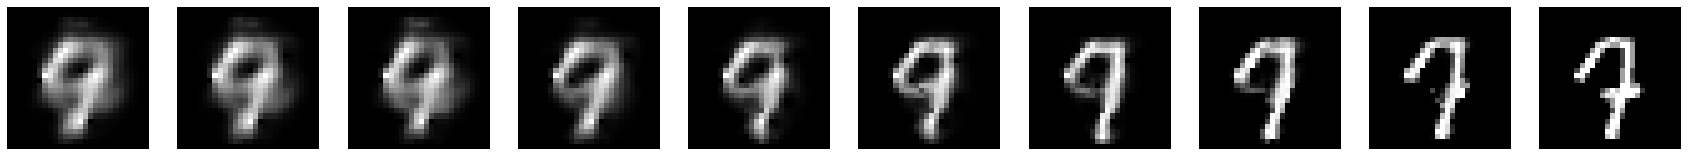

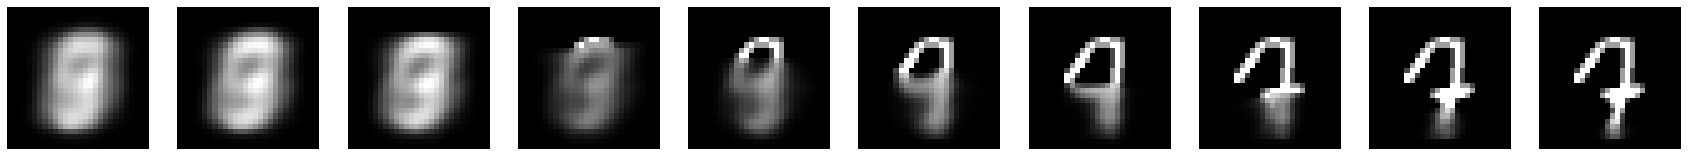

Step 119304, Loss (last minibatch): 0.21538135409355164, Loss (500 step avg.): 0.19242962680296033


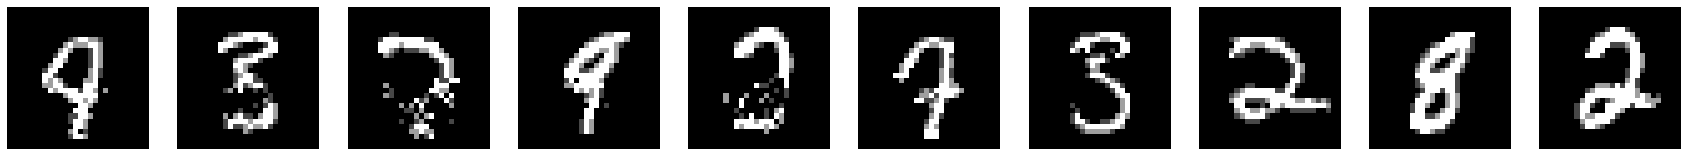

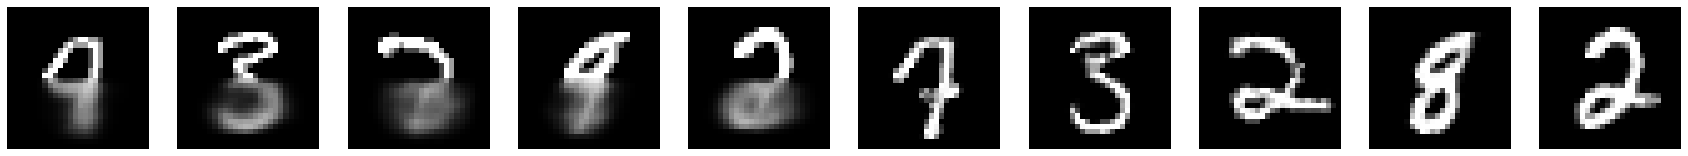

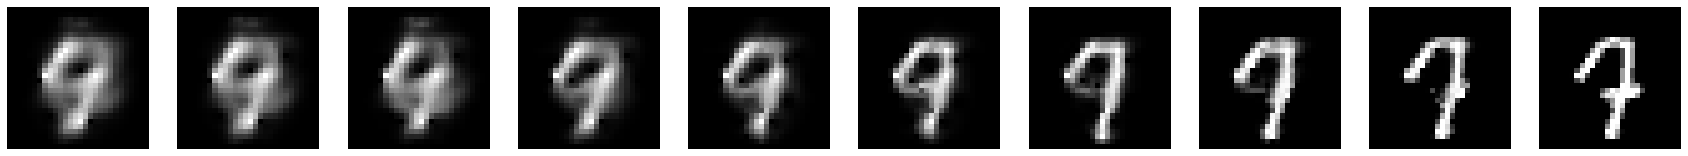

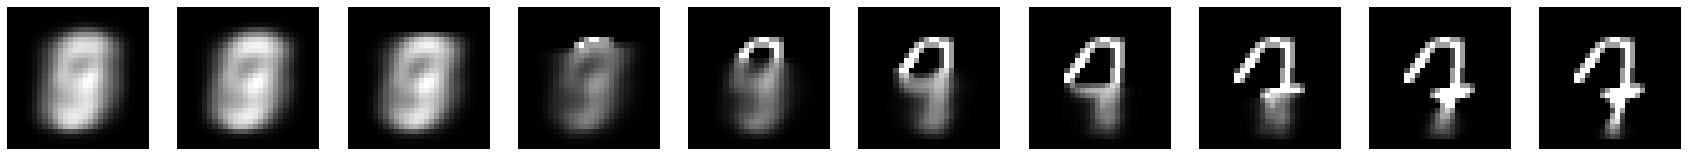

In [9]:

with strategy.scope():
    training_loop.train()

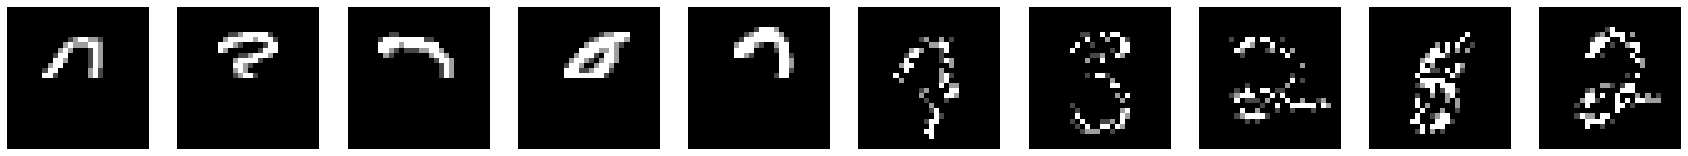

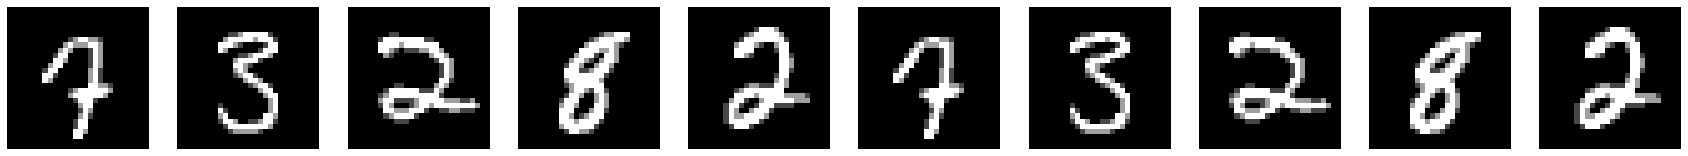

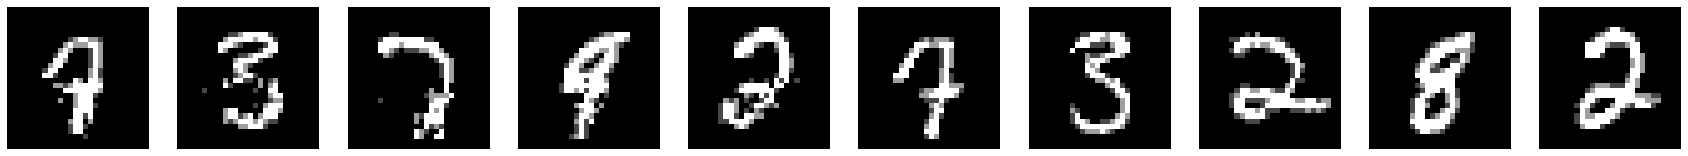

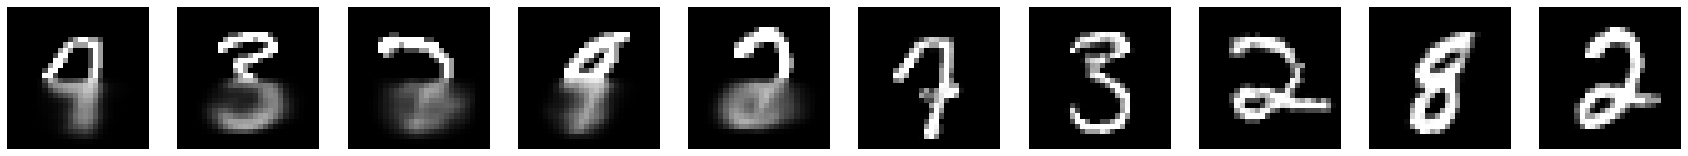

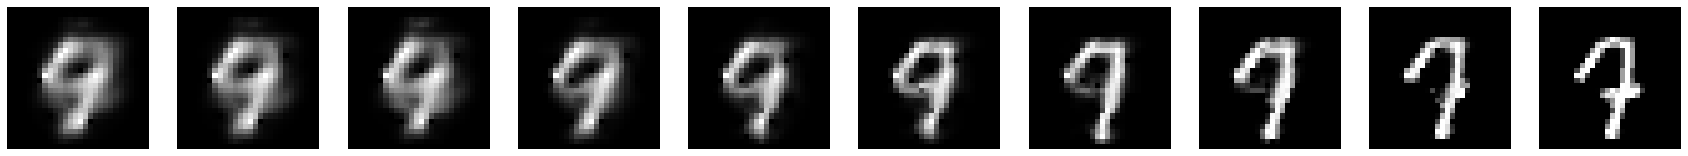

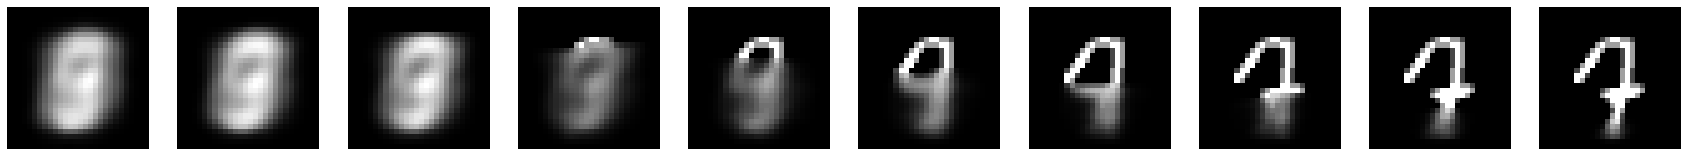

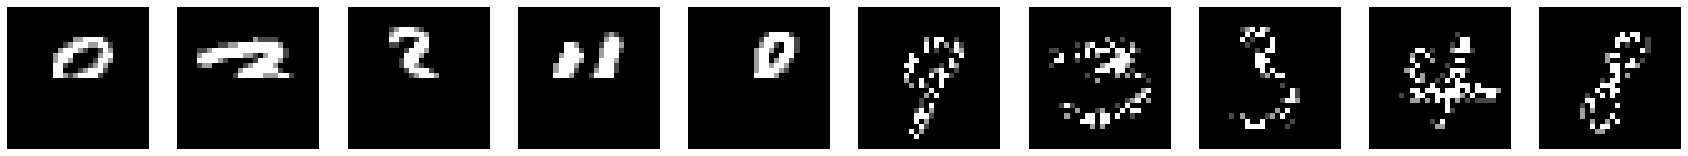

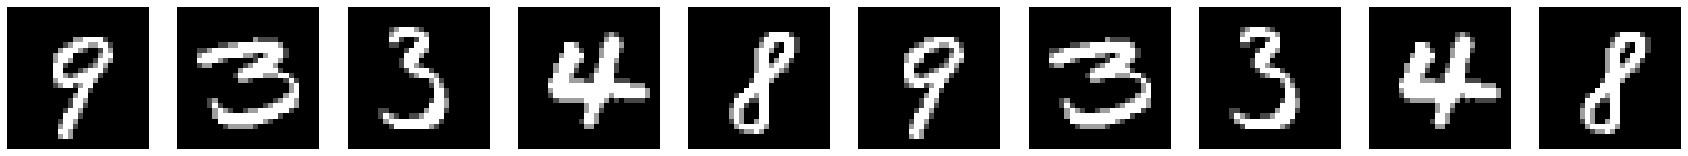

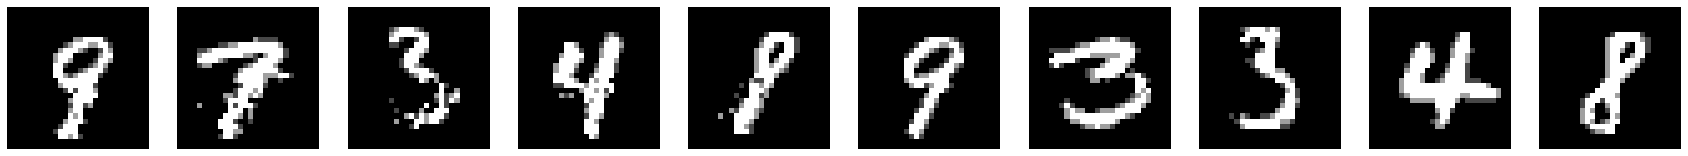

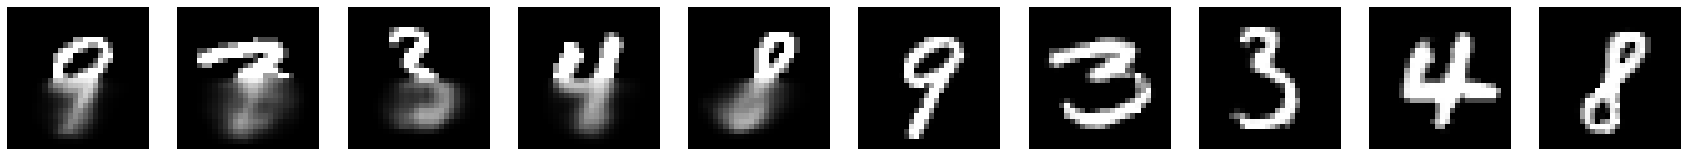

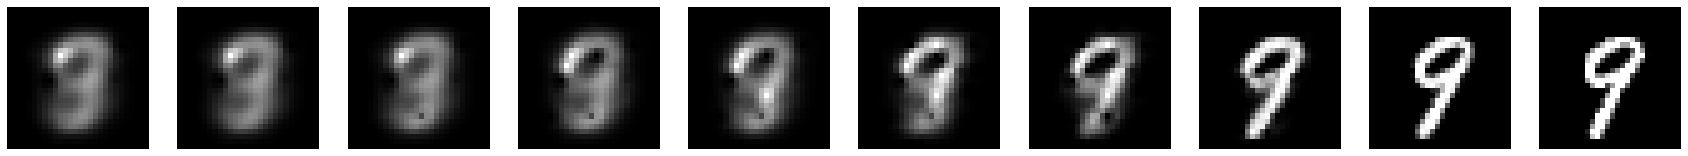

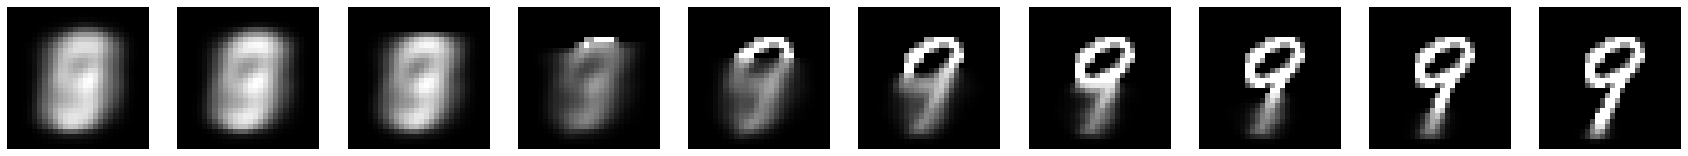

In [10]:
training_loop.process_batch()
training_loop.new_test_batch()
training_loop.process_batch()


In [11]:
model.save(f"models/{model_name}")

INFO:tensorflow:Assets written to: models/cuda6-noise-big/assets


INFO:tensorflow:Assets written to: models/cuda6-noise-big/assets
